# Media Mix Modeling 


## Key Objectives
Companies spend significant budgets on different media such as TV, online, social, print etc. to promote sales of their products and services. In order to optimize these spends and ensure that they give the best impetus to sales, it is important to understand the impact of each media on sales. 

* Create a media mix model to extract the impact of different media on a company's sales. 
* Calculate the Return on Ad Spend for each media.


## Model

The model built here is based on two important and well documented effects of advertising:

**Carryover**: Advertising can have an impact not just in the immediate advertising period (day/week), but in future as well. This results from the fact that many consumers may not immediately act on an advertising they have seen for reasons such as purchase cycles, decision making time, product distribution, inertia etc. The effect that advertising has in future time periods is known as the "carryover" effect of advertising.

**Saturation**: Saturation essentially implies that the impact of any advertising medium will tend to taper and ultimately plateau as more and more money is spent on that medium. Put another way, spending an infinite amount of money on advertising will not lead to infinite sales. 

The model we will create here  can be mathematically represented as:

### &emsp;&emsp; $Y_{t} = Trend_{t} + Media Effect_{t} + \epsilon_{t}$

where 

$Y_{t}$ is the sales in time period (t).

$Trend_{t}$ is the underlying sales trend in time period (t) i.e. sales that takes place without any marketing spend.

$Media Effect_{t}$ is the amount of sales that can be attributed to the media spend. media_effect can be dervied for each medium separately.

$\epsilon_{t}$ is the noise and accounts for the unexplained part of sales.


## Dataset

The dataset used in this project is a synthetic dataset sourced from Kaggle. It has around 4 years of weekly data on sales and spends across TV, radio and newspaper. 




In [40]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import statsmodels.api as sm
from statsmodels.tsa.stattools import acf, adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from scipy.stats import kstest, norm
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.utils.validation import check_is_fitted, check_array
from scipy.signal import convolve2d
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score, TimeSeriesSplit

sns.set_style("whitegrid")
import pickle
import time
import warnings
warnings.filterwarnings('ignore')


### Loading and inspecting the data

In [2]:
mmm_data = pd.read_csv("ad_data.txt")

mmm_data.head()


Date       TV    radio  newspaper     sales
0  2018-01-07  13528.1     0.00       0.00   9779.80
1  2018-01-14      0.0  5349.65    2218.93  13245.19
2  2018-01-21      0.0  4235.86    2046.96  12022.66
3  2018-01-28      0.0  3562.21       0.00   8846.95
4  2018-02-04      0.0     0.00    2187.29   9797.07

In [3]:
mmm_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       200 non-null    object 
 1   TV         200 non-null    float64
 2   radio      200 non-null    float64
 3   newspaper  200 non-null    float64
 4   sales      200 non-null    float64
dtypes: float64(4), object(1)
memory usage: 7.9+ KB


In [3]:
mmm_data["Date"] = pd.to_datetime(mmm_data["Date"])
mmm_data.set_index("Date", inplace=True)
mmm_data.head()


TV    radio  newspaper     sales
Date                                             
2018-01-07  13528.1     0.00       0.00   9779.80
2018-01-14      0.0  5349.65    2218.93  13245.19
2018-01-21      0.0  4235.86    2046.96  12022.66
2018-01-28      0.0  3562.21       0.00   8846.95
2018-02-04      0.0     0.00    2187.29   9797.07

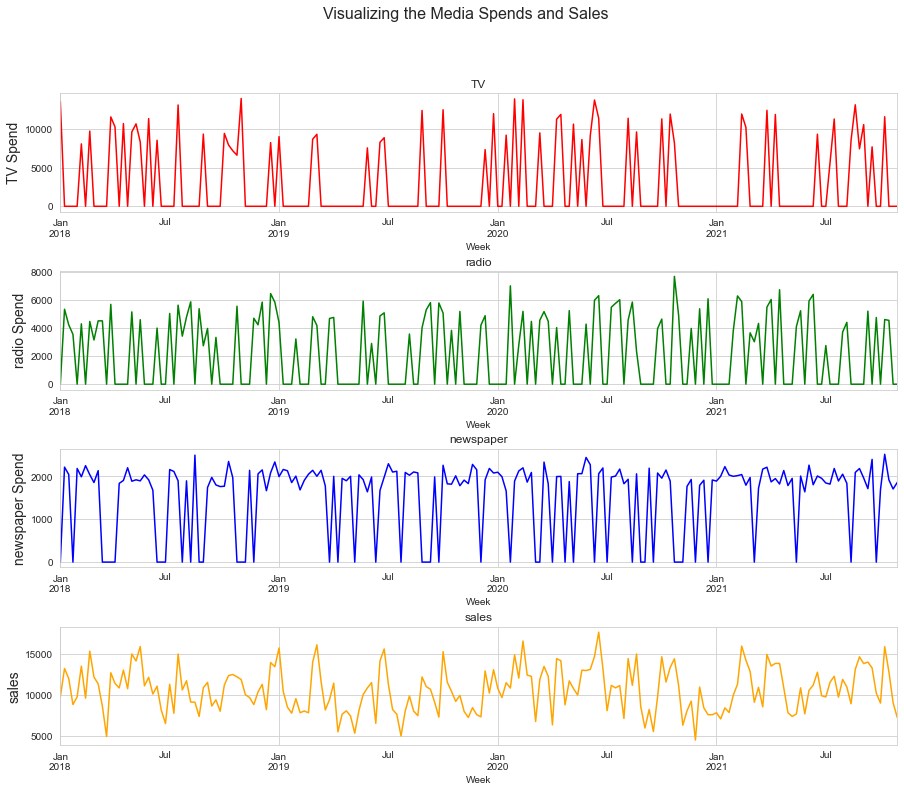

In [72]:
sns.set_style("whitegrid")

fig, axes = plt.subplots(4,1, figsize = (15,12))
colors = {0:'red', 1: 'green', 2: 'blue', 3: 'orange'}
fig.subplots_adjust(wspace=0.5, hspace=0.5)

for i in range(4):
    ax = axes.flatten()[i]
    mmm_data[mmm_data.columns[i]].plot(title=mmm_data.columns[i], c = colors[i], ax=ax)
    
    if i < 3:
        ax.set_ylabel(mmm_data.columns[i]+" Spend", fontsize = 14)
    else:
        ax.set_ylabel(mmm_data.columns[i], fontsize = 14)
    ax.set_xlabel("Week")

fig.suptitle("Visualizing the Media Spends and Sales", fontsize = 16)
    
plt.show()

In [9]:
mmm_data = mmm_data.resample("W").asfreq()
mmm_data.resample("Y").sum()


TV      radio  newspaper      sales
Date                                                  
2018-12-31  187560.21  126546.76   70454.86  569560.78
2019-12-31   95591.14   92665.35   83925.22  505560.27
2020-12-31  174940.12  126418.46   70708.90  572372.83
2021-12-31  131150.06   97086.44   79055.53  486134.42

**Observations**

1. The sales and ad spend data is available for 200 weeks i.e apprximately 4 years.
2. The TV spends are the highest across each year. They happen infrequently in spurts.
3. Radio spends are more frequent than TV, but lower budget is spent on radio per period as compared to TV.
4. Newspaper spends are the highest in frequency and the budget spent is the lowest.


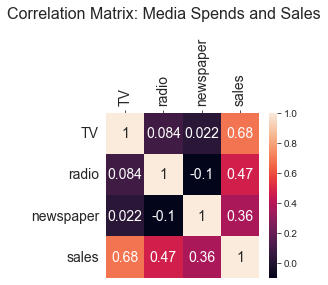

In [10]:
fig, ax = plt.subplots(figsize=(4,4))
ax=sns.heatmap(mmm_data.corr(), annot=True, annot_kws={"size":14})
ax.xaxis.tick_top()
plt.xticks(fontsize="14", rotation=90)
plt.yticks(fontsize="14", rotation=0)
plt.suptitle("Correlation Matrix: Media Spends and Sales", fontsize=16)
plt.tight_layout()
plt.show()


The above shows that sales has a stronger relation with TV spends, with a correlation coefficient of 0.68. Radio and newspaper have a lower correlation at 0.47 and 0.36 respectively. Let's do some scatter plots to visualize sales with each of the media spends.


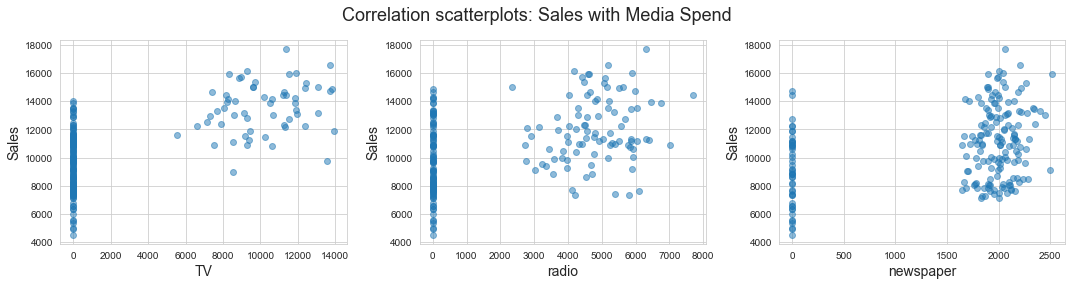

In [11]:
fig, ax = plt.subplots(1, 3, figsize=(15,4), squeeze=False)
fig.subplots_adjust(wspace=0.5, hspace=0.6)

plt.suptitle("Correlation scatterplots: Sales with Media Spend", fontsize=18)

for i, col in enumerate(list(mmm_data.columns[:3])):
    ax[0][i].scatter(x = col, y = "sales", data=mmm_data, alpha=0.5)
    ax[0][i].set_xlabel(col, fontsize=14)
    ax[0][i].set_ylabel("Sales", fontsize=14)

plt.tight_layout()
plt.show()

    


We notice in the above scatter plots that while Sales has a strong correlation with TV spends, the sales still vary in a broad range as TV spends go up. E.g. At a TV spend of ~12000, the sales vary between 12000 and 18000, that's a 1.5x variation! 

Before modeling sales as a function of media spends, let's check if there is any multi-colinearity between different media spends. 


In [6]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

vif = pd.DataFrame()
vif["VIF_Factor"] = [variance_inflation_factor(mmm_data.values, i) for i in range(3)]
vif["features"] = mmm_data.columns[:3]

vif.head()


VIF_Factor   features
0    2.093843         TV
1    2.595381      radio
2    6.152259  newspaper

We see that the VIF scores are all below 10, indicating that the multicolinearity between different media spends is not significant. 

Now let's build the model.



## Modeling
 

We start by first defining classes to model the **carryover** and **saturation** effect.

**Carryover**: <br>
We shall model the carryover with the **geometric decay** function. In this function, the carryover is modeled with strength and length parameters. <br> 
* The strength (S) parameter (between 0 and 1) indicates the proportion of the effect of spend that carries forward from one period to the next. <br> 
* The length(L) is the no. of time periods this phenomenon continues. <br>

The cumulative media effect (also called adstock) in a particular period is the weighted average of media spend in the current period (t) and the previous (L-1) periods, and defined with the following formula:

### &emsp;&emsp;&emsp;adstock(t) &emsp; = &emsp; $\frac {\sum\limits_{k=0} ^{L-1} S^ {k} X_{t-k}}{\sum\limits_{k=0} ^{L-1} S^ {k}} $

where $X_{t-k}$ is the media spend in period (t-k).

**Saturation**: <br>
There are many functions to model saturation. We shall model the it with the **Hill function**.  The Hill function takes values ranging from 0 to 1 and is characterized by two parameters - K and S. <br>
* K (greater than 0) is the half saturation point and 
* S (again greater than 0) is the slope. 

The Hill function is defined by the following equation:

### &emsp;&emsp;&emsp;Hill(t) &emsp; = &emsp; $\frac {1}{1 + (X_{t}/K)^ {-S}} $

where $X_{t}$ is the media spend in period (t).

As can be seen from the equation above, at $X_{t} = K $, the Hill function equals 0.5, as such K is referred as half saturation point. 

In [32]:

class GeometricDecayCarryover(BaseEstimator, TransformerMixin):
    def __init__(self, strength=0.5, length=1):
        self.strength = strength
        self.length = length

    def fit(self, X, y=None):
        X = check_array(X)
        self._check_n_features(X, reset=True)
        self.sliding_window_ = (
            self.strength ** np.arange(self.length + 1) / np.sum(self.strength ** np.arange(self.length + 1))
        ).reshape(-1, 1)
        return self

    def transform(self, X: np.ndarray):
        check_is_fitted(self)
        X = check_array(X)
        self._check_n_features(X, reset=False)
        convolution = convolve2d(X, self.sliding_window_)
        if self.length > 0:
            convolution = convolution[: -self.length]
        return convolution

class HillSaturation(BaseEstimator, TransformerMixin):
    def __init__(self, k=1000., s = 2.):
        self.k = k
        self.s = s
        
    def fit(self, X, y=None):
        X = check_array(X)
        self._check_n_features(X, reset=True) 
        return self

    def transform(self, X):
        check_is_fitted(self)
        X = check_array(X)
        self._check_n_features(X, reset=False) 
        return 1 / (1 + (X/self.k)**(-self.s)) 
    

**Transforming the Media Spends and creating the Model**<br>

Having created the classes for the carryover and saturation effects, we now create a **transformer**. The transformer takes the array of each media spend separately and transforms it using the carryover and saturation functions. These functions are combined into a pipeline. By creating the transformer in this fashion, we can optimize the carryover & saturation parameters for each media separately later on.

The **Model** is built as a pipeline containing the transformation and linear regression steps.


In [33]:

adstock = ColumnTransformer(
    [
     ('tv_pipe', Pipeline([
                           ('carryover', GeometricDecayCarryover()),
                           ('saturation', HillSaturation())
     ]), ['TV']),
     ('radio_pipe', Pipeline([
                           ('carryover', GeometricDecayCarryover()),
                           ('saturation', HillSaturation())
     ]), ['radio']),
     ('newspaper_pipe', Pipeline([
                           ('carryover', GeometricDecayCarryover()),
                           ('saturation', HillSaturation())
     ]), ['newspaper']),
    ],
    remainder='passthrough'
)

MediaMixModel = Pipeline([
                  ('adstock', adstock),
                  ('regression', LinearRegression())
])


In [30]:
X = mmm_data.drop(columns=['sales'])
y = mmm_data['sales']

X.head()

TV    radio  newspaper
Date                                   
2018-01-07  13528.1     0.00       0.00
2018-01-14      0.0  5349.65    2218.93
2018-01-21      0.0  4235.86    2046.96
2018-01-28      0.0  3562.21       0.00
2018-02-04      0.0     0.00    2187.29

In [34]:

MediaMixModel.fit(X, y)

print(cross_val_score(MediaMixModel, X, y, cv=TimeSeriesSplit()).mean())


0.7309747872262535


The $r^{2}$ score for the model is **0.73**. This is a decent start, as we have not optimized the parameters yet. 

To optimize the parameters, we use the OptunaSearchCV optimizer. We create a dictionary called *param_distributions* to specify the ranges for each parameter.  We then specify 1000 trials and do 5 fold cross-validation using the TimeSeriesSplit() function. As we are dealing with time-series data, this function creates successive iterations of training and holdout set, where the holdout set contains the observations that follow (in time) the training set observations.


In [35]:
from optuna.integration import OptunaSearchCV
from optuna.distributions import FloatDistribution, IntDistribution


tuned_model = OptunaSearchCV(
    estimator=MediaMixModel,
    param_distributions={
        'adstock__tv_pipe__carryover__strength': FloatDistribution(0.0, 1.0),
        'adstock__tv_pipe__carryover__length': IntDistribution(0, 12),
        'adstock__tv_pipe__saturation__k': FloatDistribution(0.1, 50000),
        'adstock__tv_pipe__saturation__s': FloatDistribution(0.001, 10.0),
        'adstock__radio_pipe__carryover__strength': FloatDistribution(0.0, 1.0),
        'adstock__radio_pipe__carryover__length': IntDistribution(0, 12),
        'adstock__radio_pipe__saturation__k': FloatDistribution(0.1, 50000),
        'adstock__radio_pipe__saturation__s': FloatDistribution(0.001, 10.0),
        'adstock__newspaper_pipe__carryover__strength': FloatDistribution(0.0, 1.0),
        'adstock__newspaper_pipe__carryover__length': IntDistribution(0, 12),
        'adstock__newspaper_pipe__saturation__k': FloatDistribution(0.1, 50000),
        'adstock__newspaper_pipe__saturation__s': FloatDistribution(0.001, 10.0),
    },
    n_trials=1000,
    cv=TimeSeriesSplit(),
    random_state=0
)



In [36]:
start_time = time.time()

print("r-squared scores from model cross-validation:", cross_val_score(tuned_model, X, y, cv=TimeSeriesSplit()))

end_time = time.time()

print(f"Time_taken: {(end_time-start_time)/60: 4.3} minutes")

[I 2023-02-07 17:17:01,106] A new study created in memory with name: no-name-afba2589-948e-4a7c-9fb5-1be18b43f764
[I 2023-02-07 17:17:01,383] Trial 0 finished with value: 0.09440108137328788 and parameters: {'adstock__tv_pipe__carryover__strength': 0.4860473230215504, 'adstock__tv_pipe__carryover__length': 8, 'adstock__tv_pipe__saturation__k': 49278.803975474875, 'adstock__tv_pipe__saturation__s': 1.956768505212063, 'adstock__radio_pipe__carryover__strength': 0.583411673483624, 'adstock__radio_pipe__carryover__length': 12, 'adstock__radio_pipe__saturation__k': 9024.0968214679, 'adstock__radio_pipe__saturation__s': 7.014984882186943, 'adstock__newspaper_pipe__carryover__strength': 0.8463095456331127, 'adstock__newspaper_pipe__carryover__length': 10, 'adstock__newspaper_pipe__saturation__k': 42931.43704390105, 'adstock__newspaper_pipe__saturation__s': 5.175504116641501}. Best is trial 0 with value: 0.09440108137328788.
[I 2023-02-07 17:17:01,479] Trial 1 finished with value: 0.4186456089

[I 2023-02-07 17:17:03,254] Trial 10 finished with value: 0.2580128958289417 and parameters: {'adstock__tv_pipe__carryover__strength': 0.0008726853952960578, 'adstock__tv_pipe__carryover__length': 0, 'adstock__tv_pipe__saturation__k': 22251.300985697355, 'adstock__tv_pipe__saturation__s': 0.27085792517211504, 'adstock__radio_pipe__carryover__strength': 0.9762834265402401, 'adstock__radio_pipe__carryover__length': 7, 'adstock__radio_pipe__saturation__k': 1571.9588197800585, 'adstock__radio_pipe__saturation__s': 6.418827197785625, 'adstock__newspaper_pipe__carryover__strength': 0.013894087129211613, 'adstock__newspaper_pipe__carryover__length': 12, 'adstock__newspaper_pipe__saturation__k': 35673.477649763976, 'adstock__newspaper_pipe__saturation__s': 2.8697909472675884}. Best is trial 1 with value: 0.4186456089958318.
[I 2023-02-07 17:17:03,389] Trial 11 finished with value: -1.8278100581389551 and parameters: {'adstock__tv_pipe__carryover__strength': 0.020481525611376727, 'adstock__tv_p

[I 2023-02-07 17:17:04,508] Trial 20 finished with value: -0.5130333916407984 and parameters: {'adstock__tv_pipe__carryover__strength': 0.2507398945150211, 'adstock__tv_pipe__carryover__length': 6, 'adstock__tv_pipe__saturation__k': 12678.712359007419, 'adstock__tv_pipe__saturation__s': 2.92367436461452, 'adstock__radio_pipe__carryover__strength': 0.9989736613206366, 'adstock__radio_pipe__carryover__length': 6, 'adstock__radio_pipe__saturation__k': 35798.110761376374, 'adstock__radio_pipe__saturation__s': 8.740956927623865, 'adstock__newspaper_pipe__carryover__strength': 0.30202846581220144, 'adstock__newspaper_pipe__carryover__length': 10, 'adstock__newspaper_pipe__saturation__k': 30240.30411230484, 'adstock__newspaper_pipe__saturation__s': 0.010148862301769146}. Best is trial 1 with value: 0.4186456089958318.
[I 2023-02-07 17:17:04,635] Trial 21 finished with value: 0.3659514002097888 and parameters: {'adstock__tv_pipe__carryover__strength': 0.07356366562217734, 'adstock__tv_pipe__ca

[I 2023-02-07 17:17:06,632] Trial 30 finished with value: 0.314476860810421 and parameters: {'adstock__tv_pipe__carryover__strength': 0.031650084137883054, 'adstock__tv_pipe__carryover__length': 12, 'adstock__tv_pipe__saturation__k': 13693.691637103902, 'adstock__tv_pipe__saturation__s': 1.7033493278922651, 'adstock__radio_pipe__carryover__strength': 0.6325850062123162, 'adstock__radio_pipe__carryover__length': 9, 'adstock__radio_pipe__saturation__k': 9238.016978241707, 'adstock__radio_pipe__saturation__s': 7.671620999756497, 'adstock__newspaper_pipe__carryover__strength': 0.23467744792329273, 'adstock__newspaper_pipe__carryover__length': 7, 'adstock__newspaper_pipe__saturation__k': 46548.16113433322, 'adstock__newspaper_pipe__saturation__s': 0.628986215079503}. Best is trial 28 with value: 0.4711209558380003.
[I 2023-02-07 17:17:06,762] Trial 31 finished with value: 0.46602861162755393 and parameters: {'adstock__tv_pipe__carryover__strength': 0.010159361900353993, 'adstock__tv_pipe__c

[I 2023-02-07 17:17:08,149] Trial 40 finished with value: 0.2911629765851437 and parameters: {'adstock__tv_pipe__carryover__strength': 0.04301724102389453, 'adstock__tv_pipe__carryover__length': 0, 'adstock__tv_pipe__saturation__k': 9876.157718312705, 'adstock__tv_pipe__saturation__s': 0.4626858389577412, 'adstock__radio_pipe__carryover__strength': 0.6342243288304571, 'adstock__radio_pipe__carryover__length': 6, 'adstock__radio_pipe__saturation__k': 11807.19949698869, 'adstock__radio_pipe__saturation__s': 8.590222717285888, 'adstock__newspaper_pipe__carryover__strength': 0.19002026905501446, 'adstock__newspaper_pipe__carryover__length': 7, 'adstock__newspaper_pipe__saturation__k': 44116.05480156554, 'adstock__newspaper_pipe__saturation__s': 0.29426404898732134}. Best is trial 37 with value: 0.4736230408102021.
[I 2023-02-07 17:17:08,281] Trial 41 finished with value: 0.4198339207748276 and parameters: {'adstock__tv_pipe__carryover__strength': 0.0032906511245977994, 'adstock__tv_pipe__c

[I 2023-02-07 17:17:09,402] Trial 50 finished with value: 0.3197131911650437 and parameters: {'adstock__tv_pipe__carryover__strength': 0.048070407155474636, 'adstock__tv_pipe__carryover__length': 2, 'adstock__tv_pipe__saturation__k': 24208.12193220057, 'adstock__tv_pipe__saturation__s': 0.3762103675167171, 'adstock__radio_pipe__carryover__strength': 0.7199129189809488, 'adstock__radio_pipe__carryover__length': 6, 'adstock__radio_pipe__saturation__k': 16544.5504184722, 'adstock__radio_pipe__saturation__s': 7.731115013285688, 'adstock__newspaper_pipe__carryover__strength': 0.27101501579485776, 'adstock__newspaper_pipe__carryover__length': 12, 'adstock__newspaper_pipe__saturation__k': 44942.73427733603, 'adstock__newspaper_pipe__saturation__s': 0.9990549575874947}. Best is trial 37 with value: 0.4736230408102021.
[I 2023-02-07 17:17:09,560] Trial 51 finished with value: 0.3693479438578612 and parameters: {'adstock__tv_pipe__carryover__strength': 0.045491634433894354, 'adstock__tv_pipe__ca

[I 2023-02-07 17:17:10,675] Trial 60 finished with value: 0.39787260962980653 and parameters: {'adstock__tv_pipe__carryover__strength': 0.13462255239443144, 'adstock__tv_pipe__carryover__length': 0, 'adstock__tv_pipe__saturation__k': 20294.181514290132, 'adstock__tv_pipe__saturation__s': 0.3361303818905079, 'adstock__radio_pipe__carryover__strength': 0.6973164551360335, 'adstock__radio_pipe__carryover__length': 9, 'adstock__radio_pipe__saturation__k': 22580.11701635737, 'adstock__radio_pipe__saturation__s': 6.898977245079397, 'adstock__newspaper_pipe__carryover__strength': 0.23873051162309974, 'adstock__newspaper_pipe__carryover__length': 10, 'adstock__newspaper_pipe__saturation__k': 27626.800924837364, 'adstock__newspaper_pipe__saturation__s': 2.4389712425307226}. Best is trial 37 with value: 0.4736230408102021.
[I 2023-02-07 17:17:10,794] Trial 61 finished with value: 0.4450095528235104 and parameters: {'adstock__tv_pipe__carryover__strength': 0.0849765901691964, 'adstock__tv_pipe__c

[I 2023-02-07 17:17:12,045] Trial 70 finished with value: -0.3173113061244742 and parameters: {'adstock__tv_pipe__carryover__strength': 0.14321299105004492, 'adstock__tv_pipe__carryover__length': 5, 'adstock__tv_pipe__saturation__k': 13105.829031738002, 'adstock__tv_pipe__saturation__s': 0.32235267009369617, 'adstock__radio_pipe__carryover__strength': 0.778834758510918, 'adstock__radio_pipe__carryover__length': 8, 'adstock__radio_pipe__saturation__k': 7072.795591129143, 'adstock__radio_pipe__saturation__s': 5.598320374885377, 'adstock__newspaper_pipe__carryover__strength': 0.0684704084507674, 'adstock__newspaper_pipe__carryover__length': 12, 'adstock__newspaper_pipe__saturation__k': 42134.43197632576, 'adstock__newspaper_pipe__saturation__s': 0.5595419990305959}. Best is trial 37 with value: 0.4736230408102021.
[I 2023-02-07 17:17:12,170] Trial 71 finished with value: 0.4347563486699748 and parameters: {'adstock__tv_pipe__carryover__strength': 0.08304035395168614, 'adstock__tv_pipe__ca

[I 2023-02-07 17:17:13,293] Trial 80 finished with value: 0.38545854225759185 and parameters: {'adstock__tv_pipe__carryover__strength': 0.12392630062573587, 'adstock__tv_pipe__carryover__length': 4, 'adstock__tv_pipe__saturation__k': 13095.751223739178, 'adstock__tv_pipe__saturation__s': 1.4608870953761097, 'adstock__radio_pipe__carryover__strength': 0.5301626011811909, 'adstock__radio_pipe__carryover__length': 8, 'adstock__radio_pipe__saturation__k': 8473.164345623618, 'adstock__radio_pipe__saturation__s': 7.200551643927616, 'adstock__newspaper_pipe__carryover__strength': 0.12642084921382202, 'adstock__newspaper_pipe__carryover__length': 11, 'adstock__newspaper_pipe__saturation__k': 34122.37722296091, 'adstock__newspaper_pipe__saturation__s': 1.7180130693680926}. Best is trial 37 with value: 0.4736230408102021.
[I 2023-02-07 17:17:13,425] Trial 81 finished with value: 0.4162138410085528 and parameters: {'adstock__tv_pipe__carryover__strength': 0.062643313258761, 'adstock__tv_pipe__car

[I 2023-02-07 17:17:14,555] Trial 90 finished with value: 0.09557725979616387 and parameters: {'adstock__tv_pipe__carryover__strength': 0.2523500231926844, 'adstock__tv_pipe__carryover__length': 6, 'adstock__tv_pipe__saturation__k': 6177.824049333003, 'adstock__tv_pipe__saturation__s': 1.8216647980088672, 'adstock__radio_pipe__carryover__strength': 0.493345567041508, 'adstock__radio_pipe__carryover__length': 5, 'adstock__radio_pipe__saturation__k': 1506.5901010837788, 'adstock__radio_pipe__saturation__s': 8.624521019824925, 'adstock__newspaper_pipe__carryover__strength': 0.005310496338484736, 'adstock__newspaper_pipe__carryover__length': 2, 'adstock__newspaper_pipe__saturation__k': 48796.84328151115, 'adstock__newspaper_pipe__saturation__s': 0.04088979356086714}. Best is trial 86 with value: 0.6567206890342054.
[I 2023-02-07 17:17:14,680] Trial 91 finished with value: 0.6133735746662408 and parameters: {'adstock__tv_pipe__carryover__strength': 0.2075771609301027, 'adstock__tv_pipe__car

[I 2023-02-07 17:17:15,863] Trial 100 finished with value: 0.5311300799864664 and parameters: {'adstock__tv_pipe__carryover__strength': 0.31179714238744516, 'adstock__tv_pipe__carryover__length': 6, 'adstock__tv_pipe__saturation__k': 4737.730461455904, 'adstock__tv_pipe__saturation__s': 1.9751306178071073, 'adstock__radio_pipe__carryover__strength': 0.44087092755231383, 'adstock__radio_pipe__carryover__length': 5, 'adstock__radio_pipe__saturation__k': 3820.0088972825242, 'adstock__radio_pipe__saturation__s': 8.949941746780892, 'adstock__newspaper_pipe__carryover__strength': 0.04318397282506006, 'adstock__newspaper_pipe__carryover__length': 0, 'adstock__newspaper_pipe__saturation__k': 49842.44381855057, 'adstock__newspaper_pipe__saturation__s': 0.016766207562163737}. Best is trial 97 with value: 0.6704138061690281.
[I 2023-02-07 17:17:15,989] Trial 101 finished with value: 0.6121105172788173 and parameters: {'adstock__tv_pipe__carryover__strength': 0.19805745900637797, 'adstock__tv_pipe

[I 2023-02-07 17:17:17,141] Trial 110 finished with value: 0.5289818883136985 and parameters: {'adstock__tv_pipe__carryover__strength': 0.17963697092580722, 'adstock__tv_pipe__carryover__length': 9, 'adstock__tv_pipe__saturation__k': 2835.5935683222824, 'adstock__tv_pipe__saturation__s': 3.003650001890865, 'adstock__radio_pipe__carryover__strength': 0.31811276035302133, 'adstock__radio_pipe__carryover__length': 6, 'adstock__radio_pipe__saturation__k': 4294.280445738126, 'adstock__radio_pipe__saturation__s': 9.506366369946862, 'adstock__newspaper_pipe__carryover__strength': 0.0009676890231423503, 'adstock__newspaper_pipe__carryover__length': 1, 'adstock__newspaper_pipe__saturation__k': 49154.704917319745, 'adstock__newspaper_pipe__saturation__s': 0.5245306832992912}. Best is trial 97 with value: 0.6704138061690281.
[I 2023-02-07 17:17:17,264] Trial 111 finished with value: 0.43010775025874465 and parameters: {'adstock__tv_pipe__carryover__strength': 0.1974288891536569, 'adstock__tv_pipe

[I 2023-02-07 17:17:18,482] Trial 120 finished with value: 0.31627242122026333 and parameters: {'adstock__tv_pipe__carryover__strength': 0.28475849171919804, 'adstock__tv_pipe__carryover__length': 6, 'adstock__tv_pipe__saturation__k': 3126.745442043645, 'adstock__tv_pipe__saturation__s': 3.105627719869296, 'adstock__radio_pipe__carryover__strength': 0.4139614636444063, 'adstock__radio_pipe__carryover__length': 6, 'adstock__radio_pipe__saturation__k': 6112.1768831072895, 'adstock__radio_pipe__saturation__s': 9.391841149027194, 'adstock__newspaper_pipe__carryover__strength': 0.056021444934012884, 'adstock__newspaper_pipe__carryover__length': 4, 'adstock__newspaper_pipe__saturation__k': 49887.05888289919, 'adstock__newspaper_pipe__saturation__s': 0.5989052480362986}. Best is trial 118 with value: 0.6841443629539421.
[I 2023-02-07 17:17:18,622] Trial 121 finished with value: 0.48181440040681806 and parameters: {'adstock__tv_pipe__carryover__strength': 0.24432238095527736, 'adstock__tv_pipe

[I 2023-02-07 17:17:19,810] Trial 130 finished with value: 0.35284695112145237 and parameters: {'adstock__tv_pipe__carryover__strength': 0.15164559442666997, 'adstock__tv_pipe__carryover__length': 6, 'adstock__tv_pipe__saturation__k': 3205.8627992499387, 'adstock__tv_pipe__saturation__s': 3.451917248071578, 'adstock__radio_pipe__carryover__strength': 0.3784156080103772, 'adstock__radio_pipe__carryover__length': 4, 'adstock__radio_pipe__saturation__k': 5362.521939832445, 'adstock__radio_pipe__saturation__s': 7.6564139777865705, 'adstock__newspaper_pipe__carryover__strength': 0.10731633143848725, 'adstock__newspaper_pipe__carryover__length': 1, 'adstock__newspaper_pipe__saturation__k': 45883.355815728384, 'adstock__newspaper_pipe__saturation__s': 1.2003016470113188}. Best is trial 118 with value: 0.6841443629539421.
[I 2023-02-07 17:17:19,939] Trial 131 finished with value: 0.5177369625000097 and parameters: {'adstock__tv_pipe__carryover__strength': 0.25702582429316, 'adstock__tv_pipe__c

[I 2023-02-07 17:17:21,138] Trial 140 finished with value: -0.6205022670871271 and parameters: {'adstock__tv_pipe__carryover__strength': 0.2656981740964253, 'adstock__tv_pipe__carryover__length': 11, 'adstock__tv_pipe__saturation__k': 180.76149286145164, 'adstock__tv_pipe__saturation__s': 1.228597339796399, 'adstock__radio_pipe__carryover__strength': 0.32706332550586326, 'adstock__radio_pipe__carryover__length': 5, 'adstock__radio_pipe__saturation__k': 1928.8225179656624, 'adstock__radio_pipe__saturation__s': 9.220352837286415, 'adstock__newspaper_pipe__carryover__strength': 0.040738935006148655, 'adstock__newspaper_pipe__carryover__length': 1, 'adstock__newspaper_pipe__saturation__k': 46432.90083726795, 'adstock__newspaper_pipe__saturation__s': 0.10302690223830768}. Best is trial 118 with value: 0.6841443629539421.
[I 2023-02-07 17:17:21,274] Trial 141 finished with value: 0.6015981842306515 and parameters: {'adstock__tv_pipe__carryover__strength': 0.16855024253668477, 'adstock__tv_pi

[I 2023-02-07 17:17:22,525] Trial 150 finished with value: 0.4265495083857487 and parameters: {'adstock__tv_pipe__carryover__strength': 0.2834839604009446, 'adstock__tv_pipe__carryover__length': 5, 'adstock__tv_pipe__saturation__k': 3498.7143842763126, 'adstock__tv_pipe__saturation__s': 2.1838494351073114, 'adstock__radio_pipe__carryover__strength': 0.44964512927497646, 'adstock__radio_pipe__carryover__length': 6, 'adstock__radio_pipe__saturation__k': 802.807265763063, 'adstock__radio_pipe__saturation__s': 8.43449615335997, 'adstock__newspaper_pipe__carryover__strength': 0.10924506129736122, 'adstock__newspaper_pipe__carryover__length': 3, 'adstock__newspaper_pipe__saturation__k': 48462.025556825036, 'adstock__newspaper_pipe__saturation__s': 1.1984603686153608}. Best is trial 118 with value: 0.6841443629539421.
[I 2023-02-07 17:17:22,655] Trial 151 finished with value: 0.48417671606086515 and parameters: {'adstock__tv_pipe__carryover__strength': 0.18264885343791684, 'adstock__tv_pipe__

[I 2023-02-07 17:17:23,847] Trial 160 finished with value: 0.4190042131945771 and parameters: {'adstock__tv_pipe__carryover__strength': 0.23926809297209495, 'adstock__tv_pipe__carryover__length': 7, 'adstock__tv_pipe__saturation__k': 6422.8667352653065, 'adstock__tv_pipe__saturation__s': 2.9113092032847194, 'adstock__radio_pipe__carryover__strength': 0.46011193476836343, 'adstock__radio_pipe__carryover__length': 5, 'adstock__radio_pipe__saturation__k': 3411.873335560502, 'adstock__radio_pipe__saturation__s': 9.702525818944574, 'adstock__newspaper_pipe__carryover__strength': 0.019874554278834868, 'adstock__newspaper_pipe__carryover__length': 2, 'adstock__newspaper_pipe__saturation__k': 48913.840132019606, 'adstock__newspaper_pipe__saturation__s': 0.708760299412923}. Best is trial 153 with value: 0.6944850398611407.
[I 2023-02-07 17:17:23,978] Trial 161 finished with value: 0.5744584317746179 and parameters: {'adstock__tv_pipe__carryover__strength': 0.2041193165999275, 'adstock__tv_pipe_

[I 2023-02-07 17:17:25,189] Trial 170 finished with value: 0.2125898213862997 and parameters: {'adstock__tv_pipe__carryover__strength': 0.2200289919443717, 'adstock__tv_pipe__carryover__length': 9, 'adstock__tv_pipe__saturation__k': 478.2520320898857, 'adstock__tv_pipe__saturation__s': 1.5129524573583963, 'adstock__radio_pipe__carryover__strength': 0.3625137048915794, 'adstock__radio_pipe__carryover__length': 4, 'adstock__radio_pipe__saturation__k': 2616.1735551719635, 'adstock__radio_pipe__saturation__s': 8.866320917715589, 'adstock__newspaper_pipe__carryover__strength': 0.08414806378875109, 'adstock__newspaper_pipe__carryover__length': 2, 'adstock__newspaper_pipe__saturation__k': 44781.055162863704, 'adstock__newspaper_pipe__saturation__s': 0.9435593160457115}. Best is trial 153 with value: 0.6944850398611407.
[I 2023-02-07 17:17:25,320] Trial 171 finished with value: 0.5230321789761536 and parameters: {'adstock__tv_pipe__carryover__strength': 0.18966685976909906, 'adstock__tv_pipe__

[I 2023-02-07 17:17:26,497] Trial 180 finished with value: 0.41821297585993805 and parameters: {'adstock__tv_pipe__carryover__strength': 0.31829703435290757, 'adstock__tv_pipe__carryover__length': 7, 'adstock__tv_pipe__saturation__k': 5846.339751714562, 'adstock__tv_pipe__saturation__s': 1.2332517907201326, 'adstock__radio_pipe__carryover__strength': 0.36518086715831555, 'adstock__radio_pipe__carryover__length': 6, 'adstock__radio_pipe__saturation__k': 1787.6736814350315, 'adstock__radio_pipe__saturation__s': 7.923185999074073, 'adstock__newspaper_pipe__carryover__strength': 0.06293188317624568, 'adstock__newspaper_pipe__carryover__length': 2, 'adstock__newspaper_pipe__saturation__k': 31164.78249708408, 'adstock__newspaper_pipe__saturation__s': 0.23617403985948823}. Best is trial 153 with value: 0.6944850398611407.
[I 2023-02-07 17:17:26,631] Trial 181 finished with value: 0.6091210797529995 and parameters: {'adstock__tv_pipe__carryover__strength': 0.21968129657231722, 'adstock__tv_pip

[I 2023-02-07 17:17:27,850] Trial 190 finished with value: 0.2599157128776396 and parameters: {'adstock__tv_pipe__carryover__strength': 0.17982962375001793, 'adstock__tv_pipe__carryover__length': 6, 'adstock__tv_pipe__saturation__k': 4026.3099724440613, 'adstock__tv_pipe__saturation__s': 2.6241371697319815, 'adstock__radio_pipe__carryover__strength': 0.33347520671421094, 'adstock__radio_pipe__carryover__length': 5, 'adstock__radio_pipe__saturation__k': 1268.851410351312, 'adstock__radio_pipe__saturation__s': 7.981124041310809, 'adstock__newspaper_pipe__carryover__strength': 0.33630313545159657, 'adstock__newspaper_pipe__carryover__length': 3, 'adstock__newspaper_pipe__saturation__k': 49123.76675651947, 'adstock__newspaper_pipe__saturation__s': 3.330905171464239}. Best is trial 153 with value: 0.6944850398611407.
[I 2023-02-07 17:17:27,993] Trial 191 finished with value: 0.6230508645528898 and parameters: {'adstock__tv_pipe__carryover__strength': 0.1705428322311497, 'adstock__tv_pipe__c

[I 2023-02-07 17:17:29,222] Trial 200 finished with value: 0.44749491910238337 and parameters: {'adstock__tv_pipe__carryover__strength': 0.16668424686824493, 'adstock__tv_pipe__carryover__length': 6, 'adstock__tv_pipe__saturation__k': 1771.2858550690216, 'adstock__tv_pipe__saturation__s': 1.113721686433253, 'adstock__radio_pipe__carryover__strength': 0.31344915502632054, 'adstock__radio_pipe__carryover__length': 4, 'adstock__radio_pipe__saturation__k': 4193.795542206541, 'adstock__radio_pipe__saturation__s': 8.152033483940528, 'adstock__newspaper_pipe__carryover__strength': 0.12929104329002497, 'adstock__newspaper_pipe__carryover__length': 3, 'adstock__newspaper_pipe__saturation__k': 42494.81113998628, 'adstock__newspaper_pipe__saturation__s': 0.7353484066454647}. Best is trial 153 with value: 0.6944850398611407.
[I 2023-02-07 17:17:29,361] Trial 201 finished with value: 0.5590453314056504 and parameters: {'adstock__tv_pipe__carryover__strength': 0.1859339521414836, 'adstock__tv_pipe__

[I 2023-02-07 17:17:30,591] Trial 210 finished with value: 0.39855752563745617 and parameters: {'adstock__tv_pipe__carryover__strength': 0.11503524386385995, 'adstock__tv_pipe__carryover__length': 6, 'adstock__tv_pipe__saturation__k': 5367.723946271692, 'adstock__tv_pipe__saturation__s': 2.99641273180783, 'adstock__radio_pipe__carryover__strength': 0.40426766824122456, 'adstock__radio_pipe__carryover__length': 4, 'adstock__radio_pipe__saturation__k': 4578.955722483773, 'adstock__radio_pipe__saturation__s': 7.3671172148315724, 'adstock__newspaper_pipe__carryover__strength': 0.02904621198479619, 'adstock__newspaper_pipe__carryover__length': 3, 'adstock__newspaper_pipe__saturation__k': 47573.74388852416, 'adstock__newspaper_pipe__saturation__s': 0.8014112624066367}. Best is trial 153 with value: 0.6944850398611407.
[I 2023-02-07 17:17:30,725] Trial 211 finished with value: 0.6476529914639537 and parameters: {'adstock__tv_pipe__carryover__strength': 0.17272535942881231, 'adstock__tv_pipe__

[I 2023-02-07 17:17:31,971] Trial 220 finished with value: 0.4822450352123416 and parameters: {'adstock__tv_pipe__carryover__strength': 0.13599959252659471, 'adstock__tv_pipe__carryover__length': 6, 'adstock__tv_pipe__saturation__k': 1939.7546164152232, 'adstock__tv_pipe__saturation__s': 3.0038643684560595, 'adstock__radio_pipe__carryover__strength': 0.47747529202034866, 'adstock__radio_pipe__carryover__length': 5, 'adstock__radio_pipe__saturation__k': 24230.529080245044, 'adstock__radio_pipe__saturation__s': 8.881766492152536, 'adstock__newspaper_pipe__carryover__strength': 0.049968918966524195, 'adstock__newspaper_pipe__carryover__length': 3, 'adstock__newspaper_pipe__saturation__k': 40532.56970943508, 'adstock__newspaper_pipe__saturation__s': 0.5434020806443781}. Best is trial 153 with value: 0.6944850398611407.
[I 2023-02-07 17:17:32,116] Trial 221 finished with value: 0.6165601768597573 and parameters: {'adstock__tv_pipe__carryover__strength': 0.16589552527620052, 'adstock__tv_pip

[I 2023-02-07 17:17:33,472] Trial 230 finished with value: 0.23015192858406347 and parameters: {'adstock__tv_pipe__carryover__strength': 0.34191490489717175, 'adstock__tv_pipe__carryover__length': 6, 'adstock__tv_pipe__saturation__k': 8601.772965482418, 'adstock__tv_pipe__saturation__s': 2.4057275165932825, 'adstock__radio_pipe__carryover__strength': 0.3150359126859883, 'adstock__radio_pipe__carryover__length': 5, 'adstock__radio_pipe__saturation__k': 2664.21161029634, 'adstock__radio_pipe__saturation__s': 8.337818153286822, 'adstock__newspaper_pipe__carryover__strength': 0.9551569667804903, 'adstock__newspaper_pipe__carryover__length': 2, 'adstock__newspaper_pipe__saturation__k': 29191.521039154795, 'adstock__newspaper_pipe__saturation__s': 1.2205667334818218}. Best is trial 153 with value: 0.6944850398611407.
[I 2023-02-07 17:17:33,612] Trial 231 finished with value: 0.5695268495856325 and parameters: {'adstock__tv_pipe__carryover__strength': 0.16320930771730363, 'adstock__tv_pipe__c

[I 2023-02-07 17:17:34,897] Trial 240 finished with value: 0.5977656563229574 and parameters: {'adstock__tv_pipe__carryover__strength': 0.1264505348299453, 'adstock__tv_pipe__carryover__length': 6, 'adstock__tv_pipe__saturation__k': 1317.3072636966558, 'adstock__tv_pipe__saturation__s': 3.0469735280128827, 'adstock__radio_pipe__carryover__strength': 0.3642169497129761, 'adstock__radio_pipe__carryover__length': 6, 'adstock__radio_pipe__saturation__k': 2747.816460181969, 'adstock__radio_pipe__saturation__s': 7.761707848172273, 'adstock__newspaper_pipe__carryover__strength': 0.01960748157557192, 'adstock__newspaper_pipe__carryover__length': 3, 'adstock__newspaper_pipe__saturation__k': 44441.56827407656, 'adstock__newspaper_pipe__saturation__s': 2.0127302214899467}. Best is trial 153 with value: 0.6944850398611407.
[I 2023-02-07 17:17:35,034] Trial 241 finished with value: 0.14781312767857063 and parameters: {'adstock__tv_pipe__carryover__strength': 0.17046062835246226, 'adstock__tv_pipe__

[I 2023-02-07 17:17:36,340] Trial 250 finished with value: 0.1878469387477356 and parameters: {'adstock__tv_pipe__carryover__strength': 0.418979349820669, 'adstock__tv_pipe__carryover__length': 7, 'adstock__tv_pipe__saturation__k': 4997.384362384152, 'adstock__tv_pipe__saturation__s': 1.185240927092413, 'adstock__radio_pipe__carryover__strength': 0.3924231807316629, 'adstock__radio_pipe__carryover__length': 5, 'adstock__radio_pipe__saturation__k': 3455.066319756759, 'adstock__radio_pipe__saturation__s': 8.371175631738366, 'adstock__newspaper_pipe__carryover__strength': 0.31582686181211606, 'adstock__newspaper_pipe__carryover__length': 2, 'adstock__newspaper_pipe__saturation__k': 48357.95932703455, 'adstock__newspaper_pipe__saturation__s': 0.7241130365868227}. Best is trial 153 with value: 0.6944850398611407.
[I 2023-02-07 17:17:36,485] Trial 251 finished with value: 0.5397439719819057 and parameters: {'adstock__tv_pipe__carryover__strength': 0.38224215875642586, 'adstock__tv_pipe__carr

[I 2023-02-07 17:17:37,837] Trial 260 finished with value: 0.15755033623122874 and parameters: {'adstock__tv_pipe__carryover__strength': 0.14386206494436607, 'adstock__tv_pipe__carryover__length': 6, 'adstock__tv_pipe__saturation__k': 693.5668121825165, 'adstock__tv_pipe__saturation__s': 1.4429280503463606, 'adstock__radio_pipe__carryover__strength': 0.4073157510807847, 'adstock__radio_pipe__carryover__length': 5, 'adstock__radio_pipe__saturation__k': 27.308348144284082, 'adstock__radio_pipe__saturation__s': 9.05627407175007, 'adstock__newspaper_pipe__carryover__strength': 0.019589473414962408, 'adstock__newspaper_pipe__carryover__length': 2, 'adstock__newspaper_pipe__saturation__k': 48359.01314581541, 'adstock__newspaper_pipe__saturation__s': 0.5546821801982272}. Best is trial 153 with value: 0.6944850398611407.
[I 2023-02-07 17:17:37,976] Trial 261 finished with value: 0.20529247216786403 and parameters: {'adstock__tv_pipe__carryover__strength': 0.30687811548996735, 'adstock__tv_pipe

[I 2023-02-07 17:17:39,285] Trial 270 finished with value: 0.3489271920337487 and parameters: {'adstock__tv_pipe__carryover__strength': 0.2500092885275334, 'adstock__tv_pipe__carryover__length': 6, 'adstock__tv_pipe__saturation__k': 2168.4591107570623, 'adstock__tv_pipe__saturation__s': 5.894668995209379, 'adstock__radio_pipe__carryover__strength': 0.2820462879583673, 'adstock__radio_pipe__carryover__length': 2, 'adstock__radio_pipe__saturation__k': 4236.233920751898, 'adstock__radio_pipe__saturation__s': 7.852186863497207, 'adstock__newspaper_pipe__carryover__strength': 0.028530565063789867, 'adstock__newspaper_pipe__carryover__length': 2, 'adstock__newspaper_pipe__saturation__k': 49024.08232754574, 'adstock__newspaper_pipe__saturation__s': 0.20254809520240066}. Best is trial 153 with value: 0.6944850398611407.
[I 2023-02-07 17:17:39,426] Trial 271 finished with value: -2.683890070579492 and parameters: {'adstock__tv_pipe__carryover__strength': 0.29404647096876535, 'adstock__tv_pipe__

[I 2023-02-07 17:17:40,707] Trial 280 finished with value: -0.33034083243042467 and parameters: {'adstock__tv_pipe__carryover__strength': 0.14739195575639727, 'adstock__tv_pipe__carryover__length': 5, 'adstock__tv_pipe__saturation__k': 33.555862096566216, 'adstock__tv_pipe__saturation__s': 1.4412731460780266, 'adstock__radio_pipe__carryover__strength': 0.4585341435384836, 'adstock__radio_pipe__carryover__length': 5, 'adstock__radio_pipe__saturation__k': 8816.294785849106, 'adstock__radio_pipe__saturation__s': 8.539362711197855, 'adstock__newspaper_pipe__carryover__strength': 0.020048407194520675, 'adstock__newspaper_pipe__carryover__length': 2, 'adstock__newspaper_pipe__saturation__k': 47615.05560674855, 'adstock__newspaper_pipe__saturation__s': 0.512541047283902}. Best is trial 153 with value: 0.6944850398611407.
[I 2023-02-07 17:17:40,851] Trial 281 finished with value: 0.15389503662477044 and parameters: {'adstock__tv_pipe__carryover__strength': 0.26417143505454116, 'adstock__tv_pip

[I 2023-02-07 17:17:42,146] Trial 290 finished with value: 0.3224031165581496 and parameters: {'adstock__tv_pipe__carryover__strength': 0.39225750865147163, 'adstock__tv_pipe__carryover__length': 6, 'adstock__tv_pipe__saturation__k': 2337.816457125935, 'adstock__tv_pipe__saturation__s': 2.7488474311066295, 'adstock__radio_pipe__carryover__strength': 0.45022286542092943, 'adstock__radio_pipe__carryover__length': 5, 'adstock__radio_pipe__saturation__k': 5748.788110855492, 'adstock__radio_pipe__saturation__s': 8.662695327009612, 'adstock__newspaper_pipe__carryover__strength': 0.03803307986269823, 'adstock__newspaper_pipe__carryover__length': 2, 'adstock__newspaper_pipe__saturation__k': 43731.83916167632, 'adstock__newspaper_pipe__saturation__s': 0.5720668078129942}. Best is trial 153 with value: 0.6944850398611407.
[I 2023-02-07 17:17:42,288] Trial 291 finished with value: -0.012498292840293912 and parameters: {'adstock__tv_pipe__carryover__strength': 0.13952789821081202, 'adstock__tv_pip

[I 2023-02-07 17:17:43,603] Trial 300 finished with value: 0.10156937294053496 and parameters: {'adstock__tv_pipe__carryover__strength': 0.16359781907395995, 'adstock__tv_pipe__carryover__length': 6, 'adstock__tv_pipe__saturation__k': 22141.5252137592, 'adstock__tv_pipe__saturation__s': 3.917359128381724, 'adstock__radio_pipe__carryover__strength': 0.21251006129465821, 'adstock__radio_pipe__carryover__length': 1, 'adstock__radio_pipe__saturation__k': 944.4381673222426, 'adstock__radio_pipe__saturation__s': 6.2285386043374995, 'adstock__newspaper_pipe__carryover__strength': 0.03392692569293873, 'adstock__newspaper_pipe__carryover__length': 3, 'adstock__newspaper_pipe__saturation__k': 38012.2157939944, 'adstock__newspaper_pipe__saturation__s': 1.697836471411505}. Best is trial 153 with value: 0.6944850398611407.
[I 2023-02-07 17:17:43,762] Trial 301 finished with value: 0.6034372632609923 and parameters: {'adstock__tv_pipe__carryover__strength': 0.35185045215522476, 'adstock__tv_pipe__ca

[I 2023-02-07 17:17:45,075] Trial 310 finished with value: 0.21195634632400928 and parameters: {'adstock__tv_pipe__carryover__strength': 0.3732998180507328, 'adstock__tv_pipe__carryover__length': 4, 'adstock__tv_pipe__saturation__k': 17465.176287935916, 'adstock__tv_pipe__saturation__s': 2.898629949172534, 'adstock__radio_pipe__carryover__strength': 0.31640497652030175, 'adstock__radio_pipe__carryover__length': 1, 'adstock__radio_pipe__saturation__k': 4973.386601035712, 'adstock__radio_pipe__saturation__s': 5.214602755797752, 'adstock__newspaper_pipe__carryover__strength': 0.1481245630117264, 'adstock__newspaper_pipe__carryover__length': 8, 'adstock__newspaper_pipe__saturation__k': 43022.2937270298, 'adstock__newspaper_pipe__saturation__s': 0.9612704862936017}. Best is trial 153 with value: 0.6944850398611407.
[I 2023-02-07 17:17:45,234] Trial 311 finished with value: 0.3776255789976779 and parameters: {'adstock__tv_pipe__carryover__strength': 0.40595020779470076, 'adstock__tv_pipe__ca

[I 2023-02-07 17:17:46,630] Trial 320 finished with value: 0.4728807713690527 and parameters: {'adstock__tv_pipe__carryover__strength': 0.3027918565131017, 'adstock__tv_pipe__carryover__length': 3, 'adstock__tv_pipe__saturation__k': 4167.403437828928, 'adstock__tv_pipe__saturation__s': 4.710098663531269, 'adstock__radio_pipe__carryover__strength': 0.5436232659916044, 'adstock__radio_pipe__carryover__length': 1, 'adstock__radio_pipe__saturation__k': 1144.8544787218657, 'adstock__radio_pipe__saturation__s': 4.789948138977031, 'adstock__newspaper_pipe__carryover__strength': 0.10461650779544551, 'adstock__newspaper_pipe__carryover__length': 9, 'adstock__newspaper_pipe__saturation__k': 45502.63660771391, 'adstock__newspaper_pipe__saturation__s': 1.117424710899916}. Best is trial 153 with value: 0.6944850398611407.
[I 2023-02-07 17:17:46,778] Trial 321 finished with value: -0.8613067713751702 and parameters: {'adstock__tv_pipe__carryover__strength': 0.3683530372466258, 'adstock__tv_pipe__car

[I 2023-02-07 17:17:48,141] Trial 330 finished with value: 0.37268022622295277 and parameters: {'adstock__tv_pipe__carryover__strength': 0.4470563750312935, 'adstock__tv_pipe__carryover__length': 5, 'adstock__tv_pipe__saturation__k': 9225.069373749182, 'adstock__tv_pipe__saturation__s': 1.461529608313732, 'adstock__radio_pipe__carryover__strength': 0.3202614714563924, 'adstock__radio_pipe__carryover__length': 4, 'adstock__radio_pipe__saturation__k': 4239.588579626996, 'adstock__radio_pipe__saturation__s': 5.231852458277427, 'adstock__newspaper_pipe__carryover__strength': 0.06850185817920564, 'adstock__newspaper_pipe__carryover__length': 8, 'adstock__newspaper_pipe__saturation__k': 14258.064366671115, 'adstock__newspaper_pipe__saturation__s': 3.6929135638813166}. Best is trial 153 with value: 0.6944850398611407.
[I 2023-02-07 17:17:48,292] Trial 331 finished with value: 0.20574057556947695 and parameters: {'adstock__tv_pipe__carryover__strength': 0.3956764138679669, 'adstock__tv_pipe__c

[I 2023-02-07 17:17:49,666] Trial 340 finished with value: 0.4331628999184316 and parameters: {'adstock__tv_pipe__carryover__strength': 0.44674808232559604, 'adstock__tv_pipe__carryover__length': 6, 'adstock__tv_pipe__saturation__k': 6680.096165795378, 'adstock__tv_pipe__saturation__s': 2.288097403964292, 'adstock__radio_pipe__carryover__strength': 0.262546366267204, 'adstock__radio_pipe__carryover__length': 4, 'adstock__radio_pipe__saturation__k': 4872.833020844397, 'adstock__radio_pipe__saturation__s': 4.698038827499202, 'adstock__newspaper_pipe__carryover__strength': 0.021686049539851354, 'adstock__newspaper_pipe__carryover__length': 0, 'adstock__newspaper_pipe__saturation__k': 48043.80109055679, 'adstock__newspaper_pipe__saturation__s': 3.0890884489760992}. Best is trial 153 with value: 0.6944850398611407.
[I 2023-02-07 17:17:49,820] Trial 341 finished with value: 0.3318719969074401 and parameters: {'adstock__tv_pipe__carryover__strength': 0.18805820261278094, 'adstock__tv_pipe__ca

[I 2023-02-07 17:17:51,199] Trial 350 finished with value: -0.9236112532934442 and parameters: {'adstock__tv_pipe__carryover__strength': 0.49987711950030594, 'adstock__tv_pipe__carryover__length': 6, 'adstock__tv_pipe__saturation__k': 6997.986171547982, 'adstock__tv_pipe__saturation__s': 2.6639804774411613, 'adstock__radio_pipe__carryover__strength': 0.39857782931779434, 'adstock__radio_pipe__carryover__length': 2, 'adstock__radio_pipe__saturation__k': 39496.43156896084, 'adstock__radio_pipe__saturation__s': 9.963672910406803, 'adstock__newspaper_pipe__carryover__strength': 0.08415241455730502, 'adstock__newspaper_pipe__carryover__length': 2, 'adstock__newspaper_pipe__saturation__k': 31818.8693168956, 'adstock__newspaper_pipe__saturation__s': 2.227613748490919}. Best is trial 153 with value: 0.6944850398611407.
[I 2023-02-07 17:17:51,350] Trial 351 finished with value: -0.3357752630981364 and parameters: {'adstock__tv_pipe__carryover__strength': 0.18025901569140024, 'adstock__tv_pipe__

[I 2023-02-07 17:17:52,745] Trial 360 finished with value: 0.414107960358055 and parameters: {'adstock__tv_pipe__carryover__strength': 0.20875393428591768, 'adstock__tv_pipe__carryover__length': 6, 'adstock__tv_pipe__saturation__k': 1930.3437983773865, 'adstock__tv_pipe__saturation__s': 2.533048712337597, 'adstock__radio_pipe__carryover__strength': 0.480629285763019, 'adstock__radio_pipe__carryover__length': 4, 'adstock__radio_pipe__saturation__k': 9354.761784138058, 'adstock__radio_pipe__saturation__s': 9.657354622152617, 'adstock__newspaper_pipe__carryover__strength': 0.09703139111058173, 'adstock__newspaper_pipe__carryover__length': 2, 'adstock__newspaper_pipe__saturation__k': 46778.90612632545, 'adstock__newspaper_pipe__saturation__s': 0.9187169094114291}. Best is trial 153 with value: 0.6944850398611407.
[I 2023-02-07 17:17:52,895] Trial 361 finished with value: -0.49429072833499205 and parameters: {'adstock__tv_pipe__carryover__strength': 0.25070506682905724, 'adstock__tv_pipe__c

[I 2023-02-07 17:17:54,299] Trial 370 finished with value: -0.3224260898916301 and parameters: {'adstock__tv_pipe__carryover__strength': 0.3717428310121603, 'adstock__tv_pipe__carryover__length': 3, 'adstock__tv_pipe__saturation__k': 10122.145042723727, 'adstock__tv_pipe__saturation__s': 2.623295987150128, 'adstock__radio_pipe__carryover__strength': 0.4102323622235116, 'adstock__radio_pipe__carryover__length': 2, 'adstock__radio_pipe__saturation__k': 26.65830444218318, 'adstock__radio_pipe__saturation__s': 6.075901939281273, 'adstock__newspaper_pipe__carryover__strength': 0.11906680476065486, 'adstock__newspaper_pipe__carryover__length': 1, 'adstock__newspaper_pipe__saturation__k': 44458.2628712455, 'adstock__newspaper_pipe__saturation__s': 4.051677754703513}. Best is trial 153 with value: 0.6944850398611407.
[I 2023-02-07 17:17:54,452] Trial 371 finished with value: -0.44027864317056153 and parameters: {'adstock__tv_pipe__carryover__strength': 0.20216622260561426, 'adstock__tv_pipe__c

[I 2023-02-07 17:17:55,915] Trial 380 finished with value: 0.3616028907316121 and parameters: {'adstock__tv_pipe__carryover__strength': 0.40198758477920554, 'adstock__tv_pipe__carryover__length': 7, 'adstock__tv_pipe__saturation__k': 1678.3775993294093, 'adstock__tv_pipe__saturation__s': 3.7200185244910493, 'adstock__radio_pipe__carryover__strength': 0.2150939736927008, 'adstock__radio_pipe__carryover__length': 4, 'adstock__radio_pipe__saturation__k': 3131.925589792184, 'adstock__radio_pipe__saturation__s': 6.8333377538408175, 'adstock__newspaper_pipe__carryover__strength': 0.1531441555577242, 'adstock__newspaper_pipe__carryover__length': 9, 'adstock__newspaper_pipe__saturation__k': 26109.48637323479, 'adstock__newspaper_pipe__saturation__s': 1.337224613903562}. Best is trial 153 with value: 0.6944850398611407.
[I 2023-02-07 17:17:56,074] Trial 381 finished with value: 0.2146276250033174 and parameters: {'adstock__tv_pipe__carryover__strength': 0.4216499023022775, 'adstock__tv_pipe__ca

[I 2023-02-07 17:17:57,536] Trial 390 finished with value: 0.615181496976775 and parameters: {'adstock__tv_pipe__carryover__strength': 0.43788063791266985, 'adstock__tv_pipe__carryover__length': 7, 'adstock__tv_pipe__saturation__k': 4535.852183270136, 'adstock__tv_pipe__saturation__s': 3.176337009731524, 'adstock__radio_pipe__carryover__strength': 0.23617632253690765, 'adstock__radio_pipe__carryover__length': 4, 'adstock__radio_pipe__saturation__k': 3425.2567508741286, 'adstock__radio_pipe__saturation__s': 6.7326280499150615, 'adstock__newspaper_pipe__carryover__strength': 0.18305778050165689, 'adstock__newspaper_pipe__carryover__length': 10, 'adstock__newspaper_pipe__saturation__k': 27216.854249672426, 'adstock__newspaper_pipe__saturation__s': 1.6326645268213473}. Best is trial 153 with value: 0.6944850398611407.
[I 2023-02-07 17:17:57,691] Trial 391 finished with value: -0.14346311428519556 and parameters: {'adstock__tv_pipe__carryover__strength': 0.427992952773439, 'adstock__tv_pipe

[I 2023-02-07 17:17:59,138] Trial 400 finished with value: -0.06343799610285106 and parameters: {'adstock__tv_pipe__carryover__strength': 0.4399458220501449, 'adstock__tv_pipe__carryover__length': 2, 'adstock__tv_pipe__saturation__k': 30746.578912720248, 'adstock__tv_pipe__saturation__s': 4.239394440471917, 'adstock__radio_pipe__carryover__strength': 0.25629297851299615, 'adstock__radio_pipe__carryover__length': 4, 'adstock__radio_pipe__saturation__k': 3390.1574393873043, 'adstock__radio_pipe__saturation__s': 4.568882705474124, 'adstock__newspaper_pipe__carryover__strength': 0.10024122740902912, 'adstock__newspaper_pipe__carryover__length': 10, 'adstock__newspaper_pipe__saturation__k': 33594.1080069309, 'adstock__newspaper_pipe__saturation__s': 4.700062563848362}. Best is trial 153 with value: 0.6944850398611407.
[I 2023-02-07 17:17:59,296] Trial 401 finished with value: -0.037364208983364657 and parameters: {'adstock__tv_pipe__carryover__strength': 0.35344858064860113, 'adstock__tv_pi

[I 2023-02-07 17:18:00,782] Trial 410 finished with value: -0.4702823531616874 and parameters: {'adstock__tv_pipe__carryover__strength': 0.3895789534820308, 'adstock__tv_pipe__carryover__length': 6, 'adstock__tv_pipe__saturation__k': 880.9760413696249, 'adstock__tv_pipe__saturation__s': 9.647672095888822, 'adstock__radio_pipe__carryover__strength': 0.300529691133766, 'adstock__radio_pipe__carryover__length': 5, 'adstock__radio_pipe__saturation__k': 2030.120131047357, 'adstock__radio_pipe__saturation__s': 4.4908823236436834, 'adstock__newspaper_pipe__carryover__strength': 0.5591967594068539, 'adstock__newspaper_pipe__carryover__length': 6, 'adstock__newspaper_pipe__saturation__k': 27640.76081177361, 'adstock__newspaper_pipe__saturation__s': 4.692678539497645}. Best is trial 153 with value: 0.6944850398611407.
[I 2023-02-07 17:18:00,958] Trial 411 finished with value: -0.4531732017936944 and parameters: {'adstock__tv_pipe__carryover__strength': 0.4174588410738385, 'adstock__tv_pipe__carr

[I 2023-02-07 17:18:02,439] Trial 420 finished with value: 0.02047175998016788 and parameters: {'adstock__tv_pipe__carryover__strength': 0.47099041675070136, 'adstock__tv_pipe__carryover__length': 7, 'adstock__tv_pipe__saturation__k': 25559.43273950052, 'adstock__tv_pipe__saturation__s': 2.933333479639768, 'adstock__radio_pipe__carryover__strength': 0.5924377111750341, 'adstock__radio_pipe__carryover__length': 2, 'adstock__radio_pipe__saturation__k': 3256.36978405676, 'adstock__radio_pipe__saturation__s': 6.050189847901694, 'adstock__newspaper_pipe__carryover__strength': 0.10771094829372482, 'adstock__newspaper_pipe__carryover__length': 7, 'adstock__newspaper_pipe__saturation__k': 25316.070707733594, 'adstock__newspaper_pipe__saturation__s': 2.278041436413986}. Best is trial 153 with value: 0.6944850398611407.
[I 2023-02-07 17:18:02,604] Trial 421 finished with value: 0.17722913384707012 and parameters: {'adstock__tv_pipe__carryover__strength': 0.4427256623649111, 'adstock__tv_pipe__ca

[I 2023-02-07 17:18:04,100] Trial 430 finished with value: 0.30210749564461364 and parameters: {'adstock__tv_pipe__carryover__strength': 0.3970341291136363, 'adstock__tv_pipe__carryover__length': 7, 'adstock__tv_pipe__saturation__k': 7481.946237115985, 'adstock__tv_pipe__saturation__s': 2.4663953957766624, 'adstock__radio_pipe__carryover__strength': 0.3206786887061811, 'adstock__radio_pipe__carryover__length': 6, 'adstock__radio_pipe__saturation__k': 2916.047616119051, 'adstock__radio_pipe__saturation__s': 7.273109551217296, 'adstock__newspaper_pipe__carryover__strength': 0.5991864456428371, 'adstock__newspaper_pipe__carryover__length': 11, 'adstock__newspaper_pipe__saturation__k': 44069.71765817899, 'adstock__newspaper_pipe__saturation__s': 1.190546068450956}. Best is trial 153 with value: 0.6944850398611407.
[I 2023-02-07 17:18:04,268] Trial 431 finished with value: 0.2576313360072868 and parameters: {'adstock__tv_pipe__carryover__strength': 0.3017979417972487, 'adstock__tv_pipe__car

[I 2023-02-07 17:18:05,775] Trial 440 finished with value: 0.3668544533243242 and parameters: {'adstock__tv_pipe__carryover__strength': 0.3674022375209008, 'adstock__tv_pipe__carryover__length': 5, 'adstock__tv_pipe__saturation__k': 4246.51914562717, 'adstock__tv_pipe__saturation__s': 6.3005923541948174, 'adstock__radio_pipe__carryover__strength': 0.7192523637007766, 'adstock__radio_pipe__carryover__length': 4, 'adstock__radio_pipe__saturation__k': 4543.041197281542, 'adstock__radio_pipe__saturation__s': 7.906727136456476, 'adstock__newspaper_pipe__carryover__strength': 0.056323142476307236, 'adstock__newspaper_pipe__carryover__length': 3, 'adstock__newspaper_pipe__saturation__k': 26785.243907939697, 'adstock__newspaper_pipe__saturation__s': 2.0682692979246444}. Best is trial 153 with value: 0.6944850398611407.
[I 2023-02-07 17:18:05,939] Trial 441 finished with value: -0.2697524655221605 and parameters: {'adstock__tv_pipe__carryover__strength': 0.80677334532115, 'adstock__tv_pipe__car

[I 2023-02-07 17:18:07,662] Trial 450 finished with value: -21414.55439590851 and parameters: {'adstock__tv_pipe__carryover__strength': 0.4742521609808211, 'adstock__tv_pipe__carryover__length': 7, 'adstock__tv_pipe__saturation__k': 21.234105246584022, 'adstock__tv_pipe__saturation__s': 1.6611400042595323, 'adstock__radio_pipe__carryover__strength': 0.3830039248809318, 'adstock__radio_pipe__carryover__length': 5, 'adstock__radio_pipe__saturation__k': 8621.777896182948, 'adstock__radio_pipe__saturation__s': 5.555937182244233, 'adstock__newspaper_pipe__carryover__strength': 0.016878733366769632, 'adstock__newspaper_pipe__carryover__length': 2, 'adstock__newspaper_pipe__saturation__k': 49313.44208946863, 'adstock__newspaper_pipe__saturation__s': 1.03395875654003}. Best is trial 153 with value: 0.6944850398611407.
[I 2023-02-07 17:18:07,830] Trial 451 finished with value: -0.2010973437926121 and parameters: {'adstock__tv_pipe__carryover__strength': 0.42945268438395473, 'adstock__tv_pipe__c

[I 2023-02-07 17:18:09,754] Trial 460 finished with value: 0.11079682086587521 and parameters: {'adstock__tv_pipe__carryover__strength': 0.25720593111591133, 'adstock__tv_pipe__carryover__length': 7, 'adstock__tv_pipe__saturation__k': 11168.926906361552, 'adstock__tv_pipe__saturation__s': 2.545366847758328, 'adstock__radio_pipe__carryover__strength': 0.2710362115502956, 'adstock__radio_pipe__carryover__length': 6, 'adstock__radio_pipe__saturation__k': 2630.2754825678276, 'adstock__radio_pipe__saturation__s': 4.129956055016896, 'adstock__newspaper_pipe__carryover__strength': 0.01692861484775446, 'adstock__newspaper_pipe__carryover__length': 2, 'adstock__newspaper_pipe__saturation__k': 46653.50568483249, 'adstock__newspaper_pipe__saturation__s': 4.402311492093977}. Best is trial 153 with value: 0.6944850398611407.
[I 2023-02-07 17:18:10,126] Trial 461 finished with value: -0.0514587456814108 and parameters: {'adstock__tv_pipe__carryover__strength': 0.2065786053462153, 'adstock__tv_pipe__

[I 2023-02-07 17:18:11,938] Trial 470 finished with value: 0.01501990783810574 and parameters: {'adstock__tv_pipe__carryover__strength': 0.3412975287295234, 'adstock__tv_pipe__carryover__length': 7, 'adstock__tv_pipe__saturation__k': 2806.6548271220513, 'adstock__tv_pipe__saturation__s': 3.9714694429023876, 'adstock__radio_pipe__carryover__strength': 0.10607553997181596, 'adstock__radio_pipe__carryover__length': 2, 'adstock__radio_pipe__saturation__k': 1049.1376517539502, 'adstock__radio_pipe__saturation__s': 8.19535099271392, 'adstock__newspaper_pipe__carryover__strength': 0.621303874356298, 'adstock__newspaper_pipe__carryover__length': 7, 'adstock__newspaper_pipe__saturation__k': 30014.775773844598, 'adstock__newspaper_pipe__saturation__s': 3.1045065984991584}. Best is trial 153 with value: 0.6944850398611407.
[I 2023-02-07 17:18:12,103] Trial 471 finished with value: -0.8817381307806222 and parameters: {'adstock__tv_pipe__carryover__strength': 0.43952637556815805, 'adstock__tv_pipe_

[I 2023-02-07 17:18:13,683] Trial 480 finished with value: 0.006769245237817856 and parameters: {'adstock__tv_pipe__carryover__strength': 0.4090529592142625, 'adstock__tv_pipe__carryover__length': 6, 'adstock__tv_pipe__saturation__k': 5181.65531912606, 'adstock__tv_pipe__saturation__s': 1.8239069546439457, 'adstock__radio_pipe__carryover__strength': 0.9092264810265328, 'adstock__radio_pipe__carryover__length': 4, 'adstock__radio_pipe__saturation__k': 3405.541234568778, 'adstock__radio_pipe__saturation__s': 9.107912850444812, 'adstock__newspaper_pipe__carryover__strength': 0.05340733564149909, 'adstock__newspaper_pipe__carryover__length': 2, 'adstock__newspaper_pipe__saturation__k': 47993.794392750395, 'adstock__newspaper_pipe__saturation__s': 5.740053854899639}. Best is trial 153 with value: 0.6944850398611407.
[I 2023-02-07 17:18:13,870] Trial 481 finished with value: -0.5811593877663733 and parameters: {'adstock__tv_pipe__carryover__strength': 0.12264516676421812, 'adstock__tv_pipe__

[I 2023-02-07 17:18:15,494] Trial 490 finished with value: 0.3828069180098074 and parameters: {'adstock__tv_pipe__carryover__strength': 0.24001650081392048, 'adstock__tv_pipe__carryover__length': 7, 'adstock__tv_pipe__saturation__k': 3418.123665276668, 'adstock__tv_pipe__saturation__s': 4.966229715003374, 'adstock__radio_pipe__carryover__strength': 0.7258210396720115, 'adstock__radio_pipe__carryover__length': 4, 'adstock__radio_pipe__saturation__k': 7001.498451921693, 'adstock__radio_pipe__saturation__s': 8.91464128489199, 'adstock__newspaper_pipe__carryover__strength': 0.16315007482688879, 'adstock__newspaper_pipe__carryover__length': 9, 'adstock__newspaper_pipe__saturation__k': 47886.47500854223, 'adstock__newspaper_pipe__saturation__s': 2.3781878276559443}. Best is trial 153 with value: 0.6944850398611407.
[I 2023-02-07 17:18:15,673] Trial 491 finished with value: -0.1524987518384307 and parameters: {'adstock__tv_pipe__carryover__strength': 0.3569396322809011, 'adstock__tv_pipe__car

[I 2023-02-07 17:18:17,270] Trial 500 finished with value: -0.17823969825271538 and parameters: {'adstock__tv_pipe__carryover__strength': 0.43175329564932285, 'adstock__tv_pipe__carryover__length': 6, 'adstock__tv_pipe__saturation__k': 31207.94155789815, 'adstock__tv_pipe__saturation__s': 3.79342381713071, 'adstock__radio_pipe__carryover__strength': 0.3592223110136188, 'adstock__radio_pipe__carryover__length': 5, 'adstock__radio_pipe__saturation__k': 4163.654830562498, 'adstock__radio_pipe__saturation__s': 9.513356313270002, 'adstock__newspaper_pipe__carryover__strength': 0.03657518030928382, 'adstock__newspaper_pipe__carryover__length': 9, 'adstock__newspaper_pipe__saturation__k': 36607.724345915696, 'adstock__newspaper_pipe__saturation__s': 3.526376758589159}. Best is trial 153 with value: 0.6944850398611407.
[I 2023-02-07 17:18:17,440] Trial 501 finished with value: -0.045814924050082584 and parameters: {'adstock__tv_pipe__carryover__strength': 0.276507122346895, 'adstock__tv_pipe__

[I 2023-02-07 17:18:19,097] Trial 510 finished with value: 0.3152466069469034 and parameters: {'adstock__tv_pipe__carryover__strength': 0.345521784685133, 'adstock__tv_pipe__carryover__length': 5, 'adstock__tv_pipe__saturation__k': 11627.421591104698, 'adstock__tv_pipe__saturation__s': 1.4437144877743582, 'adstock__radio_pipe__carryover__strength': 0.2666987196206475, 'adstock__radio_pipe__carryover__length': 5, 'adstock__radio_pipe__saturation__k': 2361.26718355392, 'adstock__radio_pipe__saturation__s': 5.136472052319429, 'adstock__newspaper_pipe__carryover__strength': 0.01734236736981332, 'adstock__newspaper_pipe__carryover__length': 1, 'adstock__newspaper_pipe__saturation__k': 11333.81620931284, 'adstock__newspaper_pipe__saturation__s': 0.10243461678247667}. Best is trial 508 with value: 0.7224103804516913.
[I 2023-02-07 17:18:19,301] Trial 511 finished with value: 0.4460430125177225 and parameters: {'adstock__tv_pipe__carryover__strength': 0.3535369460388909, 'adstock__tv_pipe__car

[I 2023-02-07 17:18:21,015] Trial 520 finished with value: -0.12601586892651873 and parameters: {'adstock__tv_pipe__carryover__strength': 0.2027415812699708, 'adstock__tv_pipe__carryover__length': 3, 'adstock__tv_pipe__saturation__k': 29135.161848599764, 'adstock__tv_pipe__saturation__s': 1.951718346911591, 'adstock__radio_pipe__carryover__strength': 0.6949902991129713, 'adstock__radio_pipe__carryover__length': 5, 'adstock__radio_pipe__saturation__k': 3097.6069026430196, 'adstock__radio_pipe__saturation__s': 0.40012555876624134, 'adstock__newspaper_pipe__carryover__strength': 0.4432449108842744, 'adstock__newspaper_pipe__carryover__length': 0, 'adstock__newspaper_pipe__saturation__k': 23370.535402426285, 'adstock__newspaper_pipe__saturation__s': 0.9218548916110029}. Best is trial 508 with value: 0.7224103804516913.
[I 2023-02-07 17:18:21,186] Trial 521 finished with value: -5.074164019916347 and parameters: {'adstock__tv_pipe__carryover__strength': 0.6076324758903482, 'adstock__tv_pipe

[I 2023-02-07 17:18:22,797] Trial 530 finished with value: 0.06532134661618465 and parameters: {'adstock__tv_pipe__carryover__strength': 0.21712984386801298, 'adstock__tv_pipe__carryover__length': 6, 'adstock__tv_pipe__saturation__k': 32035.722184659167, 'adstock__tv_pipe__saturation__s': 1.0663014451233992, 'adstock__radio_pipe__carryover__strength': 0.3140252853444729, 'adstock__radio_pipe__carryover__length': 5, 'adstock__radio_pipe__saturation__k': 13711.953578358985, 'adstock__radio_pipe__saturation__s': 4.686246668390794, 'adstock__newspaper_pipe__carryover__strength': 0.5073521856894998, 'adstock__newspaper_pipe__carryover__length': 2, 'adstock__newspaper_pipe__saturation__k': 17465.597082088054, 'adstock__newspaper_pipe__saturation__s': 0.6298746501288166}. Best is trial 508 with value: 0.7224103804516913.
[I 2023-02-07 17:18:23,005] Trial 531 finished with value: -0.8549472287671478 and parameters: {'adstock__tv_pipe__carryover__strength': 0.6371519354977139, 'adstock__tv_pipe

[I 2023-02-07 17:18:24,652] Trial 540 finished with value: -0.26793278097020695 and parameters: {'adstock__tv_pipe__carryover__strength': 0.1151304923040154, 'adstock__tv_pipe__carryover__length': 4, 'adstock__tv_pipe__saturation__k': 22387.35319095427, 'adstock__tv_pipe__saturation__s': 1.5763323038953994, 'adstock__radio_pipe__carryover__strength': 0.910287307564201, 'adstock__radio_pipe__carryover__length': 1, 'adstock__radio_pipe__saturation__k': 3977.254292460488, 'adstock__radio_pipe__saturation__s': 4.559123935525498, 'adstock__newspaper_pipe__carryover__strength': 0.021652433062686726, 'adstock__newspaper_pipe__carryover__length': 2, 'adstock__newspaper_pipe__saturation__k': 21504.815064839204, 'adstock__newspaper_pipe__saturation__s': 4.499339870315955}. Best is trial 508 with value: 0.7224103804516913.
[I 2023-02-07 17:18:24,841] Trial 541 finished with value: -0.09371615657220982 and parameters: {'adstock__tv_pipe__carryover__strength': 0.58353833495448, 'adstock__tv_pipe__c

[I 2023-02-07 17:18:26,476] Trial 550 finished with value: 0.27476222648324694 and parameters: {'adstock__tv_pipe__carryover__strength': 0.1993056569504644, 'adstock__tv_pipe__carryover__length': 5, 'adstock__tv_pipe__saturation__k': 3217.6547123394266, 'adstock__tv_pipe__saturation__s': 4.408135007492273, 'adstock__radio_pipe__carryover__strength': 0.39575029321840105, 'adstock__radio_pipe__carryover__length': 3, 'adstock__radio_pipe__saturation__k': 16005.730457286296, 'adstock__radio_pipe__saturation__s': 7.882942258315251, 'adstock__newspaper_pipe__carryover__strength': 0.4793318180913436, 'adstock__newspaper_pipe__carryover__length': 2, 'adstock__newspaper_pipe__saturation__k': 47151.551607502515, 'adstock__newspaper_pipe__saturation__s': 0.9969927891987946}. Best is trial 508 with value: 0.7224103804516913.
[I 2023-02-07 17:18:26,653] Trial 551 finished with value: -1.00019224106105 and parameters: {'adstock__tv_pipe__carryover__strength': 0.24246071020636698, 'adstock__tv_pipe__

[I 2023-02-07 17:18:28,268] Trial 560 finished with value: -0.3574829964522804 and parameters: {'adstock__tv_pipe__carryover__strength': 0.2192524952145314, 'adstock__tv_pipe__carryover__length': 6, 'adstock__tv_pipe__saturation__k': 38744.45567015462, 'adstock__tv_pipe__saturation__s': 2.776103454795049, 'adstock__radio_pipe__carryover__strength': 0.5469927428276943, 'adstock__radio_pipe__carryover__length': 4, 'adstock__radio_pipe__saturation__k': 2289.067961373961, 'adstock__radio_pipe__saturation__s': 0.6664355871831491, 'adstock__newspaper_pipe__carryover__strength': 0.5465281270734637, 'adstock__newspaper_pipe__carryover__length': 2, 'adstock__newspaper_pipe__saturation__k': 31214.466867688916, 'adstock__newspaper_pipe__saturation__s': 1.100020647035968}. Best is trial 508 with value: 0.7224103804516913.
[I 2023-02-07 17:18:28,449] Trial 561 finished with value: 0.07725832079938959 and parameters: {'adstock__tv_pipe__carryover__strength': 0.012797757879836502, 'adstock__tv_pipe__

[I 2023-02-07 17:18:30,117] Trial 570 finished with value: 0.09263288731895625 and parameters: {'adstock__tv_pipe__carryover__strength': 0.31718735436137846, 'adstock__tv_pipe__carryover__length': 4, 'adstock__tv_pipe__saturation__k': 3942.1399802135434, 'adstock__tv_pipe__saturation__s': 3.246930219081325, 'adstock__radio_pipe__carryover__strength': 0.17767429442618934, 'adstock__radio_pipe__carryover__length': 8, 'adstock__radio_pipe__saturation__k': 29.049452521721378, 'adstock__radio_pipe__saturation__s': 7.633090075421971, 'adstock__newspaper_pipe__carryover__strength': 0.5008023891904698, 'adstock__newspaper_pipe__carryover__length': 4, 'adstock__newspaper_pipe__saturation__k': 29775.625388232416, 'adstock__newspaper_pipe__saturation__s': 1.2111320852095822}. Best is trial 508 with value: 0.7224103804516913.
[I 2023-02-07 17:18:30,303] Trial 571 finished with value: 0.15460616750873363 and parameters: {'adstock__tv_pipe__carryover__strength': 0.3675668948576588, 'adstock__tv_pipe

[I 2023-02-07 17:18:31,915] Trial 580 finished with value: -0.07962294213549626 and parameters: {'adstock__tv_pipe__carryover__strength': 0.574898249354957, 'adstock__tv_pipe__carryover__length': 6, 'adstock__tv_pipe__saturation__k': 3354.4780134791795, 'adstock__tv_pipe__saturation__s': 2.59807615231112, 'adstock__radio_pipe__carryover__strength': 0.19595865833628784, 'adstock__radio_pipe__carryover__length': 3, 'adstock__radio_pipe__saturation__k': 2516.2433647574308, 'adstock__radio_pipe__saturation__s': 5.560709441621086, 'adstock__newspaper_pipe__carryover__strength': 0.09547303621961672, 'adstock__newspaper_pipe__carryover__length': 3, 'adstock__newspaper_pipe__saturation__k': 45334.90586717467, 'adstock__newspaper_pipe__saturation__s': 9.822206632085893}. Best is trial 508 with value: 0.7224103804516913.
[I 2023-02-07 17:18:32,093] Trial 581 finished with value: -2.291479555579717 and parameters: {'adstock__tv_pipe__carryover__strength': 0.5069295727392089, 'adstock__tv_pipe__ca

[I 2023-02-07 17:18:33,738] Trial 590 finished with value: -1.7780928799897207 and parameters: {'adstock__tv_pipe__carryover__strength': 0.5438404636817016, 'adstock__tv_pipe__carryover__length': 3, 'adstock__tv_pipe__saturation__k': 30682.679761762283, 'adstock__tv_pipe__saturation__s': 2.716670126762811, 'adstock__radio_pipe__carryover__strength': 0.21927881607353936, 'adstock__radio_pipe__carryover__length': 4, 'adstock__radio_pipe__saturation__k': 826.0492368673624, 'adstock__radio_pipe__saturation__s': 0.44238509331044185, 'adstock__newspaper_pipe__carryover__strength': 0.019819092045702393, 'adstock__newspaper_pipe__carryover__length': 9, 'adstock__newspaper_pipe__saturation__k': 31446.978205043924, 'adstock__newspaper_pipe__saturation__s': 7.994968900675377}. Best is trial 508 with value: 0.7224103804516913.
[I 2023-02-07 17:18:33,925] Trial 591 finished with value: 0.25291416172925224 and parameters: {'adstock__tv_pipe__carryover__strength': 0.17947315855474358, 'adstock__tv_pi

[I 2023-02-07 17:18:35,569] Trial 600 finished with value: -2.855638805802598 and parameters: {'adstock__tv_pipe__carryover__strength': 0.8692734772177069, 'adstock__tv_pipe__carryover__length': 7, 'adstock__tv_pipe__saturation__k': 2457.778553948301, 'adstock__tv_pipe__saturation__s': 2.2849195308018304, 'adstock__radio_pipe__carryover__strength': 0.2383653595706951, 'adstock__radio_pipe__carryover__length': 6, 'adstock__radio_pipe__saturation__k': 20852.10869065239, 'adstock__radio_pipe__saturation__s': 8.335247480657092, 'adstock__newspaper_pipe__carryover__strength': 0.15859372193641075, 'adstock__newspaper_pipe__carryover__length': 1, 'adstock__newspaper_pipe__saturation__k': 30356.949486857447, 'adstock__newspaper_pipe__saturation__s': 6.477648922564635}. Best is trial 508 with value: 0.7224103804516913.
[I 2023-02-07 17:18:35,753] Trial 601 finished with value: -0.8666385469855389 and parameters: {'adstock__tv_pipe__carryover__strength': 0.6764498250448077, 'adstock__tv_pipe__ca

[I 2023-02-07 17:18:37,386] Trial 610 finished with value: -2.2289356809645886 and parameters: {'adstock__tv_pipe__carryover__strength': 0.9679361033073671, 'adstock__tv_pipe__carryover__length': 4, 'adstock__tv_pipe__saturation__k': 35107.96728180022, 'adstock__tv_pipe__saturation__s': 2.433277411821443, 'adstock__radio_pipe__carryover__strength': 0.14605710765955313, 'adstock__radio_pipe__carryover__length': 3, 'adstock__radio_pipe__saturation__k': 38517.5772094095, 'adstock__radio_pipe__saturation__s': 2.1529961255582, 'adstock__newspaper_pipe__carryover__strength': 0.19852533263831829, 'adstock__newspaper_pipe__carryover__length': 8, 'adstock__newspaper_pipe__saturation__k': 27599.52713263243, 'adstock__newspaper_pipe__saturation__s': 4.206690779125358}. Best is trial 508 with value: 0.7224103804516913.
[I 2023-02-07 17:18:37,569] Trial 611 finished with value: -1.4460206624003684 and parameters: {'adstock__tv_pipe__carryover__strength': 0.7526902559528763, 'adstock__tv_pipe__carry

[I 2023-02-07 17:18:40,184] Trial 620 finished with value: 0.08204052710733575 and parameters: {'adstock__tv_pipe__carryover__strength': 0.4085063278889637, 'adstock__tv_pipe__carryover__length': 6, 'adstock__tv_pipe__saturation__k': 3761.514834163413, 'adstock__tv_pipe__saturation__s': 8.294065793426235, 'adstock__radio_pipe__carryover__strength': 0.3443643677481111, 'adstock__radio_pipe__carryover__length': 7, 'adstock__radio_pipe__saturation__k': 5623.436771986213, 'adstock__radio_pipe__saturation__s': 8.935132458208987, 'adstock__newspaper_pipe__carryover__strength': 0.17694196786940725, 'adstock__newspaper_pipe__carryover__length': 6, 'adstock__newspaper_pipe__saturation__k': 48190.03659550867, 'adstock__newspaper_pipe__saturation__s': 0.518218924158927}. Best is trial 508 with value: 0.7224103804516913.
[I 2023-02-07 17:18:40,364] Trial 621 finished with value: 0.29342035171222686 and parameters: {'adstock__tv_pipe__carryover__strength': 0.21396386761055544, 'adstock__tv_pipe__ca

[I 2023-02-07 17:18:42,047] Trial 630 finished with value: -12.026965082031719 and parameters: {'adstock__tv_pipe__carryover__strength': 0.5550711008480478, 'adstock__tv_pipe__carryover__length': 8, 'adstock__tv_pipe__saturation__k': 3791.7137192804503, 'adstock__tv_pipe__saturation__s': 0.3178764576153359, 'adstock__radio_pipe__carryover__strength': 0.2496478746054316, 'adstock__radio_pipe__carryover__length': 5, 'adstock__radio_pipe__saturation__k': 4803.291991285294, 'adstock__radio_pipe__saturation__s': 9.293281085587315, 'adstock__newspaper_pipe__carryover__strength': 0.2584234359116331, 'adstock__newspaper_pipe__carryover__length': 1, 'adstock__newspaper_pipe__saturation__k': 17113.849486869123, 'adstock__newspaper_pipe__saturation__s': 1.4720983828281171}. Best is trial 508 with value: 0.7224103804516913.
[I 2023-02-07 17:18:42,235] Trial 631 finished with value: -0.14511090695644493 and parameters: {'adstock__tv_pipe__carryover__strength': 0.5204654021234342, 'adstock__tv_pipe_

[I 2023-02-07 17:18:44,006] Trial 640 finished with value: 0.24390596049748908 and parameters: {'adstock__tv_pipe__carryover__strength': 0.4172148018856176, 'adstock__tv_pipe__carryover__length': 3, 'adstock__tv_pipe__saturation__k': 4434.366135532721, 'adstock__tv_pipe__saturation__s': 2.780636957641541, 'adstock__radio_pipe__carryover__strength': 0.8368490309136838, 'adstock__radio_pipe__carryover__length': 6, 'adstock__radio_pipe__saturation__k': 2266.006005756486, 'adstock__radio_pipe__saturation__s': 2.9467068407539974, 'adstock__newspaper_pipe__carryover__strength': 0.6397363148284924, 'adstock__newspaper_pipe__carryover__length': 3, 'adstock__newspaper_pipe__saturation__k': 48287.02001966099, 'adstock__newspaper_pipe__saturation__s': 8.427963277682514}. Best is trial 508 with value: 0.7224103804516913.
[I 2023-02-07 17:18:44,195] Trial 641 finished with value: 0.4874855548720344 and parameters: {'adstock__tv_pipe__carryover__strength': 0.46172689613056045, 'adstock__tv_pipe__car

[I 2023-02-07 17:18:46,483] Trial 650 finished with value: -0.9556988434500473 and parameters: {'adstock__tv_pipe__carryover__strength': 0.2431438104587209, 'adstock__tv_pipe__carryover__length': 6, 'adstock__tv_pipe__saturation__k': 17210.83321315571, 'adstock__tv_pipe__saturation__s': 2.202090227359229, 'adstock__radio_pipe__carryover__strength': 0.19171244932006182, 'adstock__radio_pipe__carryover__length': 4, 'adstock__radio_pipe__saturation__k': 44963.90887338492, 'adstock__radio_pipe__saturation__s': 7.553628758585493, 'adstock__newspaper_pipe__carryover__strength': 0.06044298415694113, 'adstock__newspaper_pipe__carryover__length': 2, 'adstock__newspaper_pipe__saturation__k': 9353.65362486813, 'adstock__newspaper_pipe__saturation__s': 0.2285402501867994}. Best is trial 508 with value: 0.7224103804516913.
[I 2023-02-07 17:18:47,105] Trial 651 finished with value: -0.19923524262672201 and parameters: {'adstock__tv_pipe__carryover__strength': 0.27503871922736733, 'adstock__tv_pipe__

[I 2023-02-07 17:18:49,386] Trial 660 finished with value: -1.4554618210974322 and parameters: {'adstock__tv_pipe__carryover__strength': 0.8262627496618257, 'adstock__tv_pipe__carryover__length': 6, 'adstock__tv_pipe__saturation__k': 14100.046328485667, 'adstock__tv_pipe__saturation__s': 2.2003106993997705, 'adstock__radio_pipe__carryover__strength': 0.35629565922927176, 'adstock__radio_pipe__carryover__length': 5, 'adstock__radio_pipe__saturation__k': 23646.38803758914, 'adstock__radio_pipe__saturation__s': 8.699647734758166, 'adstock__newspaper_pipe__carryover__strength': 0.45249499054551173, 'adstock__newspaper_pipe__carryover__length': 9, 'adstock__newspaper_pipe__saturation__k': 21710.768148422205, 'adstock__newspaper_pipe__saturation__s': 7.137991026937259}. Best is trial 508 with value: 0.7224103804516913.
[I 2023-02-07 17:18:49,625] Trial 661 finished with value: 0.31666849417247994 and parameters: {'adstock__tv_pipe__carryover__strength': 0.22569283511063704, 'adstock__tv_pipe

[I 2023-02-07 17:18:51,589] Trial 670 finished with value: -0.3422545861864351 and parameters: {'adstock__tv_pipe__carryover__strength': 0.10249825782246302, 'adstock__tv_pipe__carryover__length': 5, 'adstock__tv_pipe__saturation__k': 35573.526004156985, 'adstock__tv_pipe__saturation__s': 9.418344693246816, 'adstock__radio_pipe__carryover__strength': 0.08238146946098553, 'adstock__radio_pipe__carryover__length': 5, 'adstock__radio_pipe__saturation__k': 1429.1017419807622, 'adstock__radio_pipe__saturation__s': 8.903898180880278, 'adstock__newspaper_pipe__carryover__strength': 0.545451493211072, 'adstock__newspaper_pipe__carryover__length': 2, 'adstock__newspaper_pipe__saturation__k': 19979.948190943815, 'adstock__newspaper_pipe__saturation__s': 4.645783675446001}. Best is trial 508 with value: 0.7224103804516913.
[I 2023-02-07 17:18:51,799] Trial 671 finished with value: -0.8367855094119502 and parameters: {'adstock__tv_pipe__carryover__strength': 0.23979170604150707, 'adstock__tv_pipe_

[I 2023-02-07 17:18:53,567] Trial 680 finished with value: -0.3191552041742665 and parameters: {'adstock__tv_pipe__carryover__strength': 0.2248747641587394, 'adstock__tv_pipe__carryover__length': 5, 'adstock__tv_pipe__saturation__k': 25342.352693295936, 'adstock__tv_pipe__saturation__s': 4.475245862735264, 'adstock__radio_pipe__carryover__strength': 0.3732880377325724, 'adstock__radio_pipe__carryover__length': 2, 'adstock__radio_pipe__saturation__k': 2471.4021612579622, 'adstock__radio_pipe__saturation__s': 8.994395686674261, 'adstock__newspaper_pipe__carryover__strength': 0.08305250694543054, 'adstock__newspaper_pipe__carryover__length': 1, 'adstock__newspaper_pipe__saturation__k': 20990.314655323655, 'adstock__newspaper_pipe__saturation__s': 5.8916089877928535}. Best is trial 508 with value: 0.7224103804516913.
[I 2023-02-07 17:18:53,779] Trial 681 finished with value: 0.4030086524239856 and parameters: {'adstock__tv_pipe__carryover__strength': 0.17595843261450086, 'adstock__tv_pipe_

[I 2023-02-07 17:18:55,650] Trial 690 finished with value: -0.09287650768002838 and parameters: {'adstock__tv_pipe__carryover__strength': 0.21063705814943992, 'adstock__tv_pipe__carryover__length': 9, 'adstock__tv_pipe__saturation__k': 23296.06561081401, 'adstock__tv_pipe__saturation__s': 1.825271404754785, 'adstock__radio_pipe__carryover__strength': 0.42949209550999895, 'adstock__radio_pipe__carryover__length': 2, 'adstock__radio_pipe__saturation__k': 39144.58592196121, 'adstock__radio_pipe__saturation__s': 3.5428917195566214, 'adstock__newspaper_pipe__carryover__strength': 0.028345129397268496, 'adstock__newspaper_pipe__carryover__length': 9, 'adstock__newspaper_pipe__saturation__k': 17919.91533398389, 'adstock__newspaper_pipe__saturation__s': 4.314877856370438}. Best is trial 508 with value: 0.7224103804516913.
[I 2023-02-07 17:18:55,956] Trial 691 finished with value: -0.5326222584243654 and parameters: {'adstock__tv_pipe__carryover__strength': 0.276372095101467, 'adstock__tv_pipe_

[I 2023-02-07 17:18:58,551] Trial 700 finished with value: 0.6589624001470614 and parameters: {'adstock__tv_pipe__carryover__strength': 0.18097033060350426, 'adstock__tv_pipe__carryover__length': 6, 'adstock__tv_pipe__saturation__k': 5504.755137376616, 'adstock__tv_pipe__saturation__s': 1.7533582688996165, 'adstock__radio_pipe__carryover__strength': 0.2136356657955884, 'adstock__radio_pipe__carryover__length': 5, 'adstock__radio_pipe__saturation__k': 7218.423058668919, 'adstock__radio_pipe__saturation__s': 0.9494382941061119, 'adstock__newspaper_pipe__carryover__strength': 0.7108872387840544, 'adstock__newspaper_pipe__carryover__length': 0, 'adstock__newspaper_pipe__saturation__k': 48776.680164392295, 'adstock__newspaper_pipe__saturation__s': 0.5162931941227795}. Best is trial 508 with value: 0.7224103804516913.
[I 2023-02-07 17:18:58,983] Trial 701 finished with value: 0.4155480638936881 and parameters: {'adstock__tv_pipe__carryover__strength': 0.191577287393145, 'adstock__tv_pipe__ca

[I 2023-02-07 17:19:00,907] Trial 710 finished with value: -0.9965995819677547 and parameters: {'adstock__tv_pipe__carryover__strength': 0.2115449663909455, 'adstock__tv_pipe__carryover__length': 9, 'adstock__tv_pipe__saturation__k': 5197.853350200732, 'adstock__tv_pipe__saturation__s': 1.6632255043057782, 'adstock__radio_pipe__carryover__strength': 0.4511485174428549, 'adstock__radio_pipe__carryover__length': 6, 'adstock__radio_pipe__saturation__k': 8025.948995789184, 'adstock__radio_pipe__saturation__s': 0.19892645493552252, 'adstock__newspaper_pipe__carryover__strength': 0.3810919200369081, 'adstock__newspaper_pipe__carryover__length': 0, 'adstock__newspaper_pipe__saturation__k': 47154.63580573094, 'adstock__newspaper_pipe__saturation__s': 4.61294752350319}. Best is trial 508 with value: 0.7224103804516913.
[I 2023-02-07 17:19:01,099] Trial 711 finished with value: -0.46343265340684664 and parameters: {'adstock__tv_pipe__carryover__strength': 0.9538070739639509, 'adstock__tv_pipe__c

[I 2023-02-07 17:19:02,875] Trial 720 finished with value: -0.3307945327697749 and parameters: {'adstock__tv_pipe__carryover__strength': 0.42309541431970704, 'adstock__tv_pipe__carryover__length': 5, 'adstock__tv_pipe__saturation__k': 9989.176304331322, 'adstock__tv_pipe__saturation__s': 7.994614851857422, 'adstock__radio_pipe__carryover__strength': 0.7753018849597723, 'adstock__radio_pipe__carryover__length': 5, 'adstock__radio_pipe__saturation__k': 25222.0718123217, 'adstock__radio_pipe__saturation__s': 1.1265186160868617, 'adstock__newspaper_pipe__carryover__strength': 0.8072247774538868, 'adstock__newspaper_pipe__carryover__length': 0, 'adstock__newspaper_pipe__saturation__k': 46128.01507685526, 'adstock__newspaper_pipe__saturation__s': 1.1641130150410275}. Best is trial 508 with value: 0.7224103804516913.
[I 2023-02-07 17:19:03,067] Trial 721 finished with value: 0.42783461167089526 and parameters: {'adstock__tv_pipe__carryover__strength': 0.3155414261986834, 'adstock__tv_pipe__ca

[I 2023-02-07 17:19:04,871] Trial 730 finished with value: -0.2405499332592524 and parameters: {'adstock__tv_pipe__carryover__strength': 0.3981989200048006, 'adstock__tv_pipe__carryover__length': 9, 'adstock__tv_pipe__saturation__k': 43662.24984664038, 'adstock__tv_pipe__saturation__s': 5.092025622930452, 'adstock__radio_pipe__carryover__strength': 0.4592334759621474, 'adstock__radio_pipe__carryover__length': 6, 'adstock__radio_pipe__saturation__k': 2499.1521502035766, 'adstock__radio_pipe__saturation__s': 1.4665192086093104, 'adstock__newspaper_pipe__carryover__strength': 0.86964892284409, 'adstock__newspaper_pipe__carryover__length': 0, 'adstock__newspaper_pipe__saturation__k': 48113.62665422455, 'adstock__newspaper_pipe__saturation__s': 0.38303303175181397}. Best is trial 508 with value: 0.7224103804516913.
[I 2023-02-07 17:19:05,083] Trial 731 finished with value: -93.733013640289 and parameters: {'adstock__tv_pipe__carryover__strength': 0.25057158024402554, 'adstock__tv_pipe__carr

[I 2023-02-07 17:19:06,870] Trial 740 finished with value: -0.04448229066058344 and parameters: {'adstock__tv_pipe__carryover__strength': 0.4134518587599066, 'adstock__tv_pipe__carryover__length': 4, 'adstock__tv_pipe__saturation__k': 8527.990669865376, 'adstock__tv_pipe__saturation__s': 1.3785880169809275, 'adstock__radio_pipe__carryover__strength': 0.3860965131242144, 'adstock__radio_pipe__carryover__length': 3, 'adstock__radio_pipe__saturation__k': 10720.46036533718, 'adstock__radio_pipe__saturation__s': 3.0927335477646842, 'adstock__newspaper_pipe__carryover__strength': 0.9043136785809692, 'adstock__newspaper_pipe__carryover__length': 3, 'adstock__newspaper_pipe__saturation__k': 41464.29608791268, 'adstock__newspaper_pipe__saturation__s': 6.218392444779246}. Best is trial 508 with value: 0.7224103804516913.
[I 2023-02-07 17:19:07,082] Trial 741 finished with value: -0.09310636680241957 and parameters: {'adstock__tv_pipe__carryover__strength': 0.23261698567607383, 'adstock__tv_pipe_

[I 2023-02-07 17:19:08,902] Trial 750 finished with value: -0.9481070619399198 and parameters: {'adstock__tv_pipe__carryover__strength': 0.3859131108406581, 'adstock__tv_pipe__carryover__length': 6, 'adstock__tv_pipe__saturation__k': 7886.369706418798, 'adstock__tv_pipe__saturation__s': 2.4619017517928263, 'adstock__radio_pipe__carryover__strength': 0.38132598017156605, 'adstock__radio_pipe__carryover__length': 4, 'adstock__radio_pipe__saturation__k': 33.4870236880065, 'adstock__radio_pipe__saturation__s': 2.6438991152404916, 'adstock__newspaper_pipe__carryover__strength': 0.4776111692732766, 'adstock__newspaper_pipe__carryover__length': 1, 'adstock__newspaper_pipe__saturation__k': 39419.005794869176, 'adstock__newspaper_pipe__saturation__s': 5.409624907908846}. Best is trial 508 with value: 0.7224103804516913.
[I 2023-02-07 17:19:09,106] Trial 751 finished with value: 0.2517560121634274 and parameters: {'adstock__tv_pipe__carryover__strength': 0.1816628435337045, 'adstock__tv_pipe__ca

[I 2023-02-07 17:19:10,899] Trial 760 finished with value: 0.0600434606881497 and parameters: {'adstock__tv_pipe__carryover__strength': 0.40960480684262535, 'adstock__tv_pipe__carryover__length': 6, 'adstock__tv_pipe__saturation__k': 48168.57910664486, 'adstock__tv_pipe__saturation__s': 3.545814699775142, 'adstock__radio_pipe__carryover__strength': 0.4356127384999424, 'adstock__radio_pipe__carryover__length': 2, 'adstock__radio_pipe__saturation__k': 4580.360496541329, 'adstock__radio_pipe__saturation__s': 7.282291637601714, 'adstock__newspaper_pipe__carryover__strength': 0.8004827910044603, 'adstock__newspaper_pipe__carryover__length': 2, 'adstock__newspaper_pipe__saturation__k': 46019.22462722765, 'adstock__newspaper_pipe__saturation__s': 2.0287261609287324}. Best is trial 508 with value: 0.7224103804516913.
[I 2023-02-07 17:19:11,107] Trial 761 finished with value: -0.27723685770936657 and parameters: {'adstock__tv_pipe__carryover__strength': 0.7485444938982035, 'adstock__tv_pipe__ca

[I 2023-02-07 17:19:13,324] Trial 770 finished with value: 0.2769355112398203 and parameters: {'adstock__tv_pipe__carryover__strength': 0.3137072600911351, 'adstock__tv_pipe__carryover__length': 5, 'adstock__tv_pipe__saturation__k': 16692.29602999066, 'adstock__tv_pipe__saturation__s': 2.695775012588882, 'adstock__radio_pipe__carryover__strength': 0.9488526414372299, 'adstock__radio_pipe__carryover__length': 6, 'adstock__radio_pipe__saturation__k': 42018.830413405434, 'adstock__radio_pipe__saturation__s': 9.170638516561427, 'adstock__newspaper_pipe__carryover__strength': 0.6321916778444081, 'adstock__newspaper_pipe__carryover__length': 8, 'adstock__newspaper_pipe__saturation__k': 46136.05565579996, 'adstock__newspaper_pipe__saturation__s': 0.9648530924086882}. Best is trial 508 with value: 0.7224103804516913.
[I 2023-02-07 17:19:13,780] Trial 771 finished with value: 0.11765793686837123 and parameters: {'adstock__tv_pipe__carryover__strength': 0.1690987020747831, 'adstock__tv_pipe__car

[I 2023-02-07 17:19:15,942] Trial 780 finished with value: -0.09712227330351483 and parameters: {'adstock__tv_pipe__carryover__strength': 0.2187879017802574, 'adstock__tv_pipe__carryover__length': 7, 'adstock__tv_pipe__saturation__k': 3606.2984093517825, 'adstock__tv_pipe__saturation__s': 1.504345651145651, 'adstock__radio_pipe__carryover__strength': 0.5159903425990571, 'adstock__radio_pipe__carryover__length': 3, 'adstock__radio_pipe__saturation__k': 4568.904419499947, 'adstock__radio_pipe__saturation__s': 3.652514026964392, 'adstock__newspaper_pipe__carryover__strength': 0.8527131667012685, 'adstock__newspaper_pipe__carryover__length': 1, 'adstock__newspaper_pipe__saturation__k': 39998.837207741184, 'adstock__newspaper_pipe__saturation__s': 6.307949768493625}. Best is trial 508 with value: 0.7224103804516913.
[I 2023-02-07 17:19:16,148] Trial 781 finished with value: -2.0489504505209175 and parameters: {'adstock__tv_pipe__carryover__strength': 0.3542168960942533, 'adstock__tv_pipe__c

[I 2023-02-07 17:19:18,006] Trial 790 finished with value: -0.31810823154998524 and parameters: {'adstock__tv_pipe__carryover__strength': 0.22060377925177144, 'adstock__tv_pipe__carryover__length': 8, 'adstock__tv_pipe__saturation__k': 14473.209894907435, 'adstock__tv_pipe__saturation__s': 3.801195815793216, 'adstock__radio_pipe__carryover__strength': 0.25556260262087815, 'adstock__radio_pipe__carryover__length': 7, 'adstock__radio_pipe__saturation__k': 23726.713001980275, 'adstock__radio_pipe__saturation__s': 5.447772685098228, 'adstock__newspaper_pipe__carryover__strength': 0.4222818691472581, 'adstock__newspaper_pipe__carryover__length': 1, 'adstock__newspaper_pipe__saturation__k': 22375.220417771205, 'adstock__newspaper_pipe__saturation__s': 1.6028044964454384}. Best is trial 508 with value: 0.7224103804516913.
[I 2023-02-07 17:19:18,214] Trial 791 finished with value: -62.57172671406206 and parameters: {'adstock__tv_pipe__carryover__strength': 0.8235074107777485, 'adstock__tv_pipe

[I 2023-02-07 17:19:20,096] Trial 800 finished with value: -0.5735886246084623 and parameters: {'adstock__tv_pipe__carryover__strength': 0.27164038237241794, 'adstock__tv_pipe__carryover__length': 7, 'adstock__tv_pipe__saturation__k': 25904.334605022763, 'adstock__tv_pipe__saturation__s': 2.6523407817906026, 'adstock__radio_pipe__carryover__strength': 0.46113646078615333, 'adstock__radio_pipe__carryover__length': 2, 'adstock__radio_pipe__saturation__k': 6583.331286730796, 'adstock__radio_pipe__saturation__s': 8.574374630889153, 'adstock__newspaper_pipe__carryover__strength': 0.05937083158514323, 'adstock__newspaper_pipe__carryover__length': 9, 'adstock__newspaper_pipe__saturation__k': 48998.60620217021, 'adstock__newspaper_pipe__saturation__s': 0.2103162250322544}. Best is trial 508 with value: 0.7224103804516913.
[I 2023-02-07 17:19:20,299] Trial 801 finished with value: -1.9284016299571678 and parameters: {'adstock__tv_pipe__carryover__strength': 0.7790333206657581, 'adstock__tv_pipe

[I 2023-02-07 17:19:22,338] Trial 810 finished with value: 0.1848950998982927 and parameters: {'adstock__tv_pipe__carryover__strength': 0.05522308683527108, 'adstock__tv_pipe__carryover__length': 6, 'adstock__tv_pipe__saturation__k': 5917.733132141818, 'adstock__tv_pipe__saturation__s': 8.894906240329068, 'adstock__radio_pipe__carryover__strength': 0.32846186599418614, 'adstock__radio_pipe__carryover__length': 0, 'adstock__radio_pipe__saturation__k': 4003.294360247035, 'adstock__radio_pipe__saturation__s': 8.83132029565067, 'adstock__newspaper_pipe__carryover__strength': 0.07031941973875036, 'adstock__newspaper_pipe__carryover__length': 9, 'adstock__newspaper_pipe__saturation__k': 25609.70346761233, 'adstock__newspaper_pipe__saturation__s': 5.064372438741468}. Best is trial 508 with value: 0.7224103804516913.
[I 2023-02-07 17:19:22,558] Trial 811 finished with value: 0.18186095306586467 and parameters: {'adstock__tv_pipe__carryover__strength': 0.32825303711669146, 'adstock__tv_pipe__ca

[I 2023-02-07 17:19:24,443] Trial 820 finished with value: -0.05978845060433202 and parameters: {'adstock__tv_pipe__carryover__strength': 0.23381610126504526, 'adstock__tv_pipe__carryover__length': 4, 'adstock__tv_pipe__saturation__k': 34014.66417597494, 'adstock__tv_pipe__saturation__s': 2.303892504095932, 'adstock__radio_pipe__carryover__strength': 0.7475501436745966, 'adstock__radio_pipe__carryover__length': 6, 'adstock__radio_pipe__saturation__k': 819.3214139860396, 'adstock__radio_pipe__saturation__s': 2.111296371016395, 'adstock__newspaper_pipe__carryover__strength': 0.4447006960946342, 'adstock__newspaper_pipe__carryover__length': 3, 'adstock__newspaper_pipe__saturation__k': 45174.4116855991, 'adstock__newspaper_pipe__saturation__s': 1.2565543832343635}. Best is trial 508 with value: 0.7224103804516913.
[I 2023-02-07 17:19:24,659] Trial 821 finished with value: -14.160357427122799 and parameters: {'adstock__tv_pipe__carryover__strength': 0.16591547873385515, 'adstock__tv_pipe__c

[I 2023-02-07 17:19:26,545] Trial 830 finished with value: 0.25521515813898443 and parameters: {'adstock__tv_pipe__carryover__strength': 0.07452381834374455, 'adstock__tv_pipe__carryover__length': 6, 'adstock__tv_pipe__saturation__k': 47426.29604288317, 'adstock__tv_pipe__saturation__s': 1.636006927111018, 'adstock__radio_pipe__carryover__strength': 0.5924267618385759, 'adstock__radio_pipe__carryover__length': 5, 'adstock__radio_pipe__saturation__k': 20894.929784551612, 'adstock__radio_pipe__saturation__s': 7.524317544906507, 'adstock__newspaper_pipe__carryover__strength': 0.11444756862226785, 'adstock__newspaper_pipe__carryover__length': 0, 'adstock__newspaper_pipe__saturation__k': 49159.28309957981, 'adstock__newspaper_pipe__saturation__s': 0.3160612848221328}. Best is trial 508 with value: 0.7224103804516913.
[I 2023-02-07 17:19:26,771] Trial 831 finished with value: 0.16523942221827057 and parameters: {'adstock__tv_pipe__carryover__strength': 0.21991214968833955, 'adstock__tv_pipe_

[I 2023-02-07 17:19:28,777] Trial 840 finished with value: -0.9324228903669691 and parameters: {'adstock__tv_pipe__carryover__strength': 0.23768239920657677, 'adstock__tv_pipe__carryover__length': 4, 'adstock__tv_pipe__saturation__k': 39433.63037859676, 'adstock__tv_pipe__saturation__s': 1.7305708954275931, 'adstock__radio_pipe__carryover__strength': 0.6127667872608014, 'adstock__radio_pipe__carryover__length': 5, 'adstock__radio_pipe__saturation__k': 1153.4932586326836, 'adstock__radio_pipe__saturation__s': 9.014774686347632, 'adstock__newspaper_pipe__carryover__strength': 0.018208113880550034, 'adstock__newspaper_pipe__carryover__length': 10, 'adstock__newspaper_pipe__saturation__k': 28102.003543108305, 'adstock__newspaper_pipe__saturation__s': 6.950543150684946}. Best is trial 508 with value: 0.7224103804516913.
[I 2023-02-07 17:19:28,987] Trial 841 finished with value: -0.12448594498957144 and parameters: {'adstock__tv_pipe__carryover__strength': 0.20668280303150274, 'adstock__tv_p

[I 2023-02-07 17:19:30,914] Trial 850 finished with value: -0.09093101120360444 and parameters: {'adstock__tv_pipe__carryover__strength': 0.15445194793542102, 'adstock__tv_pipe__carryover__length': 6, 'adstock__tv_pipe__saturation__k': 6765.571832580302, 'adstock__tv_pipe__saturation__s': 5.221635941354169, 'adstock__radio_pipe__carryover__strength': 0.18496544933131814, 'adstock__radio_pipe__carryover__length': 4, 'adstock__radio_pipe__saturation__k': 2290.9360819334497, 'adstock__radio_pipe__saturation__s': 3.983524233145377, 'adstock__newspaper_pipe__carryover__strength': 0.10185218076212656, 'adstock__newspaper_pipe__carryover__length': 2, 'adstock__newspaper_pipe__saturation__k': 42746.73114539665, 'adstock__newspaper_pipe__saturation__s': 7.73048950862681}. Best is trial 508 with value: 0.7224103804516913.
[I 2023-02-07 17:19:31,128] Trial 851 finished with value: -0.5745101974784206 and parameters: {'adstock__tv_pipe__carryover__strength': 0.3279912827568535, 'adstock__tv_pipe__

[I 2023-02-07 17:19:33,077] Trial 860 finished with value: -1.8610080038277368 and parameters: {'adstock__tv_pipe__carryover__strength': 0.5395853618379223, 'adstock__tv_pipe__carryover__length': 2, 'adstock__tv_pipe__saturation__k': 7759.865921577429, 'adstock__tv_pipe__saturation__s': 8.398535644048678, 'adstock__radio_pipe__carryover__strength': 0.2531109274215914, 'adstock__radio_pipe__carryover__length': 5, 'adstock__radio_pipe__saturation__k': 43780.90755300126, 'adstock__radio_pipe__saturation__s': 8.198108846338629, 'adstock__newspaper_pipe__carryover__strength': 0.41222885233150225, 'adstock__newspaper_pipe__carryover__length': 2, 'adstock__newspaper_pipe__saturation__k': 11356.36455483629, 'adstock__newspaper_pipe__saturation__s': 1.2645914670498497}. Best is trial 508 with value: 0.7224103804516913.
[I 2023-02-07 17:19:33,296] Trial 861 finished with value: -0.3404750087781274 and parameters: {'adstock__tv_pipe__carryover__strength': 0.25512642391599005, 'adstock__tv_pipe__c

[I 2023-02-07 17:19:35,242] Trial 870 finished with value: -0.7183757832380012 and parameters: {'adstock__tv_pipe__carryover__strength': 0.30409613058486173, 'adstock__tv_pipe__carryover__length': 5, 'adstock__tv_pipe__saturation__k': 26308.658064608007, 'adstock__tv_pipe__saturation__s': 3.1249943729233576, 'adstock__radio_pipe__carryover__strength': 0.48596320783802854, 'adstock__radio_pipe__carryover__length': 1, 'adstock__radio_pipe__saturation__k': 25493.725507895506, 'adstock__radio_pipe__saturation__s': 7.317469185923585, 'adstock__newspaper_pipe__carryover__strength': 0.3435854287171449, 'adstock__newspaper_pipe__carryover__length': 2, 'adstock__newspaper_pipe__saturation__k': 49897.62024788005, 'adstock__newspaper_pipe__saturation__s': 5.109090756070149}. Best is trial 508 with value: 0.7224103804516913.
[I 2023-02-07 17:19:35,486] Trial 871 finished with value: -0.930736583461267 and parameters: {'adstock__tv_pipe__carryover__strength': 0.9715510890192305, 'adstock__tv_pipe__

[I 2023-02-07 17:19:37,583] Trial 880 finished with value: 0.48639859620301407 and parameters: {'adstock__tv_pipe__carryover__strength': 0.24078271516737257, 'adstock__tv_pipe__carryover__length': 3, 'adstock__tv_pipe__saturation__k': 4045.5709124864143, 'adstock__tv_pipe__saturation__s': 2.0196789866452654, 'adstock__radio_pipe__carryover__strength': 0.31517367841401395, 'adstock__radio_pipe__carryover__length': 5, 'adstock__radio_pipe__saturation__k': 2721.447056610417, 'adstock__radio_pipe__saturation__s': 4.447222069485005, 'adstock__newspaper_pipe__carryover__strength': 0.19379307965397596, 'adstock__newspaper_pipe__carryover__length': 9, 'adstock__newspaper_pipe__saturation__k': 25230.99705094421, 'adstock__newspaper_pipe__saturation__s': 0.3772927382896593}. Best is trial 508 with value: 0.7224103804516913.
[I 2023-02-07 17:19:37,810] Trial 881 finished with value: 0.40990348154131817 and parameters: {'adstock__tv_pipe__carryover__strength': 0.4248999458859826, 'adstock__tv_pipe

[I 2023-02-07 17:19:39,844] Trial 890 finished with value: -1.2088822898036273 and parameters: {'adstock__tv_pipe__carryover__strength': 0.9147499097939868, 'adstock__tv_pipe__carryover__length': 3, 'adstock__tv_pipe__saturation__k': 11755.498318830652, 'adstock__tv_pipe__saturation__s': 1.1854012944786292, 'adstock__radio_pipe__carryover__strength': 0.8879628386844356, 'adstock__radio_pipe__carryover__length': 5, 'adstock__radio_pipe__saturation__k': 966.1306627525851, 'adstock__radio_pipe__saturation__s': 6.188861750722802, 'adstock__newspaper_pipe__carryover__strength': 0.3778613873106987, 'adstock__newspaper_pipe__carryover__length': 0, 'adstock__newspaper_pipe__saturation__k': 47651.32140480086, 'adstock__newspaper_pipe__saturation__s': 7.284840586207971}. Best is trial 508 with value: 0.7224103804516913.
[I 2023-02-07 17:19:40,253] Trial 891 finished with value: -0.32622152031125573 and parameters: {'adstock__tv_pipe__carryover__strength': 0.19793541572963613, 'adstock__tv_pipe__

[I 2023-02-07 17:19:43,004] Trial 900 finished with value: -0.8094946841124194 and parameters: {'adstock__tv_pipe__carryover__strength': 0.4116086447937919, 'adstock__tv_pipe__carryover__length': 7, 'adstock__tv_pipe__saturation__k': 1803.1431105178156, 'adstock__tv_pipe__saturation__s': 0.66383073378089, 'adstock__radio_pipe__carryover__strength': 0.33349063835492687, 'adstock__radio_pipe__carryover__length': 3, 'adstock__radio_pipe__saturation__k': 4191.550387336859, 'adstock__radio_pipe__saturation__s': 7.142611474776592, 'adstock__newspaper_pipe__carryover__strength': 0.01593211623447803, 'adstock__newspaper_pipe__carryover__length': 9, 'adstock__newspaper_pipe__saturation__k': 48054.70845731414, 'adstock__newspaper_pipe__saturation__s': 0.490002598696196}. Best is trial 508 with value: 0.7224103804516913.
[I 2023-02-07 17:19:43,236] Trial 901 finished with value: -2.895844231136996 and parameters: {'adstock__tv_pipe__carryover__strength': 0.30912644560929003, 'adstock__tv_pipe__ca

[I 2023-02-07 17:19:45,248] Trial 910 finished with value: 0.19119500111749202 and parameters: {'adstock__tv_pipe__carryover__strength': 0.24298833248591695, 'adstock__tv_pipe__carryover__length': 6, 'adstock__tv_pipe__saturation__k': 6698.829309083396, 'adstock__tv_pipe__saturation__s': 2.8237924226090585, 'adstock__radio_pipe__carryover__strength': 0.5584246973308761, 'adstock__radio_pipe__carryover__length': 2, 'adstock__radio_pipe__saturation__k': 16958.38585162024, 'adstock__radio_pipe__saturation__s': 8.249913489645829, 'adstock__newspaper_pipe__carryover__strength': 0.4983097352239858, 'adstock__newspaper_pipe__carryover__length': 1, 'adstock__newspaper_pipe__saturation__k': 48094.38004605359, 'adstock__newspaper_pipe__saturation__s': 0.5456967950754565}. Best is trial 508 with value: 0.7224103804516913.
[I 2023-02-07 17:19:45,477] Trial 911 finished with value: 0.49617637063470454 and parameters: {'adstock__tv_pipe__carryover__strength': 0.3730225975423533, 'adstock__tv_pipe__c

[I 2023-02-07 17:19:47,621] Trial 920 finished with value: -8.282525107636154 and parameters: {'adstock__tv_pipe__carryover__strength': 0.8399430428955754, 'adstock__tv_pipe__carryover__length': 6, 'adstock__tv_pipe__saturation__k': 49220.188653550635, 'adstock__tv_pipe__saturation__s': 7.1242509769300195, 'adstock__radio_pipe__carryover__strength': 0.40808382384416453, 'adstock__radio_pipe__carryover__length': 5, 'adstock__radio_pipe__saturation__k': 23273.383903399943, 'adstock__radio_pipe__saturation__s': 7.3374374449938005, 'adstock__newspaper_pipe__carryover__strength': 0.9731059536844924, 'adstock__newspaper_pipe__carryover__length': 0, 'adstock__newspaper_pipe__saturation__k': 46430.83420386962, 'adstock__newspaper_pipe__saturation__s': 1.5719432989319775}. Best is trial 508 with value: 0.7224103804516913.
[I 2023-02-07 17:19:47,845] Trial 921 finished with value: -0.257077126449575 and parameters: {'adstock__tv_pipe__carryover__strength': 0.3866466512303834, 'adstock__tv_pipe__

[I 2023-02-07 17:19:49,904] Trial 930 finished with value: 0.4947863283112495 and parameters: {'adstock__tv_pipe__carryover__strength': 0.2292662418155319, 'adstock__tv_pipe__carryover__length': 4, 'adstock__tv_pipe__saturation__k': 4379.985486622777, 'adstock__tv_pipe__saturation__s': 1.9958055160556807, 'adstock__radio_pipe__carryover__strength': 0.3681184834753347, 'adstock__radio_pipe__carryover__length': 6, 'adstock__radio_pipe__saturation__k': 4547.6551835001355, 'adstock__radio_pipe__saturation__s': 5.698460872557225, 'adstock__newspaper_pipe__carryover__strength': 0.08441605079682915, 'adstock__newspaper_pipe__carryover__length': 8, 'adstock__newspaper_pipe__saturation__k': 47384.427237476855, 'adstock__newspaper_pipe__saturation__s': 0.6612779163758723}. Best is trial 508 with value: 0.7224103804516913.
[I 2023-02-07 17:19:50,136] Trial 931 finished with value: -1.2491922491003375 and parameters: {'adstock__tv_pipe__carryover__strength': 0.3200676222702926, 'adstock__tv_pipe__

[I 2023-02-07 17:19:52,230] Trial 940 finished with value: -1.076384831557382 and parameters: {'adstock__tv_pipe__carryover__strength': 0.1334261785240458, 'adstock__tv_pipe__carryover__length': 9, 'adstock__tv_pipe__saturation__k': 20453.90389289294, 'adstock__tv_pipe__saturation__s': 4.091007933970546, 'adstock__radio_pipe__carryover__strength': 0.585187092855837, 'adstock__radio_pipe__carryover__length': 5, 'adstock__radio_pipe__saturation__k': 841.3011711203424, 'adstock__radio_pipe__saturation__s': 2.97928831212465, 'adstock__newspaper_pipe__carryover__strength': 0.10348215151480958, 'adstock__newspaper_pipe__carryover__length': 2, 'adstock__newspaper_pipe__saturation__k': 38822.85859856045, 'adstock__newspaper_pipe__saturation__s': 2.2180415023801343}. Best is trial 508 with value: 0.7224103804516913.
[I 2023-02-07 17:19:52,464] Trial 941 finished with value: -0.2552140584557922 and parameters: {'adstock__tv_pipe__carryover__strength': 0.1926397681283259, 'adstock__tv_pipe__carry

[I 2023-02-07 17:19:54,567] Trial 950 finished with value: -0.12854227671731017 and parameters: {'adstock__tv_pipe__carryover__strength': 0.1774791939638521, 'adstock__tv_pipe__carryover__length': 5, 'adstock__tv_pipe__saturation__k': 3532.443675733649, 'adstock__tv_pipe__saturation__s': 2.2351415143170827, 'adstock__radio_pipe__carryover__strength': 0.5471085096256867, 'adstock__radio_pipe__carryover__length': 5, 'adstock__radio_pipe__saturation__k': 38431.8357916447, 'adstock__radio_pipe__saturation__s': 2.256669084944365, 'adstock__newspaper_pipe__carryover__strength': 0.08515817681463891, 'adstock__newspaper_pipe__carryover__length': 9, 'adstock__newspaper_pipe__saturation__k': 47413.143190605806, 'adstock__newspaper_pipe__saturation__s': 6.420567435169345}. Best is trial 508 with value: 0.7224103804516913.
[I 2023-02-07 17:19:54,801] Trial 951 finished with value: -1.4313134209367693 and parameters: {'adstock__tv_pipe__carryover__strength': 0.28545209132238547, 'adstock__tv_pipe__

[I 2023-02-07 17:19:56,896] Trial 960 finished with value: -4.815338251725074 and parameters: {'adstock__tv_pipe__carryover__strength': 0.7987729003435636, 'adstock__tv_pipe__carryover__length': 6, 'adstock__tv_pipe__saturation__k': 4153.138049178504, 'adstock__tv_pipe__saturation__s': 3.096516457056735, 'adstock__radio_pipe__carryover__strength': 0.22723602839981902, 'adstock__radio_pipe__carryover__length': 6, 'adstock__radio_pipe__saturation__k': 19390.63333793325, 'adstock__radio_pipe__saturation__s': 9.596978982232251, 'adstock__newspaper_pipe__carryover__strength': 0.022785051452247844, 'adstock__newspaper_pipe__carryover__length': 8, 'adstock__newspaper_pipe__saturation__k': 18038.625694067818, 'adstock__newspaper_pipe__saturation__s': 4.521349289121854}. Best is trial 508 with value: 0.7224103804516913.
[I 2023-02-07 17:19:57,135] Trial 961 finished with value: -1.1510182810433454 and parameters: {'adstock__tv_pipe__carryover__strength': 0.9551411507872766, 'adstock__tv_pipe__c

[I 2023-02-07 17:19:59,246] Trial 970 finished with value: 0.15038541647117187 and parameters: {'adstock__tv_pipe__carryover__strength': 0.2544007541019809, 'adstock__tv_pipe__carryover__length': 5, 'adstock__tv_pipe__saturation__k': 28950.615820584873, 'adstock__tv_pipe__saturation__s': 2.1532926679890916, 'adstock__radio_pipe__carryover__strength': 0.33632547999438284, 'adstock__radio_pipe__carryover__length': 4, 'adstock__radio_pipe__saturation__k': 26.002139501225884, 'adstock__radio_pipe__saturation__s': 8.372672939159143, 'adstock__newspaper_pipe__carryover__strength': 0.15138354244106123, 'adstock__newspaper_pipe__carryover__length': 2, 'adstock__newspaper_pipe__saturation__k': 15938.649067931598, 'adstock__newspaper_pipe__saturation__s': 0.40866914712748803}. Best is trial 508 with value: 0.7224103804516913.
[I 2023-02-07 17:19:59,487] Trial 971 finished with value: 0.2744149872200521 and parameters: {'adstock__tv_pipe__carryover__strength': 0.3768769033937219, 'adstock__tv_pip

[I 2023-02-07 17:20:01,645] Trial 980 finished with value: -0.04628987679715515 and parameters: {'adstock__tv_pipe__carryover__strength': 0.32526592463022175, 'adstock__tv_pipe__carryover__length': 8, 'adstock__tv_pipe__saturation__k': 20133.369289711598, 'adstock__tv_pipe__saturation__s': 0.7483069439497809, 'adstock__radio_pipe__carryover__strength': 0.3515989301844125, 'adstock__radio_pipe__carryover__length': 5, 'adstock__radio_pipe__saturation__k': 43341.39713130621, 'adstock__radio_pipe__saturation__s': 4.007804595624026, 'adstock__newspaper_pipe__carryover__strength': 0.09353304377692802, 'adstock__newspaper_pipe__carryover__length': 2, 'adstock__newspaper_pipe__saturation__k': 19089.568977747367, 'adstock__newspaper_pipe__saturation__s': 5.719573099386257}. Best is trial 508 with value: 0.7224103804516913.
[I 2023-02-07 17:20:01,880] Trial 981 finished with value: -0.3874696967908383 and parameters: {'adstock__tv_pipe__carryover__strength': 0.23571481222703314, 'adstock__tv_pip

[I 2023-02-07 17:20:04,172] Trial 990 finished with value: -0.21935013601321848 and parameters: {'adstock__tv_pipe__carryover__strength': 0.20391213842824257, 'adstock__tv_pipe__carryover__length': 4, 'adstock__tv_pipe__saturation__k': 4756.841911400029, 'adstock__tv_pipe__saturation__s': 2.140332408402023, 'adstock__radio_pipe__carryover__strength': 0.18570653066148018, 'adstock__radio_pipe__carryover__length': 5, 'adstock__radio_pipe__saturation__k': 5453.87751038175, 'adstock__radio_pipe__saturation__s': 8.145401430460161, 'adstock__newspaper_pipe__carryover__strength': 0.865436795973954, 'adstock__newspaper_pipe__carryover__length': 7, 'adstock__newspaper_pipe__saturation__k': 10706.191497018595, 'adstock__newspaper_pipe__saturation__s': 0.022386063968794834}. Best is trial 508 with value: 0.7224103804516913.
[I 2023-02-07 17:20:04,415] Trial 991 finished with value: -0.005000962037090684 and parameters: {'adstock__tv_pipe__carryover__strength': 0.16237383411568135, 'adstock__tv_pi

[I 2023-02-07 17:20:06,351] A new study created in memory with name: no-name-5f5d3125-3d65-4ab7-abc9-9ffe8d8dd45a
[I 2023-02-07 17:20:06,476] Trial 0 finished with value: 0.13953014936041802 and parameters: {'adstock__tv_pipe__carryover__strength': 0.4860473230215504, 'adstock__tv_pipe__carryover__length': 8, 'adstock__tv_pipe__saturation__k': 49278.803975474875, 'adstock__tv_pipe__saturation__s': 1.956768505212063, 'adstock__radio_pipe__carryover__strength': 0.583411673483624, 'adstock__radio_pipe__carryover__length': 12, 'adstock__radio_pipe__saturation__k': 9024.0968214679, 'adstock__radio_pipe__saturation__s': 7.014984882186943, 'adstock__newspaper_pipe__carryover__strength': 0.8463095456331127, 'adstock__newspaper_pipe__carryover__length': 10, 'adstock__newspaper_pipe__saturation__k': 42931.43704390105, 'adstock__newspaper_pipe__saturation__s': 5.175504116641501}. Best is trial 0 with value: 0.13953014936041802.
[I 2023-02-07 17:20:06,569] Trial 1 finished with value: 0.4462933382

[I 2023-02-07 17:20:07,308] Trial 10 finished with value: -0.36620887750802006 and parameters: {'adstock__tv_pipe__carryover__strength': 0.9888677676875326, 'adstock__tv_pipe__carryover__length': 0, 'adstock__tv_pipe__saturation__k': 23522.759297894536, 'adstock__tv_pipe__saturation__s': 4.281195402936603, 'adstock__radio_pipe__carryover__strength': 0.9762834265402401, 'adstock__radio_pipe__carryover__length': 5, 'adstock__radio_pipe__saturation__k': 44022.29851056533, 'adstock__radio_pipe__saturation__s': 1.0714494386790763, 'adstock__newspaper_pipe__carryover__strength': 0.513643913943698, 'adstock__newspaper_pipe__carryover__length': 0, 'adstock__newspaper_pipe__saturation__k': 26306.001896748658, 'adstock__newspaper_pipe__saturation__s': 5.954914979504533}. Best is trial 3 with value: 0.45730854846296864.
[I 2023-02-07 17:20:07,424] Trial 11 finished with value: -0.17707731709855415 and parameters: {'adstock__tv_pipe__carryover__strength': 0.020481525611376727, 'adstock__tv_pipe__c

[I 2023-02-07 17:20:08,468] Trial 20 finished with value: -0.18315014162397691 and parameters: {'adstock__tv_pipe__carryover__strength': 0.38965007599951124, 'adstock__tv_pipe__carryover__length': 6, 'adstock__tv_pipe__saturation__k': 14737.122423064397, 'adstock__tv_pipe__saturation__s': 0.9910762534697919, 'adstock__radio_pipe__carryover__strength': 0.9989736613206366, 'adstock__radio_pipe__carryover__length': 4, 'adstock__radio_pipe__saturation__k': 2206.3126977021348, 'adstock__radio_pipe__saturation__s': 8.49087424977261, 'adstock__newspaper_pipe__carryover__strength': 0.30202846581220144, 'adstock__newspaper_pipe__carryover__length': 10, 'adstock__newspaper_pipe__saturation__k': 49671.09757143716, 'adstock__newspaper_pipe__saturation__s': 0.010148862301769146}. Best is trial 3 with value: 0.45730854846296864.
[I 2023-02-07 17:20:08,583] Trial 21 finished with value: 0.10193288489182058 and parameters: {'adstock__tv_pipe__carryover__strength': 0.1149249914959599, 'adstock__tv_pipe

[I 2023-02-07 17:20:09,645] Trial 30 finished with value: 0.39219346893094836 and parameters: {'adstock__tv_pipe__carryover__strength': 0.07243238505300427, 'adstock__tv_pipe__carryover__length': 12, 'adstock__tv_pipe__saturation__k': 157.60991500928867, 'adstock__tv_pipe__saturation__s': 2.888570823801232, 'adstock__radio_pipe__carryover__strength': 0.7491411987019606, 'adstock__radio_pipe__carryover__length': 7, 'adstock__radio_pipe__saturation__k': 9650.35457450479, 'adstock__radio_pipe__saturation__s': 6.983898785895126, 'adstock__newspaper_pipe__carryover__strength': 0.6962090938287753, 'adstock__newspaper_pipe__carryover__length': 2, 'adstock__newspaper_pipe__saturation__k': 43479.79258997948, 'adstock__newspaper_pipe__saturation__s': 5.364893589107887}. Best is trial 22 with value: 0.46455055232544373.
[I 2023-02-07 17:20:09,765] Trial 31 finished with value: 0.5057563462894599 and parameters: {'adstock__tv_pipe__carryover__strength': 0.06673630220821951, 'adstock__tv_pipe__carr

[I 2023-02-07 17:20:10,856] Trial 40 finished with value: 0.40632127134577045 and parameters: {'adstock__tv_pipe__carryover__strength': 0.0007606711547663569, 'adstock__tv_pipe__carryover__length': 5, 'adstock__tv_pipe__saturation__k': 5834.458357135703, 'adstock__tv_pipe__saturation__s': 0.589612496427708, 'adstock__radio_pipe__carryover__strength': 0.6872779921898593, 'adstock__radio_pipe__carryover__length': 11, 'adstock__radio_pipe__saturation__k': 11807.19949698869, 'adstock__radio_pipe__saturation__s': 8.48021392393989, 'adstock__newspaper_pipe__carryover__strength': 0.6282639883228363, 'adstock__newspaper_pipe__carryover__length': 4, 'adstock__newspaper_pipe__saturation__k': 48085.20433923463, 'adstock__newspaper_pipe__saturation__s': 4.442261300684613}. Best is trial 31 with value: 0.5057563462894599.
[I 2023-02-07 17:20:10,975] Trial 41 finished with value: 0.4807382256030662 and parameters: {'adstock__tv_pipe__carryover__strength': 0.11095582538185775, 'adstock__tv_pipe__carr

[I 2023-02-07 17:20:12,057] Trial 50 finished with value: -1.9083704351601511 and parameters: {'adstock__tv_pipe__carryover__strength': 0.048708336845249535, 'adstock__tv_pipe__carryover__length': 6, 'adstock__tv_pipe__saturation__k': 1794.2783604383094, 'adstock__tv_pipe__saturation__s': 0.08833294007194625, 'adstock__radio_pipe__carryover__strength': 0.810379783947717, 'adstock__radio_pipe__carryover__length': 12, 'adstock__radio_pipe__saturation__k': 13533.929736461667, 'adstock__radio_pipe__saturation__s': 9.981507337187391, 'adstock__newspaper_pipe__carryover__strength': 0.6454161615874202, 'adstock__newspaper_pipe__carryover__length': 2, 'adstock__newspaper_pipe__saturation__k': 45589.849274170374, 'adstock__newspaper_pipe__saturation__s': 5.095385831976832}. Best is trial 43 with value: 0.5080252630113794.
[I 2023-02-07 17:20:12,175] Trial 51 finished with value: 0.40874269267028146 and parameters: {'adstock__tv_pipe__carryover__strength': 0.00020474630151699758, 'adstock__tv_pi

[I 2023-02-07 17:20:13,273] Trial 60 finished with value: 0.4802100871975699 and parameters: {'adstock__tv_pipe__carryover__strength': 0.27772385483614226, 'adstock__tv_pipe__carryover__length': 10, 'adstock__tv_pipe__saturation__k': 3562.0875444338653, 'adstock__tv_pipe__saturation__s': 1.6482323332514817, 'adstock__radio_pipe__carryover__strength': 0.8828260519220188, 'adstock__radio_pipe__carryover__length': 10, 'adstock__radio_pipe__saturation__k': 7762.048590326397, 'adstock__radio_pipe__saturation__s': 8.227611969257714, 'adstock__newspaper_pipe__carryover__strength': 0.6471825653641545, 'adstock__newspaper_pipe__carryover__length': 1, 'adstock__newspaper_pipe__saturation__k': 48058.85173486256, 'adstock__newspaper_pipe__saturation__s': 2.886463316896208}. Best is trial 43 with value: 0.5080252630113794.
[I 2023-02-07 17:20:13,392] Trial 61 finished with value: 0.47478847000740965 and parameters: {'adstock__tv_pipe__carryover__strength': 0.14227371719183857, 'adstock__tv_pipe__ca

[I 2023-02-07 17:20:14,496] Trial 70 finished with value: 0.38737485322888776 and parameters: {'adstock__tv_pipe__carryover__strength': 0.2708919750327172, 'adstock__tv_pipe__carryover__length': 11, 'adstock__tv_pipe__saturation__k': 11678.75306737563, 'adstock__tv_pipe__saturation__s': 2.8353042576404714, 'adstock__radio_pipe__carryover__strength': 0.9823420327902921, 'adstock__radio_pipe__carryover__length': 11, 'adstock__radio_pipe__saturation__k': 2531.3745377837586, 'adstock__radio_pipe__saturation__s': 9.00380416947732, 'adstock__newspaper_pipe__carryover__strength': 0.6814120253137237, 'adstock__newspaper_pipe__carryover__length': 2, 'adstock__newspaper_pipe__saturation__k': 40513.621004922694, 'adstock__newspaper_pipe__saturation__s': 5.680105494668825}. Best is trial 43 with value: 0.5080252630113794.
[I 2023-02-07 17:20:14,618] Trial 71 finished with value: 0.4783315848272977 and parameters: {'adstock__tv_pipe__carryover__strength': 0.305777461146092, 'adstock__tv_pipe__carry

[I 2023-02-07 17:20:15,768] Trial 80 finished with value: 0.3492268539082387 and parameters: {'adstock__tv_pipe__carryover__strength': 0.20868396950847765, 'adstock__tv_pipe__carryover__length': 8, 'adstock__tv_pipe__saturation__k': 13749.217758615685, 'adstock__tv_pipe__saturation__s': 2.536690734168999, 'adstock__radio_pipe__carryover__strength': 0.9052950754426519, 'adstock__radio_pipe__carryover__length': 9, 'adstock__radio_pipe__saturation__k': 9125.815804818321, 'adstock__radio_pipe__saturation__s': 9.985701044356478, 'adstock__newspaper_pipe__carryover__strength': 0.5299450376291001, 'adstock__newspaper_pipe__carryover__length': 1, 'adstock__newspaper_pipe__saturation__k': 40015.77410822081, 'adstock__newspaper_pipe__saturation__s': 3.742309474647336}. Best is trial 74 with value: 0.5196134108888012.
[I 2023-02-07 17:20:15,897] Trial 81 finished with value: 0.5170335163352338 and parameters: {'adstock__tv_pipe__carryover__strength': 0.18880719233157447, 'adstock__tv_pipe__carryo

[I 2023-02-07 17:20:17,020] Trial 90 finished with value: 0.4406286044913239 and parameters: {'adstock__tv_pipe__carryover__strength': 0.2091045060521507, 'adstock__tv_pipe__carryover__length': 7, 'adstock__tv_pipe__saturation__k': 16985.73914040819, 'adstock__tv_pipe__saturation__s': 1.857489527435258, 'adstock__radio_pipe__carryover__strength': 0.8662201433539836, 'adstock__radio_pipe__carryover__length': 10, 'adstock__radio_pipe__saturation__k': 9247.42344226795, 'adstock__radio_pipe__saturation__s': 9.391187151199844, 'adstock__newspaper_pipe__carryover__strength': 0.5398090586463995, 'adstock__newspaper_pipe__carryover__length': 2, 'adstock__newspaper_pipe__saturation__k': 37333.236263067054, 'adstock__newspaper_pipe__saturation__s': 5.164505274743373}. Best is trial 74 with value: 0.5196134108888012.
[I 2023-02-07 17:20:17,141] Trial 91 finished with value: 0.4899521380633642 and parameters: {'adstock__tv_pipe__carryover__strength': 0.3074288434692667, 'adstock__tv_pipe__carryove

[I 2023-02-07 17:20:18,816] Trial 100 finished with value: 0.43958389062708036 and parameters: {'adstock__tv_pipe__carryover__strength': 0.14996438715606175, 'adstock__tv_pipe__carryover__length': 8, 'adstock__tv_pipe__saturation__k': 9685.66579351086, 'adstock__tv_pipe__saturation__s': 1.5256357240941776, 'adstock__radio_pipe__carryover__strength': 0.9202297147206319, 'adstock__radio_pipe__carryover__length': 10, 'adstock__radio_pipe__saturation__k': 11033.234151682622, 'adstock__radio_pipe__saturation__s': 8.979141119928975, 'adstock__newspaper_pipe__carryover__strength': 0.526794092517394, 'adstock__newspaper_pipe__carryover__length': 1, 'adstock__newspaper_pipe__saturation__k': 42746.43302511037, 'adstock__newspaper_pipe__saturation__s': 4.066280897730384}. Best is trial 74 with value: 0.5196134108888012.
[I 2023-02-07 17:20:19,097] Trial 101 finished with value: 0.48150595465874646 and parameters: {'adstock__tv_pipe__carryover__strength': 0.25741391671545144, 'adstock__tv_pipe__ca

[I 2023-02-07 17:20:20,416] Trial 110 finished with value: 0.46371656393186633 and parameters: {'adstock__tv_pipe__carryover__strength': 0.1991812965979299, 'adstock__tv_pipe__carryover__length': 1, 'adstock__tv_pipe__saturation__k': 13365.531269712526, 'adstock__tv_pipe__saturation__s': 0.5571436622741557, 'adstock__radio_pipe__carryover__strength': 0.8346882899040945, 'adstock__radio_pipe__carryover__length': 8, 'adstock__radio_pipe__saturation__k': 8722.077689309604, 'adstock__radio_pipe__saturation__s': 9.588697140972137, 'adstock__newspaper_pipe__carryover__strength': 0.6027295795823967, 'adstock__newspaper_pipe__carryover__length': 1, 'adstock__newspaper_pipe__saturation__k': 46630.20651187008, 'adstock__newspaper_pipe__saturation__s': 3.8952296459589735}. Best is trial 74 with value: 0.5196134108888012.
[I 2023-02-07 17:20:20,556] Trial 111 finished with value: 0.4761434761493792 and parameters: {'adstock__tv_pipe__carryover__strength': 0.36498463896403177, 'adstock__tv_pipe__ca

[I 2023-02-07 17:20:21,696] Trial 120 finished with value: 0.48725652576778417 and parameters: {'adstock__tv_pipe__carryover__strength': 0.2359473369897793, 'adstock__tv_pipe__carryover__length': 3, 'adstock__tv_pipe__saturation__k': 9867.408071733986, 'adstock__tv_pipe__saturation__s': 0.6687735926563219, 'adstock__radio_pipe__carryover__strength': 0.8360781137978396, 'adstock__radio_pipe__carryover__length': 10, 'adstock__radio_pipe__saturation__k': 5152.927379884412, 'adstock__radio_pipe__saturation__s': 7.626590873015508, 'adstock__newspaper_pipe__carryover__strength': 0.5379374413869265, 'adstock__newspaper_pipe__carryover__length': 1, 'adstock__newspaper_pipe__saturation__k': 47182.59956831185, 'adstock__newspaper_pipe__saturation__s': 2.951547992420986}. Best is trial 74 with value: 0.5196134108888012.
[I 2023-02-07 17:20:21,826] Trial 121 finished with value: 0.4591244440490663 and parameters: {'adstock__tv_pipe__carryover__strength': 0.13722477411057327, 'adstock__tv_pipe__car

[I 2023-02-07 17:20:23,013] Trial 130 finished with value: 0.6259897184050337 and parameters: {'adstock__tv_pipe__carryover__strength': 0.02357685366051882, 'adstock__tv_pipe__carryover__length': 2, 'adstock__tv_pipe__saturation__k': 7496.643653222747, 'adstock__tv_pipe__saturation__s': 0.24121880421909936, 'adstock__radio_pipe__carryover__strength': 0.9554222581575851, 'adstock__radio_pipe__carryover__length': 0, 'adstock__radio_pipe__saturation__k': 1470.3709348581942, 'adstock__radio_pipe__saturation__s': 8.32825885717032, 'adstock__newspaper_pipe__carryover__strength': 0.49215346338229293, 'adstock__newspaper_pipe__carryover__length': 3, 'adstock__newspaper_pipe__saturation__k': 44696.08511562698, 'adstock__newspaper_pipe__saturation__s': 3.1921327377507476}. Best is trial 130 with value: 0.6259897184050337.
[I 2023-02-07 17:20:23,143] Trial 131 finished with value: 0.4491813606767999 and parameters: {'adstock__tv_pipe__carryover__strength': 0.03283088914807698, 'adstock__tv_pipe__

[I 2023-02-07 17:20:24,314] Trial 140 finished with value: 0.5049404458944938 and parameters: {'adstock__tv_pipe__carryover__strength': 0.0037264494557320733, 'adstock__tv_pipe__carryover__length': 1, 'adstock__tv_pipe__saturation__k': 5688.198943045557, 'adstock__tv_pipe__saturation__s': 0.38128115845957095, 'adstock__radio_pipe__carryover__strength': 0.9659887906706951, 'adstock__radio_pipe__carryover__length': 1, 'adstock__radio_pipe__saturation__k': 2553.360747431536, 'adstock__radio_pipe__saturation__s': 8.118592117121432, 'adstock__newspaper_pipe__carryover__strength': 0.4781491067091749, 'adstock__newspaper_pipe__carryover__length': 3, 'adstock__newspaper_pipe__saturation__k': 44575.88266708377, 'adstock__newspaper_pipe__saturation__s': 3.697320117487306}. Best is trial 130 with value: 0.6259897184050337.
[I 2023-02-07 17:20:24,447] Trial 141 finished with value: 0.5747692924911565 and parameters: {'adstock__tv_pipe__carryover__strength': 0.02935602921935323, 'adstock__tv_pipe__

[I 2023-02-07 17:20:25,931] Trial 150 finished with value: 0.587540847807828 and parameters: {'adstock__tv_pipe__carryover__strength': 0.05418152214761009, 'adstock__tv_pipe__carryover__length': 1, 'adstock__tv_pipe__saturation__k': 3555.615286275351, 'adstock__tv_pipe__saturation__s': 0.27497834603315907, 'adstock__radio_pipe__carryover__strength': 0.9799205773930547, 'adstock__radio_pipe__carryover__length': 0, 'adstock__radio_pipe__saturation__k': 1726.4653664263951, 'adstock__radio_pipe__saturation__s': 7.790013402232137, 'adstock__newspaper_pipe__carryover__strength': 0.47410433853061373, 'adstock__newspaper_pipe__carryover__length': 4, 'adstock__newspaper_pipe__saturation__k': 40269.47659430807, 'adstock__newspaper_pipe__saturation__s': 3.164659117408717}. Best is trial 130 with value: 0.6259897184050337.
[I 2023-02-07 17:20:26,239] Trial 151 finished with value: 0.5717065633191968 and parameters: {'adstock__tv_pipe__carryover__strength': 0.052649587995689556, 'adstock__tv_pipe__

[I 2023-02-07 17:20:27,877] Trial 160 finished with value: 0.6670580232537389 and parameters: {'adstock__tv_pipe__carryover__strength': 0.023915408139651425, 'adstock__tv_pipe__carryover__length': 1, 'adstock__tv_pipe__saturation__k': 1322.1305925366808, 'adstock__tv_pipe__saturation__s': 0.4883704585057733, 'adstock__radio_pipe__carryover__strength': 0.9996728506931041, 'adstock__radio_pipe__carryover__length': 0, 'adstock__radio_pipe__saturation__k': 3424.9385333308746, 'adstock__radio_pipe__saturation__s': 8.337055312392106, 'adstock__newspaper_pipe__carryover__strength': 0.4019234378428429, 'adstock__newspaper_pipe__carryover__length': 5, 'adstock__newspaper_pipe__saturation__k': 44675.620169693255, 'adstock__newspaper_pipe__saturation__s': 2.3466038736888875}. Best is trial 160 with value: 0.6670580232537389.
[I 2023-02-07 17:20:28,009] Trial 161 finished with value: 0.6523649470605315 and parameters: {'adstock__tv_pipe__carryover__strength': 0.028085462527602082, 'adstock__tv_pip

[I 2023-02-07 17:20:29,236] Trial 170 finished with value: 0.6908920766622088 and parameters: {'adstock__tv_pipe__carryover__strength': 0.03459930787783959, 'adstock__tv_pipe__carryover__length': 1, 'adstock__tv_pipe__saturation__k': 189.5094306715788, 'adstock__tv_pipe__saturation__s': 0.5246243688056174, 'adstock__radio_pipe__carryover__strength': 0.9353652005143038, 'adstock__radio_pipe__carryover__length': 0, 'adstock__radio_pipe__saturation__k': 3813.0122862655785, 'adstock__radio_pipe__saturation__s': 8.315507405470486, 'adstock__newspaper_pipe__carryover__strength': 0.3530147904975365, 'adstock__newspaper_pipe__carryover__length': 6, 'adstock__newspaper_pipe__saturation__k': 44435.65918624423, 'adstock__newspaper_pipe__saturation__s': 1.9403259664516839}. Best is trial 170 with value: 0.6908920766622088.
[I 2023-02-07 17:20:29,367] Trial 171 finished with value: 0.6828108876717023 and parameters: {'adstock__tv_pipe__carryover__strength': 0.03425865741776292, 'adstock__tv_pipe__c

[I 2023-02-07 17:20:30,586] Trial 180 finished with value: 0.6153433373172101 and parameters: {'adstock__tv_pipe__carryover__strength': 0.06965939193573527, 'adstock__tv_pipe__carryover__length': 1, 'adstock__tv_pipe__saturation__k': 1969.34872816258, 'adstock__tv_pipe__saturation__s': 0.7479667316269316, 'adstock__radio_pipe__carryover__strength': 0.9432981559236433, 'adstock__radio_pipe__carryover__length': 0, 'adstock__radio_pipe__saturation__k': 4421.342348849948, 'adstock__radio_pipe__saturation__s': 8.377151258822094, 'adstock__newspaper_pipe__carryover__strength': 0.4058038808354317, 'adstock__newspaper_pipe__carryover__length': 8, 'adstock__newspaper_pipe__saturation__k': 46068.09833091791, 'adstock__newspaper_pipe__saturation__s': 2.152503945748686}. Best is trial 170 with value: 0.6908920766622088.
[I 2023-02-07 17:20:30,720] Trial 181 finished with value: 0.5932190373015237 and parameters: {'adstock__tv_pipe__carryover__strength': 0.07451455564113525, 'adstock__tv_pipe__carr

[I 2023-02-07 17:20:31,933] Trial 190 finished with value: 0.5205992250814646 and parameters: {'adstock__tv_pipe__carryover__strength': 0.11757994650295875, 'adstock__tv_pipe__carryover__length': 0, 'adstock__tv_pipe__saturation__k': 759.8439359933272, 'adstock__tv_pipe__saturation__s': 0.5906967927060343, 'adstock__radio_pipe__carryover__strength': 0.9132154416832785, 'adstock__radio_pipe__carryover__length': 0, 'adstock__radio_pipe__saturation__k': 4023.188052765726, 'adstock__radio_pipe__saturation__s': 8.777810061408264, 'adstock__newspaper_pipe__carryover__strength': 0.32717832385532225, 'adstock__newspaper_pipe__carryover__length': 7, 'adstock__newspaper_pipe__saturation__k': 47740.19238779936, 'adstock__newspaper_pipe__saturation__s': 2.5019278155473863}. Best is trial 170 with value: 0.6908920766622088.
[I 2023-02-07 17:20:32,066] Trial 191 finished with value: 0.6215824332902111 and parameters: {'adstock__tv_pipe__carryover__strength': 0.06906309559391044, 'adstock__tv_pipe__c

[I 2023-02-07 17:20:33,283] Trial 200 finished with value: 0.5092563520685135 and parameters: {'adstock__tv_pipe__carryover__strength': 0.11148393200366682, 'adstock__tv_pipe__carryover__length': 1, 'adstock__tv_pipe__saturation__k': 45.08642789539573, 'adstock__tv_pipe__saturation__s': 0.6799951555918086, 'adstock__radio_pipe__carryover__strength': 0.9365263046774914, 'adstock__radio_pipe__carryover__length': 1, 'adstock__radio_pipe__saturation__k': 2872.9643635627685, 'adstock__radio_pipe__saturation__s': 8.486469486764921, 'adstock__newspaper_pipe__carryover__strength': 0.35880507364746095, 'adstock__newspaper_pipe__carryover__length': 6, 'adstock__newspaper_pipe__saturation__k': 32340.727095533013, 'adstock__newspaper_pipe__saturation__s': 1.419752586512038}. Best is trial 170 with value: 0.6908920766622088.
[I 2023-02-07 17:20:33,429] Trial 201 finished with value: 0.6465027591745238 and parameters: {'adstock__tv_pipe__carryover__strength': 0.06536388166283857, 'adstock__tv_pipe__

[I 2023-02-07 17:20:34,665] Trial 210 finished with value: 0.6867698978511051 and parameters: {'adstock__tv_pipe__carryover__strength': 0.09224640493261303, 'adstock__tv_pipe__carryover__length': 1, 'adstock__tv_pipe__saturation__k': 1879.0156329681313, 'adstock__tv_pipe__saturation__s': 1.0956515297069958, 'adstock__radio_pipe__carryover__strength': 0.637746324065308, 'adstock__radio_pipe__carryover__length': 0, 'adstock__radio_pipe__saturation__k': 3833.2948563529258, 'adstock__radio_pipe__saturation__s': 8.593053512042475, 'adstock__newspaper_pipe__carryover__strength': 0.35201176411920665, 'adstock__newspaper_pipe__carryover__length': 6, 'adstock__newspaper_pipe__saturation__k': 20316.421334768213, 'adstock__newspaper_pipe__saturation__s': 1.868817790995104}. Best is trial 170 with value: 0.6908920766622088.
[I 2023-02-07 17:20:34,800] Trial 211 finished with value: 0.6571803174710323 and parameters: {'adstock__tv_pipe__carryover__strength': 0.09427564089844258, 'adstock__tv_pipe__

[I 2023-02-07 17:20:36,091] Trial 220 finished with value: 0.43955673195765177 and parameters: {'adstock__tv_pipe__carryover__strength': 0.13264194495537762, 'adstock__tv_pipe__carryover__length': 1, 'adstock__tv_pipe__saturation__k': 4101.9630204259465, 'adstock__tv_pipe__saturation__s': 1.5752344080024048, 'adstock__radio_pipe__carryover__strength': 0.6118812890397742, 'adstock__radio_pipe__carryover__length': 0, 'adstock__radio_pipe__saturation__k': 6027.533726199198, 'adstock__radio_pipe__saturation__s': 8.818681835877678, 'adstock__newspaper_pipe__carryover__strength': 0.34577363175379905, 'adstock__newspaper_pipe__carryover__length': 6, 'adstock__newspaper_pipe__saturation__k': 27307.78061100647, 'adstock__newspaper_pipe__saturation__s': 1.6191132088520122}. Best is trial 170 with value: 0.6908920766622088.
[I 2023-02-07 17:20:36,232] Trial 221 finished with value: 0.6274039727906 and parameters: {'adstock__tv_pipe__carryover__strength': 0.043004531717556166, 'adstock__tv_pipe__c

[I 2023-02-07 17:20:37,501] Trial 230 finished with value: 0.6843716334896379 and parameters: {'adstock__tv_pipe__carryover__strength': 0.11791049908405984, 'adstock__tv_pipe__carryover__length': 1, 'adstock__tv_pipe__saturation__k': 1609.6585822787251, 'adstock__tv_pipe__saturation__s': 0.7794440736337997, 'adstock__radio_pipe__carryover__strength': 0.591364581018335, 'adstock__radio_pipe__carryover__length': 0, 'adstock__radio_pipe__saturation__k': 2028.9693711683651, 'adstock__radio_pipe__saturation__s': 4.148549888130822, 'adstock__newspaper_pipe__carryover__strength': 0.29530815036489755, 'adstock__newspaper_pipe__carryover__length': 7, 'adstock__newspaper_pipe__saturation__k': 30742.528234162586, 'adstock__newspaper_pipe__saturation__s': 2.0206426833044753}. Best is trial 170 with value: 0.6908920766622088.
[I 2023-02-07 17:20:37,643] Trial 231 finished with value: 0.6809793140101059 and parameters: {'adstock__tv_pipe__carryover__strength': 0.11926813885815847, 'adstock__tv_pipe_

[I 2023-02-07 17:20:38,944] Trial 240 finished with value: 0.5732719836000524 and parameters: {'adstock__tv_pipe__carryover__strength': 0.12807627751864806, 'adstock__tv_pipe__carryover__length': 1, 'adstock__tv_pipe__saturation__k': 1737.84570368499, 'adstock__tv_pipe__saturation__s': 0.43738953643398343, 'adstock__radio_pipe__carryover__strength': 0.6009351593605674, 'adstock__radio_pipe__carryover__length': 0, 'adstock__radio_pipe__saturation__k': 28956.66170972393, 'adstock__radio_pipe__saturation__s': 3.6952003232942343, 'adstock__newspaper_pipe__carryover__strength': 0.25185404051500454, 'adstock__newspaper_pipe__carryover__length': 8, 'adstock__newspaper_pipe__saturation__k': 29500.32585794305, 'adstock__newspaper_pipe__saturation__s': 2.0127302214899467}. Best is trial 170 with value: 0.6908920766622088.
[I 2023-02-07 17:20:39,091] Trial 241 finished with value: 0.6309626442587377 and parameters: {'adstock__tv_pipe__carryover__strength': 0.6326045212967505, 'adstock__tv_pipe__c

[I 2023-02-07 17:20:40,426] Trial 250 finished with value: 0.616595688457234 and parameters: {'adstock__tv_pipe__carryover__strength': 0.11389324552300364, 'adstock__tv_pipe__carryover__length': 1, 'adstock__tv_pipe__saturation__k': 1951.0051932212218, 'adstock__tv_pipe__saturation__s': 2.205020308657612, 'adstock__radio_pipe__carryover__strength': 0.5543857129259936, 'adstock__radio_pipe__carryover__length': 0, 'adstock__radio_pipe__saturation__k': 2456.685107656026, 'adstock__radio_pipe__saturation__s': 3.6494849003408647, 'adstock__newspaper_pipe__carryover__strength': 0.288096519970577, 'adstock__newspaper_pipe__carryover__length': 8, 'adstock__newspaper_pipe__saturation__k': 29629.34142685758, 'adstock__newspaper_pipe__saturation__s': 2.354973911003322}. Best is trial 170 with value: 0.6908920766622088.
[I 2023-02-07 17:20:40,567] Trial 251 finished with value: 0.6040215263589742 and parameters: {'adstock__tv_pipe__carryover__strength': 0.4406768535963107, 'adstock__tv_pipe__carry

[I 2023-02-07 17:20:41,842] Trial 260 finished with value: 0.5486880157704276 and parameters: {'adstock__tv_pipe__carryover__strength': 0.3672693994402135, 'adstock__tv_pipe__carryover__length': 2, 'adstock__tv_pipe__saturation__k': 3702.8966750966383, 'adstock__tv_pipe__saturation__s': 5.51211042051754, 'adstock__radio_pipe__carryover__strength': 0.5697252434722692, 'adstock__radio_pipe__carryover__length': 4, 'adstock__radio_pipe__saturation__k': 2659.6117385881416, 'adstock__radio_pipe__saturation__s': 6.319567349467011, 'adstock__newspaper_pipe__carryover__strength': 0.26421653840138304, 'adstock__newspaper_pipe__carryover__length': 5, 'adstock__newspaper_pipe__saturation__k': 30267.60730599073, 'adstock__newspaper_pipe__saturation__s': 2.5615842368205506}. Best is trial 258 with value: 0.7203624720709877.
[I 2023-02-07 17:20:41,986] Trial 261 finished with value: 0.6999346168650348 and parameters: {'adstock__tv_pipe__carryover__strength': 0.33215459815029313, 'adstock__tv_pipe__ca

[I 2023-02-07 17:20:43,302] Trial 270 finished with value: 0.43205980994726445 and parameters: {'adstock__tv_pipe__carryover__strength': 0.3775727560038603, 'adstock__tv_pipe__carryover__length': 1, 'adstock__tv_pipe__saturation__k': 1303.98459427648, 'adstock__tv_pipe__saturation__s': 0.792226790594633, 'adstock__radio_pipe__carryover__strength': 0.6510028753456342, 'adstock__radio_pipe__carryover__length': 1, 'adstock__radio_pipe__saturation__k': 4399.837450778742, 'adstock__radio_pipe__saturation__s': 6.045502092912174, 'adstock__newspaper_pipe__carryover__strength': 0.423232107447867, 'adstock__newspaper_pipe__carryover__length': 9, 'adstock__newspaper_pipe__saturation__k': 29254.253714190836, 'adstock__newspaper_pipe__saturation__s': 1.955576153634998}. Best is trial 258 with value: 0.7203624720709877.
[I 2023-02-07 17:20:43,449] Trial 271 finished with value: 0.49780112334187043 and parameters: {'adstock__tv_pipe__carryover__strength': 0.0015743418251756118, 'adstock__tv_pipe__ca

[I 2023-02-07 17:20:44,739] Trial 280 finished with value: 0.479632544309416 and parameters: {'adstock__tv_pipe__carryover__strength': 0.11396205032648554, 'adstock__tv_pipe__carryover__length': 1, 'adstock__tv_pipe__saturation__k': 9.296753444621572, 'adstock__tv_pipe__saturation__s': 2.849558216139219, 'adstock__radio_pipe__carryover__strength': 0.5874681484327613, 'adstock__radio_pipe__carryover__length': 0, 'adstock__radio_pipe__saturation__k': 18849.90244479822, 'adstock__radio_pipe__saturation__s': 3.7430540290157097, 'adstock__newspaper_pipe__carryover__strength': 0.14985141714674782, 'adstock__newspaper_pipe__carryover__length': 5, 'adstock__newspaper_pipe__saturation__k': 31128.915762765348, 'adstock__newspaper_pipe__saturation__s': 2.3345406414397734}. Best is trial 258 with value: 0.7203624720709877.
[I 2023-02-07 17:20:44,882] Trial 281 finished with value: 0.42790154943092623 and parameters: {'adstock__tv_pipe__carryover__strength': 0.3891114781792786, 'adstock__tv_pipe__c

[I 2023-02-07 17:20:46,215] Trial 290 finished with value: 0.7127701317948812 and parameters: {'adstock__tv_pipe__carryover__strength': 0.5459639807340123, 'adstock__tv_pipe__carryover__length': 1, 'adstock__tv_pipe__saturation__k': 3489.860404815276, 'adstock__tv_pipe__saturation__s': 1.5709757288322703, 'adstock__radio_pipe__carryover__strength': 0.8955124647970503, 'adstock__radio_pipe__carryover__length': 0, 'adstock__radio_pipe__saturation__k': 2342.18500574297, 'adstock__radio_pipe__saturation__s': 5.883645017178147, 'adstock__newspaper_pipe__carryover__strength': 0.3598148894528615, 'adstock__newspaper_pipe__carryover__length': 7, 'adstock__newspaper_pipe__saturation__k': 31417.62635754204, 'adstock__newspaper_pipe__saturation__s': 1.4260573338696731}. Best is trial 258 with value: 0.7203624720709877.
[I 2023-02-07 17:20:46,361] Trial 291 finished with value: 0.5035561970191529 and parameters: {'adstock__tv_pipe__carryover__strength': 0.5547923246447948, 'adstock__tv_pipe__carry

[I 2023-02-07 17:20:47,684] Trial 300 finished with value: 0.6105738449401791 and parameters: {'adstock__tv_pipe__carryover__strength': 0.536836351559595, 'adstock__tv_pipe__carryover__length': 2, 'adstock__tv_pipe__saturation__k': 3198.70347318973, 'adstock__tv_pipe__saturation__s': 2.3998056919984965, 'adstock__radio_pipe__carryover__strength': 0.6032256296282582, 'adstock__radio_pipe__carryover__length': 1, 'adstock__radio_pipe__saturation__k': 1125.7062102689824, 'adstock__radio_pipe__saturation__s': 6.600447224334648, 'adstock__newspaper_pipe__carryover__strength': 0.29874553109431257, 'adstock__newspaper_pipe__carryover__length': 7, 'adstock__newspaper_pipe__saturation__k': 32191.454401594026, 'adstock__newspaper_pipe__saturation__s': 1.4858796509775916}. Best is trial 293 with value: 0.7596333881754275.
[I 2023-02-07 17:20:47,830] Trial 301 finished with value: 0.7590209772890992 and parameters: {'adstock__tv_pipe__carryover__strength': 0.5488180806497225, 'adstock__tv_pipe__car

[I 2023-02-07 17:20:49,191] Trial 310 finished with value: 0.7304869078988083 and parameters: {'adstock__tv_pipe__carryover__strength': 0.5466938325021921, 'adstock__tv_pipe__carryover__length': 2, 'adstock__tv_pipe__saturation__k': 4816.758912199425, 'adstock__tv_pipe__saturation__s': 2.1567335131881347, 'adstock__radio_pipe__carryover__strength': 0.6687741583321493, 'adstock__radio_pipe__carryover__length': 1, 'adstock__radio_pipe__saturation__k': 2480.7370754387166, 'adstock__radio_pipe__saturation__s': 5.814995293146026, 'adstock__newspaper_pipe__carryover__strength': 0.3121482886144237, 'adstock__newspaper_pipe__carryover__length': 8, 'adstock__newspaper_pipe__saturation__k': 33589.80813841792, 'adstock__newspaper_pipe__saturation__s': 1.3726391742079402}. Best is trial 293 with value: 0.7596333881754275.
[I 2023-02-07 17:20:49,338] Trial 311 finished with value: 0.49530062235374717 and parameters: {'adstock__tv_pipe__carryover__strength': 0.5439627111078241, 'adstock__tv_pipe__ca

[I 2023-02-07 17:20:51,504] Trial 320 finished with value: 0.5321557938522651 and parameters: {'adstock__tv_pipe__carryover__strength': 0.4985317800618913, 'adstock__tv_pipe__carryover__length': 3, 'adstock__tv_pipe__saturation__k': 6229.756719761227, 'adstock__tv_pipe__saturation__s': 1.847796761707406, 'adstock__radio_pipe__carryover__strength': 0.6547490535537707, 'adstock__radio_pipe__carryover__length': 1, 'adstock__radio_pipe__saturation__k': 1411.125640809492, 'adstock__radio_pipe__saturation__s': 5.550741956213906, 'adstock__newspaper_pipe__carryover__strength': 0.3285399832123236, 'adstock__newspaper_pipe__carryover__length': 9, 'adstock__newspaper_pipe__saturation__k': 35726.38594201609, 'adstock__newspaper_pipe__saturation__s': 1.2670530347387228}. Best is trial 293 with value: 0.7596333881754275.
[I 2023-02-07 17:20:51,652] Trial 321 finished with value: 0.3377306821760663 and parameters: {'adstock__tv_pipe__carryover__strength': 0.5264250382781125, 'adstock__tv_pipe__carry

[I 2023-02-07 17:20:53,307] Trial 330 finished with value: 0.5278849226036506 and parameters: {'adstock__tv_pipe__carryover__strength': 0.4535488484208574, 'adstock__tv_pipe__carryover__length': 3, 'adstock__tv_pipe__saturation__k': 6598.99441267552, 'adstock__tv_pipe__saturation__s': 2.3455532935421175, 'adstock__radio_pipe__carryover__strength': 0.6315495535154673, 'adstock__radio_pipe__carryover__length': 1, 'adstock__radio_pipe__saturation__k': 4777.828095347976, 'adstock__radio_pipe__saturation__s': 6.1999533868792955, 'adstock__newspaper_pipe__carryover__strength': 0.22228273046488103, 'adstock__newspaper_pipe__carryover__length': 9, 'adstock__newspaper_pipe__saturation__k': 33656.144912030686, 'adstock__newspaper_pipe__saturation__s': 1.4112464294398461}. Best is trial 293 with value: 0.7596333881754275.
[I 2023-02-07 17:20:53,644] Trial 331 finished with value: 0.45475311854563916 and parameters: {'adstock__tv_pipe__carryover__strength': 0.5513462709150679, 'adstock__tv_pipe__c

[I 2023-02-07 17:20:55,325] Trial 340 finished with value: 0.47327810700144635 and parameters: {'adstock__tv_pipe__carryover__strength': 0.4786745076803226, 'adstock__tv_pipe__carryover__length': 3, 'adstock__tv_pipe__saturation__k': 4871.998305643028, 'adstock__tv_pipe__saturation__s': 2.219311111877063, 'adstock__radio_pipe__carryover__strength': 0.6989673696437603, 'adstock__radio_pipe__carryover__length': 6, 'adstock__radio_pipe__saturation__k': 4057.252575815902, 'adstock__radio_pipe__saturation__s': 6.169521126602316, 'adstock__newspaper_pipe__carryover__strength': 0.25108112241957226, 'adstock__newspaper_pipe__carryover__length': 8, 'adstock__newspaper_pipe__saturation__k': 38419.82641838348, 'adstock__newspaper_pipe__saturation__s': 1.1568927676993717}. Best is trial 293 with value: 0.7596333881754275.
[I 2023-02-07 17:20:55,474] Trial 341 finished with value: 0.4051293061087402 and parameters: {'adstock__tv_pipe__carryover__strength': 0.514212365876095, 'adstock__tv_pipe__carr

[I 2023-02-07 17:20:56,840] Trial 350 finished with value: 0.4863207380863074 and parameters: {'adstock__tv_pipe__carryover__strength': 0.4664888966837631, 'adstock__tv_pipe__carryover__length': 3, 'adstock__tv_pipe__saturation__k': 4078.4493790724428, 'adstock__tv_pipe__saturation__s': 2.135485270427694, 'adstock__radio_pipe__carryover__strength': 0.6840648075758947, 'adstock__radio_pipe__carryover__length': 2, 'adstock__radio_pipe__saturation__k': 4738.861170468075, 'adstock__radio_pipe__saturation__s': 5.424518705563331, 'adstock__newspaper_pipe__carryover__strength': 0.24230127772876603, 'adstock__newspaper_pipe__carryover__length': 9, 'adstock__newspaper_pipe__saturation__k': 32797.049141471216, 'adstock__newspaper_pipe__saturation__s': 0.9098954964990312}. Best is trial 293 with value: 0.7596333881754275.
[I 2023-02-07 17:20:56,991] Trial 351 finished with value: 0.5431169012040591 and parameters: {'adstock__tv_pipe__carryover__strength': 0.4988450903367989, 'adstock__tv_pipe__ca

[I 2023-02-07 17:20:58,355] Trial 360 finished with value: 0.49362540419615375 and parameters: {'adstock__tv_pipe__carryover__strength': 0.5101962167752225, 'adstock__tv_pipe__carryover__length': 4, 'adstock__tv_pipe__saturation__k': 6589.691780787116, 'adstock__tv_pipe__saturation__s': 2.300974370651858, 'adstock__radio_pipe__carryover__strength': 0.6877024798940317, 'adstock__radio_pipe__carryover__length': 2, 'adstock__radio_pipe__saturation__k': 3292.7624247702124, 'adstock__radio_pipe__saturation__s': 5.09335514754891, 'adstock__newspaper_pipe__carryover__strength': 0.24850904776412566, 'adstock__newspaper_pipe__carryover__length': 8, 'adstock__newspaper_pipe__saturation__k': 33998.66004162373, 'adstock__newspaper_pipe__saturation__s': 1.0832246268249737}. Best is trial 293 with value: 0.7596333881754275.
[I 2023-02-07 17:20:58,506] Trial 361 finished with value: 0.5542860341990457 and parameters: {'adstock__tv_pipe__carryover__strength': 0.5292095936184921, 'adstock__tv_pipe__car

[I 2023-02-07 17:20:59,913] Trial 370 finished with value: 0.42278305675666744 and parameters: {'adstock__tv_pipe__carryover__strength': 0.5933322454836663, 'adstock__tv_pipe__carryover__length': 3, 'adstock__tv_pipe__saturation__k': 7449.220830869961, 'adstock__tv_pipe__saturation__s': 1.7821145899139559, 'adstock__radio_pipe__carryover__strength': 0.7162197070842039, 'adstock__radio_pipe__carryover__length': 2, 'adstock__radio_pipe__saturation__k': 12119.068385787848, 'adstock__radio_pipe__saturation__s': 1.0355551053735483, 'adstock__newspaper_pipe__carryover__strength': 0.18037793740068614, 'adstock__newspaper_pipe__carryover__length': 11, 'adstock__newspaper_pipe__saturation__k': 36758.898342012304, 'adstock__newspaper_pipe__saturation__s': 1.4036444474730723}. Best is trial 368 with value: 0.7772758739243726.
[I 2023-02-07 17:21:00,070] Trial 371 finished with value: 0.45876114919269817 and parameters: {'adstock__tv_pipe__carryover__strength': 0.530721848112298, 'adstock__tv_pipe

[I 2023-02-07 17:21:01,497] Trial 380 finished with value: 0.3107579153307167 and parameters: {'adstock__tv_pipe__carryover__strength': 0.4835453266039824, 'adstock__tv_pipe__carryover__length': 3, 'adstock__tv_pipe__saturation__k': 4728.179316545424, 'adstock__tv_pipe__saturation__s': 1.9770370693082033, 'adstock__radio_pipe__carryover__strength': 0.6598143552279935, 'adstock__radio_pipe__carryover__length': 1, 'adstock__radio_pipe__saturation__k': 20092.544884357252, 'adstock__radio_pipe__saturation__s': 5.169050451836503, 'adstock__newspaper_pipe__carryover__strength': 0.28303770887007373, 'adstock__newspaper_pipe__carryover__length': 10, 'adstock__newspaper_pipe__saturation__k': 34121.51656540424, 'adstock__newspaper_pipe__saturation__s': 0.5086482889456803}. Best is trial 368 with value: 0.7772758739243726.
[I 2023-02-07 17:21:01,652] Trial 381 finished with value: 0.3202926115615156 and parameters: {'adstock__tv_pipe__carryover__strength': 0.5378883728639552, 'adstock__tv_pipe__c

[I 2023-02-07 17:21:03,096] Trial 390 finished with value: 0.4248065535974078 and parameters: {'adstock__tv_pipe__carryover__strength': 0.4846210197114137, 'adstock__tv_pipe__carryover__length': 2, 'adstock__tv_pipe__saturation__k': 4715.014739023184, 'adstock__tv_pipe__saturation__s': 2.3480064451654874, 'adstock__radio_pipe__carryover__strength': 0.7029440893146623, 'adstock__radio_pipe__carryover__length': 1, 'adstock__radio_pipe__saturation__k': 32472.89310108395, 'adstock__radio_pipe__saturation__s': 6.1233285577307655, 'adstock__newspaper_pipe__carryover__strength': 0.2640499482914914, 'adstock__newspaper_pipe__carryover__length': 9, 'adstock__newspaper_pipe__saturation__k': 33730.605401606386, 'adstock__newspaper_pipe__saturation__s': 1.6346731264622811}. Best is trial 368 with value: 0.7772758739243726.
[I 2023-02-07 17:21:03,252] Trial 391 finished with value: 0.3874232724841534 and parameters: {'adstock__tv_pipe__carryover__strength': 0.4380199731680764, 'adstock__tv_pipe__ca

[I 2023-02-07 17:21:04,748] Trial 400 finished with value: 0.7587064807214423 and parameters: {'adstock__tv_pipe__carryover__strength': 0.3791086418969604, 'adstock__tv_pipe__carryover__length': 2, 'adstock__tv_pipe__saturation__k': 6543.480292037072, 'adstock__tv_pipe__saturation__s': 1.6330388618302907, 'adstock__radio_pipe__carryover__strength': 0.09824542551030213, 'adstock__radio_pipe__carryover__length': 1, 'adstock__radio_pipe__saturation__k': 1669.776380636647, 'adstock__radio_pipe__saturation__s': 5.800467517372661, 'adstock__newspaper_pipe__carryover__strength': 0.2819762596309724, 'adstock__newspaper_pipe__carryover__length': 8, 'adstock__newspaper_pipe__saturation__k': 32748.867500780638, 'adstock__newspaper_pipe__saturation__s': 1.270030470321795}. Best is trial 368 with value: 0.7772758739243726.
[I 2023-02-07 17:21:04,914] Trial 401 finished with value: 0.45279942289153985 and parameters: {'adstock__tv_pipe__carryover__strength': 0.37794732299909173, 'adstock__tv_pipe__c

[I 2023-02-07 17:21:06,379] Trial 410 finished with value: 0.7263393078178574 and parameters: {'adstock__tv_pipe__carryover__strength': 0.41529247053759216, 'adstock__tv_pipe__carryover__length': 6, 'adstock__tv_pipe__saturation__k': 5516.047067846588, 'adstock__tv_pipe__saturation__s': 2.5801467847661472, 'adstock__radio_pipe__carryover__strength': 0.012405236643748131, 'adstock__radio_pipe__carryover__length': 3, 'adstock__radio_pipe__saturation__k': 26936.523242920503, 'adstock__radio_pipe__saturation__s': 1.8122473322339177, 'adstock__newspaper_pipe__carryover__strength': 0.18088658131017213, 'adstock__newspaper_pipe__carryover__length': 9, 'adstock__newspaper_pipe__saturation__k': 30530.043751527537, 'adstock__newspaper_pipe__saturation__s': 0.7707897379552632}. Best is trial 368 with value: 0.7772758739243726.
[I 2023-02-07 17:21:06,546] Trial 411 finished with value: 0.6416359845384167 and parameters: {'adstock__tv_pipe__carryover__strength': 0.41774848507809886, 'adstock__tv_pi

[I 2023-02-07 17:21:08,237] Trial 420 finished with value: 0.3566400241498658 and parameters: {'adstock__tv_pipe__carryover__strength': 0.42407853708774074, 'adstock__tv_pipe__carryover__length': 6, 'adstock__tv_pipe__saturation__k': 17858.976917737542, 'adstock__tv_pipe__saturation__s': 2.585449979745697, 'adstock__radio_pipe__carryover__strength': 0.057326429429525816, 'adstock__radio_pipe__carryover__length': 3, 'adstock__radio_pipe__saturation__k': 26216.676769690905, 'adstock__radio_pipe__saturation__s': 1.3604295770776225, 'adstock__newspaper_pipe__carryover__strength': 0.1320838716745224, 'adstock__newspaper_pipe__carryover__length': 9, 'adstock__newspaper_pipe__saturation__k': 29562.70067101771, 'adstock__newspaper_pipe__saturation__s': 0.505437017457611}. Best is trial 368 with value: 0.7772758739243726.
[I 2023-02-07 17:21:08,597] Trial 421 finished with value: 0.4306153445889983 and parameters: {'adstock__tv_pipe__carryover__strength': 0.4349838415943351, 'adstock__tv_pipe__

[I 2023-02-07 17:21:10,426] Trial 430 finished with value: 0.6542009110685935 and parameters: {'adstock__tv_pipe__carryover__strength': 0.38077764547093407, 'adstock__tv_pipe__carryover__length': 5, 'adstock__tv_pipe__saturation__k': 6445.644423424397, 'adstock__tv_pipe__saturation__s': 3.1095987611635203, 'adstock__radio_pipe__carryover__strength': 0.02856172126821505, 'adstock__radio_pipe__carryover__length': 3, 'adstock__radio_pipe__saturation__k': 25867.295483451897, 'adstock__radio_pipe__saturation__s': 1.716936733162752, 'adstock__newspaper_pipe__carryover__strength': 0.18524052950411452, 'adstock__newspaper_pipe__carryover__length': 9, 'adstock__newspaper_pipe__saturation__k': 30552.624298996714, 'adstock__newspaper_pipe__saturation__s': 0.8330191603780995}. Best is trial 422 with value: 0.7838277832326942.
[I 2023-02-07 17:21:10,599] Trial 431 finished with value: 0.693805578854973 and parameters: {'adstock__tv_pipe__carryover__strength': 0.4273592254910332, 'adstock__tv_pipe__

[I 2023-02-07 17:21:12,063] Trial 440 finished with value: -0.1514252711168261 and parameters: {'adstock__tv_pipe__carryover__strength': 0.3701155839160524, 'adstock__tv_pipe__carryover__length': 5, 'adstock__tv_pipe__saturation__k': 30826.577514974993, 'adstock__tv_pipe__saturation__s': 3.0872148118492038, 'adstock__radio_pipe__carryover__strength': 0.0881690679877251, 'adstock__radio_pipe__carryover__length': 3, 'adstock__radio_pipe__saturation__k': 26679.970753125355, 'adstock__radio_pipe__saturation__s': 1.1459183407433038, 'adstock__newspaper_pipe__carryover__strength': 0.17237422413134088, 'adstock__newspaper_pipe__carryover__length': 10, 'adstock__newspaper_pipe__saturation__k': 26869.22212076984, 'adstock__newspaper_pipe__saturation__s': 0.3687344931633193}. Best is trial 422 with value: 0.7838277832326942.
[I 2023-02-07 17:21:12,229] Trial 441 finished with value: 0.6034888191104629 and parameters: {'adstock__tv_pipe__carryover__strength': 0.39637788424983106, 'adstock__tv_pip

[I 2023-02-07 17:21:13,694] Trial 450 finished with value: 0.3032300621646057 and parameters: {'adstock__tv_pipe__carryover__strength': 0.41583085877980014, 'adstock__tv_pipe__carryover__length': 6, 'adstock__tv_pipe__saturation__k': 11036.405322410885, 'adstock__tv_pipe__saturation__s': 2.509280756433365, 'adstock__radio_pipe__carryover__strength': 0.052423104263041545, 'adstock__radio_pipe__carryover__length': 3, 'adstock__radio_pipe__saturation__k': 25359.354897945454, 'adstock__radio_pipe__saturation__s': 2.1795031195118866, 'adstock__newspaper_pipe__carryover__strength': 0.09806814690197999, 'adstock__newspaper_pipe__carryover__length': 10, 'adstock__newspaper_pipe__saturation__k': 31918.745244004993, 'adstock__newspaper_pipe__saturation__s': 0.29579585435194505}. Best is trial 422 with value: 0.7838277832326942.
[I 2023-02-07 17:21:13,860] Trial 451 finished with value: 0.39879276514370776 and parameters: {'adstock__tv_pipe__carryover__strength': 0.44086645287275683, 'adstock__tv

[I 2023-02-07 17:21:15,329] Trial 460 finished with value: -0.4996735183290994 and parameters: {'adstock__tv_pipe__carryover__strength': 0.45772108862352723, 'adstock__tv_pipe__carryover__length': 6, 'adstock__tv_pipe__saturation__k': 14943.251620604824, 'adstock__tv_pipe__saturation__s': 2.944163054146088, 'adstock__radio_pipe__carryover__strength': 0.11339715984377523, 'adstock__radio_pipe__carryover__length': 4, 'adstock__radio_pipe__saturation__k': 22211.876255403055, 'adstock__radio_pipe__saturation__s': 0.6151202072464502, 'adstock__newspaper_pipe__carryover__strength': 0.143020473982891, 'adstock__newspaper_pipe__carryover__length': 10, 'adstock__newspaper_pipe__saturation__k': 33409.946411664045, 'adstock__newspaper_pipe__saturation__s': 0.32827827570900503}. Best is trial 458 with value: 0.791921200288734.
[I 2023-02-07 17:21:15,506] Trial 461 finished with value: 0.33477949037214183 and parameters: {'adstock__tv_pipe__carryover__strength': 0.39868580371180373, 'adstock__tv_pi

[I 2023-02-07 17:21:17,019] Trial 470 finished with value: 0.7379873506254427 and parameters: {'adstock__tv_pipe__carryover__strength': 0.46740224631318983, 'adstock__tv_pipe__carryover__length': 7, 'adstock__tv_pipe__saturation__k': 2988.930325775962, 'adstock__tv_pipe__saturation__s': 4.078366903701758, 'adstock__radio_pipe__carryover__strength': 0.07396755680069139, 'adstock__radio_pipe__carryover__length': 3, 'adstock__radio_pipe__saturation__k': 22425.599110798947, 'adstock__radio_pipe__saturation__s': 1.0282875126903985, 'adstock__newspaper_pipe__carryover__strength': 0.09560452867977362, 'adstock__newspaper_pipe__carryover__length': 10, 'adstock__newspaper_pipe__saturation__k': 32740.002247224013, 'adstock__newspaper_pipe__saturation__s': 0.3206244197470598}. Best is trial 458 with value: 0.791921200288734.
[I 2023-02-07 17:21:17,195] Trial 471 finished with value: 0.7237926442552397 and parameters: {'adstock__tv_pipe__carryover__strength': 0.4575116116205532, 'adstock__tv_pipe_

[I 2023-02-07 17:21:18,716] Trial 480 finished with value: 0.7787024859564319 and parameters: {'adstock__tv_pipe__carryover__strength': 0.4425583106587271, 'adstock__tv_pipe__carryover__length': 7, 'adstock__tv_pipe__saturation__k': 2574.322898604214, 'adstock__tv_pipe__saturation__s': 4.58314411004082, 'adstock__radio_pipe__carryover__strength': 0.14130474289684766, 'adstock__radio_pipe__carryover__length': 4, 'adstock__radio_pipe__saturation__k': 24040.033558232313, 'adstock__radio_pipe__saturation__s': 1.4025649491928245, 'adstock__newspaper_pipe__carryover__strength': 0.04933637479463518, 'adstock__newspaper_pipe__carryover__length': 10, 'adstock__newspaper_pipe__saturation__k': 4363.891275312615, 'adstock__newspaper_pipe__saturation__s': 0.5202134957268172}. Best is trial 479 with value: 0.7939518166295461.
[I 2023-02-07 17:21:18,880] Trial 481 finished with value: 0.7743568519212477 and parameters: {'adstock__tv_pipe__carryover__strength': 0.45123214434016495, 'adstock__tv_pipe__

[I 2023-02-07 17:21:21,130] Trial 490 finished with value: 0.7850605444907828 and parameters: {'adstock__tv_pipe__carryover__strength': 0.4463611954453346, 'adstock__tv_pipe__carryover__length': 8, 'adstock__tv_pipe__saturation__k': 2313.7424916938758, 'adstock__tv_pipe__saturation__s': 4.5923642381338645, 'adstock__radio_pipe__carryover__strength': 0.14614443271729766, 'adstock__radio_pipe__carryover__length': 5, 'adstock__radio_pipe__saturation__k': 24425.108165637048, 'adstock__radio_pipe__saturation__s': 1.4138748040359137, 'adstock__newspaper_pipe__carryover__strength': 0.009405890207559928, 'adstock__newspaper_pipe__carryover__length': 11, 'adstock__newspaper_pipe__saturation__k': 6539.292013419723, 'adstock__newspaper_pipe__saturation__s': 0.6077423646168194}. Best is trial 479 with value: 0.7939518166295461.
[I 2023-02-07 17:21:21,412] Trial 491 finished with value: 0.7497870949777014 and parameters: {'adstock__tv_pipe__carryover__strength': 0.44953062556889123, 'adstock__tv_pi

[I 2023-02-07 17:21:23,022] Trial 500 finished with value: 0.7608414922641085 and parameters: {'adstock__tv_pipe__carryover__strength': 0.4738398803118318, 'adstock__tv_pipe__carryover__length': 8, 'adstock__tv_pipe__saturation__k': 2278.840424840063, 'adstock__tv_pipe__saturation__s': 4.689337066875456, 'adstock__radio_pipe__carryover__strength': 0.13920787540375584, 'adstock__radio_pipe__carryover__length': 5, 'adstock__radio_pipe__saturation__k': 22967.073388027755, 'adstock__radio_pipe__saturation__s': 1.337272078666415, 'adstock__newspaper_pipe__carryover__strength': 0.05106315144846038, 'adstock__newspaper_pipe__carryover__length': 11, 'adstock__newspaper_pipe__saturation__k': 5633.017028221625, 'adstock__newspaper_pipe__saturation__s': 0.5831361549995608}. Best is trial 479 with value: 0.7939518166295461.
[I 2023-02-07 17:21:23,191] Trial 501 finished with value: 0.7770355512822218 and parameters: {'adstock__tv_pipe__carryover__strength': 0.4502441726630247, 'adstock__tv_pipe__c

[I 2023-02-07 17:21:25,246] Trial 510 finished with value: 0.6579153693064204 and parameters: {'adstock__tv_pipe__carryover__strength': 0.48453794689041035, 'adstock__tv_pipe__carryover__length': 7, 'adstock__tv_pipe__saturation__k': 2478.8849641316247, 'adstock__tv_pipe__saturation__s': 4.279797157632869, 'adstock__radio_pipe__carryover__strength': 0.1631394496813903, 'adstock__radio_pipe__carryover__length': 5, 'adstock__radio_pipe__saturation__k': 25707.21659571688, 'adstock__radio_pipe__saturation__s': 1.561629689751832, 'adstock__newspaper_pipe__carryover__strength': 0.01888854895970099, 'adstock__newspaper_pipe__carryover__length': 12, 'adstock__newspaper_pipe__saturation__k': 4133.187434917723, 'adstock__newspaper_pipe__saturation__s': 0.15019702083178055}. Best is trial 479 with value: 0.7939518166295461.
[I 2023-02-07 17:21:25,629] Trial 511 finished with value: 0.6008991925072518 and parameters: {'adstock__tv_pipe__carryover__strength': 0.4770075744435027, 'adstock__tv_pipe__

[I 2023-02-07 17:21:27,363] Trial 520 finished with value: 0.6912298239910716 and parameters: {'adstock__tv_pipe__carryover__strength': 0.43741289916884696, 'adstock__tv_pipe__carryover__length': 9, 'adstock__tv_pipe__saturation__k': 2817.694862795529, 'adstock__tv_pipe__saturation__s': 4.74487520224484, 'adstock__radio_pipe__carryover__strength': 0.1443954679164329, 'adstock__radio_pipe__carryover__length': 7, 'adstock__radio_pipe__saturation__k': 25600.186715035168, 'adstock__radio_pipe__saturation__s': 1.2692936709589226, 'adstock__newspaper_pipe__carryover__strength': 0.06282902662874874, 'adstock__newspaper_pipe__carryover__length': 12, 'adstock__newspaper_pipe__saturation__k': 8174.989150141142, 'adstock__newspaper_pipe__saturation__s': 0.23290535807570367}. Best is trial 479 with value: 0.7939518166295461.
[I 2023-02-07 17:21:27,546] Trial 521 finished with value: -1.9243510773128976 and parameters: {'adstock__tv_pipe__carryover__strength': 0.46569145151557206, 'adstock__tv_pipe

[I 2023-02-07 17:21:29,188] Trial 530 finished with value: -7.510374482682654 and parameters: {'adstock__tv_pipe__carryover__strength': 0.4943263754804242, 'adstock__tv_pipe__carryover__length': 7, 'adstock__tv_pipe__saturation__k': 24026.414744267884, 'adstock__tv_pipe__saturation__s': 4.835690138966173, 'adstock__radio_pipe__carryover__strength': 0.21930532619739815, 'adstock__radio_pipe__carryover__length': 4, 'adstock__radio_pipe__saturation__k': 22882.23735028976, 'adstock__radio_pipe__saturation__s': 0.31221011703701085, 'adstock__newspaper_pipe__carryover__strength': 0.024790983049653936, 'adstock__newspaper_pipe__carryover__length': 10, 'adstock__newspaper_pipe__saturation__k': 4931.448104063402, 'adstock__newspaper_pipe__saturation__s': 0.4064763211191395}. Best is trial 528 with value: 0.7978804043503848.
[I 2023-02-07 17:21:29,367] Trial 531 finished with value: 0.6414627353221908 and parameters: {'adstock__tv_pipe__carryover__strength': 0.4733662410396803, 'adstock__tv_pipe

[I 2023-02-07 17:21:30,987] Trial 540 finished with value: -27.345448763698272 and parameters: {'adstock__tv_pipe__carryover__strength': 0.9909176392657146, 'adstock__tv_pipe__carryover__length': 9, 'adstock__tv_pipe__saturation__k': 22387.35319095427, 'adstock__tv_pipe__saturation__s': 4.901704622495851, 'adstock__radio_pipe__carryover__strength': 0.14729127753753382, 'adstock__radio_pipe__carryover__length': 4, 'adstock__radio_pipe__saturation__k': 25991.670572130282, 'adstock__radio_pipe__saturation__s': 1.5389439123712292, 'adstock__newspaper_pipe__carryover__strength': 0.07264486728388633, 'adstock__newspaper_pipe__carryover__length': 10, 'adstock__newspaper_pipe__saturation__k': 7275.991892505406, 'adstock__newspaper_pipe__saturation__s': 4.499339870315955}. Best is trial 538 with value: 0.8231729979247462.
[I 2023-02-07 17:21:31,159] Trial 541 finished with value: -0.8153970389614893 and parameters: {'adstock__tv_pipe__carryover__strength': 0.41029064153988265, 'adstock__tv_pipe

[I 2023-02-07 17:21:32,740] Trial 550 finished with value: 0.7856121847114018 and parameters: {'adstock__tv_pipe__carryover__strength': 0.4018129997037874, 'adstock__tv_pipe__carryover__length': 9, 'adstock__tv_pipe__saturation__k': 3721.2488351573134, 'adstock__tv_pipe__saturation__s': 4.372904723895805, 'adstock__radio_pipe__carryover__strength': 0.1344317069312118, 'adstock__radio_pipe__carryover__length': 4, 'adstock__radio_pipe__saturation__k': 23164.17273920544, 'adstock__radio_pipe__saturation__s': 1.4099383200865587, 'adstock__newspaper_pipe__carryover__strength': 0.04029656688113281, 'adstock__newspaper_pipe__carryover__length': 10, 'adstock__newspaper_pipe__saturation__k': 7862.190248526984, 'adstock__newspaper_pipe__saturation__s': 0.7168463914433731}. Best is trial 538 with value: 0.8231729979247462.
[I 2023-02-07 17:21:32,920] Trial 551 finished with value: 0.535183746868944 and parameters: {'adstock__tv_pipe__carryover__strength': 0.40361175363111507, 'adstock__tv_pipe__c

[I 2023-02-07 17:21:34,534] Trial 560 finished with value: -3.4500611834726427 and parameters: {'adstock__tv_pipe__carryover__strength': 0.4279442830575543, 'adstock__tv_pipe__carryover__length': 7, 'adstock__tv_pipe__saturation__k': 38744.45567015462, 'adstock__tv_pipe__saturation__s': 4.726940077364902, 'adstock__radio_pipe__carryover__strength': 0.24247310088522367, 'adstock__radio_pipe__carryover__length': 4, 'adstock__radio_pipe__saturation__k': 21298.639209775978, 'adstock__radio_pipe__saturation__s': 0.5562511039448436, 'adstock__newspaper_pipe__carryover__strength': 0.07137647260372065, 'adstock__newspaper_pipe__carryover__length': 12, 'adstock__newspaper_pipe__saturation__k': 11897.032898411315, 'adstock__newspaper_pipe__saturation__s': 0.31284749346275414}. Best is trial 538 with value: 0.8231729979247462.
[I 2023-02-07 17:21:34,713] Trial 561 finished with value: -68.76954155788404 and parameters: {'adstock__tv_pipe__carryover__strength': 0.9141819704896835, 'adstock__tv_pip

[I 2023-02-07 17:21:36,414] Trial 570 finished with value: 0.2933903325653406 and parameters: {'adstock__tv_pipe__carryover__strength': 0.3632021558730404, 'adstock__tv_pipe__carryover__length': 7, 'adstock__tv_pipe__saturation__k': 524.3674148711352, 'adstock__tv_pipe__saturation__s': 5.064815695545579, 'adstock__radio_pipe__carryover__strength': 0.1401559540602645, 'adstock__radio_pipe__carryover__length': 4, 'adstock__radio_pipe__saturation__k': 25221.63488779605, 'adstock__radio_pipe__saturation__s': 1.3092848906588908, 'adstock__newspaper_pipe__carryover__strength': 0.07095917292739023, 'adstock__newspaper_pipe__carryover__length': 10, 'adstock__newspaper_pipe__saturation__k': 8565.27782032287, 'adstock__newspaper_pipe__saturation__s': 9.027551435589606}. Best is trial 538 with value: 0.8231729979247462.
[I 2023-02-07 17:21:36,600] Trial 571 finished with value: 0.7137473567951587 and parameters: {'adstock__tv_pipe__carryover__strength': 0.4126561092559367, 'adstock__tv_pipe__carr

[I 2023-02-07 17:21:38,246] Trial 580 finished with value: 0.10187190479229517 and parameters: {'adstock__tv_pipe__carryover__strength': 0.46973810003816, 'adstock__tv_pipe__carryover__length': 7, 'adstock__tv_pipe__saturation__k': 679.4161085531814, 'adstock__tv_pipe__saturation__s': 4.36311133434242, 'adstock__radio_pipe__carryover__strength': 0.146300655714956, 'adstock__radio_pipe__carryover__length': 4, 'adstock__radio_pipe__saturation__k': 23682.23167073875, 'adstock__radio_pipe__saturation__s': 1.0430370872703862, 'adstock__newspaper_pipe__carryover__strength': 0.04211370519680281, 'adstock__newspaper_pipe__carryover__length': 10, 'adstock__newspaper_pipe__saturation__k': 8977.558829228507, 'adstock__newspaper_pipe__saturation__s': 9.822206632085893}. Best is trial 538 with value: 0.8231729979247462.
[I 2023-02-07 17:21:38,426] Trial 581 finished with value: -0.3803835324211874 and parameters: {'adstock__tv_pipe__carryover__strength': 0.44976529400772425, 'adstock__tv_pipe__carr

[I 2023-02-07 17:21:40,093] Trial 590 finished with value: -1.8252053029829678 and parameters: {'adstock__tv_pipe__carryover__strength': 0.48555020620008954, 'adstock__tv_pipe__carryover__length': 8, 'adstock__tv_pipe__saturation__k': 303.3039821079233, 'adstock__tv_pipe__saturation__s': 5.717857388652203, 'adstock__radio_pipe__carryover__strength': 0.1552301246228298, 'adstock__radio_pipe__carryover__length': 4, 'adstock__radio_pipe__saturation__k': 23847.1896138161, 'adstock__radio_pipe__saturation__s': 1.8685694786363278, 'adstock__newspaper_pipe__carryover__strength': 0.0465142684017167, 'adstock__newspaper_pipe__carryover__length': 11, 'adstock__newspaper_pipe__saturation__k': 8522.004928347338, 'adstock__newspaper_pipe__saturation__s': 0.3703503652985817}. Best is trial 538 with value: 0.8231729979247462.
[I 2023-02-07 17:21:40,285] Trial 591 finished with value: 0.5931537548090446 and parameters: {'adstock__tv_pipe__carryover__strength': 0.2676991835907148, 'adstock__tv_pipe__ca

[I 2023-02-07 17:21:41,977] Trial 600 finished with value: -0.6858715989595228 and parameters: {'adstock__tv_pipe__carryover__strength': 0.4677327755725427, 'adstock__tv_pipe__carryover__length': 8, 'adstock__tv_pipe__saturation__k': 28885.765002299922, 'adstock__tv_pipe__saturation__s': 4.368087810118251, 'adstock__radio_pipe__carryover__strength': 0.10057919780142112, 'adstock__radio_pipe__carryover__length': 4, 'adstock__radio_pipe__saturation__k': 26222.862220934443, 'adstock__radio_pipe__saturation__s': 1.6139610710952115, 'adstock__newspaper_pipe__carryover__strength': 0.035345645154480715, 'adstock__newspaper_pipe__carryover__length': 10, 'adstock__newspaper_pipe__saturation__k': 6621.849501278289, 'adstock__newspaper_pipe__saturation__s': 6.477648922564635}. Best is trial 538 with value: 0.8231729979247462.
[I 2023-02-07 17:21:42,160] Trial 601 finished with value: -0.3794295762413649 and parameters: {'adstock__tv_pipe__carryover__strength': 0.4033464772443676, 'adstock__tv_pip

[I 2023-02-07 17:21:43,865] Trial 610 finished with value: -805.4544835819972 and parameters: {'adstock__tv_pipe__carryover__strength': 0.9679361033073671, 'adstock__tv_pipe__carryover__length': 7, 'adstock__tv_pipe__saturation__k': 35107.96728180022, 'adstock__tv_pipe__saturation__s': 8.133945880714059, 'adstock__radio_pipe__carryover__strength': 0.12960070294999523, 'adstock__radio_pipe__carryover__length': 3, 'adstock__radio_pipe__saturation__k': 24300.688196268027, 'adstock__radio_pipe__saturation__s': 2.7219069903343365, 'adstock__newspaper_pipe__carryover__strength': 0.7834936360715216, 'adstock__newspaper_pipe__carryover__length': 10, 'adstock__newspaper_pipe__saturation__k': 6136.9436046249675, 'adstock__newspaper_pipe__saturation__s': 0.6605618200711206}. Best is trial 538 with value: 0.8231729979247462.
[I 2023-02-07 17:21:44,062] Trial 611 finished with value: -33.744321370304746 and parameters: {'adstock__tv_pipe__carryover__strength': 0.7526902559528763, 'adstock__tv_pipe_

[I 2023-02-07 17:21:45,763] Trial 620 finished with value: -0.7334358439518369 and parameters: {'adstock__tv_pipe__carryover__strength': 0.5022131580294672, 'adstock__tv_pipe__carryover__length': 11, 'adstock__tv_pipe__saturation__k': 20982.45758475555, 'adstock__tv_pipe__saturation__s': 4.612737259597991, 'adstock__radio_pipe__carryover__strength': 0.2410634784319523, 'adstock__radio_pipe__carryover__length': 4, 'adstock__radio_pipe__saturation__k': 20536.46450372603, 'adstock__radio_pipe__saturation__s': 1.636311590626382, 'adstock__newspaper_pipe__carryover__strength': 0.8809356122450533, 'adstock__newspaper_pipe__carryover__length': 10, 'adstock__newspaper_pipe__saturation__k': 13846.042058645682, 'adstock__newspaper_pipe__saturation__s': 0.5998706762202064}. Best is trial 538 with value: 0.8231729979247462.
[I 2023-02-07 17:21:45,944] Trial 621 finished with value: 0.012803751352180814 and parameters: {'adstock__tv_pipe__carryover__strength': 0.4059498403679368, 'adstock__tv_pipe_

[I 2023-02-07 17:21:48,235] Trial 630 finished with value: 0.5058591721693657 and parameters: {'adstock__tv_pipe__carryover__strength': 0.3894945937624669, 'adstock__tv_pipe__carryover__length': 7, 'adstock__tv_pipe__saturation__k': 3168.4178553496804, 'adstock__tv_pipe__saturation__s': 4.390593185651598, 'adstock__radio_pipe__carryover__strength': 0.17296316388553787, 'adstock__radio_pipe__carryover__length': 4, 'adstock__radio_pipe__saturation__k': 43390.706915731585, 'adstock__radio_pipe__saturation__s': 3.171839908584335, 'adstock__newspaper_pipe__carryover__strength': 0.6668603695250895, 'adstock__newspaper_pipe__carryover__length': 11, 'adstock__newspaper_pipe__saturation__k': 17113.849486869123, 'adstock__newspaper_pipe__saturation__s': 6.813677001506878}. Best is trial 538 with value: 0.8231729979247462.
[I 2023-02-07 17:21:48,649] Trial 631 finished with value: 0.5326487370289581 and parameters: {'adstock__tv_pipe__carryover__strength': 0.4432108018653121, 'adstock__tv_pipe__c

[I 2023-02-07 17:21:50,363] Trial 640 finished with value: -7.707715218867404 and parameters: {'adstock__tv_pipe__carryover__strength': 0.5029309896672473, 'adstock__tv_pipe__carryover__length': 8, 'adstock__tv_pipe__saturation__k': 30140.218471241347, 'adstock__tv_pipe__saturation__s': 4.749555057709701, 'adstock__radio_pipe__carryover__strength': 0.5289014447555019, 'adstock__radio_pipe__carryover__length': 5, 'adstock__radio_pipe__saturation__k': 25184.051459261682, 'adstock__radio_pipe__saturation__s': 0.8830102815284002, 'adstock__newspaper_pipe__carryover__strength': 0.6397363148284924, 'adstock__newspaper_pipe__carryover__length': 10, 'adstock__newspaper_pipe__saturation__k': 8133.8139946242445, 'adstock__newspaper_pipe__saturation__s': 0.23723209508633641}. Best is trial 538 with value: 0.8231729979247462.
[I 2023-02-07 17:21:50,560] Trial 641 finished with value: -9.195335752578297 and parameters: {'adstock__tv_pipe__carryover__strength': 0.7231058901638807, 'adstock__tv_pipe_

[I 2023-02-07 17:21:52,286] Trial 650 finished with value: -1.2232713473221584 and parameters: {'adstock__tv_pipe__carryover__strength': 0.4560566785800019, 'adstock__tv_pipe__carryover__length': 7, 'adstock__tv_pipe__saturation__k': 26295.77256066737, 'adstock__tv_pipe__saturation__s': 4.702817566045869, 'adstock__radio_pipe__carryover__strength': 0.16791471422214593, 'adstock__radio_pipe__carryover__length': 4, 'adstock__radio_pipe__saturation__k': 34860.12140181424, 'adstock__radio_pipe__saturation__s': 1.0084395458942303, 'adstock__newspaper_pipe__carryover__strength': 0.05417905790026948, 'adstock__newspaper_pipe__carryover__length': 10, 'adstock__newspaper_pipe__saturation__k': 13225.2332596964, 'adstock__newspaper_pipe__saturation__s': 0.7273750740550021}. Best is trial 538 with value: 0.8231729979247462.
[I 2023-02-07 17:21:52,478] Trial 651 finished with value: 0.6673787089048846 and parameters: {'adstock__tv_pipe__carryover__strength': 0.5052336848462704, 'adstock__tv_pipe__c

[I 2023-02-07 17:21:55,019] Trial 660 finished with value: -37.82205238526442 and parameters: {'adstock__tv_pipe__carryover__strength': 0.8262627496618257, 'adstock__tv_pipe__carryover__length': 8, 'adstock__tv_pipe__saturation__k': 11613.503835397869, 'adstock__tv_pipe__saturation__s': 4.342292233089469, 'adstock__radio_pipe__carryover__strength': 0.2015723196918449, 'adstock__radio_pipe__carryover__length': 5, 'adstock__radio_pipe__saturation__k': 22003.65193409888, 'adstock__radio_pipe__saturation__s': 1.1140288686795772, 'adstock__newspaper_pipe__carryover__strength': 0.0913521778434672, 'adstock__newspaper_pipe__carryover__length': 10, 'adstock__newspaper_pipe__saturation__k': 14094.295984933266, 'adstock__newspaper_pipe__saturation__s': 0.497119540054772}. Best is trial 538 with value: 0.8231729979247462.
[I 2023-02-07 17:21:55,213] Trial 661 finished with value: 0.5637222848261465 and parameters: {'adstock__tv_pipe__carryover__strength': 0.4228764610529079, 'adstock__tv_pipe__ca

[I 2023-02-07 17:21:56,960] Trial 670 finished with value: -1.9064765660800105 and parameters: {'adstock__tv_pipe__carryover__strength': 0.4812256251171967, 'adstock__tv_pipe__carryover__length': 9, 'adstock__tv_pipe__saturation__k': 35573.526004156985, 'adstock__tv_pipe__saturation__s': 5.57177982425959, 'adstock__radio_pipe__carryover__strength': 0.04205097995934058, 'adstock__radio_pipe__carryover__length': 3, 'adstock__radio_pipe__saturation__k': 30923.83493180736, 'adstock__radio_pipe__saturation__s': 1.4089496221241307, 'adstock__newspaper_pipe__carryover__strength': 0.022301167046641195, 'adstock__newspaper_pipe__carryover__length': 11, 'adstock__newspaper_pipe__saturation__k': 12180.997797212214, 'adstock__newspaper_pipe__saturation__s': 7.255565375177177}. Best is trial 538 with value: 0.8231729979247462.
[I 2023-02-07 17:21:57,155] Trial 671 finished with value: -0.39399277077083117 and parameters: {'adstock__tv_pipe__carryover__strength': 0.4038343917527297, 'adstock__tv_pip

[I 2023-02-07 17:21:58,921] Trial 680 finished with value: -1.3492572224898258 and parameters: {'adstock__tv_pipe__carryover__strength': 0.43225676808477875, 'adstock__tv_pipe__carryover__length': 6, 'adstock__tv_pipe__saturation__k': 49438.308177754545, 'adstock__tv_pipe__saturation__s': 4.297950853322643, 'adstock__radio_pipe__carryover__strength': 0.22331801832059292, 'adstock__radio_pipe__carryover__length': 5, 'adstock__radio_pipe__saturation__k': 23066.477707324757, 'adstock__radio_pipe__saturation__s': 7.307417599102563, 'adstock__newspaper_pipe__carryover__strength': 0.1023036520819968, 'adstock__newspaper_pipe__carryover__length': 10, 'adstock__newspaper_pipe__saturation__k': 23942.30722540607, 'adstock__newspaper_pipe__saturation__s': 0.7004406584164506}. Best is trial 538 with value: 0.8231729979247462.
[I 2023-02-07 17:21:59,120] Trial 681 finished with value: -0.9424979660315023 and parameters: {'adstock__tv_pipe__carryover__strength': 0.3989514535600043, 'adstock__tv_pipe

[I 2023-02-07 17:22:00,892] Trial 690 finished with value: 0.33944495525743934 and parameters: {'adstock__tv_pipe__carryover__strength': 0.46617428203710337, 'adstock__tv_pipe__carryover__length': 8, 'adstock__tv_pipe__saturation__k': 1225.0770973980996, 'adstock__tv_pipe__saturation__s': 4.3448934501200585, 'adstock__radio_pipe__carryover__strength': 0.19284352251737757, 'adstock__radio_pipe__carryover__length': 3, 'adstock__radio_pipe__saturation__k': 24264.410487762896, 'adstock__radio_pipe__saturation__s': 2.331948489473872, 'adstock__newspaper_pipe__carryover__strength': 0.6821988685617829, 'adstock__newspaper_pipe__carryover__length': 11, 'adstock__newspaper_pipe__saturation__k': 3015.8896349081574, 'adstock__newspaper_pipe__saturation__s': 0.5655394234234882}. Best is trial 538 with value: 0.8231729979247462.
[I 2023-02-07 17:22:01,082] Trial 691 finished with value: -752546040.1232352 and parameters: {'adstock__tv_pipe__carryover__strength': 0.506682999069751, 'adstock__tv_pipe

[I 2023-02-07 17:22:02,838] Trial 700 finished with value: -0.6676220328807945 and parameters: {'adstock__tv_pipe__carryover__strength': 0.3255767889732958, 'adstock__tv_pipe__carryover__length': 7, 'adstock__tv_pipe__saturation__k': 16759.56586782488, 'adstock__tv_pipe__saturation__s': 4.837684206184815, 'adstock__radio_pipe__carryover__strength': 0.4333625958820466, 'adstock__radio_pipe__carryover__length': 4, 'adstock__radio_pipe__saturation__k': 24897.307689625948, 'adstock__radio_pipe__saturation__s': 3.629145079248392, 'adstock__newspaper_pipe__carryover__strength': 0.022154862225483827, 'adstock__newspaper_pipe__carryover__length': 11, 'adstock__newspaper_pipe__saturation__k': 6356.675780026151, 'adstock__newspaper_pipe__saturation__s': 7.993476145746442}. Best is trial 538 with value: 0.8231729979247462.
[I 2023-02-07 17:22:03,029] Trial 701 finished with value: -0.5720585732071091 and parameters: {'adstock__tv_pipe__carryover__strength': 0.41044331006417506, 'adstock__tv_pipe_

[I 2023-02-07 17:22:04,861] Trial 710 finished with value: 0.18952671778553698 and parameters: {'adstock__tv_pipe__carryover__strength': 0.3850756890744613, 'adstock__tv_pipe__carryover__length': 7, 'adstock__tv_pipe__saturation__k': 1293.8693638134619, 'adstock__tv_pipe__saturation__s': 5.085932355947158, 'adstock__radio_pipe__carryover__strength': 0.7748714557763947, 'adstock__radio_pipe__carryover__length': 4, 'adstock__radio_pipe__saturation__k': 19535.661241444246, 'adstock__radio_pipe__saturation__s': 2.6084446633203093, 'adstock__newspaper_pipe__carryover__strength': 0.0378805175112395, 'adstock__newspaper_pipe__carryover__length': 11, 'adstock__newspaper_pipe__saturation__k': 5696.327272685451, 'adstock__newspaper_pipe__saturation__s': 4.61294752350319}. Best is trial 538 with value: 0.8231729979247462.
[I 2023-02-07 17:22:05,065] Trial 711 finished with value: -921.8809386378252 and parameters: {'adstock__tv_pipe__carryover__strength': 0.9538070739639509, 'adstock__tv_pipe__ca

[I 2023-02-07 17:22:06,870] Trial 720 finished with value: 0.5585393115074405 and parameters: {'adstock__tv_pipe__carryover__strength': 0.36078842493255947, 'adstock__tv_pipe__carryover__length': 8, 'adstock__tv_pipe__saturation__k': 1912.5145116832687, 'adstock__tv_pipe__saturation__s': 7.994614851857422, 'adstock__radio_pipe__carryover__strength': 0.2429590275602093, 'adstock__radio_pipe__carryover__length': 3, 'adstock__radio_pipe__saturation__k': 24602.858863385754, 'adstock__radio_pipe__saturation__s': 2.251157195950065, 'adstock__newspaper_pipe__carryover__strength': 0.06641763275816545, 'adstock__newspaper_pipe__carryover__length': 10, 'adstock__newspaper_pipe__saturation__k': 11329.626934915264, 'adstock__newspaper_pipe__saturation__s': 3.069475950142759}. Best is trial 538 with value: 0.8231729979247462.
[I 2023-02-07 17:22:07,074] Trial 721 finished with value: -1.715789794995849 and parameters: {'adstock__tv_pipe__carryover__strength': 0.42358998943191467, 'adstock__tv_pipe_

[I 2023-02-07 17:22:08,861] Trial 730 finished with value: -6.983749305544398 and parameters: {'adstock__tv_pipe__carryover__strength': 0.5100922768607304, 'adstock__tv_pipe__carryover__length': 7, 'adstock__tv_pipe__saturation__k': 43662.24984664038, 'adstock__tv_pipe__saturation__s': 5.513133214196166, 'adstock__radio_pipe__carryover__strength': 0.12437473081783651, 'adstock__radio_pipe__carryover__length': 3, 'adstock__radio_pipe__saturation__k': 22945.16476719889, 'adstock__radio_pipe__saturation__s': 0.754102196895955, 'adstock__newspaper_pipe__carryover__strength': 0.10030685272393905, 'adstock__newspaper_pipe__carryover__length': 10, 'adstock__newspaper_pipe__saturation__k': 4407.09507290627, 'adstock__newspaper_pipe__saturation__s': 0.5148360054946275}. Best is trial 538 with value: 0.8231729979247462.
[I 2023-02-07 17:22:09,060] Trial 731 finished with value: -0.22520229085671567 and parameters: {'adstock__tv_pipe__carryover__strength': 0.20801536704627255, 'adstock__tv_pipe__

[I 2023-02-07 17:22:10,891] Trial 740 finished with value: -2.7545945513102423 and parameters: {'adstock__tv_pipe__carryover__strength': 0.45334435777027315, 'adstock__tv_pipe__carryover__length': 7, 'adstock__tv_pipe__saturation__k': 9187.236895076077, 'adstock__tv_pipe__saturation__s': 4.236174607973805, 'adstock__radio_pipe__carryover__strength': 0.48831705633441747, 'adstock__radio_pipe__carryover__length': 12, 'adstock__radio_pipe__saturation__k': 10720.46036533718, 'adstock__radio_pipe__saturation__s': 0.19924077413686536, 'adstock__newspaper_pipe__carryover__strength': 0.9043136785809692, 'adstock__newspaper_pipe__carryover__length': 11, 'adstock__newspaper_pipe__saturation__k': 9221.289024410571, 'adstock__newspaper_pipe__saturation__s': 0.3713712370572768}. Best is trial 538 with value: 0.8231729979247462.
[I 2023-02-07 17:22:11,088] Trial 741 finished with value: -0.5001420083823274 and parameters: {'adstock__tv_pipe__carryover__strength': 0.47134615153392295, 'adstock__tv_pi

[I 2023-02-07 17:22:13,026] Trial 750 finished with value: 0.23013139200377603 and parameters: {'adstock__tv_pipe__carryover__strength': 0.48610690945454826, 'adstock__tv_pipe__carryover__length': 7, 'adstock__tv_pipe__saturation__k': 848.3536514375342, 'adstock__tv_pipe__saturation__s': 4.199997972369711, 'adstock__radio_pipe__carryover__strength': 0.13645122446246952, 'adstock__radio_pipe__carryover__length': 4, 'adstock__radio_pipe__saturation__k': 33476.34438361522, 'adstock__radio_pipe__saturation__s': 1.577500255084407, 'adstock__newspaper_pipe__carryover__strength': 0.10740367141949628, 'adstock__newspaper_pipe__carryover__length': 10, 'adstock__newspaper_pipe__saturation__k': 6052.519120674837, 'adstock__newspaper_pipe__saturation__s': 7.311499633061288}. Best is trial 538 with value: 0.8231729979247462.
[I 2023-02-07 17:22:13,231] Trial 751 finished with value: -3.1228286428526504 and parameters: {'adstock__tv_pipe__carryover__strength': 0.5132689557473029, 'adstock__tv_pipe__

[I 2023-02-07 17:22:15,098] Trial 760 finished with value: -0.4635780483949869 and parameters: {'adstock__tv_pipe__carryover__strength': 0.3078894870037542, 'adstock__tv_pipe__carryover__length': 7, 'adstock__tv_pipe__saturation__k': 48168.57910664486, 'adstock__tv_pipe__saturation__s': 4.284699985582601, 'adstock__radio_pipe__carryover__strength': 0.46255626561984087, 'adstock__radio_pipe__carryover__length': 4, 'adstock__radio_pipe__saturation__k': 20920.650625734368, 'adstock__radio_pipe__saturation__s': 1.5125305873154369, 'adstock__newspaper_pipe__carryover__strength': 0.031643789700996794, 'adstock__newspaper_pipe__carryover__length': 10, 'adstock__newspaper_pipe__saturation__k': 2120.4755480455497, 'adstock__newspaper_pipe__saturation__s': 3.9696071351287228}. Best is trial 538 with value: 0.8231729979247462.
[I 2023-02-07 17:22:15,301] Trial 761 finished with value: -3.770540414828536 and parameters: {'adstock__tv_pipe__carryover__strength': 0.7485444938982035, 'adstock__tv_pip

[I 2023-02-07 17:22:17,151] Trial 770 finished with value: 0.5966654541724898 and parameters: {'adstock__tv_pipe__carryover__strength': 0.39113658427025116, 'adstock__tv_pipe__carryover__length': 8, 'adstock__tv_pipe__saturation__k': 3393.593473870514, 'adstock__tv_pipe__saturation__s': 3.4813102796224515, 'adstock__radio_pipe__carryover__strength': 0.08091923744463851, 'adstock__radio_pipe__carryover__length': 5, 'adstock__radio_pipe__saturation__k': 10597.411524612458, 'adstock__radio_pipe__saturation__s': 0.8232971012228637, 'adstock__newspaper_pipe__carryover__strength': 0.5648577053712287, 'adstock__newspaper_pipe__carryover__length': 11, 'adstock__newspaper_pipe__saturation__k': 18477.063858666137, 'adstock__newspaper_pipe__saturation__s': 3.8236527719009192}. Best is trial 538 with value: 0.8231729979247462.
[I 2023-02-07 17:22:17,357] Trial 771 finished with value: -8.690865091226815 and parameters: {'adstock__tv_pipe__carryover__strength': 0.34183899723736316, 'adstock__tv_pip

[I 2023-02-07 17:22:19,214] Trial 780 finished with value: -0.43755360640125324 and parameters: {'adstock__tv_pipe__carryover__strength': 0.49840395455486863, 'adstock__tv_pipe__carryover__length': 9, 'adstock__tv_pipe__saturation__k': 22968.312206566323, 'adstock__tv_pipe__saturation__s': 3.7855620010705877, 'adstock__radio_pipe__carryover__strength': 0.12073791958276499, 'adstock__radio_pipe__carryover__length': 3, 'adstock__radio_pipe__saturation__k': 28039.81059437395, 'adstock__radio_pipe__saturation__s': 7.749099208505554, 'adstock__newspaper_pipe__carryover__strength': 0.8527131667012685, 'adstock__newspaper_pipe__carryover__length': 12, 'adstock__newspaper_pipe__saturation__k': 25519.17527972553, 'adstock__newspaper_pipe__saturation__s': 6.307949768493625}. Best is trial 538 with value: 0.8231729979247462.
[I 2023-02-07 17:22:19,427] Trial 781 finished with value: 0.33611855232251864 and parameters: {'adstock__tv_pipe__carryover__strength': 0.38212332845685637, 'adstock__tv_pip

[I 2023-02-07 17:22:21,324] Trial 790 finished with value: -0.28847966514760015 and parameters: {'adstock__tv_pipe__carryover__strength': 0.4582504267177796, 'adstock__tv_pipe__carryover__length': 9, 'adstock__tv_pipe__saturation__k': 14473.209894907435, 'adstock__tv_pipe__saturation__s': 4.047693934823669, 'adstock__radio_pipe__carryover__strength': 0.06843540799174322, 'adstock__radio_pipe__carryover__length': 4, 'adstock__radio_pipe__saturation__k': 18037.57121929054, 'adstock__radio_pipe__saturation__s': 0.515050135470765, 'adstock__newspaper_pipe__carryover__strength': 0.5468416151934449, 'adstock__newspaper_pipe__carryover__length': 11, 'adstock__newspaper_pipe__saturation__k': 16375.946427548686, 'adstock__newspaper_pipe__saturation__s': 3.028693035591039}. Best is trial 538 with value: 0.8231729979247462.
[I 2023-02-07 17:22:21,531] Trial 791 finished with value: -0.3041739479464714 and parameters: {'adstock__tv_pipe__carryover__strength': 0.8235074107777485, 'adstock__tv_pipe_

[I 2023-02-07 17:22:23,388] Trial 800 finished with value: 0.3821293788061235 and parameters: {'adstock__tv_pipe__carryover__strength': 0.5201881327561373, 'adstock__tv_pipe__carryover__length': 8, 'adstock__tv_pipe__saturation__k': 2393.671787512232, 'adstock__tv_pipe__saturation__s': 3.7860550366317884, 'adstock__radio_pipe__carryover__strength': 0.43711686064855937, 'adstock__radio_pipe__carryover__length': 5, 'adstock__radio_pipe__saturation__k': 11909.595304634873, 'adstock__radio_pipe__saturation__s': 1.2804945125669405, 'adstock__newspaper_pipe__carryover__strength': 0.06956092579364294, 'adstock__newspaper_pipe__carryover__length': 9, 'adstock__newspaper_pipe__saturation__k': 21496.700880957353, 'adstock__newspaper_pipe__saturation__s': 5.253917685867971}. Best is trial 538 with value: 0.8231729979247462.
[I 2023-02-07 17:22:23,591] Trial 801 finished with value: -1.4032363505588668 and parameters: {'adstock__tv_pipe__carryover__strength': 0.1835426017347086, 'adstock__tv_pipe_

[I 2023-02-07 17:22:25,495] Trial 810 finished with value: -7.780986076687212 and parameters: {'adstock__tv_pipe__carryover__strength': 0.4374744999510875, 'adstock__tv_pipe__carryover__length': 8, 'adstock__tv_pipe__saturation__k': 26951.66410466136, 'adstock__tv_pipe__saturation__s': 8.894906240329068, 'adstock__radio_pipe__carryover__strength': 0.1694845899428831, 'adstock__radio_pipe__carryover__length': 5, 'adstock__radio_pipe__saturation__k': 42917.20563372693, 'adstock__radio_pipe__saturation__s': 1.5138665876424784, 'adstock__newspaper_pipe__carryover__strength': 0.034910177693932766, 'adstock__newspaper_pipe__carryover__length': 11, 'adstock__newspaper_pipe__saturation__k': 24609.1955297068, 'adstock__newspaper_pipe__saturation__s': 0.5163278456673851}. Best is trial 538 with value: 0.8231729979247462.
[I 2023-02-07 17:22:25,708] Trial 811 finished with value: 0.5262910090881029 and parameters: {'adstock__tv_pipe__carryover__strength': 0.37542174089613295, 'adstock__tv_pipe__c

[I 2023-02-07 17:22:27,735] Trial 820 finished with value: -0.42325094634151067 and parameters: {'adstock__tv_pipe__carryover__strength': 0.4959330019827391, 'adstock__tv_pipe__carryover__length': 6, 'adstock__tv_pipe__saturation__k': 34014.66417597494, 'adstock__tv_pipe__saturation__s': 3.2213511543607507, 'adstock__radio_pipe__carryover__strength': 0.10659793735739442, 'adstock__radio_pipe__carryover__length': 2, 'adstock__radio_pipe__saturation__k': 25360.65600735701, 'adstock__radio_pipe__saturation__s': 6.795083750472904, 'adstock__newspaper_pipe__carryover__strength': 0.016144919020375507, 'adstock__newspaper_pipe__carryover__length': 10, 'adstock__newspaper_pipe__saturation__k': 38577.13270141127, 'adstock__newspaper_pipe__saturation__s': 0.591600509236268}. Best is trial 538 with value: 0.8231729979247462.
[I 2023-02-07 17:22:27,969] Trial 821 finished with value: -1.9147743270893656 and parameters: {'adstock__tv_pipe__carryover__strength': 0.47660717807836855, 'adstock__tv_pip

[I 2023-02-07 17:22:30,108] Trial 830 finished with value: 0.26973111452473075 and parameters: {'adstock__tv_pipe__carryover__strength': 0.5103605204264879, 'adstock__tv_pipe__carryover__length': 7, 'adstock__tv_pipe__saturation__k': 43479.48523722304, 'adstock__tv_pipe__saturation__s': 2.4236321739305957, 'adstock__radio_pipe__carryover__strength': 0.18412193094407436, 'adstock__radio_pipe__carryover__length': 5, 'adstock__radio_pipe__saturation__k': 26553.139832324985, 'adstock__radio_pipe__saturation__s': 2.6316918647173964, 'adstock__newspaper_pipe__carryover__strength': 0.9632832683295518, 'adstock__newspaper_pipe__carryover__length': 9, 'adstock__newspaper_pipe__saturation__k': 24947.186152097114, 'adstock__newspaper_pipe__saturation__s': 0.8464193871912995}. Best is trial 538 with value: 0.8231729979247462.
[I 2023-02-07 17:22:30,614] Trial 831 finished with value: 0.5040813814635093 and parameters: {'adstock__tv_pipe__carryover__strength': 0.4681590628353225, 'adstock__tv_pipe_

[I 2023-02-07 17:22:33,024] Trial 840 finished with value: -1.4924863818105771 and parameters: {'adstock__tv_pipe__carryover__strength': 0.36647640242691515, 'adstock__tv_pipe__carryover__length': 8, 'adstock__tv_pipe__saturation__k': 39433.63037859676, 'adstock__tv_pipe__saturation__s': 4.830715189590992, 'adstock__radio_pipe__carryover__strength': 0.5248602724940776, 'adstock__radio_pipe__carryover__length': 6, 'adstock__radio_pipe__saturation__k': 23569.029775957017, 'adstock__radio_pipe__saturation__s': 1.054552451513126, 'adstock__newspaper_pipe__carryover__strength': 0.10092209819663377, 'adstock__newspaper_pipe__carryover__length': 11, 'adstock__newspaper_pipe__saturation__k': 8359.122799226632, 'adstock__newspaper_pipe__saturation__s': 6.950543150684946}. Best is trial 538 with value: 0.8231729979247462.
[I 2023-02-07 17:22:33,235] Trial 841 finished with value: -0.006383613193312643 and parameters: {'adstock__tv_pipe__carryover__strength': 0.33164759136205957, 'adstock__tv_pip

[I 2023-02-07 17:22:35,190] Trial 850 finished with value: 0.6366718764420771 and parameters: {'adstock__tv_pipe__carryover__strength': 0.4471761373811778, 'adstock__tv_pipe__carryover__length': 11, 'adstock__tv_pipe__saturation__k': 1331.6535931571252, 'adstock__tv_pipe__saturation__s': 4.46335228350833, 'adstock__radio_pipe__carryover__strength': 0.14840560867798264, 'adstock__radio_pipe__carryover__length': 4, 'adstock__radio_pipe__saturation__k': 12136.692216657613, 'adstock__radio_pipe__saturation__s': 1.5513991588862015, 'adstock__newspaper_pipe__carryover__strength': 0.10611651292293012, 'adstock__newspaper_pipe__carryover__length': 10, 'adstock__newspaper_pipe__saturation__k': 18662.148990462047, 'adstock__newspaper_pipe__saturation__s': 0.9283120078767627}. Best is trial 538 with value: 0.8231729979247462.
[I 2023-02-07 17:22:35,413] Trial 851 finished with value: 0.501462073823759 and parameters: {'adstock__tv_pipe__carryover__strength': 0.41607017856146605, 'adstock__tv_pipe

[I 2023-02-07 17:22:38,315] Trial 860 finished with value: 0.24748981837474826 and parameters: {'adstock__tv_pipe__carryover__strength': 0.3879485988630895, 'adstock__tv_pipe__carryover__length': 7, 'adstock__tv_pipe__saturation__k': 3347.4132905800493, 'adstock__tv_pipe__saturation__s': 8.398535644048678, 'adstock__radio_pipe__carryover__strength': 0.5370692358550241, 'adstock__radio_pipe__carryover__length': 2, 'adstock__radio_pipe__saturation__k': 27445.532701396027, 'adstock__radio_pipe__saturation__s': 1.597044723569624, 'adstock__newspaper_pipe__carryover__strength': 0.04406360728268188, 'adstock__newspaper_pipe__carryover__length': 11, 'adstock__newspaper_pipe__saturation__k': 8195.223832577854, 'adstock__newspaper_pipe__saturation__s': 8.610207085538258}. Best is trial 538 with value: 0.8231729979247462.
[I 2023-02-07 17:22:38,559] Trial 861 finished with value: 0.06589902903840521 and parameters: {'adstock__tv_pipe__carryover__strength': 0.4774454194103917, 'adstock__tv_pipe__

[I 2023-02-07 17:22:40,641] Trial 870 finished with value: -0.3058152090240103 and parameters: {'adstock__tv_pipe__carryover__strength': 0.5329640183319446, 'adstock__tv_pipe__carryover__length': 8, 'adstock__tv_pipe__saturation__k': 9993.938536141097, 'adstock__tv_pipe__saturation__s': 4.658778104307118, 'adstock__radio_pipe__carryover__strength': 0.4626317696908221, 'adstock__radio_pipe__carryover__length': 5, 'adstock__radio_pipe__saturation__k': 44348.98964477, 'adstock__radio_pipe__saturation__s': 1.615913537501528, 'adstock__newspaper_pipe__carryover__strength': 0.832460464382222, 'adstock__newspaper_pipe__carryover__length': 9, 'adstock__newspaper_pipe__saturation__k': 7263.796765253841, 'adstock__newspaper_pipe__saturation__s': 5.109090756070149}. Best is trial 538 with value: 0.8231729979247462.
[I 2023-02-07 17:22:41,115] Trial 871 finished with value: -36.68827347678196 and parameters: {'adstock__tv_pipe__carryover__strength': 0.9715510890192305, 'adstock__tv_pipe__carryover

[I 2023-02-07 17:22:43,591] Trial 880 finished with value: 0.23691249921211505 and parameters: {'adstock__tv_pipe__carryover__strength': 0.2875067559268801, 'adstock__tv_pipe__carryover__length': 7, 'adstock__tv_pipe__saturation__k': 3604.402459750004, 'adstock__tv_pipe__saturation__s': 4.513805757966446, 'adstock__radio_pipe__carryover__strength': 0.12973539976654383, 'adstock__radio_pipe__carryover__length': 4, 'adstock__radio_pipe__saturation__k': 22129.459256800084, 'adstock__radio_pipe__saturation__s': 0.5036323423410881, 'adstock__newspaper_pipe__carryover__strength': 0.8915951189713927, 'adstock__newspaper_pipe__carryover__length': 11, 'adstock__newspaper_pipe__saturation__k': 16861.682695763426, 'adstock__newspaper_pipe__saturation__s': 5.957458361558328}. Best is trial 538 with value: 0.8231729979247462.
[I 2023-02-07 17:22:43,810] Trial 881 finished with value: 0.28244567049223596 and parameters: {'adstock__tv_pipe__carryover__strength': 0.6273193453874366, 'adstock__tv_pipe_

[I 2023-02-07 17:22:45,775] Trial 890 finished with value: -0.17231297373033105 and parameters: {'adstock__tv_pipe__carryover__strength': 0.9147499097939868, 'adstock__tv_pipe__carryover__length': 7, 'adstock__tv_pipe__saturation__k': 3791.4841741510254, 'adstock__tv_pipe__saturation__s': 4.647341556292382, 'adstock__radio_pipe__carryover__strength': 0.06668765985914687, 'adstock__radio_pipe__carryover__length': 5, 'adstock__radio_pipe__saturation__k': 20545.78746412199, 'adstock__radio_pipe__saturation__s': 3.1991817319580096, 'adstock__newspaper_pipe__carryover__strength': 0.6418108102207338, 'adstock__newspaper_pipe__carryover__length': 10, 'adstock__newspaper_pipe__saturation__k': 27949.97905333141, 'adstock__newspaper_pipe__saturation__s': 0.8196478257088907}. Best is trial 538 with value: 0.8231729979247462.
[I 2023-02-07 17:22:45,993] Trial 891 finished with value: -0.8027110557949138 and parameters: {'adstock__tv_pipe__carryover__strength': 0.449571797131041, 'adstock__tv_pipe_

[I 2023-02-07 17:22:48,049] Trial 900 finished with value: 0.10140025144194295 and parameters: {'adstock__tv_pipe__carryover__strength': 0.43084957173037863, 'adstock__tv_pipe__carryover__length': 8, 'adstock__tv_pipe__saturation__k': 6628.883470435675, 'adstock__tv_pipe__saturation__s': 4.536552774849684, 'adstock__radio_pipe__carryover__strength': 0.3445897926720565, 'adstock__radio_pipe__carryover__length': 3, 'adstock__radio_pipe__saturation__k': 25468.83999555967, 'adstock__radio_pipe__saturation__s': 7.142611474776592, 'adstock__newspaper_pipe__carryover__strength': 0.057435151141036006, 'adstock__newspaper_pipe__carryover__length': 11, 'adstock__newspaper_pipe__saturation__k': 9758.706268845188, 'adstock__newspaper_pipe__saturation__s': 4.186178655003138}. Best is trial 538 with value: 0.8231729979247462.
[I 2023-02-07 17:22:48,277] Trial 901 finished with value: -40.76214988776714 and parameters: {'adstock__tv_pipe__carryover__strength': 0.5222717161759713, 'adstock__tv_pipe__c

[I 2023-02-07 17:22:51,071] Trial 910 finished with value: 0.5101024458700149 and parameters: {'adstock__tv_pipe__carryover__strength': 0.4242107840539328, 'adstock__tv_pipe__carryover__length': 5, 'adstock__tv_pipe__saturation__k': 3328.707055543919, 'adstock__tv_pipe__saturation__s': 4.264291433477724, 'adstock__radio_pipe__carryover__strength': 0.14595940445338598, 'adstock__radio_pipe__carryover__length': 5, 'adstock__radio_pipe__saturation__k': 16958.38585162024, 'adstock__radio_pipe__saturation__s': 3.0815434170997804, 'adstock__newspaper_pipe__carryover__strength': 0.85413337655327, 'adstock__newspaper_pipe__carryover__length': 10, 'adstock__newspaper_pipe__saturation__k': 14766.342091274904, 'adstock__newspaper_pipe__saturation__s': 7.584459026657948}. Best is trial 538 with value: 0.8231729979247462.
[I 2023-02-07 17:22:51,295] Trial 911 finished with value: -0.030918618449376822 and parameters: {'adstock__tv_pipe__carryover__strength': 0.5070577878085193, 'adstock__tv_pipe__c

[I 2023-02-07 17:22:53,278] Trial 920 finished with value: -16.143542905784113 and parameters: {'adstock__tv_pipe__carryover__strength': 0.5449358787590766, 'adstock__tv_pipe__carryover__length': 9, 'adstock__tv_pipe__saturation__k': 26372.921602132385, 'adstock__tv_pipe__saturation__s': 7.1242509769300195, 'adstock__radio_pipe__carryover__strength': 0.19132774966121133, 'adstock__radio_pipe__carryover__length': 4, 'adstock__radio_pipe__saturation__k': 39234.732598740535, 'adstock__radio_pipe__saturation__s': 0.44657067832557285, 'adstock__newspaper_pipe__carryover__strength': 0.9317234744516092, 'adstock__newspaper_pipe__carryover__length': 10, 'adstock__newspaper_pipe__saturation__k': 9763.098089899382, 'adstock__newspaper_pipe__saturation__s': 0.5884203965949971}. Best is trial 538 with value: 0.8231729979247462.
[I 2023-02-07 17:22:53,499] Trial 921 finished with value: 0.3345635886372153 and parameters: {'adstock__tv_pipe__carryover__strength': 0.4092580282378962, 'adstock__tv_pip

[I 2023-02-07 17:22:55,555] Trial 930 finished with value: -0.4792779277472071 and parameters: {'adstock__tv_pipe__carryover__strength': 0.4573325056246245, 'adstock__tv_pipe__carryover__length': 8, 'adstock__tv_pipe__saturation__k': 7065.256962779073, 'adstock__tv_pipe__saturation__s': 5.071090857586952, 'adstock__radio_pipe__carryover__strength': 0.09383457226145875, 'adstock__radio_pipe__carryover__length': 5, 'adstock__radio_pipe__saturation__k': 10946.910213027351, 'adstock__radio_pipe__saturation__s': 1.7520238074121546, 'adstock__newspaper_pipe__carryover__strength': 0.4350405349662564, 'adstock__newspaper_pipe__carryover__length': 10, 'adstock__newspaper_pipe__saturation__k': 11512.969275037734, 'adstock__newspaper_pipe__saturation__s': 0.23056915459428023}. Best is trial 538 with value: 0.8231729979247462.
[I 2023-02-07 17:22:55,865] Trial 931 finished with value: -3.1552590387974644 and parameters: {'adstock__tv_pipe__carryover__strength': 0.47804482108066254, 'adstock__tv_pi

[I 2023-02-07 17:22:57,890] Trial 940 finished with value: -1.9348839584276365 and parameters: {'adstock__tv_pipe__carryover__strength': 0.40104184230361356, 'adstock__tv_pipe__carryover__length': 4, 'adstock__tv_pipe__saturation__k': 20453.90389289294, 'adstock__tv_pipe__saturation__s': 3.0851589717201087, 'adstock__radio_pipe__carryover__strength': 0.1974948827500213, 'adstock__radio_pipe__carryover__length': 5, 'adstock__radio_pipe__saturation__k': 9708.673585953868, 'adstock__radio_pipe__saturation__s': 7.16522019127906, 'adstock__newspaper_pipe__carryover__strength': 0.4835492058810065, 'adstock__newspaper_pipe__carryover__length': 12, 'adstock__newspaper_pipe__saturation__k': 8182.161298224048, 'adstock__newspaper_pipe__saturation__s': 0.3665825102170895}. Best is trial 538 with value: 0.8231729979247462.
[I 2023-02-07 17:22:58,117] Trial 941 finished with value: 0.2889102210148625 and parameters: {'adstock__tv_pipe__carryover__strength': 0.45727861745842024, 'adstock__tv_pipe__c

[I 2023-02-07 17:23:00,150] Trial 950 finished with value: -4.172053973537214 and parameters: {'adstock__tv_pipe__carryover__strength': 0.38933471446780626, 'adstock__tv_pipe__carryover__length': 8, 'adstock__tv_pipe__saturation__k': 14947.682202182421, 'adstock__tv_pipe__saturation__s': 4.849878469971989, 'adstock__radio_pipe__carryover__strength': 0.5471085096256867, 'adstock__radio_pipe__carryover__length': 3, 'adstock__radio_pipe__saturation__k': 38431.8357916447, 'adstock__radio_pipe__saturation__s': 0.19597562384142575, 'adstock__newspaper_pipe__carryover__strength': 0.0027618929943298487, 'adstock__newspaper_pipe__carryover__length': 11, 'adstock__newspaper_pipe__saturation__k': 4698.561988586595, 'adstock__newspaper_pipe__saturation__s': 6.420567435169345}. Best is trial 538 with value: 0.8231729979247462.
[I 2023-02-07 17:23:00,369] Trial 951 finished with value: 0.47019097560323236 and parameters: {'adstock__tv_pipe__carryover__strength': 0.44978158203955854, 'adstock__tv_pip

[I 2023-02-07 17:23:02,405] Trial 960 finished with value: 0.21124976779589977 and parameters: {'adstock__tv_pipe__carryover__strength': 0.7987729003435636, 'adstock__tv_pipe__carryover__length': 9, 'adstock__tv_pipe__saturation__k': 3439.906182686158, 'adstock__tv_pipe__saturation__s': 5.003856687561109, 'adstock__radio_pipe__carryover__strength': 0.13107316205595926, 'adstock__radio_pipe__carryover__length': 4, 'adstock__radio_pipe__saturation__k': 30092.541793067954, 'adstock__radio_pipe__saturation__s': 1.6496214996805185, 'adstock__newspaper_pipe__carryover__strength': 0.9805859675481917, 'adstock__newspaper_pipe__carryover__length': 10, 'adstock__newspaper_pipe__saturation__k': 2326.1237082497614, 'adstock__newspaper_pipe__saturation__s': 4.521349289121854}. Best is trial 538 with value: 0.8231729979247462.
[I 2023-02-07 17:23:02,631] Trial 961 finished with value: 0.22331517970028378 and parameters: {'adstock__tv_pipe__carryover__strength': 0.9551411507872766, 'adstock__tv_pipe_

[I 2023-02-07 17:23:04,850] Trial 970 finished with value: 0.48166885248249997 and parameters: {'adstock__tv_pipe__carryover__strength': 0.4612173611724963, 'adstock__tv_pipe__carryover__length': 8, 'adstock__tv_pipe__saturation__k': 3833.587667359253, 'adstock__tv_pipe__saturation__s': 2.741370288717285, 'adstock__radio_pipe__carryover__strength': 0.525539486830259, 'adstock__radio_pipe__carryover__length': 3, 'adstock__radio_pipe__saturation__k': 18613.861009889686, 'adstock__radio_pipe__saturation__s': 1.0400515371326424, 'adstock__newspaper_pipe__carryover__strength': 0.046229454751568, 'adstock__newspaper_pipe__carryover__length': 10, 'adstock__newspaper_pipe__saturation__k': 4045.412257080916, 'adstock__newspaper_pipe__saturation__s': 3.9288133364706965}. Best is trial 538 with value: 0.8231729979247462.
[I 2023-02-07 17:23:05,083] Trial 971 finished with value: -18.10744745937935 and parameters: {'adstock__tv_pipe__carryover__strength': 0.2731266289674873, 'adstock__tv_pipe__car

[I 2023-02-07 17:23:07,233] Trial 980 finished with value: 0.010602764450582901 and parameters: {'adstock__tv_pipe__carryover__strength': 0.4217518374184373, 'adstock__tv_pipe__carryover__length': 7, 'adstock__tv_pipe__saturation__k': 1334.3115056143415, 'adstock__tv_pipe__saturation__s': 2.329947230029152, 'adstock__radio_pipe__carryover__strength': 0.7398892650902611, 'adstock__radio_pipe__carryover__length': 4, 'adstock__radio_pipe__saturation__k': 43341.39713130621, 'adstock__radio_pipe__saturation__s': 1.0744699420875037, 'adstock__newspaper_pipe__carryover__strength': 0.021188046483008278, 'adstock__newspaper_pipe__carryover__length': 10, 'adstock__newspaper_pipe__saturation__k': 6580.69415901542, 'adstock__newspaper_pipe__saturation__s': 5.719573099386257}. Best is trial 538 with value: 0.8231729979247462.
[I 2023-02-07 17:23:07,469] Trial 981 finished with value: -246.8907493947269 and parameters: {'adstock__tv_pipe__carryover__strength': 0.8655314706113706, 'adstock__tv_pipe__

[I 2023-02-07 17:23:10,378] Trial 990 finished with value: 0.20891943913010574 and parameters: {'adstock__tv_pipe__carryover__strength': 0.158421861690762, 'adstock__tv_pipe__carryover__length': 7, 'adstock__tv_pipe__saturation__k': 4784.295544768489, 'adstock__tv_pipe__saturation__s': 4.325151690799904, 'adstock__radio_pipe__carryover__strength': 0.130392917601239, 'adstock__radio_pipe__carryover__length': 3, 'adstock__radio_pipe__saturation__k': 38120.702813371514, 'adstock__radio_pipe__saturation__s': 0.6310138018029372, 'adstock__newspaper_pipe__carryover__strength': 0.865436795973954, 'adstock__newspaper_pipe__carryover__length': 10, 'adstock__newspaper_pipe__saturation__k': 9399.550714755345, 'adstock__newspaper_pipe__saturation__s': 5.918062143810616}. Best is trial 538 with value: 0.8231729979247462.
[I 2023-02-07 17:23:10,601] Trial 991 finished with value: 0.5150818984416257 and parameters: {'adstock__tv_pipe__carryover__strength': 0.47609590963915416, 'adstock__tv_pipe__carr

[I 2023-02-07 17:23:12,502] A new study created in memory with name: no-name-8914abb9-e602-4526-a9b2-b83b531e0d90
[I 2023-02-07 17:23:12,597] Trial 0 finished with value: 0.42493852559385703 and parameters: {'adstock__tv_pipe__carryover__strength': 0.4860473230215504, 'adstock__tv_pipe__carryover__length': 8, 'adstock__tv_pipe__saturation__k': 49278.803975474875, 'adstock__tv_pipe__saturation__s': 1.956768505212063, 'adstock__radio_pipe__carryover__strength': 0.583411673483624, 'adstock__radio_pipe__carryover__length': 12, 'adstock__radio_pipe__saturation__k': 9024.0968214679, 'adstock__radio_pipe__saturation__s': 7.014984882186943, 'adstock__newspaper_pipe__carryover__strength': 0.8463095456331127, 'adstock__newspaper_pipe__carryover__length': 10, 'adstock__newspaper_pipe__saturation__k': 42931.43704390105, 'adstock__newspaper_pipe__saturation__s': 5.175504116641501}. Best is trial 0 with value: 0.42493852559385703.
[I 2023-02-07 17:23:12,694] Trial 1 finished with value: 0.5261957587

[I 2023-02-07 17:23:13,557] Trial 10 finished with value: 0.2619365378923373 and parameters: {'adstock__tv_pipe__carryover__strength': 0.9888677676875326, 'adstock__tv_pipe__carryover__length': 0, 'adstock__tv_pipe__saturation__k': 22137.442655790415, 'adstock__tv_pipe__saturation__s': 3.882471579368839, 'adstock__radio_pipe__carryover__strength': 0.4756460911258394, 'adstock__radio_pipe__carryover__length': 1, 'adstock__radio_pipe__saturation__k': 45523.567706714945, 'adstock__radio_pipe__saturation__s': 4.611593211394949, 'adstock__newspaper_pipe__carryover__strength': 0.026970284477159212, 'adstock__newspaper_pipe__carryover__length': 6, 'adstock__newspaper_pipe__saturation__k': 27065.74974200854, 'adstock__newspaper_pipe__saturation__s': 3.2430259749977335}. Best is trial 4 with value: 0.6489264567855333.
[I 2023-02-07 17:23:13,698] Trial 11 finished with value: 0.4714369291744126 and parameters: {'adstock__tv_pipe__carryover__strength': 0.020481525611376727, 'adstock__tv_pipe__car

[I 2023-02-07 17:23:14,983] Trial 20 finished with value: 0.5923944847272707 and parameters: {'adstock__tv_pipe__carryover__strength': 0.3869237720811297, 'adstock__tv_pipe__carryover__length': 12, 'adstock__tv_pipe__saturation__k': 29026.087446403802, 'adstock__tv_pipe__saturation__s': 1.5045657733858468, 'adstock__radio_pipe__carryover__strength': 0.9983373954282242, 'adstock__radio_pipe__carryover__length': 0, 'adstock__radio_pipe__saturation__k': 11620.31344090119, 'adstock__radio_pipe__saturation__s': 2.30928230248201, 'adstock__newspaper_pipe__carryover__strength': 0.6025447375791473, 'adstock__newspaper_pipe__carryover__length': 9, 'adstock__newspaper_pipe__saturation__k': 49671.09757143716, 'adstock__newspaper_pipe__saturation__s': 0.011547348424022719}. Best is trial 18 with value: 0.7393942765773683.
[I 2023-02-07 17:23:15,116] Trial 21 finished with value: 0.7554803468267769 and parameters: {'adstock__tv_pipe__carryover__strength': 0.3650671733354565, 'adstock__tv_pipe__carr

[I 2023-02-07 17:23:17,169] Trial 30 finished with value: 0.7911897267701582 and parameters: {'adstock__tv_pipe__carryover__strength': 0.47806939001912013, 'adstock__tv_pipe__carryover__length': 11, 'adstock__tv_pipe__saturation__k': 44701.31738301428, 'adstock__tv_pipe__saturation__s': 0.8674844699779847, 'adstock__radio_pipe__carryover__strength': 0.9222901439649406, 'adstock__radio_pipe__carryover__length': 1, 'adstock__radio_pipe__saturation__k': 10436.999367704653, 'adstock__radio_pipe__saturation__s': 1.4726874921577213, 'adstock__newspaper_pipe__carryover__strength': 0.45849556055246177, 'adstock__newspaper_pipe__carryover__length': 7, 'adstock__newspaper_pipe__saturation__k': 31112.156670132492, 'adstock__newspaper_pipe__saturation__s': 2.1742024726653715}. Best is trial 23 with value: 0.820056209138265.
[I 2023-02-07 17:23:17,309] Trial 31 finished with value: 0.7980788437900461 and parameters: {'adstock__tv_pipe__carryover__strength': 0.4613501628510822, 'adstock__tv_pipe__ca

[I 2023-02-07 17:23:19,024] Trial 40 finished with value: 0.7118525146763945 and parameters: {'adstock__tv_pipe__carryover__strength': 0.6286510086596659, 'adstock__tv_pipe__carryover__length': 9, 'adstock__tv_pipe__saturation__k': 37458.24057910817, 'adstock__tv_pipe__saturation__s': 1.0647876803140248, 'adstock__radio_pipe__carryover__strength': 0.9386317675519974, 'adstock__radio_pipe__carryover__length': 1, 'adstock__radio_pipe__saturation__k': 18279.88014646875, 'adstock__radio_pipe__saturation__s': 2.8535410237939436, 'adstock__newspaper_pipe__carryover__strength': 0.37276237812795704, 'adstock__newspaper_pipe__carryover__length': 8, 'adstock__newspaper_pipe__saturation__k': 31850.068120642238, 'adstock__newspaper_pipe__saturation__s': 2.7608848592896584}. Best is trial 23 with value: 0.820056209138265.
[I 2023-02-07 17:23:19,372] Trial 41 finished with value: 0.8781366434103994 and parameters: {'adstock__tv_pipe__carryover__strength': 0.43735002983641036, 'adstock__tv_pipe__carr

[I 2023-02-07 17:23:20,870] Trial 50 finished with value: 0.565213225962237 and parameters: {'adstock__tv_pipe__carryover__strength': 0.5613938407640746, 'adstock__tv_pipe__carryover__length': 9, 'adstock__tv_pipe__saturation__k': 39924.02014795372, 'adstock__tv_pipe__saturation__s': 1.7904089769107436, 'adstock__radio_pipe__carryover__strength': 0.780043110250105, 'adstock__radio_pipe__carryover__length': 0, 'adstock__radio_pipe__saturation__k': 3838.975968707402, 'adstock__radio_pipe__saturation__s': 1.841630082697371, 'adstock__newspaper_pipe__carryover__strength': 0.4234226223829912, 'adstock__newspaper_pipe__carryover__length': 3, 'adstock__newspaper_pipe__saturation__k': 39040.95302753886, 'adstock__newspaper_pipe__saturation__s': 0.04930720942614686}. Best is trial 41 with value: 0.8781366434103994.
[I 2023-02-07 17:23:21,006] Trial 51 finished with value: -190.28585615767642 and parameters: {'adstock__tv_pipe__carryover__strength': 0.4772230319848831, 'adstock__tv_pipe__carryov

[I 2023-02-07 17:23:22,280] Trial 60 finished with value: 0.4365964317590255 and parameters: {'adstock__tv_pipe__carryover__strength': 0.21596503632344452, 'adstock__tv_pipe__carryover__length': 7, 'adstock__tv_pipe__saturation__k': 34963.90177489151, 'adstock__tv_pipe__saturation__s': 2.004159624031162, 'adstock__radio_pipe__carryover__strength': 0.773699941483479, 'adstock__radio_pipe__carryover__length': 5, 'adstock__radio_pipe__saturation__k': 8190.024289280686, 'adstock__radio_pipe__saturation__s': 3.885231402840011, 'adstock__newspaper_pipe__carryover__strength': 0.2491736510810557, 'adstock__newspaper_pipe__carryover__length': 6, 'adstock__newspaper_pipe__saturation__k': 29368.93809641823, 'adstock__newspaper_pipe__saturation__s': 0.7709576571594999}. Best is trial 41 with value: 0.8781366434103994.
[I 2023-02-07 17:23:22,430] Trial 61 finished with value: 0.8029960841170822 and parameters: {'adstock__tv_pipe__carryover__strength': 0.31907361723921335, 'adstock__tv_pipe__carryov

[I 2023-02-07 17:23:24,558] Trial 70 finished with value: 0.9020443385112786 and parameters: {'adstock__tv_pipe__carryover__strength': 0.26810725822739817, 'adstock__tv_pipe__carryover__length': 7, 'adstock__tv_pipe__saturation__k': 24795.007067280832, 'adstock__tv_pipe__saturation__s': 0.5996263127749828, 'adstock__radio_pipe__carryover__strength': 0.8741007756231545, 'adstock__radio_pipe__carryover__length': 0, 'adstock__radio_pipe__saturation__k': 3340.4834702674198, 'adstock__radio_pipe__saturation__s': 0.40042501324541213, 'adstock__newspaper_pipe__carryover__strength': 0.1944330146086844, 'adstock__newspaper_pipe__carryover__length': 3, 'adstock__newspaper_pipe__saturation__k': 34853.26228903239, 'adstock__newspaper_pipe__saturation__s': 1.3148306150126272}. Best is trial 70 with value: 0.9020443385112786.
[I 2023-02-07 17:23:24,696] Trial 71 finished with value: 0.899699930808563 and parameters: {'adstock__tv_pipe__carryover__strength': 0.27158774963958604, 'adstock__tv_pipe__ca

[I 2023-02-07 17:23:26,006] Trial 80 finished with value: 0.74172942311648 and parameters: {'adstock__tv_pipe__carryover__strength': 0.1665519526808849, 'adstock__tv_pipe__carryover__length': 6, 'adstock__tv_pipe__saturation__k': 22110.944747025616, 'adstock__tv_pipe__saturation__s': 1.4044853007039357, 'adstock__radio_pipe__carryover__strength': 0.8547378357644602, 'adstock__radio_pipe__carryover__length': 0, 'adstock__radio_pipe__saturation__k': 3252.2109549646593, 'adstock__radio_pipe__saturation__s': 0.30868562178093417, 'adstock__newspaper_pipe__carryover__strength': 0.10232924097209392, 'adstock__newspaper_pipe__carryover__length': 1, 'adstock__newspaper_pipe__saturation__k': 37168.980061212555, 'adstock__newspaper_pipe__saturation__s': 1.3560462727736764}. Best is trial 70 with value: 0.9020443385112786.
[I 2023-02-07 17:23:26,176] Trial 81 finished with value: 0.888934942163322 and parameters: {'adstock__tv_pipe__carryover__strength': 0.2082878975168753, 'adstock__tv_pipe__carr

[I 2023-02-07 17:23:27,833] Trial 90 finished with value: 0.7490253988643159 and parameters: {'adstock__tv_pipe__carryover__strength': 0.24963174761608914, 'adstock__tv_pipe__carryover__length': 6, 'adstock__tv_pipe__saturation__k': 31451.120934297094, 'adstock__tv_pipe__saturation__s': 1.5649161204601327, 'adstock__radio_pipe__carryover__strength': 0.9252729678143022, 'adstock__radio_pipe__carryover__length': 0, 'adstock__radio_pipe__saturation__k': 401.37733213538104, 'adstock__radio_pipe__saturation__s': 0.012671025793292712, 'adstock__newspaper_pipe__carryover__strength': 0.22772991370591827, 'adstock__newspaper_pipe__carryover__length': 1, 'adstock__newspaper_pipe__saturation__k': 45151.945831095705, 'adstock__newspaper_pipe__saturation__s': 1.23077584974471}. Best is trial 70 with value: 0.9020443385112786.
[I 2023-02-07 17:23:28,171] Trial 91 finished with value: 0.8913396099383435 and parameters: {'adstock__tv_pipe__carryover__strength': 0.19000307148968362, 'adstock__tv_pipe__

[I 2023-02-07 17:23:29,893] Trial 100 finished with value: 0.8954995932751002 and parameters: {'adstock__tv_pipe__carryover__strength': 0.09370527382868593, 'adstock__tv_pipe__carryover__length': 7, 'adstock__tv_pipe__saturation__k': 32511.01499045467, 'adstock__tv_pipe__saturation__s': 0.3247516847342817, 'adstock__radio_pipe__carryover__strength': 0.9844557916072972, 'adstock__radio_pipe__carryover__length': 0, 'adstock__radio_pipe__saturation__k': 5560.275111655225, 'adstock__radio_pipe__saturation__s': 1.0331092599480458, 'adstock__newspaper_pipe__carryover__strength': 0.12094917431037809, 'adstock__newspaper_pipe__carryover__length': 2, 'adstock__newspaper_pipe__saturation__k': 35840.166682860436, 'adstock__newspaper_pipe__saturation__s': 0.9220651545852007}. Best is trial 70 with value: 0.9020443385112786.
[I 2023-02-07 17:23:30,054] Trial 101 finished with value: 0.7588012678825538 and parameters: {'adstock__tv_pipe__carryover__strength': 0.07657263218976586, 'adstock__tv_pipe__

[I 2023-02-07 17:23:32,223] Trial 110 finished with value: 0.7194251427653182 and parameters: {'adstock__tv_pipe__carryover__strength': 0.18711924937400815, 'adstock__tv_pipe__carryover__length': 8, 'adstock__tv_pipe__saturation__k': 27213.171154360025, 'adstock__tv_pipe__saturation__s': 1.0392487817642764, 'adstock__radio_pipe__carryover__strength': 0.9238478410033709, 'adstock__radio_pipe__carryover__length': 1, 'adstock__radio_pipe__saturation__k': 1305.9696988926655, 'adstock__radio_pipe__saturation__s': 0.4176499094974063, 'adstock__newspaper_pipe__carryover__strength': 0.10507239486404005, 'adstock__newspaper_pipe__carryover__length': 1, 'adstock__newspaper_pipe__saturation__k': 41431.471582676924, 'adstock__newspaper_pipe__saturation__s': 1.7067403858191852}. Best is trial 70 with value: 0.9020443385112786.
[I 2023-02-07 17:23:32,381] Trial 111 finished with value: 0.9059807340218862 and parameters: {'adstock__tv_pipe__carryover__strength': 0.2816907167494732, 'adstock__tv_pipe_

[I 2023-02-07 17:23:34,218] Trial 120 finished with value: 0.6159416552973577 and parameters: {'adstock__tv_pipe__carryover__strength': 0.190729651453953, 'adstock__tv_pipe__carryover__length': 7, 'adstock__tv_pipe__saturation__k': 24433.82037584717, 'adstock__tv_pipe__saturation__s': 0.39474427954754215, 'adstock__radio_pipe__carryover__strength': 0.8541542947333505, 'adstock__radio_pipe__carryover__length': 0, 'adstock__radio_pipe__saturation__k': 1506.135725332816, 'adstock__radio_pipe__saturation__s': 0.9898775441584047, 'adstock__newspaper_pipe__carryover__strength': 0.10120962774828784, 'adstock__newspaper_pipe__carryover__length': 2, 'adstock__newspaper_pipe__saturation__k': 40259.31959551099, 'adstock__newspaper_pipe__saturation__s': 0.007744772636418595}. Best is trial 111 with value: 0.9059807340218862.
[I 2023-02-07 17:23:34,556] Trial 121 finished with value: 0.8939500043388596 and parameters: {'adstock__tv_pipe__carryover__strength': 0.11302885007382114, 'adstock__tv_pipe_

[I 2023-02-07 17:23:36,192] Trial 130 finished with value: 0.7876597947034909 and parameters: {'adstock__tv_pipe__carryover__strength': 0.17452875855193908, 'adstock__tv_pipe__carryover__length': 8, 'adstock__tv_pipe__saturation__k': 28264.51678362497, 'adstock__tv_pipe__saturation__s': 0.5562731134171448, 'adstock__radio_pipe__carryover__strength': 0.8672232614395465, 'adstock__radio_pipe__carryover__length': 1, 'adstock__radio_pipe__saturation__k': 6193.504757929167, 'adstock__radio_pipe__saturation__s': 0.03428833494556227, 'adstock__newspaper_pipe__carryover__strength': 0.16722019862350274, 'adstock__newspaper_pipe__carryover__length': 2, 'adstock__newspaper_pipe__saturation__k': 35399.86170015889, 'adstock__newspaper_pipe__saturation__s': 1.0196287425081392}. Best is trial 111 with value: 0.9059807340218862.
[I 2023-02-07 17:23:36,345] Trial 131 finished with value: 0.8843808771433563 and parameters: {'adstock__tv_pipe__carryover__strength': 0.0667230675525399, 'adstock__tv_pipe__

[I 2023-02-07 17:23:37,717] Trial 140 finished with value: 0.900397545470447 and parameters: {'adstock__tv_pipe__carryover__strength': 0.22069300435992556, 'adstock__tv_pipe__carryover__length': 6, 'adstock__tv_pipe__saturation__k': 33500.04629572209, 'adstock__tv_pipe__saturation__s': 0.5871992063982976, 'adstock__radio_pipe__carryover__strength': 0.8871979269282145, 'adstock__radio_pipe__carryover__length': 0, 'adstock__radio_pipe__saturation__k': 5414.398139776211, 'adstock__radio_pipe__saturation__s': 0.010719712447238405, 'adstock__newspaper_pipe__carryover__strength': 0.09262312994408362, 'adstock__newspaper_pipe__carryover__length': 1, 'adstock__newspaper_pipe__saturation__k': 40022.29899343123, 'adstock__newspaper_pipe__saturation__s': 1.96064094153438}. Best is trial 111 with value: 0.9059807340218862.
[I 2023-02-07 17:23:37,859] Trial 141 finished with value: 0.8977680365512821 and parameters: {'adstock__tv_pipe__carryover__strength': 0.212963544201834, 'adstock__tv_pipe__car

[I 2023-02-07 17:23:40,065] Trial 150 finished with value: 0.5068047434281154 and parameters: {'adstock__tv_pipe__carryover__strength': 0.3330069653439026, 'adstock__tv_pipe__carryover__length': 4, 'adstock__tv_pipe__saturation__k': 35772.18614634002, 'adstock__tv_pipe__saturation__s': 1.70428845901768, 'adstock__radio_pipe__carryover__strength': 0.8422817454808321, 'adstock__radio_pipe__carryover__length': 9, 'adstock__radio_pipe__saturation__k': 8169.720665881161, 'adstock__radio_pipe__saturation__s': 0.005265799597925669, 'adstock__newspaper_pipe__carryover__strength': 0.0375118067634842, 'adstock__newspaper_pipe__carryover__length': 3, 'adstock__newspaper_pipe__saturation__k': 46134.17360246601, 'adstock__newspaper_pipe__saturation__s': 1.7041779731210642}. Best is trial 149 with value: 0.9153865041844949.
[I 2023-02-07 17:23:40,224] Trial 151 finished with value: 0.9162214781565888 and parameters: {'adstock__tv_pipe__carryover__strength': 0.298787592572742, 'adstock__tv_pipe__carr

[I 2023-02-07 17:23:42,431] Trial 160 finished with value: 0.9100236266169202 and parameters: {'adstock__tv_pipe__carryover__strength': 0.3442706636785875, 'adstock__tv_pipe__carryover__length': 4, 'adstock__tv_pipe__saturation__k': 37107.70795289449, 'adstock__tv_pipe__saturation__s': 0.8715731372675221, 'adstock__radio_pipe__carryover__strength': 0.8158762065963148, 'adstock__radio_pipe__carryover__length': 0, 'adstock__radio_pipe__saturation__k': 10974.77719197543, 'adstock__radio_pipe__saturation__s': 0.20376526334732803, 'adstock__newspaper_pipe__carryover__strength': 0.01837447172944026, 'adstock__newspaper_pipe__carryover__length': 4, 'adstock__newspaper_pipe__saturation__k': 45610.60948934182, 'adstock__newspaper_pipe__saturation__s': 1.3897766888128047}. Best is trial 151 with value: 0.9162214781565888.
[I 2023-02-07 17:23:42,582] Trial 161 finished with value: 0.9105333875576329 and parameters: {'adstock__tv_pipe__carryover__strength': 0.34615859562101303, 'adstock__tv_pipe__

[I 2023-02-07 17:23:44,214] Trial 170 finished with value: 0.8759437983940384 and parameters: {'adstock__tv_pipe__carryover__strength': 0.38347190788396895, 'adstock__tv_pipe__carryover__length': 4, 'adstock__tv_pipe__saturation__k': 38381.08747293676, 'adstock__tv_pipe__saturation__s': 1.2218537475977689, 'adstock__radio_pipe__carryover__strength': 0.7379078812281524, 'adstock__radio_pipe__carryover__length': 0, 'adstock__radio_pipe__saturation__k': 9596.471791561895, 'adstock__radio_pipe__saturation__s': 0.5063428963026653, 'adstock__newspaper_pipe__carryover__strength': 0.06248151798107506, 'adstock__newspaper_pipe__carryover__length': 5, 'adstock__newspaper_pipe__saturation__k': 44384.90232536019, 'adstock__newspaper_pipe__saturation__s': 1.0408687039571836}. Best is trial 151 with value: 0.9162214781565888.
[I 2023-02-07 17:23:44,562] Trial 171 finished with value: 0.9125536593056724 and parameters: {'adstock__tv_pipe__carryover__strength': 0.3423943693118477, 'adstock__tv_pipe__c

[I 2023-02-07 17:23:46,535] Trial 180 finished with value: 0.911509751739677 and parameters: {'adstock__tv_pipe__carryover__strength': 0.3238409263243571, 'adstock__tv_pipe__carryover__length': 4, 'adstock__tv_pipe__saturation__k': 34487.103510482506, 'adstock__tv_pipe__saturation__s': 0.7848352492513186, 'adstock__radio_pipe__carryover__strength': 0.7221044464424374, 'adstock__radio_pipe__carryover__length': 0, 'adstock__radio_pipe__saturation__k': 13182.255700197458, 'adstock__radio_pipe__saturation__s': 0.16951829322691678, 'adstock__newspaper_pipe__carryover__strength': 0.050482839658837445, 'adstock__newspaper_pipe__carryover__length': 4, 'adstock__newspaper_pipe__saturation__k': 45528.39317796908, 'adstock__newspaper_pipe__saturation__s': 1.8331021115839297}. Best is trial 173 with value: 0.9245328048942463.
[I 2023-02-07 17:23:46,701] Trial 181 finished with value: 0.9158844986120164 and parameters: {'adstock__tv_pipe__carryover__strength': 0.3204107436823619, 'adstock__tv_pipe_

[I 2023-02-07 17:23:48,948] Trial 190 finished with value: 0.8569804601019637 and parameters: {'adstock__tv_pipe__carryover__strength': 0.30894909269128096, 'adstock__tv_pipe__carryover__length': 4, 'adstock__tv_pipe__saturation__k': 36806.005604951315, 'adstock__tv_pipe__saturation__s': 1.1264936101428744, 'adstock__radio_pipe__carryover__strength': 0.6972753723296655, 'adstock__radio_pipe__carryover__length': 0, 'adstock__radio_pipe__saturation__k': 13073.197336392825, 'adstock__radio_pipe__saturation__s': 0.38271772608018384, 'adstock__newspaper_pipe__carryover__strength': 0.0018621621470515382, 'adstock__newspaper_pipe__carryover__length': 4, 'adstock__newspaper_pipe__saturation__k': 47787.04748698623, 'adstock__newspaper_pipe__saturation__s': 1.7985697626182053}. Best is trial 173 with value: 0.9245328048942463.
[I 2023-02-07 17:23:49,118] Trial 191 finished with value: 0.9094144480424566 and parameters: {'adstock__tv_pipe__carryover__strength': 0.2958978375209283, 'adstock__tv_pi

[I 2023-02-07 17:23:50,547] Trial 200 finished with value: 0.8357354675680894 and parameters: {'adstock__tv_pipe__carryover__strength': 0.31858015313905663, 'adstock__tv_pipe__carryover__length': 5, 'adstock__tv_pipe__saturation__k': 35416.21197538401, 'adstock__tv_pipe__saturation__s': 1.2959674495278894, 'adstock__radio_pipe__carryover__strength': 0.7354882451559122, 'adstock__radio_pipe__carryover__length': 0, 'adstock__radio_pipe__saturation__k': 12196.72181819132, 'adstock__radio_pipe__saturation__s': 0.3866965901232845, 'adstock__newspaper_pipe__carryover__strength': 0.001627000529967823, 'adstock__newspaper_pipe__carryover__length': 5, 'adstock__newspaper_pipe__saturation__k': 49479.17921550003, 'adstock__newspaper_pipe__saturation__s': 1.4728517814951076}. Best is trial 173 with value: 0.9245328048942463.
[I 2023-02-07 17:23:50,709] Trial 201 finished with value: 0.9144124133699977 and parameters: {'adstock__tv_pipe__carryover__strength': 0.30223145180613414, 'adstock__tv_pipe_

[I 2023-02-07 17:23:52,984] Trial 210 finished with value: 0.5225441732625737 and parameters: {'adstock__tv_pipe__carryover__strength': 0.31714137768141953, 'adstock__tv_pipe__carryover__length': 3, 'adstock__tv_pipe__saturation__k': 34176.3673293899, 'adstock__tv_pipe__saturation__s': 2.451258087568052, 'adstock__radio_pipe__carryover__strength': 0.6971293917820468, 'adstock__radio_pipe__carryover__length': 0, 'adstock__radio_pipe__saturation__k': 9226.892340183898, 'adstock__radio_pipe__saturation__s': 3.8160424461641735, 'adstock__newspaper_pipe__carryover__strength': 0.041535921845053614, 'adstock__newspaper_pipe__carryover__length': 4, 'adstock__newspaper_pipe__saturation__k': 42854.50761538877, 'adstock__newspaper_pipe__saturation__s': 1.7321901403348086}. Best is trial 173 with value: 0.9245328048942463.
[I 2023-02-07 17:23:53,207] Trial 211 finished with value: 0.9053583637772583 and parameters: {'adstock__tv_pipe__carryover__strength': 0.3012361476679216, 'adstock__tv_pipe__ca

[I 2023-02-07 17:23:54,974] Trial 220 finished with value: 0.6738176477917304 and parameters: {'adstock__tv_pipe__carryover__strength': 0.41431307020590913, 'adstock__tv_pipe__carryover__length': 4, 'adstock__tv_pipe__saturation__k': 32818.90311022394, 'adstock__tv_pipe__saturation__s': 1.0642151627192984, 'adstock__radio_pipe__carryover__strength': 0.686019234537561, 'adstock__radio_pipe__carryover__length': 11, 'adstock__radio_pipe__saturation__k': 13649.02496059555, 'adstock__radio_pipe__saturation__s': 0.5052614552820139, 'adstock__newspaper_pipe__carryover__strength': 0.06921195357604437, 'adstock__newspaper_pipe__carryover__length': 5, 'adstock__newspaper_pipe__saturation__k': 48777.681930174185, 'adstock__newspaper_pipe__saturation__s': 1.6046225735152213}. Best is trial 173 with value: 0.9245328048942463.
[I 2023-02-07 17:23:55,387] Trial 221 finished with value: 0.9060996358226989 and parameters: {'adstock__tv_pipe__carryover__strength': 0.3596473522742631, 'adstock__tv_pipe__

[I 2023-02-07 17:23:57,376] Trial 230 finished with value: 0.5669153347278039 and parameters: {'adstock__tv_pipe__carryover__strength': 0.40949923241856373, 'adstock__tv_pipe__carryover__length': 2, 'adstock__tv_pipe__saturation__k': 34275.29943987056, 'adstock__tv_pipe__saturation__s': 2.8851315165897136, 'adstock__radio_pipe__carryover__strength': 0.6470817899352904, 'adstock__radio_pipe__carryover__length': 1, 'adstock__radio_pipe__saturation__k': 12614.333423562726, 'adstock__radio_pipe__saturation__s': 1.9111140450396187, 'adstock__newspaper_pipe__carryover__strength': 0.080046805597818, 'adstock__newspaper_pipe__carryover__length': 4, 'adstock__newspaper_pipe__saturation__k': 47599.63136468461, 'adstock__newspaper_pipe__saturation__s': 1.6919025853913077}. Best is trial 173 with value: 0.9245328048942463.
[I 2023-02-07 17:23:57,539] Trial 231 finished with value: 0.9177488363145215 and parameters: {'adstock__tv_pipe__carryover__strength': 0.33911117637809357, 'adstock__tv_pipe__c

[I 2023-02-07 17:23:59,830] Trial 240 finished with value: 0.9095567126310209 and parameters: {'adstock__tv_pipe__carryover__strength': 0.46302736660710436, 'adstock__tv_pipe__carryover__length': 3, 'adstock__tv_pipe__saturation__k': 32448.46029408061, 'adstock__tv_pipe__saturation__s': 0.6007893636448817, 'adstock__radio_pipe__carryover__strength': 0.75686176871185, 'adstock__radio_pipe__carryover__length': 0, 'adstock__radio_pipe__saturation__k': 11960.860846257558, 'adstock__radio_pipe__saturation__s': 0.8250043873607155, 'adstock__newspaper_pipe__carryover__strength': 0.016680881819448223, 'adstock__newspaper_pipe__carryover__length': 3, 'adstock__newspaper_pipe__saturation__k': 45188.73121680722, 'adstock__newspaper_pipe__saturation__s': 1.6094433196300635}. Best is trial 173 with value: 0.9245328048942463.
[I 2023-02-07 17:23:59,985] Trial 241 finished with value: -0.6418389423296433 and parameters: {'adstock__tv_pipe__carryover__strength': 0.30004145174072466, 'adstock__tv_pipe_

[I 2023-02-07 17:24:02,309] Trial 250 finished with value: 0.49710023443548346 and parameters: {'adstock__tv_pipe__carryover__strength': 0.3515949962382274, 'adstock__tv_pipe__carryover__length': 4, 'adstock__tv_pipe__saturation__k': 39153.62464169167, 'adstock__tv_pipe__saturation__s': 0.9861598188553515, 'adstock__radio_pipe__carryover__strength': 0.7292626821301361, 'adstock__radio_pipe__carryover__length': 1, 'adstock__radio_pipe__saturation__k': 14735.975281192332, 'adstock__radio_pipe__saturation__s': 9.970390960980822, 'adstock__newspaper_pipe__carryover__strength': 0.2925136690396761, 'adstock__newspaper_pipe__carryover__length': 3, 'adstock__newspaper_pipe__saturation__k': 46241.76958095161, 'adstock__newspaper_pipe__saturation__s': 1.686850062255444}. Best is trial 173 with value: 0.9245328048942463.
[I 2023-02-07 17:24:02,465] Trial 251 finished with value: 0.7592230604958863 and parameters: {'adstock__tv_pipe__carryover__strength': 0.3320829779298531, 'adstock__tv_pipe__car

[I 2023-02-07 17:24:04,569] Trial 260 finished with value: 0.8258255042285569 and parameters: {'adstock__tv_pipe__carryover__strength': 0.2762651547674744, 'adstock__tv_pipe__carryover__length': 4, 'adstock__tv_pipe__saturation__k': 34585.814198928805, 'adstock__tv_pipe__saturation__s': 0.45196248664676236, 'adstock__radio_pipe__carryover__strength': 0.8008027400826521, 'adstock__radio_pipe__carryover__length': 0, 'adstock__radio_pipe__saturation__k': 15875.45084491598, 'adstock__radio_pipe__saturation__s': 0.1625837203171851, 'adstock__newspaper_pipe__carryover__strength': 0.4192682597615708, 'adstock__newspaper_pipe__carryover__length': 4, 'adstock__newspaper_pipe__saturation__k': 46598.66565687219, 'adstock__newspaper_pipe__saturation__s': 1.8366826894824153}. Best is trial 173 with value: 0.9245328048942463.
[I 2023-02-07 17:24:04,929] Trial 261 finished with value: 0.7354588818132776 and parameters: {'adstock__tv_pipe__carryover__strength': 0.33448356381914573, 'adstock__tv_pipe__

[I 2023-02-07 17:24:06,581] Trial 270 finished with value: 0.6369805016504164 and parameters: {'adstock__tv_pipe__carryover__strength': 0.4446514531806277, 'adstock__tv_pipe__carryover__length': 5, 'adstock__tv_pipe__saturation__k': 35313.35423042266, 'adstock__tv_pipe__saturation__s': 1.1928497511894833, 'adstock__radio_pipe__carryover__strength': 0.6622566970207073, 'adstock__radio_pipe__carryover__length': 4, 'adstock__radio_pipe__saturation__k': 7542.043968494145, 'adstock__radio_pipe__saturation__s': 0.009790427942732549, 'adstock__newspaper_pipe__carryover__strength': 0.02066584719964587, 'adstock__newspaper_pipe__carryover__length': 4, 'adstock__newspaper_pipe__saturation__k': 49639.78121560916, 'adstock__newspaper_pipe__saturation__s': 1.435686706388334}. Best is trial 173 with value: 0.9245328048942463.
[I 2023-02-07 17:24:06,749] Trial 271 finished with value: 0.7789387672337685 and parameters: {'adstock__tv_pipe__carryover__strength': 0.44522475988467686, 'adstock__tv_pipe__

[I 2023-02-07 17:24:08,447] Trial 280 finished with value: 0.806923975350011 and parameters: {'adstock__tv_pipe__carryover__strength': 0.4237604969236083, 'adstock__tv_pipe__carryover__length': 3, 'adstock__tv_pipe__saturation__k': 43147.079199079206, 'adstock__tv_pipe__saturation__s': 0.6248802177001476, 'adstock__radio_pipe__carryover__strength': 0.8429605354865738, 'adstock__radio_pipe__carryover__length': 0, 'adstock__radio_pipe__saturation__k': 8816.294785849106, 'adstock__radio_pipe__saturation__s': 0.9116645958489088, 'adstock__newspaper_pipe__carryover__strength': 0.49545990797704637, 'adstock__newspaper_pipe__carryover__length': 3, 'adstock__newspaper_pipe__saturation__k': 23986.794184433886, 'adstock__newspaper_pipe__saturation__s': 0.460643080491309}. Best is trial 277 with value: 0.9272617660085443.
[I 2023-02-07 17:24:08,825] Trial 281 finished with value: 0.7048103102326682 and parameters: {'adstock__tv_pipe__carryover__strength': 0.3867569280178916, 'adstock__tv_pipe__ca

[I 2023-02-07 17:24:10,855] Trial 290 finished with value: 0.5651132853357888 and parameters: {'adstock__tv_pipe__carryover__strength': 0.40059866282125167, 'adstock__tv_pipe__carryover__length': 3, 'adstock__tv_pipe__saturation__k': 38029.26122661796, 'adstock__tv_pipe__saturation__s': 3.4963934092118967, 'adstock__radio_pipe__carryover__strength': 0.8451119147376838, 'adstock__radio_pipe__carryover__length': 0, 'adstock__radio_pipe__saturation__k': 12365.778700498466, 'adstock__radio_pipe__saturation__s': 0.5286238596408033, 'adstock__newspaper_pipe__carryover__strength': 0.01696373582655888, 'adstock__newspaper_pipe__carryover__length': 12, 'adstock__newspaper_pipe__saturation__k': 47706.19592537165, 'adstock__newspaper_pipe__saturation__s': 1.2323853518433845}. Best is trial 277 with value: 0.9272617660085443.
[I 2023-02-07 17:24:11,032] Trial 291 finished with value: -0.05138722096719459 and parameters: {'adstock__tv_pipe__carryover__strength': 0.4497603292082014, 'adstock__tv_pip

[I 2023-02-07 17:24:13,404] Trial 300 finished with value: 0.8050828379792382 and parameters: {'adstock__tv_pipe__carryover__strength': 0.34369110173111594, 'adstock__tv_pipe__carryover__length': 1, 'adstock__tv_pipe__saturation__k': 35026.19290834811, 'adstock__tv_pipe__saturation__s': 1.342762923157065, 'adstock__radio_pipe__carryover__strength': 0.7674881203656565, 'adstock__radio_pipe__carryover__length': 0, 'adstock__radio_pipe__saturation__k': 8892.621073052409, 'adstock__radio_pipe__saturation__s': 0.004571524517677811, 'adstock__newspaper_pipe__carryover__strength': 0.01972768324164541, 'adstock__newspaper_pipe__carryover__length': 5, 'adstock__newspaper_pipe__saturation__k': 46519.57401973897, 'adstock__newspaper_pipe__saturation__s': 2.1929421182804174}. Best is trial 277 with value: 0.9272617660085443.
[I 2023-02-07 17:24:13,652] Trial 301 finished with value: 0.29564214266446703 and parameters: {'adstock__tv_pipe__carryover__strength': 0.5488180806497225, 'adstock__tv_pipe_

[I 2023-02-07 17:24:15,223] Trial 310 finished with value: 0.9068376122740315 and parameters: {'adstock__tv_pipe__carryover__strength': 0.4382281889524026, 'adstock__tv_pipe__carryover__length': 5, 'adstock__tv_pipe__saturation__k': 32261.38930428917, 'adstock__tv_pipe__saturation__s': 1.0833789955335822, 'adstock__radio_pipe__carryover__strength': 0.5905246894090171, 'adstock__radio_pipe__carryover__length': 0, 'adstock__radio_pipe__saturation__k': 7815.086963898046, 'adstock__radio_pipe__saturation__s': 1.5632500815090236, 'adstock__newspaper_pipe__carryover__strength': 0.0956701074886356, 'adstock__newspaper_pipe__carryover__length': 4, 'adstock__newspaper_pipe__saturation__k': 10561.700236925097, 'adstock__newspaper_pipe__saturation__s': 1.1541009252610588}. Best is trial 277 with value: 0.9272617660085443.
[I 2023-02-07 17:24:15,388] Trial 311 finished with value: -0.06329441047102898 and parameters: {'adstock__tv_pipe__carryover__strength': 0.48750480512181754, 'adstock__tv_pipe_

[I 2023-02-07 17:24:17,862] Trial 320 finished with value: -0.1856602468135861 and parameters: {'adstock__tv_pipe__carryover__strength': 0.3586749267559414, 'adstock__tv_pipe__carryover__length': 5, 'adstock__tv_pipe__saturation__k': 32327.55929384571, 'adstock__tv_pipe__saturation__s': 6.220851601698792, 'adstock__radio_pipe__carryover__strength': 0.7012140135783449, 'adstock__radio_pipe__carryover__length': 0, 'adstock__radio_pipe__saturation__k': 8358.632817339172, 'adstock__radio_pipe__saturation__s': 0.9940328949788554, 'adstock__newspaper_pipe__carryover__strength': 0.014211782403865298, 'adstock__newspaper_pipe__carryover__length': 3, 'adstock__newspaper_pipe__saturation__k': 16729.30928143023, 'adstock__newspaper_pipe__saturation__s': 3.5901846220817735}. Best is trial 277 with value: 0.9272617660085443.
[I 2023-02-07 17:24:18,046] Trial 321 finished with value: 0.8467159902083233 and parameters: {'adstock__tv_pipe__carryover__strength': 0.33486217301356713, 'adstock__tv_pipe__

[I 2023-02-07 17:24:20,459] Trial 330 finished with value: 0.8244948131359436 and parameters: {'adstock__tv_pipe__carryover__strength': 0.3566382045588723, 'adstock__tv_pipe__carryover__length': 5, 'adstock__tv_pipe__saturation__k': 32585.109867677686, 'adstock__tv_pipe__saturation__s': 0.5067890269392952, 'adstock__radio_pipe__carryover__strength': 0.7410407902756108, 'adstock__radio_pipe__carryover__length': 0, 'adstock__radio_pipe__saturation__k': 9141.144335416988, 'adstock__radio_pipe__saturation__s': 0.485424992305005, 'adstock__newspaper_pipe__carryover__strength': 0.03707202181546602, 'adstock__newspaper_pipe__carryover__length': 4, 'adstock__newspaper_pipe__saturation__k': 26097.55749677055, 'adstock__newspaper_pipe__saturation__s': 3.850362990007887}. Best is trial 277 with value: 0.9272617660085443.
[I 2023-02-07 17:24:20,626] Trial 331 finished with value: 0.8878373318894243 and parameters: {'adstock__tv_pipe__carryover__strength': 0.3089454372383538, 'adstock__tv_pipe__car

[I 2023-02-07 17:24:22,835] Trial 340 finished with value: 0.40239681716975106 and parameters: {'adstock__tv_pipe__carryover__strength': 0.28413292658312345, 'adstock__tv_pipe__carryover__length': 3, 'adstock__tv_pipe__saturation__k': 32440.21016768155, 'adstock__tv_pipe__saturation__s': 4.7469289718563115, 'adstock__radio_pipe__carryover__strength': 0.6266133511902656, 'adstock__radio_pipe__carryover__length': 0, 'adstock__radio_pipe__saturation__k': 8049.564143890102, 'adstock__radio_pipe__saturation__s': 0.5640509715344254, 'adstock__newspaper_pipe__carryover__strength': 0.08555706754635242, 'adstock__newspaper_pipe__carryover__length': 12, 'adstock__newspaper_pipe__saturation__k': 28278.865180841774, 'adstock__newspaper_pipe__saturation__s': 1.8961124597862127}. Best is trial 277 with value: 0.9272617660085443.
[I 2023-02-07 17:24:23,198] Trial 341 finished with value: 0.8637142609480634 and parameters: {'adstock__tv_pipe__carryover__strength': 0.3353045028829968, 'adstock__tv_pipe

[I 2023-02-07 17:24:25,093] Trial 350 finished with value: 0.7489361457966843 and parameters: {'adstock__tv_pipe__carryover__strength': 0.5384732112900394, 'adstock__tv_pipe__carryover__length': 3, 'adstock__tv_pipe__saturation__k': 33094.986274058116, 'adstock__tv_pipe__saturation__s': 0.669560936964021, 'adstock__radio_pipe__carryover__strength': 0.845131073654551, 'adstock__radio_pipe__carryover__length': 1, 'adstock__radio_pipe__saturation__k': 12290.222320837882, 'adstock__radio_pipe__saturation__s': 0.022321662187381602, 'adstock__newspaper_pipe__carryover__strength': 0.10921291667209432, 'adstock__newspaper_pipe__carryover__length': 4, 'adstock__newspaper_pipe__saturation__k': 17672.791858359105, 'adstock__newspaper_pipe__saturation__s': 0.7800803990304538}. Best is trial 277 with value: 0.9272617660085443.
[I 2023-02-07 17:24:25,483] Trial 351 finished with value: 0.49011106763436085 and parameters: {'adstock__tv_pipe__carryover__strength': 0.5093669537805514, 'adstock__tv_pipe

[I 2023-02-07 17:24:27,609] Trial 360 finished with value: 0.6582782553274635 and parameters: {'adstock__tv_pipe__carryover__strength': 0.008716875151412173, 'adstock__tv_pipe__carryover__length': 3, 'adstock__tv_pipe__saturation__k': 30762.859389140103, 'adstock__tv_pipe__saturation__s': 0.5836362824292927, 'adstock__radio_pipe__carryover__strength': 0.522307752878194, 'adstock__radio_pipe__carryover__length': 0, 'adstock__radio_pipe__saturation__k': 13306.543866719545, 'adstock__radio_pipe__saturation__s': 0.9528579090017504, 'adstock__newspaper_pipe__carryover__strength': 0.684287838729123, 'adstock__newspaper_pipe__carryover__length': 4, 'adstock__newspaper_pipe__saturation__k': 26351.988996275384, 'adstock__newspaper_pipe__saturation__s': 3.878615574338272}. Best is trial 277 with value: 0.9272617660085443.
[I 2023-02-07 17:24:27,783] Trial 361 finished with value: 0.7255437994497154 and parameters: {'adstock__tv_pipe__carryover__strength': 0.28985962102644747, 'adstock__tv_pipe__

[I 2023-02-07 17:24:29,725] Trial 370 finished with value: 0.4713551101045992 and parameters: {'adstock__tv_pipe__carryover__strength': 0.33002278514486305, 'adstock__tv_pipe__carryover__length': 5, 'adstock__tv_pipe__saturation__k': 38180.77699790594, 'adstock__tv_pipe__saturation__s': 2.5341653506050505, 'adstock__radio_pipe__carryover__strength': 0.7802405314725428, 'adstock__radio_pipe__carryover__length': 1, 'adstock__radio_pipe__saturation__k': 13573.203197303817, 'adstock__radio_pipe__saturation__s': 0.3217808304992744, 'adstock__newspaper_pipe__carryover__strength': 0.06531304505359214, 'adstock__newspaper_pipe__carryover__length': 4, 'adstock__newspaper_pipe__saturation__k': 27621.60572687445, 'adstock__newspaper_pipe__saturation__s': 4.051677754703513}. Best is trial 277 with value: 0.9272617660085443.
[I 2023-02-07 17:24:30,137] Trial 371 finished with value: -0.2721743618503087 and parameters: {'adstock__tv_pipe__carryover__strength': 0.40107277167950456, 'adstock__tv_pipe_

[I 2023-02-07 17:24:32,220] Trial 380 finished with value: 0.7707174725922352 and parameters: {'adstock__tv_pipe__carryover__strength': 0.3724518653322341, 'adstock__tv_pipe__carryover__length': 5, 'adstock__tv_pipe__saturation__k': 12838.132096727131, 'adstock__tv_pipe__saturation__s': 1.1960568359367787, 'adstock__radio_pipe__carryover__strength': 0.5615069543595208, 'adstock__radio_pipe__carryover__length': 0, 'adstock__radio_pipe__saturation__k': 6327.140256909391, 'adstock__radio_pipe__saturation__s': 0.8138847121141096, 'adstock__newspaper_pipe__carryover__strength': 0.6977294679846364, 'adstock__newspaper_pipe__carryover__length': 5, 'adstock__newspaper_pipe__saturation__k': 18383.670696428402, 'adstock__newspaper_pipe__saturation__s': 0.7202348767404345}. Best is trial 277 with value: 0.9272617660085443.
[I 2023-02-07 17:24:32,412] Trial 381 finished with value: 0.10290064393006562 and parameters: {'adstock__tv_pipe__carryover__strength': 0.3906938006002069, 'adstock__tv_pipe__

[I 2023-02-07 17:24:34,471] Trial 390 finished with value: 0.7293087479084649 and parameters: {'adstock__tv_pipe__carryover__strength': 0.9674132227458518, 'adstock__tv_pipe__carryover__length': 3, 'adstock__tv_pipe__saturation__k': 34756.401769746844, 'adstock__tv_pipe__saturation__s': 0.6325312939755363, 'adstock__radio_pipe__carryover__strength': 0.8294292138213448, 'adstock__radio_pipe__carryover__length': 0, 'adstock__radio_pipe__saturation__k': 11703.858267103724, 'adstock__radio_pipe__saturation__s': 0.42796479936938253, 'adstock__newspaper_pipe__carryover__strength': 0.018327851376939028, 'adstock__newspaper_pipe__carryover__length': 3, 'adstock__newspaper_pipe__saturation__k': 27216.854249672426, 'adstock__newspaper_pipe__saturation__s': 2.3268693085024887}. Best is trial 277 with value: 0.9272617660085443.
[I 2023-02-07 17:24:34,866] Trial 391 finished with value: 0.7347706113713122 and parameters: {'adstock__tv_pipe__carryover__strength': 0.4904398143867319, 'adstock__tv_pip

[I 2023-02-07 17:24:36,784] Trial 400 finished with value: 0.8809613248538912 and parameters: {'adstock__tv_pipe__carryover__strength': 0.32656548139552116, 'adstock__tv_pipe__carryover__length': 2, 'adstock__tv_pipe__saturation__k': 29841.014106582723, 'adstock__tv_pipe__saturation__s': 0.9151524734670509, 'adstock__radio_pipe__carryover__strength': 0.6191318978244693, 'adstock__radio_pipe__carryover__length': 0, 'adstock__radio_pipe__saturation__k': 11481.080287873394, 'adstock__radio_pipe__saturation__s': 0.42153715793072943, 'adstock__newspaper_pipe__carryover__strength': 0.12100005117883715, 'adstock__newspaper_pipe__carryover__length': 4, 'adstock__newspaper_pipe__saturation__k': 10281.436899862758, 'adstock__newspaper_pipe__saturation__s': 0.9178007520864474}. Best is trial 277 with value: 0.9272617660085443.
[I 2023-02-07 17:24:37,136] Trial 401 finished with value: -1.3717068512546966 and parameters: {'adstock__tv_pipe__carryover__strength': 0.3668146554883509, 'adstock__tv_pi

[I 2023-02-07 17:24:39,475] Trial 410 finished with value: 0.738875245146737 and parameters: {'adstock__tv_pipe__carryover__strength': 0.4344499876662379, 'adstock__tv_pipe__carryover__length': 4, 'adstock__tv_pipe__saturation__k': 36684.67657388321, 'adstock__tv_pipe__saturation__s': 1.150038907027277, 'adstock__radio_pipe__carryover__strength': 0.5241136722336616, 'adstock__radio_pipe__carryover__length': 0, 'adstock__radio_pipe__saturation__k': 19164.491408253172, 'adstock__radio_pipe__saturation__s': 3.0443105223336104, 'adstock__newspaper_pipe__carryover__strength': 0.5597163388684886, 'adstock__newspaper_pipe__carryover__length': 4, 'adstock__newspaper_pipe__saturation__k': 35723.567446524525, 'adstock__newspaper_pipe__saturation__s': 1.314341358159236}. Best is trial 277 with value: 0.9272617660085443.
[I 2023-02-07 17:24:39,684] Trial 411 finished with value: 0.7026207505856582 and parameters: {'adstock__tv_pipe__carryover__strength': 0.735047833771024, 'adstock__tv_pipe__carry

[I 2023-02-07 17:24:41,488] Trial 420 finished with value: 0.35130424724418735 and parameters: {'adstock__tv_pipe__carryover__strength': 0.5418312793270361, 'adstock__tv_pipe__carryover__length': 5, 'adstock__tv_pipe__saturation__k': 48631.28865830815, 'adstock__tv_pipe__saturation__s': 4.571509955957525, 'adstock__radio_pipe__carryover__strength': 0.6049672913928745, 'adstock__radio_pipe__carryover__length': 0, 'adstock__radio_pipe__saturation__k': 10387.786790776347, 'adstock__radio_pipe__saturation__s': 0.992642043955996, 'adstock__newspaper_pipe__carryover__strength': 0.09749825143580684, 'adstock__newspaper_pipe__carryover__length': 4, 'adstock__newspaper_pipe__saturation__k': 19525.219324783135, 'adstock__newspaper_pipe__saturation__s': 1.2249225350133064}. Best is trial 277 with value: 0.9272617660085443.
[I 2023-02-07 17:24:41,723] Trial 421 finished with value: 0.654320058078551 and parameters: {'adstock__tv_pipe__carryover__strength': 0.3513314387204495, 'adstock__tv_pipe__ca

[I 2023-02-07 17:24:43,802] Trial 430 finished with value: 0.7556438061752256 and parameters: {'adstock__tv_pipe__carryover__strength': 0.3800874158326116, 'adstock__tv_pipe__carryover__length': 4, 'adstock__tv_pipe__saturation__k': 45016.82259912774, 'adstock__tv_pipe__saturation__s': 0.5492850873102453, 'adstock__radio_pipe__carryover__strength': 0.6369114971200708, 'adstock__radio_pipe__carryover__length': 0, 'adstock__radio_pipe__saturation__k': 14401.905599292364, 'adstock__radio_pipe__saturation__s': 0.4359658225522659, 'adstock__newspaper_pipe__carryover__strength': 0.5991864456428371, 'adstock__newspaper_pipe__carryover__length': 3, 'adstock__newspaper_pipe__saturation__k': 23330.70108326152, 'adstock__newspaper_pipe__saturation__s': 3.5924595656513194}. Best is trial 277 with value: 0.9272617660085443.
[I 2023-02-07 17:24:44,044] Trial 431 finished with value: 0.7960223223056005 and parameters: {'adstock__tv_pipe__carryover__strength': 0.3118860549332706, 'adstock__tv_pipe__ca

[I 2023-02-07 17:24:46,250] Trial 440 finished with value: -0.0964777624853711 and parameters: {'adstock__tv_pipe__carryover__strength': 0.406276259810304, 'adstock__tv_pipe__carryover__length': 4, 'adstock__tv_pipe__saturation__k': 35580.464706703024, 'adstock__tv_pipe__saturation__s': 6.3005923541948174, 'adstock__radio_pipe__carryover__strength': 0.6219369441345458, 'adstock__radio_pipe__carryover__length': 0, 'adstock__radio_pipe__saturation__k': 12310.011441826753, 'adstock__radio_pipe__saturation__s': 0.36243320927604, 'adstock__newspaper_pipe__carryover__strength': 0.20981067724266322, 'adstock__newspaper_pipe__carryover__length': 4, 'adstock__newspaper_pipe__saturation__k': 23769.847458876837, 'adstock__newspaper_pipe__saturation__s': 1.2559662759491887}. Best is trial 277 with value: 0.9272617660085443.
[I 2023-02-07 17:24:46,476] Trial 441 finished with value: 0.8930686773464483 and parameters: {'adstock__tv_pipe__carryover__strength': 0.23825196640590682, 'adstock__tv_pipe__

[I 2023-02-07 17:24:48,561] Trial 450 finished with value: 0.5040160274730197 and parameters: {'adstock__tv_pipe__carryover__strength': 0.301709507037969, 'adstock__tv_pipe__carryover__length': 3, 'adstock__tv_pipe__saturation__k': 35838.59581424771, 'adstock__tv_pipe__saturation__s': 4.038732320480495, 'adstock__radio_pipe__carryover__strength': 0.9122389416892676, 'adstock__radio_pipe__carryover__length': 0, 'adstock__radio_pipe__saturation__k': 11075.643303809531, 'adstock__radio_pipe__saturation__s': 0.32185367762626144, 'adstock__newspaper_pipe__carryover__strength': 0.11515293027169134, 'adstock__newspaper_pipe__carryover__length': 4, 'adstock__newspaper_pipe__saturation__k': 47146.072556110325, 'adstock__newspaper_pipe__saturation__s': 1.3643026062288106}. Best is trial 277 with value: 0.9272617660085443.
[I 2023-02-07 17:24:48,803] Trial 451 finished with value: -0.5481289698085766 and parameters: {'adstock__tv_pipe__carryover__strength': 0.42019503538586367, 'adstock__tv_pipe_

[I 2023-02-07 17:24:50,902] Trial 460 finished with value: 0.4619311086310378 and parameters: {'adstock__tv_pipe__carryover__strength': 0.1125763899207961, 'adstock__tv_pipe__carryover__length': 5, 'adstock__tv_pipe__saturation__k': 45970.22478661341, 'adstock__tv_pipe__saturation__s': 4.559502020342428, 'adstock__radio_pipe__carryover__strength': 0.8950268306803104, 'adstock__radio_pipe__carryover__length': 0, 'adstock__radio_pipe__saturation__k': 9640.63084523547, 'adstock__radio_pipe__saturation__s': 0.47350761634421495, 'adstock__newspaper_pipe__carryover__strength': 0.3998372517797547, 'adstock__newspaper_pipe__carryover__length': 4, 'adstock__newspaper_pipe__saturation__k': 20118.259455076306, 'adstock__newspaper_pipe__saturation__s': 7.180725046628924}. Best is trial 277 with value: 0.9272617660085443.
[I 2023-02-07 17:24:51,119] Trial 461 finished with value: 0.7080589506140578 and parameters: {'adstock__tv_pipe__carryover__strength': 0.2624526922583985, 'adstock__tv_pipe__carr

[I 2023-02-07 17:24:53,179] Trial 470 finished with value: 0.4564921742144132 and parameters: {'adstock__tv_pipe__carryover__strength': 0.3236652289871217, 'adstock__tv_pipe__carryover__length': 3, 'adstock__tv_pipe__saturation__k': 31841.617513791214, 'adstock__tv_pipe__saturation__s': 3.9714694429023876, 'adstock__radio_pipe__carryover__strength': 0.7167075855551168, 'adstock__radio_pipe__carryover__length': 0, 'adstock__radio_pipe__saturation__k': 7445.793398014483, 'adstock__radio_pipe__saturation__s': 1.0757032418725738, 'adstock__newspaper_pipe__carryover__strength': 0.621303874356298, 'adstock__newspaper_pipe__carryover__length': 3, 'adstock__newspaper_pipe__saturation__k': 47899.304491314484, 'adstock__newspaper_pipe__saturation__s': 5.175728169292211}. Best is trial 277 with value: 0.9272617660085443.
[I 2023-02-07 17:24:53,408] Trial 471 finished with value: 0.63384291555485 and parameters: {'adstock__tv_pipe__carryover__strength': 0.6954800647794717, 'adstock__tv_pipe__carry

[I 2023-02-07 17:24:55,483] Trial 480 finished with value: 0.8538791484477972 and parameters: {'adstock__tv_pipe__carryover__strength': 0.3395224211727215, 'adstock__tv_pipe__carryover__length': 4, 'adstock__tv_pipe__saturation__k': 36832.171330354104, 'adstock__tv_pipe__saturation__s': 0.8459381735658182, 'adstock__radio_pipe__carryover__strength': 0.7906119531710647, 'adstock__radio_pipe__carryover__length': 0, 'adstock__radio_pipe__saturation__k': 20532.238681014856, 'adstock__radio_pipe__saturation__s': 2.5082094055322908, 'adstock__newspaper_pipe__carryover__strength': 0.03612572277210878, 'adstock__newspaper_pipe__carryover__length': 4, 'adstock__newspaper_pipe__saturation__k': 19166.471697573856, 'adstock__newspaper_pipe__saturation__s': 2.2672670714807053}. Best is trial 277 with value: 0.9272617660085443.
[I 2023-02-07 17:24:55,724] Trial 481 finished with value: 0.525137927027464 and parameters: {'adstock__tv_pipe__carryover__strength': 0.6471889886377271, 'adstock__tv_pipe__

[I 2023-02-07 17:24:57,817] Trial 490 finished with value: 0.295159794831149 and parameters: {'adstock__tv_pipe__carryover__strength': 0.32882995551561667, 'adstock__tv_pipe__carryover__length': 3, 'adstock__tv_pipe__saturation__k': 36736.78987499699, 'adstock__tv_pipe__saturation__s': 4.966229715003374, 'adstock__radio_pipe__carryover__strength': 0.9194203284262914, 'adstock__radio_pipe__carryover__length': 0, 'adstock__radio_pipe__saturation__k': 12707.629289988916, 'adstock__radio_pipe__saturation__s': 0.8900428157697611, 'adstock__newspaper_pipe__carryover__strength': 0.02122070342102141, 'adstock__newspaper_pipe__carryover__length': 4, 'adstock__newspaper_pipe__saturation__k': 47666.60883695136, 'adstock__newspaper_pipe__saturation__s': 2.4067583859331}. Best is trial 277 with value: 0.9272617660085443.
[I 2023-02-07 17:24:58,047] Trial 491 finished with value: 0.7268119459152166 and parameters: {'adstock__tv_pipe__carryover__strength': 0.28961779833912127, 'adstock__tv_pipe__carr

[I 2023-02-07 17:25:00,118] Trial 500 finished with value: 0.6696734560539079 and parameters: {'adstock__tv_pipe__carryover__strength': 0.18872889546529026, 'adstock__tv_pipe__carryover__length': 3, 'adstock__tv_pipe__saturation__k': 31905.269073936066, 'adstock__tv_pipe__saturation__s': 0.5796504818784939, 'adstock__radio_pipe__carryover__strength': 0.4017408206374248, 'adstock__radio_pipe__carryover__length': 12, 'adstock__radio_pipe__saturation__k': 17717.485062667274, 'adstock__radio_pipe__saturation__s': 5.154180070718319, 'adstock__newspaper_pipe__carryover__strength': 0.9412449658031439, 'adstock__newspaper_pipe__carryover__length': 2, 'adstock__newspaper_pipe__saturation__k': 31000.325409201676, 'adstock__newspaper_pipe__saturation__s': 1.551333473056429}. Best is trial 277 with value: 0.9272617660085443.
[I 2023-02-07 17:25:00,357] Trial 501 finished with value: 0.7533388777217288 and parameters: {'adstock__tv_pipe__carryover__strength': 0.280843491834378, 'adstock__tv_pipe__c

[I 2023-02-07 17:25:02,467] Trial 510 finished with value: 0.8938913453726375 and parameters: {'adstock__tv_pipe__carryover__strength': 0.21780911049769403, 'adstock__tv_pipe__carryover__length': 3, 'adstock__tv_pipe__saturation__k': 34530.44412781126, 'adstock__tv_pipe__saturation__s': 0.6831586021055702, 'adstock__radio_pipe__carryover__strength': 0.442307765127454, 'adstock__radio_pipe__carryover__length': 0, 'adstock__radio_pipe__saturation__k': 6549.389008376138, 'adstock__radio_pipe__saturation__s': 0.7963260218116239, 'adstock__newspaper_pipe__carryover__strength': 0.04142434407026309, 'adstock__newspaper_pipe__carryover__length': 4, 'adstock__newspaper_pipe__saturation__k': 48958.878339154864, 'adstock__newspaper_pipe__saturation__s': 0.9940936384380743}. Best is trial 277 with value: 0.9272617660085443.
[I 2023-02-07 17:25:02,698] Trial 511 finished with value: -2.010225724755397 and parameters: {'adstock__tv_pipe__carryover__strength': 0.3656702786018444, 'adstock__tv_pipe__c

[I 2023-02-07 17:25:04,834] Trial 520 finished with value: 0.1819125744030467 and parameters: {'adstock__tv_pipe__carryover__strength': 0.508742898370516, 'adstock__tv_pipe__carryover__length': 3, 'adstock__tv_pipe__saturation__k': 21268.436273158542, 'adstock__tv_pipe__saturation__s': 5.577276385037669, 'adstock__radio_pipe__carryover__strength': 0.7037401833017767, 'adstock__radio_pipe__carryover__length': 0, 'adstock__radio_pipe__saturation__k': 20858.528490873097, 'adstock__radio_pipe__saturation__s': 0.3945173720811482, 'adstock__newspaper_pipe__carryover__strength': 0.04306410282847219, 'adstock__newspaper_pipe__carryover__length': 3, 'adstock__newspaper_pipe__saturation__k': 36190.42604309926, 'adstock__newspaper_pipe__saturation__s': 0.8112560301923655}. Best is trial 277 with value: 0.9272617660085443.
[I 2023-02-07 17:25:05,092] Trial 521 finished with value: 0.725230150047419 and parameters: {'adstock__tv_pipe__carryover__strength': 0.4683843907147744, 'adstock__tv_pipe__car

[I 2023-02-07 17:25:07,202] Trial 530 finished with value: 0.6007277643592738 and parameters: {'adstock__tv_pipe__carryover__strength': 0.3898066867569823, 'adstock__tv_pipe__carryover__length': 6, 'adstock__tv_pipe__saturation__k': 24026.414744267884, 'adstock__tv_pipe__saturation__s': 0.5084546042639494, 'adstock__radio_pipe__carryover__strength': 0.4983137566474418, 'adstock__radio_pipe__carryover__length': 2, 'adstock__radio_pipe__saturation__k': 10522.35328868792, 'adstock__radio_pipe__saturation__s': 5.621516356879857, 'adstock__newspaper_pipe__carryover__strength': 0.02999683191535137, 'adstock__newspaper_pipe__carryover__length': 2, 'adstock__newspaper_pipe__saturation__k': 27795.40372380352, 'adstock__newspaper_pipe__saturation__s': 1.242897624458857}. Best is trial 277 with value: 0.9272617660085443.
[I 2023-02-07 17:25:07,435] Trial 531 finished with value: 0.22296283925604188 and parameters: {'adstock__tv_pipe__carryover__strength': 0.6371519354977139, 'adstock__tv_pipe__ca

[I 2023-02-07 17:25:09,567] Trial 540 finished with value: 0.5834931258426822 and parameters: {'adstock__tv_pipe__carryover__strength': 0.1151304923040154, 'adstock__tv_pipe__carryover__length': 4, 'adstock__tv_pipe__saturation__k': 17701.574536625147, 'adstock__tv_pipe__saturation__s': 0.23522267250912143, 'adstock__radio_pipe__carryover__strength': 0.8242607249243981, 'adstock__radio_pipe__carryover__length': 0, 'adstock__radio_pipe__saturation__k': 13367.819921306898, 'adstock__radio_pipe__saturation__s': 1.8457640400336528, 'adstock__newspaper_pipe__carryover__strength': 0.8521259559038257, 'adstock__newspaper_pipe__carryover__length': 3, 'adstock__newspaper_pipe__saturation__k': 14620.39986269903, 'adstock__newspaper_pipe__saturation__s': 0.3192475102277854}. Best is trial 277 with value: 0.9272617660085443.
[I 2023-02-07 17:25:09,805] Trial 541 finished with value: 0.4774424548946187 and parameters: {'adstock__tv_pipe__carryover__strength': 0.58353833495448, 'adstock__tv_pipe__ca

[I 2023-02-07 17:25:11,986] Trial 550 finished with value: 0.15466414043929455 and parameters: {'adstock__tv_pipe__carryover__strength': 0.4567162043592227, 'adstock__tv_pipe__carryover__length': 5, 'adstock__tv_pipe__saturation__k': 31422.77005570968, 'adstock__tv_pipe__saturation__s': 4.7802070091133295, 'adstock__radio_pipe__carryover__strength': 0.4503952517406197, 'adstock__radio_pipe__carryover__length': 0, 'adstock__radio_pipe__saturation__k': 6494.73844831173, 'adstock__radio_pipe__saturation__s': 4.385652595603602, 'adstock__newspaper_pipe__carryover__strength': 0.2242532677205311, 'adstock__newspaper_pipe__carryover__length': 5, 'adstock__newspaper_pipe__saturation__k': 48494.6753252127, 'adstock__newspaper_pipe__saturation__s': 1.6200544623246835}. Best is trial 277 with value: 0.9272617660085443.
[I 2023-02-07 17:25:12,215] Trial 551 finished with value: 0.7527657180667715 and parameters: {'adstock__tv_pipe__carryover__strength': 0.5532828719534327, 'adstock__tv_pipe__carry

[I 2023-02-07 17:25:14,376] Trial 560 finished with value: 0.5193616547770861 and parameters: {'adstock__tv_pipe__carryover__strength': 0.335475111153565, 'adstock__tv_pipe__carryover__length': 3, 'adstock__tv_pipe__saturation__k': 35492.23769891308, 'adstock__tv_pipe__saturation__s': 3.6972168720066154, 'adstock__radio_pipe__carryover__strength': 0.8316635294920167, 'adstock__radio_pipe__carryover__length': 0, 'adstock__radio_pipe__saturation__k': 12804.789368841037, 'adstock__radio_pipe__saturation__s': 0.9827647529471469, 'adstock__newspaper_pipe__carryover__strength': 0.07193114808378301, 'adstock__newspaper_pipe__carryover__length': 6, 'adstock__newspaper_pipe__saturation__k': 29643.315717529193, 'adstock__newspaper_pipe__saturation__s': 2.7960309449115996}. Best is trial 277 with value: 0.9272617660085443.
[I 2023-02-07 17:25:14,625] Trial 561 finished with value: 0.5299854366838757 and parameters: {'adstock__tv_pipe__carryover__strength': 0.012797757879836502, 'adstock__tv_pipe_

[I 2023-02-07 17:25:16,863] Trial 570 finished with value: 0.9191475255461825 and parameters: {'adstock__tv_pipe__carryover__strength': 0.6245703305438477, 'adstock__tv_pipe__carryover__length': 3, 'adstock__tv_pipe__saturation__k': 37842.868110553536, 'adstock__tv_pipe__saturation__s': 0.9873489191638266, 'adstock__radio_pipe__carryover__strength': 0.5091031859459212, 'adstock__radio_pipe__carryover__length': 0, 'adstock__radio_pipe__saturation__k': 11848.877560383127, 'adstock__radio_pipe__saturation__s': 0.3850264167484222, 'adstock__newspaper_pipe__carryover__strength': 0.05833203586201694, 'adstock__newspaper_pipe__carryover__length': 4, 'adstock__newspaper_pipe__saturation__k': 18674.670395867157, 'adstock__newspaper_pipe__saturation__s': 1.2816855431618017}. Best is trial 277 with value: 0.9272617660085443.
[I 2023-02-07 17:25:17,103] Trial 571 finished with value: 0.4860348372394133 and parameters: {'adstock__tv_pipe__carryover__strength': 0.6318629948418717, 'adstock__tv_pipe_

[I 2023-02-07 17:25:19,311] Trial 580 finished with value: 0.5788471401665239 and parameters: {'adstock__tv_pipe__carryover__strength': 0.574898249354957, 'adstock__tv_pipe__carryover__length': 3, 'adstock__tv_pipe__saturation__k': 38171.50815059264, 'adstock__tv_pipe__saturation__s': 0.858064703877628, 'adstock__radio_pipe__carryover__strength': 0.46820319976320934, 'adstock__radio_pipe__carryover__length': 0, 'adstock__radio_pipe__saturation__k': 12738.856637006129, 'adstock__radio_pipe__saturation__s': 5.87217675268036, 'adstock__newspaper_pipe__carryover__strength': 0.03933639122100305, 'adstock__newspaper_pipe__carryover__length': 4, 'adstock__newspaper_pipe__saturation__k': 46920.80027883707, 'adstock__newspaper_pipe__saturation__s': 9.822206632085893}. Best is trial 277 with value: 0.9272617660085443.
[I 2023-02-07 17:25:19,562] Trial 581 finished with value: 0.7881433166101454 and parameters: {'adstock__tv_pipe__carryover__strength': 0.45978146734643033, 'adstock__tv_pipe__carr

[I 2023-02-07 17:25:21,783] Trial 590 finished with value: 0.7941851650301089 and parameters: {'adstock__tv_pipe__carryover__strength': 0.6403567663004084, 'adstock__tv_pipe__carryover__length': 6, 'adstock__tv_pipe__saturation__k': 33271.618091117205, 'adstock__tv_pipe__saturation__s': 0.717289850275603, 'adstock__radio_pipe__carryover__strength': 0.9021883338080003, 'adstock__radio_pipe__carryover__length': 0, 'adstock__radio_pipe__saturation__k': 4570.427104612426, 'adstock__radio_pipe__saturation__s': 0.8843680867302375, 'adstock__newspaper_pipe__carryover__strength': 0.0913166549508713, 'adstock__newspaper_pipe__carryover__length': 6, 'adstock__newspaper_pipe__saturation__k': 43471.410852724744, 'adstock__newspaper_pipe__saturation__s': 1.7392984041329789}. Best is trial 277 with value: 0.9272617660085443.
[I 2023-02-07 17:25:22,011] Trial 591 finished with value: 0.8039157153777152 and parameters: {'adstock__tv_pipe__carryover__strength': 0.5598604877574983, 'adstock__tv_pipe__ca

[I 2023-02-07 17:25:24,228] Trial 600 finished with value: 0.37220868177572597 and parameters: {'adstock__tv_pipe__carryover__strength': 0.5074520017230311, 'adstock__tv_pipe__carryover__length': 3, 'adstock__tv_pipe__saturation__k': 28885.765002299922, 'adstock__tv_pipe__saturation__s': 2.168750355779383, 'adstock__radio_pipe__carryover__strength': 0.736337970374369, 'adstock__radio_pipe__carryover__length': 0, 'adstock__radio_pipe__saturation__k': 7238.0137966617785, 'adstock__radio_pipe__saturation__s': 8.927840600441465, 'adstock__newspaper_pipe__carryover__strength': 0.014737155519081703, 'adstock__newspaper_pipe__carryover__length': 4, 'adstock__newspaper_pipe__saturation__k': 3064.4555701576355, 'adstock__newspaper_pipe__saturation__s': 6.477648922564635}. Best is trial 277 with value: 0.9272617660085443.
[I 2023-02-07 17:25:24,458] Trial 601 finished with value: 0.8564941097752932 and parameters: {'adstock__tv_pipe__carryover__strength': 0.4540612776252293, 'adstock__tv_pipe__c

[I 2023-02-07 17:25:26,749] Trial 610 finished with value: 0.40543607166968093 and parameters: {'adstock__tv_pipe__carryover__strength': 0.9679361033073671, 'adstock__tv_pipe__carryover__length': 5, 'adstock__tv_pipe__saturation__k': 32133.202968791386, 'adstock__tv_pipe__saturation__s': 4.800147137408394, 'adstock__radio_pipe__carryover__strength': 0.4771156741351679, 'adstock__radio_pipe__carryover__length': 0, 'adstock__radio_pipe__saturation__k': 18494.225172964834, 'adstock__radio_pipe__saturation__s': 0.46663119799504205, 'adstock__newspaper_pipe__carryover__strength': 0.0301238093253128, 'adstock__newspaper_pipe__carryover__length': 3, 'adstock__newspaper_pipe__saturation__k': 4824.03431934476, 'adstock__newspaper_pipe__saturation__s': 2.294304208710632}. Best is trial 277 with value: 0.9272617660085443.
[I 2023-02-07 17:25:27,006] Trial 611 finished with value: 0.5950061700012157 and parameters: {'adstock__tv_pipe__carryover__strength': 0.7526902559528763, 'adstock__tv_pipe__ca

[I 2023-02-07 17:25:29,261] Trial 620 finished with value: 0.5988988850944258 and parameters: {'adstock__tv_pipe__carryover__strength': 0.4278508500433058, 'adstock__tv_pipe__carryover__length': 2, 'adstock__tv_pipe__saturation__k': 35190.522086437086, 'adstock__tv_pipe__saturation__s': 2.696750866064808, 'adstock__radio_pipe__carryover__strength': 0.9030625565864812, 'adstock__radio_pipe__carryover__length': 0, 'adstock__radio_pipe__saturation__k': 14104.327610334392, 'adstock__radio_pipe__saturation__s': 0.7893237174006911, 'adstock__newspaper_pipe__carryover__strength': 0.5362515914427135, 'adstock__newspaper_pipe__carryover__length': 4, 'adstock__newspaper_pipe__saturation__k': 48001.88974544776, 'adstock__newspaper_pipe__saturation__s': 0.5650430471948702}. Best is trial 277 with value: 0.9272617660085443.
[I 2023-02-07 17:25:29,522] Trial 621 finished with value: -1.1775841107358405 and parameters: {'adstock__tv_pipe__carryover__strength': 0.4010419563265747, 'adstock__tv_pipe__c

[I 2023-02-07 17:25:31,817] Trial 630 finished with value: 0.9027422534635932 and parameters: {'adstock__tv_pipe__carryover__strength': 0.3814477716016398, 'adstock__tv_pipe__carryover__length': 3, 'adstock__tv_pipe__saturation__k': 31137.584585083372, 'adstock__tv_pipe__saturation__s': 0.7501827499081792, 'adstock__radio_pipe__carryover__strength': 0.7598240248149958, 'adstock__radio_pipe__carryover__length': 0, 'adstock__radio_pipe__saturation__k': 17537.203435231073, 'adstock__radio_pipe__saturation__s': 0.4743435651741634, 'adstock__newspaper_pipe__carryover__strength': 0.2584234359116331, 'adstock__newspaper_pipe__carryover__length': 3, 'adstock__newspaper_pipe__saturation__k': 21028.791571964386, 'adstock__newspaper_pipe__saturation__s': 1.5826440199282354}. Best is trial 277 with value: 0.9272617660085443.
[I 2023-02-07 17:25:32,077] Trial 631 finished with value: 0.3296877968168178 and parameters: {'adstock__tv_pipe__carryover__strength': 0.08362866372340172, 'adstock__tv_pipe_

[I 2023-02-07 17:25:34,311] Trial 640 finished with value: 0.6373769406330746 and parameters: {'adstock__tv_pipe__carryover__strength': 0.2525609944458012, 'adstock__tv_pipe__carryover__length': 3, 'adstock__tv_pipe__saturation__k': 34052.32658429594, 'adstock__tv_pipe__saturation__s': 0.6857411191778418, 'adstock__radio_pipe__carryover__strength': 0.6340047590297841, 'adstock__radio_pipe__carryover__length': 0, 'adstock__radio_pipe__saturation__k': 22520.077836620065, 'adstock__radio_pipe__saturation__s': 6.215504280134816, 'adstock__newspaper_pipe__carryover__strength': 0.6397363148284924, 'adstock__newspaper_pipe__carryover__length': 4, 'adstock__newspaper_pipe__saturation__k': 10678.254250390411, 'adstock__newspaper_pipe__saturation__s': 8.427963277682514}. Best is trial 277 with value: 0.9272617660085443.
[I 2023-02-07 17:25:34,569] Trial 641 finished with value: 0.8613047634764429 and parameters: {'adstock__tv_pipe__carryover__strength': 0.35349649133686273, 'adstock__tv_pipe__ca

[I 2023-02-07 17:25:36,895] Trial 650 finished with value: 0.7367941269320053 and parameters: {'adstock__tv_pipe__carryover__strength': 0.569524891739912, 'adstock__tv_pipe__carryover__length': 3, 'adstock__tv_pipe__saturation__k': 27604.976982929544, 'adstock__tv_pipe__saturation__s': 1.1172468567410336, 'adstock__radio_pipe__carryover__strength': 0.9891852779216014, 'adstock__radio_pipe__carryover__length': 0, 'adstock__radio_pipe__saturation__k': 13056.298208350277, 'adstock__radio_pipe__saturation__s': 0.534856178404036, 'adstock__newspaper_pipe__carryover__strength': 0.7111217808277999, 'adstock__newspaper_pipe__carryover__length': 4, 'adstock__newspaper_pipe__saturation__k': 9353.65362486813, 'adstock__newspaper_pipe__saturation__s': 3.4752880290114705}. Best is trial 277 with value: 0.9272617660085443.
[I 2023-02-07 17:25:37,132] Trial 651 finished with value: 0.6526156068808581 and parameters: {'adstock__tv_pipe__carryover__strength': 0.3088706814150868, 'adstock__tv_pipe__carr

[I 2023-02-07 17:25:39,413] Trial 660 finished with value: -1137.850694120694 and parameters: {'adstock__tv_pipe__carryover__strength': 0.30436343151417794, 'adstock__tv_pipe__carryover__length': 4, 'adstock__tv_pipe__saturation__k': 35633.20181298425, 'adstock__tv_pipe__saturation__s': 0.004224562977266366, 'adstock__radio_pipe__carryover__strength': 0.6560567372881548, 'adstock__radio_pipe__carryover__length': 2, 'adstock__radio_pipe__saturation__k': 23646.38803758914, 'adstock__radio_pipe__saturation__s': 1.2894564503742831, 'adstock__newspaper_pipe__carryover__strength': 0.04986883407946648, 'adstock__newspaper_pipe__carryover__length': 3, 'adstock__newspaper_pipe__saturation__k': 28353.74860022874, 'adstock__newspaper_pipe__saturation__s': 1.8562636303163202}. Best is trial 277 with value: 0.9272617660085443.
[I 2023-02-07 17:25:39,677] Trial 661 finished with value: 0.8433863493153734 and parameters: {'adstock__tv_pipe__carryover__strength': 0.3177903032454737, 'adstock__tv_pipe_

[I 2023-02-07 17:25:41,966] Trial 670 finished with value: -0.6525072704900754 and parameters: {'adstock__tv_pipe__carryover__strength': 0.6225281666726983, 'adstock__tv_pipe__carryover__length': 3, 'adstock__tv_pipe__saturation__k': 41568.61726405413, 'adstock__tv_pipe__saturation__s': 9.24092200653002, 'adstock__radio_pipe__carryover__strength': 0.5957033765032173, 'adstock__radio_pipe__carryover__length': 7, 'adstock__radio_pipe__saturation__k': 17183.637703588476, 'adstock__radio_pipe__saturation__s': 5.754560903568812, 'adstock__newspaper_pipe__carryover__strength': 0.545451493211072, 'adstock__newspaper_pipe__carryover__length': 4, 'adstock__newspaper_pipe__saturation__k': 26520.86307084381, 'adstock__newspaper_pipe__saturation__s': 7.255565375177177}. Best is trial 277 with value: 0.9272617660085443.
[I 2023-02-07 17:25:42,224] Trial 671 finished with value: 0.6649120009788498 and parameters: {'adstock__tv_pipe__carryover__strength': 0.2624177040491662, 'adstock__tv_pipe__carryo

[I 2023-02-07 17:25:44,571] Trial 680 finished with value: 0.6121203706588176 and parameters: {'adstock__tv_pipe__carryover__strength': 0.40981223344489054, 'adstock__tv_pipe__carryover__length': 4, 'adstock__tv_pipe__saturation__k': 9430.16634120408, 'adstock__tv_pipe__saturation__s': 1.0890367269412935, 'adstock__radio_pipe__carryover__strength': 0.6518938635887925, 'adstock__radio_pipe__carryover__length': 9, 'adstock__radio_pipe__saturation__k': 18971.884667301958, 'adstock__radio_pipe__saturation__s': 5.10473928789449, 'adstock__newspaper_pipe__carryover__strength': 0.031637335955873626, 'adstock__newspaper_pipe__carryover__length': 4, 'adstock__newspaper_pipe__saturation__k': 14231.021636416388, 'adstock__newspaper_pipe__saturation__s': 6.655194128529095}. Best is trial 277 with value: 0.9272617660085443.
[I 2023-02-07 17:25:44,840] Trial 681 finished with value: 0.6366274834782446 and parameters: {'adstock__tv_pipe__carryover__strength': 0.3674277977206488, 'adstock__tv_pipe__ca

[I 2023-02-07 17:25:47,169] Trial 690 finished with value: 0.5207270880065812 and parameters: {'adstock__tv_pipe__carryover__strength': 0.38228451909552663, 'adstock__tv_pipe__carryover__length': 5, 'adstock__tv_pipe__saturation__k': 37142.03181131487, 'adstock__tv_pipe__saturation__s': 2.6528037404439955, 'adstock__radio_pipe__carryover__strength': 0.4894498387669747, 'adstock__radio_pipe__carryover__length': 0, 'adstock__radio_pipe__saturation__k': 39144.58592196121, 'adstock__radio_pipe__saturation__s': 2.928250649054938, 'adstock__newspaper_pipe__carryover__strength': 0.034171146716526594, 'adstock__newspaper_pipe__carryover__length': 4, 'adstock__newspaper_pipe__saturation__k': 45011.59585670794, 'adstock__newspaper_pipe__saturation__s': 2.5810608396730834}. Best is trial 277 with value: 0.9272617660085443.
[I 2023-02-07 17:25:47,429] Trial 691 finished with value: 0.7398864649325173 and parameters: {'adstock__tv_pipe__carryover__strength': 0.44570642653966386, 'adstock__tv_pipe__

[I 2023-02-07 17:25:49,753] Trial 700 finished with value: 0.10105901443956564 and parameters: {'adstock__tv_pipe__carryover__strength': 0.2912885413382418, 'adstock__tv_pipe__carryover__length': 3, 'adstock__tv_pipe__saturation__k': 36430.00321857626, 'adstock__tv_pipe__saturation__s': 4.097230928472723, 'adstock__radio_pipe__carryover__strength': 0.3847629202430192, 'adstock__radio_pipe__carryover__length': 1, 'adstock__radio_pipe__saturation__k': 38505.67237230602, 'adstock__radio_pipe__saturation__s': 9.702497262221002, 'adstock__newspaper_pipe__carryover__strength': 0.8995333242194143, 'adstock__newspaper_pipe__carryover__length': 4, 'adstock__newspaper_pipe__saturation__k': 9916.380738369013, 'adstock__newspaper_pipe__saturation__s': 4.361565329175262}. Best is trial 277 with value: 0.9272617660085443.
[I 2023-02-07 17:25:50,022] Trial 701 finished with value: 0.6124628648311072 and parameters: {'adstock__tv_pipe__carryover__strength': 0.32691896290236305, 'adstock__tv_pipe__carr

[I 2023-02-07 17:25:52,327] Trial 710 finished with value: 0.7452751752623041 and parameters: {'adstock__tv_pipe__carryover__strength': 0.6419412910186311, 'adstock__tv_pipe__carryover__length': 2, 'adstock__tv_pipe__saturation__k': 23779.4952608405, 'adstock__tv_pipe__saturation__s': 0.47096428164602927, 'adstock__radio_pipe__carryover__strength': 0.9043405610703733, 'adstock__radio_pipe__carryover__length': 0, 'adstock__radio_pipe__saturation__k': 37844.65645260438, 'adstock__radio_pipe__saturation__s': 2.750280242158112, 'adstock__newspaper_pipe__carryover__strength': 0.08223817404843367, 'adstock__newspaper_pipe__carryover__length': 4, 'adstock__newspaper_pipe__saturation__k': 44792.228681887886, 'adstock__newspaper_pipe__saturation__s': 2.009936844827671}. Best is trial 277 with value: 0.9272617660085443.
[I 2023-02-07 17:25:52,596] Trial 711 finished with value: 0.2586350336827253 and parameters: {'adstock__tv_pipe__carryover__strength': 0.9538070739639509, 'adstock__tv_pipe__car

[I 2023-02-07 17:25:55,017] Trial 720 finished with value: -1.181377185103565 and parameters: {'adstock__tv_pipe__carryover__strength': 0.326697443318569, 'adstock__tv_pipe__carryover__length': 3, 'adstock__tv_pipe__saturation__k': 33142.095597560896, 'adstock__tv_pipe__saturation__s': 8.276753508370815, 'adstock__radio_pipe__carryover__strength': 0.6953062892476835, 'adstock__radio_pipe__carryover__length': 0, 'adstock__radio_pipe__saturation__k': 12314.228486363982, 'adstock__radio_pipe__saturation__s': 1.0026282547555616, 'adstock__newspaper_pipe__carryover__strength': 0.04285296602736089, 'adstock__newspaper_pipe__carryover__length': 4, 'adstock__newspaper_pipe__saturation__k': 29063.020932161366, 'adstock__newspaper_pipe__saturation__s': 9.692875464232293}. Best is trial 277 with value: 0.9272617660085443.
[I 2023-02-07 17:25:55,270] Trial 721 finished with value: 0.5932857223821933 and parameters: {'adstock__tv_pipe__carryover__strength': 0.8076879546813935, 'adstock__tv_pipe__ca

[I 2023-02-07 17:25:57,594] Trial 730 finished with value: 0.0439954648141085 and parameters: {'adstock__tv_pipe__carryover__strength': 0.024023337183796345, 'adstock__tv_pipe__carryover__length': 4, 'adstock__tv_pipe__saturation__k': 43662.24984664038, 'adstock__tv_pipe__saturation__s': 4.45995858451378, 'adstock__radio_pipe__carryover__strength': 0.7778486053944567, 'adstock__radio_pipe__carryover__length': 0, 'adstock__radio_pipe__saturation__k': 24619.756370471343, 'adstock__radio_pipe__saturation__s': 8.709144596873982, 'adstock__newspaper_pipe__carryover__strength': 0.05355075915162309, 'adstock__newspaper_pipe__carryover__length': 5, 'adstock__newspaper_pipe__saturation__k': 731.0132356688191, 'adstock__newspaper_pipe__saturation__s': 1.585569230861296}. Best is trial 277 with value: 0.9272617660085443.
[I 2023-02-07 17:25:57,854] Trial 731 finished with value: -2697.783256474697 and parameters: {'adstock__tv_pipe__carryover__strength': 0.5070910775642989, 'adstock__tv_pipe__car

[I 2023-02-07 17:26:00,241] Trial 740 finished with value: 0.5238540267295564 and parameters: {'adstock__tv_pipe__carryover__strength': 0.6633028922026882, 'adstock__tv_pipe__carryover__length': 4, 'adstock__tv_pipe__saturation__k': 15658.783717562688, 'adstock__tv_pipe__saturation__s': 0.8745914144970636, 'adstock__radio_pipe__carryover__strength': 0.5719975131006214, 'adstock__radio_pipe__carryover__length': 1, 'adstock__radio_pipe__saturation__k': 11729.112866577078, 'adstock__radio_pipe__saturation__s': 4.30909425774063, 'adstock__newspaper_pipe__carryover__strength': 0.9043136785809692, 'adstock__newspaper_pipe__carryover__length': 4, 'adstock__newspaper_pipe__saturation__k': 11805.207822819266, 'adstock__newspaper_pipe__saturation__s': 3.8610716521301223}. Best is trial 277 with value: 0.9272617660085443.
[I 2023-02-07 17:26:00,511] Trial 741 finished with value: 0.6653779651039027 and parameters: {'adstock__tv_pipe__carryover__strength': 0.4074842293176226, 'adstock__tv_pipe__ca

[I 2023-02-07 17:26:02,859] Trial 750 finished with value: 0.7162783014593931 and parameters: {'adstock__tv_pipe__carryover__strength': 0.33256293229819345, 'adstock__tv_pipe__carryover__length': 5, 'adstock__tv_pipe__saturation__k': 35964.825638289934, 'adstock__tv_pipe__saturation__s': 0.33128107253685257, 'adstock__radio_pipe__carryover__strength': 0.8301973995678679, 'adstock__radio_pipe__carryover__length': 0, 'adstock__radio_pipe__saturation__k': 8216.53763896373, 'adstock__radio_pipe__saturation__s': 2.6438991152404916, 'adstock__newspaper_pipe__carryover__strength': 0.12865929134232246, 'adstock__newspaper_pipe__carryover__length': 3, 'adstock__newspaper_pipe__saturation__k': 10652.467104567018, 'adstock__newspaper_pipe__saturation__s': 1.1464633673859939}. Best is trial 277 with value: 0.9272617660085443.
[I 2023-02-07 17:26:03,133] Trial 751 finished with value: 0.8361054397416847 and parameters: {'adstock__tv_pipe__carryover__strength': 0.22911644371464748, 'adstock__tv_pipe

[I 2023-02-07 17:26:05,518] Trial 760 finished with value: 0.5904145070121606 and parameters: {'adstock__tv_pipe__carryover__strength': 0.3874806839172922, 'adstock__tv_pipe__carryover__length': 3, 'adstock__tv_pipe__saturation__k': 19809.166715128405, 'adstock__tv_pipe__saturation__s': 0.2825613884434071, 'adstock__radio_pipe__carryover__strength': 0.10942998165692153, 'adstock__radio_pipe__carryover__length': 0, 'adstock__radio_pipe__saturation__k': 13002.883750653853, 'adstock__radio_pipe__saturation__s': 0.17007368462796138, 'adstock__newspaper_pipe__carryover__strength': 0.03351286715256429, 'adstock__newspaper_pipe__carryover__length': 4, 'adstock__newspaper_pipe__saturation__k': 8819.624677965432, 'adstock__newspaper_pipe__saturation__s': 8.648223726292606}. Best is trial 277 with value: 0.9272617660085443.
[I 2023-02-07 17:26:05,787] Trial 761 finished with value: 0.01762173765260926 and parameters: {'adstock__tv_pipe__carryover__strength': 0.7485444938982035, 'adstock__tv_pipe

[I 2023-02-07 17:26:08,199] Trial 770 finished with value: 0.6449812607363017 and parameters: {'adstock__tv_pipe__carryover__strength': 0.26189033459847555, 'adstock__tv_pipe__carryover__length': 4, 'adstock__tv_pipe__saturation__k': 35607.56579764077, 'adstock__tv_pipe__saturation__s': 0.46463122169221394, 'adstock__radio_pipe__carryover__strength': 0.8438032608574944, 'adstock__radio_pipe__carryover__length': 12, 'adstock__radio_pipe__saturation__k': 42018.830413405434, 'adstock__radio_pipe__saturation__s': 0.9306103722379265, 'adstock__newspaper_pipe__carryover__strength': 0.5648577053712287, 'adstock__newspaper_pipe__carryover__length': 4, 'adstock__newspaper_pipe__saturation__k': 32868.75276591621, 'adstock__newspaper_pipe__saturation__s': 4.699170648919101}. Best is trial 277 with value: 0.9272617660085443.
[I 2023-02-07 17:26:08,459] Trial 771 finished with value: -1.6524944840230558 and parameters: {'adstock__tv_pipe__carryover__strength': 0.47062639491643116, 'adstock__tv_pipe

[I 2023-02-07 17:26:10,932] Trial 780 finished with value: 0.7434473188230581 and parameters: {'adstock__tv_pipe__carryover__strength': 0.36152089485045336, 'adstock__tv_pipe__carryover__length': 3, 'adstock__tv_pipe__saturation__k': 35274.73104182078, 'adstock__tv_pipe__saturation__s': 0.746906809377093, 'adstock__radio_pipe__carryover__strength': 0.8595241660391242, 'adstock__radio_pipe__carryover__length': 0, 'adstock__radio_pipe__saturation__k': 17665.431117923967, 'adstock__radio_pipe__saturation__s': 2.1393289435580463, 'adstock__newspaper_pipe__carryover__strength': 0.8527131667012685, 'adstock__newspaper_pipe__carryover__length': 4, 'adstock__newspaper_pipe__saturation__k': 4237.3927641682, 'adstock__newspaper_pipe__saturation__s': 1.3580204080430973}. Best is trial 277 with value: 0.9272617660085443.
[I 2023-02-07 17:26:11,200] Trial 781 finished with value: -0.3362337860764103 and parameters: {'adstock__tv_pipe__carryover__strength': 0.6975984531308574, 'adstock__tv_pipe__car

[I 2023-02-07 17:26:13,661] Trial 790 finished with value: 0.5860923563679272 and parameters: {'adstock__tv_pipe__carryover__strength': 0.37330411901240507, 'adstock__tv_pipe__carryover__length': 5, 'adstock__tv_pipe__saturation__k': 14473.209894907435, 'adstock__tv_pipe__saturation__s': 1.484008210310666, 'adstock__radio_pipe__carryover__strength': 0.5128891657398714, 'adstock__radio_pipe__carryover__length': 0, 'adstock__radio_pipe__saturation__k': 10829.29174180731, 'adstock__radio_pipe__saturation__s': 6.069941892918712, 'adstock__newspaper_pipe__carryover__strength': 0.5892730430156866, 'adstock__newspaper_pipe__carryover__length': 3, 'adstock__newspaper_pipe__saturation__k': 42185.6280158307, 'adstock__newspaper_pipe__saturation__s': 1.112097329040727}. Best is trial 277 with value: 0.9272617660085443.
[I 2023-02-07 17:26:13,920] Trial 791 finished with value: 0.4595576922928277 and parameters: {'adstock__tv_pipe__carryover__strength': 0.8235074107777485, 'adstock__tv_pipe__carry

[I 2023-02-07 17:26:16,388] Trial 800 finished with value: 0.6210194598079026 and parameters: {'adstock__tv_pipe__carryover__strength': 0.5943393289875849, 'adstock__tv_pipe__carryover__length': 5, 'adstock__tv_pipe__saturation__k': 37184.67979014365, 'adstock__tv_pipe__saturation__s': 0.49971512844385013, 'adstock__radio_pipe__carryover__strength': 0.926774069736029, 'adstock__radio_pipe__carryover__length': 0, 'adstock__radio_pipe__saturation__k': 41424.16742231039, 'adstock__radio_pipe__saturation__s': 0.6176613944675213, 'adstock__newspaper_pipe__carryover__strength': 0.015056297080648595, 'adstock__newspaper_pipe__carryover__length': 4, 'adstock__newspaper_pipe__saturation__k': 18924.389149801253, 'adstock__newspaper_pipe__saturation__s': 1.8069779383733642}. Best is trial 277 with value: 0.9272617660085443.
[I 2023-02-07 17:26:16,659] Trial 801 finished with value: 0.6752489273687503 and parameters: {'adstock__tv_pipe__carryover__strength': 0.1835426017347086, 'adstock__tv_pipe__

[I 2023-02-07 17:26:19,130] Trial 810 finished with value: 0.8256760503245412 and parameters: {'adstock__tv_pipe__carryover__strength': 0.33092640247834393, 'adstock__tv_pipe__carryover__length': 3, 'adstock__tv_pipe__saturation__k': 1044.1281863320874, 'adstock__tv_pipe__saturation__s': 0.8279533924449012, 'adstock__radio_pipe__carryover__strength': 0.7561186900065804, 'adstock__radio_pipe__carryover__length': 0, 'adstock__radio_pipe__saturation__k': 12317.880100275965, 'adstock__radio_pipe__saturation__s': 0.5423713451155755, 'adstock__newspaper_pipe__carryover__strength': 0.3413466154873097, 'adstock__newspaper_pipe__carryover__length': 4, 'adstock__newspaper_pipe__saturation__k': 45204.786815663225, 'adstock__newspaper_pipe__saturation__s': 1.2492425488187524}. Best is trial 277 with value: 0.9272617660085443.
[I 2023-02-07 17:26:19,389] Trial 811 finished with value: 0.5760223230397544 and parameters: {'adstock__tv_pipe__carryover__strength': 0.7327240719299847, 'adstock__tv_pipe_

[I 2023-02-07 17:26:21,878] Trial 820 finished with value: 0.9015867895832772 and parameters: {'adstock__tv_pipe__carryover__strength': 0.2932863917106406, 'adstock__tv_pipe__carryover__length': 2, 'adstock__tv_pipe__saturation__k': 42229.53577840123, 'adstock__tv_pipe__saturation__s': 0.6646517834731656, 'adstock__radio_pipe__carryover__strength': 0.9036016348501241, 'adstock__radio_pipe__carryover__length': 0, 'adstock__radio_pipe__saturation__k': 13472.769767351803, 'adstock__radio_pipe__saturation__s': 0.25249446890829463, 'adstock__newspaper_pipe__carryover__strength': 0.06963971780447362, 'adstock__newspaper_pipe__carryover__length': 4, 'adstock__newspaper_pipe__saturation__k': 8768.589595792246, 'adstock__newspaper_pipe__saturation__s': 1.391334853890626}. Best is trial 277 with value: 0.9272617660085443.
[I 2023-02-07 17:26:22,145] Trial 821 finished with value: 0.45711811235194144 and parameters: {'adstock__tv_pipe__carryover__strength': 0.4625471546952857, 'adstock__tv_pipe__

[I 2023-02-07 17:26:24,668] Trial 830 finished with value: 0.7172867397784136 and parameters: {'adstock__tv_pipe__carryover__strength': 0.39745125665463055, 'adstock__tv_pipe__carryover__length': 2, 'adstock__tv_pipe__saturation__k': 47426.29604288317, 'adstock__tv_pipe__saturation__s': 1.4354910002277288, 'adstock__radio_pipe__carryover__strength': 0.538807636680718, 'adstock__radio_pipe__carryover__length': 1, 'adstock__radio_pipe__saturation__k': 9385.799463710706, 'adstock__radio_pipe__saturation__s': 1.733993672764419, 'adstock__newspaper_pipe__carryover__strength': 0.9632832683295518, 'adstock__newspaper_pipe__carryover__length': 3, 'adstock__newspaper_pipe__saturation__k': 16064.285603110784, 'adstock__newspaper_pipe__saturation__s': 1.2492843414422679}. Best is trial 277 with value: 0.9272617660085443.
[I 2023-02-07 17:26:24,949] Trial 831 finished with value: -0.22651000934963714 and parameters: {'adstock__tv_pipe__carryover__strength': 0.30704683805486666, 'adstock__tv_pipe__

[I 2023-02-07 17:26:27,417] Trial 840 finished with value: -0.24465896246657634 and parameters: {'adstock__tv_pipe__carryover__strength': 0.37790355280517135, 'adstock__tv_pipe__carryover__length': 4, 'adstock__tv_pipe__saturation__k': 38544.68211904362, 'adstock__tv_pipe__saturation__s': 6.4938694978454246, 'adstock__radio_pipe__carryover__strength': 0.921591485685977, 'adstock__radio_pipe__carryover__length': 0, 'adstock__radio_pipe__saturation__k': 5301.350124172672, 'adstock__radio_pipe__saturation__s': 2.6147702355833973, 'adstock__newspaper_pipe__carryover__strength': 0.7604646217196088, 'adstock__newspaper_pipe__carryover__length': 12, 'adstock__newspaper_pipe__saturation__k': 45833.49258638752, 'adstock__newspaper_pipe__saturation__s': 6.950543150684946}. Best is trial 277 with value: 0.9272617660085443.
[I 2023-02-07 17:26:27,696] Trial 841 finished with value: -0.5987397792695963 and parameters: {'adstock__tv_pipe__carryover__strength': 0.4736044049593972, 'adstock__tv_pipe__

[I 2023-02-07 17:26:30,340] Trial 850 finished with value: 0.6875321150537209 and parameters: {'adstock__tv_pipe__carryover__strength': 0.39181718959447065, 'adstock__tv_pipe__carryover__length': 3, 'adstock__tv_pipe__saturation__k': 35605.43052923385, 'adstock__tv_pipe__saturation__s': 0.9307312800451094, 'adstock__radio_pipe__carryover__strength': 0.7680091183312897, 'adstock__radio_pipe__carryover__length': 3, 'adstock__radio_pipe__saturation__k': 17748.342088179546, 'adstock__radio_pipe__saturation__s': 5.90910980231023, 'adstock__newspaper_pipe__carryover__strength': 0.4957135389049302, 'adstock__newspaper_pipe__carryover__length': 4, 'adstock__newspaper_pipe__saturation__k': 49151.819374764156, 'adstock__newspaper_pipe__saturation__s': 0.9942025368034519}. Best is trial 277 with value: 0.9272617660085443.
[I 2023-02-07 17:26:30,623] Trial 851 finished with value: 0.7237376831137621 and parameters: {'adstock__tv_pipe__carryover__strength': 0.35349284331022096, 'adstock__tv_pipe__c

[I 2023-02-07 17:26:33,169] Trial 860 finished with value: -0.9029827779735886 and parameters: {'adstock__tv_pipe__carryover__strength': 0.2724497546926722, 'adstock__tv_pipe__carryover__length': 3, 'adstock__tv_pipe__saturation__k': 35103.3508251691, 'adstock__tv_pipe__saturation__s': 8.398535644048678, 'adstock__radio_pipe__carryover__strength': 0.4397053187013909, 'adstock__radio_pipe__carryover__length': 0, 'adstock__radio_pipe__saturation__k': 43780.90755300126, 'adstock__radio_pipe__saturation__s': 0.19323601160393727, 'adstock__newspaper_pipe__carryover__strength': 0.03785532855558909, 'adstock__newspaper_pipe__carryover__length': 3, 'adstock__newspaper_pipe__saturation__k': 46789.88327164314, 'adstock__newspaper_pipe__saturation__s': 7.235367112908487}. Best is trial 277 with value: 0.9272617660085443.
[I 2023-02-07 17:26:33,464] Trial 861 finished with value: 0.7698082769005404 and parameters: {'adstock__tv_pipe__carryover__strength': 0.48190909657058567, 'adstock__tv_pipe__ca

[I 2023-02-07 17:26:36,020] Trial 870 finished with value: 0.6297112910753472 and parameters: {'adstock__tv_pipe__carryover__strength': 0.44074731654902766, 'adstock__tv_pipe__carryover__length': 5, 'adstock__tv_pipe__saturation__k': 27611.926510577236, 'adstock__tv_pipe__saturation__s': 0.44126397795714317, 'adstock__radio_pipe__carryover__strength': 0.3637916160293177, 'adstock__radio_pipe__carryover__length': 0, 'adstock__radio_pipe__saturation__k': 25493.725507895506, 'adstock__radio_pipe__saturation__s': 0.1352985481411019, 'adstock__newspaper_pipe__carryover__strength': 0.17978961538921268, 'adstock__newspaper_pipe__carryover__length': 10, 'adstock__newspaper_pipe__saturation__k': 44938.06443276257, 'adstock__newspaper_pipe__saturation__s': 5.109090756070149}. Best is trial 277 with value: 0.9272617660085443.
[I 2023-02-07 17:26:36,307] Trial 871 finished with value: 0.12740134073833898 and parameters: {'adstock__tv_pipe__carryover__strength': 0.9715510890192305, 'adstock__tv_pip

[I 2023-02-07 17:26:38,883] Trial 880 finished with value: 0.5264026190696566 and parameters: {'adstock__tv_pipe__carryover__strength': 0.7298777388863047, 'adstock__tv_pipe__carryover__length': 5, 'adstock__tv_pipe__saturation__k': 10510.338839026686, 'adstock__tv_pipe__saturation__s': 1.23357493575045, 'adstock__radio_pipe__carryover__strength': 0.2047268152064622, 'adstock__radio_pipe__carryover__length': 6, 'adstock__radio_pipe__saturation__k': 16921.30949630076, 'adstock__radio_pipe__saturation__s': 0.8567009170245652, 'adstock__newspaper_pipe__carryover__strength': 0.8915951189713927, 'adstock__newspaper_pipe__carryover__length': 5, 'adstock__newspaper_pipe__saturation__k': 39000.238534050506, 'adstock__newspaper_pipe__saturation__s': 5.957458361558328}. Best is trial 277 with value: 0.9272617660085443.
[I 2023-02-07 17:26:39,174] Trial 881 finished with value: 0.7051663387776704 and parameters: {'adstock__tv_pipe__carryover__strength': 0.3537848682333183, 'adstock__tv_pipe__carr

[I 2023-02-07 17:26:41,785] Trial 890 finished with value: 0.558149703615771 and parameters: {'adstock__tv_pipe__carryover__strength': 0.9147499097939868, 'adstock__tv_pipe__carryover__length': 4, 'adstock__tv_pipe__saturation__k': 37942.312152941566, 'adstock__tv_pipe__saturation__s': 0.7151031422969532, 'adstock__radio_pipe__carryover__strength': 0.400164199467384, 'adstock__radio_pipe__carryover__length': 0, 'adstock__radio_pipe__saturation__k': 217.70495326028686, 'adstock__radio_pipe__saturation__s': 0.47978747669810856, 'adstock__newspaper_pipe__carryover__strength': 0.04256197058737089, 'adstock__newspaper_pipe__carryover__length': 11, 'adstock__newspaper_pipe__saturation__k': 48347.6276900703, 'adstock__newspaper_pipe__saturation__s': 2.1827991153227346}. Best is trial 277 with value: 0.9272617660085443.
[I 2023-02-07 17:26:42,081] Trial 891 finished with value: -0.20210853523443512 and parameters: {'adstock__tv_pipe__carryover__strength': 0.7981611183841184, 'adstock__tv_pipe_

[I 2023-02-07 17:26:44,723] Trial 900 finished with value: 0.7331318053036124 and parameters: {'adstock__tv_pipe__carryover__strength': 0.3617909793542542, 'adstock__tv_pipe__carryover__length': 5, 'adstock__tv_pipe__saturation__k': 37058.88883259607, 'adstock__tv_pipe__saturation__s': 0.7310439365590888, 'adstock__radio_pipe__carryover__strength': 0.6749719699669313, 'adstock__radio_pipe__carryover__length': 0, 'adstock__radio_pipe__saturation__k': 16004.500994000708, 'adstock__radio_pipe__saturation__s': 7.142611474776592, 'adstock__newspaper_pipe__carryover__strength': 0.028950083609323357, 'adstock__newspaper_pipe__carryover__length': 5, 'adstock__newspaper_pipe__saturation__k': 29861.982655075473, 'adstock__newspaper_pipe__saturation__s': 1.2835844065622892}. Best is trial 277 with value: 0.9272617660085443.
[I 2023-02-07 17:26:45,016] Trial 901 finished with value: -0.21061958263102315 and parameters: {'adstock__tv_pipe__carryover__strength': 0.31138294899877555, 'adstock__tv_pip

[I 2023-02-07 17:26:47,616] Trial 910 finished with value: 0.07956759153346578 and parameters: {'adstock__tv_pipe__carryover__strength': 0.28682916123528845, 'adstock__tv_pipe__carryover__length': 5, 'adstock__tv_pipe__saturation__k': 44336.953739690274, 'adstock__tv_pipe__saturation__s': 5.754693229433561, 'adstock__radio_pipe__carryover__strength': 0.7865788683572545, 'adstock__radio_pipe__carryover__length': 0, 'adstock__radio_pipe__saturation__k': 20725.108629358165, 'adstock__radio_pipe__saturation__s': 2.3437461744194854, 'adstock__newspaper_pipe__carryover__strength': 0.85413337655327, 'adstock__newspaper_pipe__carryover__length': 4, 'adstock__newspaper_pipe__saturation__k': 24822.314711756964, 'adstock__newspaper_pipe__saturation__s': 2.357239842274354}. Best is trial 277 with value: 0.9272617660085443.
[I 2023-02-07 17:26:47,911] Trial 911 finished with value: -1.0502010024139445 and parameters: {'adstock__tv_pipe__carryover__strength': 0.3197924236133142, 'adstock__tv_pipe__c

[I 2023-02-07 17:26:50,575] Trial 920 finished with value: 0.7185364872794304 and parameters: {'adstock__tv_pipe__carryover__strength': 0.4072176135298328, 'adstock__tv_pipe__carryover__length': 5, 'adstock__tv_pipe__saturation__k': 49220.188653550635, 'adstock__tv_pipe__saturation__s': 0.7844738757532608, 'adstock__radio_pipe__carryover__strength': 0.26545040458124763, 'adstock__radio_pipe__carryover__length': 1, 'adstock__radio_pipe__saturation__k': 32916.80033863119, 'adstock__radio_pipe__saturation__s': 0.7191272913776443, 'adstock__newspaper_pipe__carryover__strength': 0.9317234744516092, 'adstock__newspaper_pipe__carryover__length': 5, 'adstock__newspaper_pipe__saturation__k': 20988.411269664466, 'adstock__newspaper_pipe__saturation__s': 3.4708619075074303}. Best is trial 277 with value: 0.9272617660085443.
[I 2023-02-07 17:26:50,853] Trial 921 finished with value: 0.13122533790815094 and parameters: {'adstock__tv_pipe__carryover__strength': 0.2732075579151003, 'adstock__tv_pipe_

[I 2023-02-07 17:26:53,545] Trial 930 finished with value: -1.3893122479445474 and parameters: {'adstock__tv_pipe__carryover__strength': 0.449854264292, 'adstock__tv_pipe__carryover__length': 4, 'adstock__tv_pipe__saturation__k': 33485.5986420699, 'adstock__tv_pipe__saturation__s': 8.673941955686159, 'adstock__radio_pipe__carryover__strength': 0.4888197210780472, 'adstock__radio_pipe__carryover__length': 1, 'adstock__radio_pipe__saturation__k': 6731.484095816535, 'adstock__radio_pipe__saturation__s': 0.17659508117429695, 'adstock__newspaper_pipe__carryover__strength': 0.0708753368640683, 'adstock__newspaper_pipe__carryover__length': 4, 'adstock__newspaper_pipe__saturation__k': 31251.922931587258, 'adstock__newspaper_pipe__saturation__s': 0.6404599815416737}. Best is trial 277 with value: 0.9272617660085443.
[I 2023-02-07 17:26:53,842] Trial 931 finished with value: -0.5360136379251308 and parameters: {'adstock__tv_pipe__carryover__strength': 0.35553422282538677, 'adstock__tv_pipe__carr

[I 2023-02-07 17:26:56,439] Trial 940 finished with value: 0.6552522588801365 and parameters: {'adstock__tv_pipe__carryover__strength': 0.36651045501146196, 'adstock__tv_pipe__carryover__length': 4, 'adstock__tv_pipe__saturation__k': 6584.523366129641, 'adstock__tv_pipe__saturation__s': 3.257439525017448, 'adstock__radio_pipe__carryover__strength': 0.7914001032181958, 'adstock__radio_pipe__carryover__length': 1, 'adstock__radio_pipe__saturation__k': 3860.897328388092, 'adstock__radio_pipe__saturation__s': 0.3097070595039435, 'adstock__newspaper_pipe__carryover__strength': 0.02813974351298062, 'adstock__newspaper_pipe__carryover__length': 3, 'adstock__newspaper_pipe__saturation__k': 49975.18832906246, 'adstock__newspaper_pipe__saturation__s': 2.2466116224024413}. Best is trial 277 with value: 0.9272617660085443.
[I 2023-02-07 17:26:56,744] Trial 941 finished with value: 0.6595474710107346 and parameters: {'adstock__tv_pipe__carryover__strength': 0.3999667186457731, 'adstock__tv_pipe__ca

[I 2023-02-07 17:26:59,457] Trial 950 finished with value: 0.8299828967020145 and parameters: {'adstock__tv_pipe__carryover__strength': 0.3952415702705957, 'adstock__tv_pipe__carryover__length': 3, 'adstock__tv_pipe__saturation__k': 39299.710235360726, 'adstock__tv_pipe__saturation__s': 0.45551803396513824, 'adstock__radio_pipe__carryover__strength': 0.7715017020421141, 'adstock__radio_pipe__carryover__length': 0, 'adstock__radio_pipe__saturation__k': 9132.114955297951, 'adstock__radio_pipe__saturation__s': 0.36141220676536584, 'adstock__newspaper_pipe__carryover__strength': 0.12465956305166509, 'adstock__newspaper_pipe__carryover__length': 4, 'adstock__newspaper_pipe__saturation__k': 6011.92726038199, 'adstock__newspaper_pipe__saturation__s': 3.7171944186903465}. Best is trial 277 with value: 0.9272617660085443.
[I 2023-02-07 17:26:59,758] Trial 951 finished with value: -1.9438690007097363 and parameters: {'adstock__tv_pipe__carryover__strength': 0.4545936043743695, 'adstock__tv_pipe_

[I 2023-02-07 17:27:02,525] Trial 960 finished with value: 0.813997231066822 and parameters: {'adstock__tv_pipe__carryover__strength': 0.3314558314625173, 'adstock__tv_pipe__carryover__length': 4, 'adstock__tv_pipe__saturation__k': 28826.72229420115, 'adstock__tv_pipe__saturation__s': 1.503160209832196, 'adstock__radio_pipe__carryover__strength': 0.35590606389919244, 'adstock__radio_pipe__carryover__length': 0, 'adstock__radio_pipe__saturation__k': 30092.541793067954, 'adstock__radio_pipe__saturation__s': 0.3153527402059877, 'adstock__newspaper_pipe__carryover__strength': 0.06884916517440148, 'adstock__newspaper_pipe__carryover__length': 5, 'adstock__newspaper_pipe__saturation__k': 12136.027561210041, 'adstock__newspaper_pipe__saturation__s': 1.2393015320218794}. Best is trial 277 with value: 0.9272617660085443.
[I 2023-02-07 17:27:02,809] Trial 961 finished with value: 0.5567371789229574 and parameters: {'adstock__tv_pipe__carryover__strength': 0.9551411507872766, 'adstock__tv_pipe__c

[I 2023-02-07 17:27:05,642] Trial 970 finished with value: 0.7653869657362946 and parameters: {'adstock__tv_pipe__carryover__strength': 0.3165703555234585, 'adstock__tv_pipe__carryover__length': 3, 'adstock__tv_pipe__saturation__k': 39847.58686556026, 'adstock__tv_pipe__saturation__s': 0.944557230173741, 'adstock__radio_pipe__carryover__strength': 0.49561249349703074, 'adstock__radio_pipe__carryover__length': 0, 'adstock__radio_pipe__saturation__k': 12778.51265988952, 'adstock__radio_pipe__saturation__s': 4.1063259903710705, 'adstock__newspaper_pipe__carryover__strength': 0.048863861546658414, 'adstock__newspaper_pipe__carryover__length': 4, 'adstock__newspaper_pipe__saturation__k': 34831.213322429845, 'adstock__newspaper_pipe__saturation__s': 1.9725685596833413}. Best is trial 277 with value: 0.9272617660085443.
[I 2023-02-07 17:27:06,011] Trial 971 finished with value: 0.387452086192527 and parameters: {'adstock__tv_pipe__carryover__strength': 0.7534272780759259, 'adstock__tv_pipe__c

[I 2023-02-07 17:27:08,868] Trial 980 finished with value: 0.6451608470155541 and parameters: {'adstock__tv_pipe__carryover__strength': 0.28011697302462485, 'adstock__tv_pipe__carryover__length': 5, 'adstock__tv_pipe__saturation__k': 38612.90314952074, 'adstock__tv_pipe__saturation__s': 1.220436619831199, 'adstock__radio_pipe__carryover__strength': 0.24669978495733835, 'adstock__radio_pipe__carryover__length': 1, 'adstock__radio_pipe__saturation__k': 43341.39713130621, 'adstock__radio_pipe__saturation__s': 0.00405489482337712, 'adstock__newspaper_pipe__carryover__strength': 0.06306301926019098, 'adstock__newspaper_pipe__carryover__length': 3, 'adstock__newspaper_pipe__saturation__k': 44029.434995448595, 'adstock__newspaper_pipe__saturation__s': 5.719573099386257}. Best is trial 277 with value: 0.9272617660085443.
[I 2023-02-07 17:27:09,161] Trial 981 finished with value: -0.16386922714339403 and parameters: {'adstock__tv_pipe__carryover__strength': 0.8655314706113706, 'adstock__tv_pipe

[I 2023-02-07 17:27:11,879] Trial 990 finished with value: 0.6505339918556927 and parameters: {'adstock__tv_pipe__carryover__strength': 0.158421861690762, 'adstock__tv_pipe__carryover__length': 3, 'adstock__tv_pipe__saturation__k': 37387.094560266705, 'adstock__tv_pipe__saturation__s': 1.054504401657416, 'adstock__radio_pipe__carryover__strength': 0.6836154956317944, 'adstock__radio_pipe__carryover__length': 0, 'adstock__radio_pipe__saturation__k': 15912.331730193562, 'adstock__radio_pipe__saturation__s': 2.2310968485313265, 'adstock__newspaper_pipe__carryover__strength': 0.865436795973954, 'adstock__newspaper_pipe__carryover__length': 4, 'adstock__newspaper_pipe__saturation__k': 26622.132488369716, 'adstock__newspaper_pipe__saturation__s': 1.0426417780660746}. Best is trial 277 with value: 0.9272617660085443.
[I 2023-02-07 17:27:12,186] Trial 991 finished with value: 0.314635859796863 and parameters: {'adstock__tv_pipe__carryover__strength': 0.362549557653608, 'adstock__tv_pipe__carry

[I 2023-02-07 17:27:14,788] A new study created in memory with name: no-name-49d47d26-eb17-4eb2-bcc1-1fa20454d0a8
[I 2023-02-07 17:27:14,890] Trial 0 finished with value: 0.38149014238663115 and parameters: {'adstock__tv_pipe__carryover__strength': 0.4860473230215504, 'adstock__tv_pipe__carryover__length': 8, 'adstock__tv_pipe__saturation__k': 49278.803975474875, 'adstock__tv_pipe__saturation__s': 1.956768505212063, 'adstock__radio_pipe__carryover__strength': 0.583411673483624, 'adstock__radio_pipe__carryover__length': 12, 'adstock__radio_pipe__saturation__k': 9024.0968214679, 'adstock__radio_pipe__saturation__s': 7.014984882186943, 'adstock__newspaper_pipe__carryover__strength': 0.8463095456331127, 'adstock__newspaper_pipe__carryover__length': 10, 'adstock__newspaper_pipe__saturation__k': 42931.43704390105, 'adstock__newspaper_pipe__saturation__s': 5.175504116641501}. Best is trial 0 with value: 0.38149014238663115.
[I 2023-02-07 17:27:14,987] Trial 1 finished with value: 0.5128640742

[I 2023-02-07 17:27:16,033] Trial 10 finished with value: 0.394325858615955 and parameters: {'adstock__tv_pipe__carryover__strength': 0.9888677676875326, 'adstock__tv_pipe__carryover__length': 0, 'adstock__tv_pipe__saturation__k': 22137.442655790415, 'adstock__tv_pipe__saturation__s': 3.882471579368839, 'adstock__radio_pipe__carryover__strength': 0.4756460911258394, 'adstock__radio_pipe__carryover__length': 1, 'adstock__radio_pipe__saturation__k': 45523.567706714945, 'adstock__radio_pipe__saturation__s': 4.611593211394949, 'adstock__newspaper_pipe__carryover__strength': 0.026970284477159212, 'adstock__newspaper_pipe__carryover__length': 6, 'adstock__newspaper_pipe__saturation__k': 27065.74974200854, 'adstock__newspaper_pipe__saturation__s': 3.2430259749977335}. Best is trial 4 with value: 0.6034338329547441.
[I 2023-02-07 17:27:16,199] Trial 11 finished with value: 0.39751250770830093 and parameters: {'adstock__tv_pipe__carryover__strength': 0.8200828811749814, 'adstock__tv_pipe__carry

[I 2023-02-07 17:27:17,764] Trial 20 finished with value: 0.5278404240220596 and parameters: {'adstock__tv_pipe__carryover__strength': 0.3957595756383042, 'adstock__tv_pipe__carryover__length': 7, 'adstock__tv_pipe__saturation__k': 18363.477981561606, 'adstock__tv_pipe__saturation__s': 3.2720816874015792, 'adstock__radio_pipe__carryover__strength': 0.6815334151280742, 'adstock__radio_pipe__carryover__length': 5, 'adstock__radio_pipe__saturation__k': 2206.3126977021348, 'adstock__radio_pipe__saturation__s': 3.1121274387933324, 'adstock__newspaper_pipe__carryover__strength': 0.264680367022342, 'adstock__newspaper_pipe__carryover__length': 1, 'adstock__newspaper_pipe__saturation__k': 11298.852092023284, 'adstock__newspaper_pipe__saturation__s': 2.5191142709040077}. Best is trial 15 with value: 0.8092821477806666.
[I 2023-02-07 17:27:17,945] Trial 21 finished with value: 0.7703659228058439 and parameters: {'adstock__tv_pipe__carryover__strength': 0.3648304351636806, 'adstock__tv_pipe__carr

[I 2023-02-07 17:27:19,463] Trial 30 finished with value: 0.6700396701149312 and parameters: {'adstock__tv_pipe__carryover__strength': 0.12314170877984909, 'adstock__tv_pipe__carryover__length': 9, 'adstock__tv_pipe__saturation__k': 157.60991500928867, 'adstock__tv_pipe__saturation__s': 3.074873439809978, 'adstock__radio_pipe__carryover__strength': 0.6177415553371113, 'adstock__radio_pipe__carryover__length': 2, 'adstock__radio_pipe__saturation__k': 41998.666450172874, 'adstock__radio_pipe__saturation__s': 0.8579969363402653, 'adstock__newspaper_pipe__carryover__strength': 0.4134606983333148, 'adstock__newspaper_pipe__carryover__length': 1, 'adstock__newspaper_pipe__saturation__k': 23108.400104503522, 'adstock__newspaper_pipe__saturation__s': 1.8430787924529226}. Best is trial 22 with value: 0.8355946913224142.
[I 2023-02-07 17:27:19,620] Trial 31 finished with value: 0.8203795302192919 and parameters: {'adstock__tv_pipe__carryover__strength': 0.32940329447680594, 'adstock__tv_pipe__ca

[I 2023-02-07 17:27:21,181] Trial 40 finished with value: 0.8312835387807193 and parameters: {'adstock__tv_pipe__carryover__strength': 0.32049161446543956, 'adstock__tv_pipe__carryover__length': 4, 'adstock__tv_pipe__saturation__k': 5834.458357135703, 'adstock__tv_pipe__saturation__s': 1.0688238752141872, 'adstock__radio_pipe__carryover__strength': 0.9386317675519974, 'adstock__radio_pipe__carryover__length': 0, 'adstock__radio_pipe__saturation__k': 42820.57305016281, 'adstock__radio_pipe__saturation__s': 2.170233408917312, 'adstock__newspaper_pipe__carryover__strength': 0.30614444478291586, 'adstock__newspaper_pipe__carryover__length': 9, 'adstock__newspaper_pipe__saturation__k': 30274.14634299738, 'adstock__newspaper_pipe__saturation__s': 0.699403861709182}. Best is trial 35 with value: 0.8381270241774299.
[I 2023-02-07 17:27:21,367] Trial 41 finished with value: 0.8308161208635839 and parameters: {'adstock__tv_pipe__carryover__strength': 0.32063400449109847, 'adstock__tv_pipe__carry

[I 2023-02-07 17:27:22,967] Trial 50 finished with value: 0.6125217480124165 and parameters: {'adstock__tv_pipe__carryover__strength': 0.28895209656267323, 'adstock__tv_pipe__carryover__length': 1, 'adstock__tv_pipe__saturation__k': 4283.618448365012, 'adstock__tv_pipe__saturation__s': 0.31021549469027687, 'adstock__radio_pipe__carryover__strength': 0.7723249781887029, 'adstock__radio_pipe__carryover__length': 2, 'adstock__radio_pipe__saturation__k': 49911.272924244004, 'adstock__radio_pipe__saturation__s': 2.1612206725915697, 'adstock__newspaper_pipe__carryover__strength': 0.25264657393397605, 'adstock__newspaper_pipe__carryover__length': 5, 'adstock__newspaper_pipe__saturation__k': 29549.264981514396, 'adstock__newspaper_pipe__saturation__s': 1.3336086001414003}. Best is trial 35 with value: 0.8381270241774299.
[I 2023-02-07 17:27:23,165] Trial 51 finished with value: 0.8358018675059042 and parameters: {'adstock__tv_pipe__carryover__strength': 0.3251481823637391, 'adstock__tv_pipe__c

[I 2023-02-07 17:27:24,741] Trial 60 finished with value: 0.7092666608310859 and parameters: {'adstock__tv_pipe__carryover__strength': 0.29677756005647027, 'adstock__tv_pipe__carryover__length': 6, 'adstock__tv_pipe__saturation__k': 3115.775003721432, 'adstock__tv_pipe__saturation__s': 1.8117713542225704, 'adstock__radio_pipe__carryover__strength': 0.8292655606800015, 'adstock__radio_pipe__carryover__length': 3, 'adstock__radio_pipe__saturation__k': 44198.48941504255, 'adstock__radio_pipe__saturation__s': 0.8724191628255471, 'adstock__newspaper_pipe__carryover__strength': 0.4517915273824587, 'adstock__newspaper_pipe__carryover__length': 7, 'adstock__newspaper_pipe__saturation__k': 29088.102551839344, 'adstock__newspaper_pipe__saturation__s': 1.5253994641606246}. Best is trial 55 with value: 0.8511771321270352.
[I 2023-02-07 17:27:24,912] Trial 61 finished with value: 0.8705946857093172 and parameters: {'adstock__tv_pipe__carryover__strength': 0.2657463768559027, 'adstock__tv_pipe__carr

[I 2023-02-07 17:27:26,503] Trial 70 finished with value: 0.6731941061864657 and parameters: {'adstock__tv_pipe__carryover__strength': 0.2796800310731094, 'adstock__tv_pipe__carryover__length': 6, 'adstock__tv_pipe__saturation__k': 17406.40865921127, 'adstock__tv_pipe__saturation__s': 0.6332942498682296, 'adstock__radio_pipe__carryover__strength': 0.8133355879155989, 'adstock__radio_pipe__carryover__length': 7, 'adstock__radio_pipe__saturation__k': 49886.24995238233, 'adstock__radio_pipe__saturation__s': 0.8714031975242624, 'adstock__newspaper_pipe__carryover__strength': 0.1614769343768489, 'adstock__newspaper_pipe__carryover__length': 3, 'adstock__newspaper_pipe__saturation__k': 22317.998418013933, 'adstock__newspaper_pipe__saturation__s': 2.882877587974399}. Best is trial 67 with value: 0.8865258701333968.
[I 2023-02-07 17:27:26,676] Trial 71 finished with value: 0.8477811297221178 and parameters: {'adstock__tv_pipe__carryover__strength': 0.3735605898358675, 'adstock__tv_pipe__carryo

[I 2023-02-07 17:27:28,302] Trial 80 finished with value: 0.6662477226338845 and parameters: {'adstock__tv_pipe__carryover__strength': 0.5474178651473952, 'adstock__tv_pipe__carryover__length': 6, 'adstock__tv_pipe__saturation__k': 10127.232746916125, 'adstock__tv_pipe__saturation__s': 2.8431561971079695, 'adstock__radio_pipe__carryover__strength': 0.7935316768534652, 'adstock__radio_pipe__carryover__length': 1, 'adstock__radio_pipe__saturation__k': 43536.080506031634, 'adstock__radio_pipe__saturation__s': 0.5920914748389501, 'adstock__newspaper_pipe__carryover__strength': 0.14199191948334267, 'adstock__newspaper_pipe__carryover__length': 1, 'adstock__newspaper_pipe__saturation__k': 20173.290250822818, 'adstock__newspaper_pipe__saturation__s': 2.270229867793558}. Best is trial 67 with value: 0.8865258701333968.
[I 2023-02-07 17:27:28,494] Trial 81 finished with value: 0.8636588742528584 and parameters: {'adstock__tv_pipe__carryover__strength': 0.37225889821200703, 'adstock__tv_pipe__ca

[I 2023-02-07 17:27:30,225] Trial 90 finished with value: 0.8358013376670866 and parameters: {'adstock__tv_pipe__carryover__strength': 0.4125758256708163, 'adstock__tv_pipe__carryover__length': 4, 'adstock__tv_pipe__saturation__k': 4130.326510758312, 'adstock__tv_pipe__saturation__s': 2.4338045243164865, 'adstock__radio_pipe__carryover__strength': 0.7920921627027991, 'adstock__radio_pipe__carryover__length': 1, 'adstock__radio_pipe__saturation__k': 49682.53826263607, 'adstock__radio_pipe__saturation__s': 1.1399262173550113, 'adstock__newspaper_pipe__carryover__strength': 0.15566612079033837, 'adstock__newspaper_pipe__carryover__length': 0, 'adstock__newspaper_pipe__saturation__k': 23310.006471612538, 'adstock__newspaper_pipe__saturation__s': 1.769033341304636}. Best is trial 84 with value: 0.9084136153288975.
[I 2023-02-07 17:27:30,408] Trial 91 finished with value: 0.8936817376134453 and parameters: {'adstock__tv_pipe__carryover__strength': 0.4380145514385073, 'adstock__tv_pipe__carry

[I 2023-02-07 17:27:32,102] Trial 100 finished with value: 0.6436298290848657 and parameters: {'adstock__tv_pipe__carryover__strength': 0.5297197803654319, 'adstock__tv_pipe__carryover__length': 3, 'adstock__tv_pipe__saturation__k': 2406.501120546223, 'adstock__tv_pipe__saturation__s': 2.322367665167627, 'adstock__radio_pipe__carryover__strength': 0.6364560102833792, 'adstock__radio_pipe__carryover__length': 5, 'adstock__radio_pipe__saturation__k': 44476.44231375694, 'adstock__radio_pipe__saturation__s': 1.6189295661563723, 'adstock__newspaper_pipe__carryover__strength': 0.20470106803333565, 'adstock__newspaper_pipe__carryover__length': 1, 'adstock__newspaper_pipe__saturation__k': 19572.526853849253, 'adstock__newspaper_pipe__saturation__s': 0.23773343218684317}. Best is trial 84 with value: 0.9084136153288975.
[I 2023-02-07 17:27:32,292] Trial 101 finished with value: 0.5280366263057601 and parameters: {'adstock__tv_pipe__carryover__strength': 0.484027156148644, 'adstock__tv_pipe__car

[I 2023-02-07 17:27:34,203] Trial 110 finished with value: 0.852970096831567 and parameters: {'adstock__tv_pipe__carryover__strength': 0.5174341809767286, 'adstock__tv_pipe__carryover__length': 2, 'adstock__tv_pipe__saturation__k': 4882.819510017504, 'adstock__tv_pipe__saturation__s': 2.6498999456275234, 'adstock__radio_pipe__carryover__strength': 0.718647453754332, 'adstock__radio_pipe__carryover__length': 1, 'adstock__radio_pipe__saturation__k': 46952.42022009513, 'adstock__radio_pipe__saturation__s': 1.2083172612989952, 'adstock__newspaper_pipe__carryover__strength': 0.21445056637637994, 'adstock__newspaper_pipe__carryover__length': 0, 'adstock__newspaper_pipe__saturation__k': 14361.850843434277, 'adstock__newspaper_pipe__saturation__s': 1.2481145172260089}. Best is trial 84 with value: 0.9084136153288975.
[I 2023-02-07 17:27:34,396] Trial 111 finished with value: 0.8674150888020243 and parameters: {'adstock__tv_pipe__carryover__strength': 0.5544963881093008, 'adstock__tv_pipe__carr

[I 2023-02-07 17:27:36,131] Trial 120 finished with value: 0.8047497624632877 and parameters: {'adstock__tv_pipe__carryover__strength': 0.6067077052402097, 'adstock__tv_pipe__carryover__length': 4, 'adstock__tv_pipe__saturation__k': 5463.358490624952, 'adstock__tv_pipe__saturation__s': 2.040653861319786, 'adstock__radio_pipe__carryover__strength': 0.6209535825604351, 'adstock__radio_pipe__carryover__length': 1, 'adstock__radio_pipe__saturation__k': 42405.438126485715, 'adstock__radio_pipe__saturation__s': 2.2565821726581836, 'adstock__newspaper_pipe__carryover__strength': 0.23087828233241142, 'adstock__newspaper_pipe__carryover__length': 3, 'adstock__newspaper_pipe__saturation__k': 13549.042779914307, 'adstock__newspaper_pipe__saturation__s': 1.5198770674531423}. Best is trial 114 with value: 0.918967040046418.
[I 2023-02-07 17:27:36,307] Trial 121 finished with value: 0.9089923414216955 and parameters: {'adstock__tv_pipe__carryover__strength': 0.47792960209454355, 'adstock__tv_pipe__c

[I 2023-02-07 17:27:37,933] Trial 130 finished with value: 0.8369450655269721 and parameters: {'adstock__tv_pipe__carryover__strength': 0.4468331311060958, 'adstock__tv_pipe__carryover__length': 5, 'adstock__tv_pipe__saturation__k': 6808.813223233061, 'adstock__tv_pipe__saturation__s': 1.2205130017156158, 'adstock__radio_pipe__carryover__strength': 0.6157525440217809, 'adstock__radio_pipe__carryover__length': 1, 'adstock__radio_pipe__saturation__k': 42401.65907147142, 'adstock__radio_pipe__saturation__s': 0.43892340807394764, 'adstock__newspaper_pipe__carryover__strength': 0.21635303556420668, 'adstock__newspaper_pipe__carryover__length': 0, 'adstock__newspaper_pipe__saturation__k': 16373.59276616257, 'adstock__newspaper_pipe__saturation__s': 0.36069535510996986}. Best is trial 114 with value: 0.918967040046418.
[I 2023-02-07 17:27:38,116] Trial 131 finished with value: 0.9140459695085861 and parameters: {'adstock__tv_pipe__carryover__strength': 0.4784929892727189, 'adstock__tv_pipe__c

[I 2023-02-07 17:27:39,736] Trial 140 finished with value: 0.7326945482580867 and parameters: {'adstock__tv_pipe__carryover__strength': 0.3999865488783123, 'adstock__tv_pipe__carryover__length': 4, 'adstock__tv_pipe__saturation__k': 1028.6428743806177, 'adstock__tv_pipe__saturation__s': 1.6907618441718553, 'adstock__radio_pipe__carryover__strength': 0.5768844514486675, 'adstock__radio_pipe__carryover__length': 1, 'adstock__radio_pipe__saturation__k': 43515.39540232908, 'adstock__radio_pipe__saturation__s': 0.40452367470604733, 'adstock__newspaper_pipe__carryover__strength': 0.1816990147008757, 'adstock__newspaper_pipe__carryover__length': 0, 'adstock__newspaper_pipe__saturation__k': 16790.30633355435, 'adstock__newspaper_pipe__saturation__s': 0.16009615812798006}. Best is trial 114 with value: 0.918967040046418.
[I 2023-02-07 17:27:39,903] Trial 141 finished with value: 0.8825452306746575 and parameters: {'adstock__tv_pipe__carryover__strength': 0.43300788154200276, 'adstock__tv_pipe__

[I 2023-02-07 17:27:41,527] Trial 150 finished with value: 0.909486315664885 and parameters: {'adstock__tv_pipe__carryover__strength': 0.4916745030368884, 'adstock__tv_pipe__carryover__length': 3, 'adstock__tv_pipe__saturation__k': 6168.22853680597, 'adstock__tv_pipe__saturation__s': 1.4996630534802804, 'adstock__radio_pipe__carryover__strength': 0.483565468578741, 'adstock__radio_pipe__carryover__length': 0, 'adstock__radio_pipe__saturation__k': 43960.10562224334, 'adstock__radio_pipe__saturation__s': 1.5805384772167463, 'adstock__newspaper_pipe__carryover__strength': 0.1535610216264584, 'adstock__newspaper_pipe__carryover__length': 0, 'adstock__newspaper_pipe__saturation__k': 19903.667442331, 'adstock__newspaper_pipe__saturation__s': 0.8937951303417428}. Best is trial 114 with value: 0.918967040046418.
[I 2023-02-07 17:27:41,706] Trial 151 finished with value: 0.9108504183209514 and parameters: {'adstock__tv_pipe__carryover__strength': 0.49009266781216826, 'adstock__tv_pipe__carryove

[I 2023-02-07 17:27:43,347] Trial 160 finished with value: 0.9047179584399763 and parameters: {'adstock__tv_pipe__carryover__strength': 0.5156096671906888, 'adstock__tv_pipe__carryover__length': 2, 'adstock__tv_pipe__saturation__k': 7812.400055298702, 'adstock__tv_pipe__saturation__s': 0.9369076942387987, 'adstock__radio_pipe__carryover__strength': 0.43916103657922323, 'adstock__radio_pipe__carryover__length': 0, 'adstock__radio_pipe__saturation__k': 41098.75773932752, 'adstock__radio_pipe__saturation__s': 1.5600919197257104, 'adstock__newspaper_pipe__carryover__strength': 0.11082550626622092, 'adstock__newspaper_pipe__carryover__length': 0, 'adstock__newspaper_pipe__saturation__k': 18044.879289346234, 'adstock__newspaper_pipe__saturation__s': 1.104049245411396}. Best is trial 114 with value: 0.918967040046418.
[I 2023-02-07 17:27:43,540] Trial 161 finished with value: 0.9081810785284719 and parameters: {'adstock__tv_pipe__carryover__strength': 0.5143661382407367, 'adstock__tv_pipe__ca

[I 2023-02-07 17:27:45,165] Trial 170 finished with value: 0.8807338150037504 and parameters: {'adstock__tv_pipe__carryover__strength': 0.5916887081617769, 'adstock__tv_pipe__carryover__length': 2, 'adstock__tv_pipe__saturation__k': 9190.85476713591, 'adstock__tv_pipe__saturation__s': 1.133378160798579, 'adstock__radio_pipe__carryover__strength': 0.3984381332594033, 'adstock__radio_pipe__carryover__length': 0, 'adstock__radio_pipe__saturation__k': 35685.37767187505, 'adstock__radio_pipe__saturation__s': 2.4925231027757246, 'adstock__newspaper_pipe__carryover__strength': 0.024619087566631642, 'adstock__newspaper_pipe__carryover__length': 0, 'adstock__newspaper_pipe__saturation__k': 19769.90685296248, 'adstock__newspaper_pipe__saturation__s': 1.2352100892821876}. Best is trial 114 with value: 0.918967040046418.
[I 2023-02-07 17:27:45,361] Trial 171 finished with value: 0.8372728396029473 and parameters: {'adstock__tv_pipe__carryover__strength': 0.5218446407244257, 'adstock__tv_pipe__carr

[I 2023-02-07 17:27:47,155] Trial 180 finished with value: 0.8908199329942258 and parameters: {'adstock__tv_pipe__carryover__strength': 0.48697343358792367, 'adstock__tv_pipe__carryover__length': 3, 'adstock__tv_pipe__saturation__k': 9507.756082572316, 'adstock__tv_pipe__saturation__s': 1.2201250729565314, 'adstock__radio_pipe__carryover__strength': 0.5134465450857643, 'adstock__radio_pipe__carryover__length': 1, 'adstock__radio_pipe__saturation__k': 38440.7785661659, 'adstock__radio_pipe__saturation__s': 1.194696157883857, 'adstock__newspaper_pipe__carryover__strength': 0.09794172582710597, 'adstock__newspaper_pipe__carryover__length': 0, 'adstock__newspaper_pipe__saturation__k': 21722.238502125467, 'adstock__newspaper_pipe__saturation__s': 1.9260764666936256}. Best is trial 114 with value: 0.918967040046418.
[I 2023-02-07 17:27:47,358] Trial 181 finished with value: 0.8984829674007779 and parameters: {'adstock__tv_pipe__carryover__strength': 0.5330334734962954, 'adstock__tv_pipe__car

[I 2023-02-07 17:27:49,638] Trial 190 finished with value: 0.7294929183818797 and parameters: {'adstock__tv_pipe__carryover__strength': 0.5771741941936993, 'adstock__tv_pipe__carryover__length': 3, 'adstock__tv_pipe__saturation__k': 7098.190652939678, 'adstock__tv_pipe__saturation__s': 0.7259220013250975, 'adstock__radio_pipe__carryover__strength': 0.4131667053185724, 'adstock__radio_pipe__carryover__length': 12, 'adstock__radio_pipe__saturation__k': 29112.898370879942, 'adstock__radio_pipe__saturation__s': 2.6631925055883436, 'adstock__newspaper_pipe__carryover__strength': 0.06275854910432563, 'adstock__newspaper_pipe__carryover__length': 0, 'adstock__newspaper_pipe__saturation__k': 17008.800917704462, 'adstock__newspaper_pipe__saturation__s': 1.8490602451578253}. Best is trial 114 with value: 0.918967040046418.
[I 2023-02-07 17:27:49,868] Trial 191 finished with value: 0.9031106157779109 and parameters: {'adstock__tv_pipe__carryover__strength': 0.5025584434665773, 'adstock__tv_pipe__

[I 2023-02-07 17:27:51,774] Trial 200 finished with value: 0.9038540551079025 and parameters: {'adstock__tv_pipe__carryover__strength': 0.4562133568034759, 'adstock__tv_pipe__carryover__length': 3, 'adstock__tv_pipe__saturation__k': 5575.895571243447, 'adstock__tv_pipe__saturation__s': 1.7557899747479595, 'adstock__radio_pipe__carryover__strength': 0.38220766390153643, 'adstock__radio_pipe__carryover__length': 0, 'adstock__radio_pipe__saturation__k': 38147.03091805462, 'adstock__radio_pipe__saturation__s': 1.0705753582291857, 'adstock__newspaper_pipe__carryover__strength': 0.10202074660753803, 'adstock__newspaper_pipe__carryover__length': 0, 'adstock__newspaper_pipe__saturation__k': 16809.740876644795, 'adstock__newspaper_pipe__saturation__s': 0.5121244490657102}. Best is trial 114 with value: 0.918967040046418.
[I 2023-02-07 17:27:51,979] Trial 201 finished with value: 0.9177381998693048 and parameters: {'adstock__tv_pipe__carryover__strength': 0.48562921773539547, 'adstock__tv_pipe__

[I 2023-02-07 17:27:53,974] Trial 210 finished with value: 0.6724439889462067 and parameters: {'adstock__tv_pipe__carryover__strength': 0.4997261388204555, 'adstock__tv_pipe__carryover__length': 0, 'adstock__tv_pipe__saturation__k': 6194.714167641546, 'adstock__tv_pipe__saturation__s': 2.1783199630362047, 'adstock__radio_pipe__carryover__strength': 0.40891831721136246, 'adstock__radio_pipe__carryover__length': 3, 'adstock__radio_pipe__saturation__k': 35305.69352034498, 'adstock__radio_pipe__saturation__s': 1.7861583298651014, 'adstock__newspaper_pipe__carryover__strength': 0.0014581749298916563, 'adstock__newspaper_pipe__carryover__length': 1, 'adstock__newspaper_pipe__saturation__k': 17744.358052134347, 'adstock__newspaper_pipe__saturation__s': 1.2363326782924355}. Best is trial 114 with value: 0.918967040046418.
[I 2023-02-07 17:27:54,185] Trial 211 finished with value: 0.8791549970056103 and parameters: {'adstock__tv_pipe__carryover__strength': 0.4724057687287839, 'adstock__tv_pipe_

[I 2023-02-07 17:27:56,241] Trial 220 finished with value: 0.7662744980574943 and parameters: {'adstock__tv_pipe__carryover__strength': 0.49661821020080177, 'adstock__tv_pipe__carryover__length': 3, 'adstock__tv_pipe__saturation__k': 17739.785362765, 'adstock__tv_pipe__saturation__s': 0.38423524586538726, 'adstock__radio_pipe__carryover__strength': 0.3890143297328601, 'adstock__radio_pipe__carryover__length': 0, 'adstock__radio_pipe__saturation__k': 34957.76805053749, 'adstock__radio_pipe__saturation__s': 1.438933543890463, 'adstock__newspaper_pipe__carryover__strength': 0.34386192255622444, 'adstock__newspaper_pipe__carryover__length': 0, 'adstock__newspaper_pipe__saturation__k': 15698.994605969427, 'adstock__newspaper_pipe__saturation__s': 0.8703490553609505}. Best is trial 114 with value: 0.918967040046418.
[I 2023-02-07 17:27:56,468] Trial 221 finished with value: 0.857159694709434 and parameters: {'adstock__tv_pipe__carryover__strength': 0.5224259432802075, 'adstock__tv_pipe__carr

[I 2023-02-07 17:27:58,701] Trial 230 finished with value: 0.9160359422398688 and parameters: {'adstock__tv_pipe__carryover__strength': 0.44933601417781865, 'adstock__tv_pipe__carryover__length': 2, 'adstock__tv_pipe__saturation__k': 12603.721965617573, 'adstock__tv_pipe__saturation__s': 0.9272029315392696, 'adstock__radio_pipe__carryover__strength': 0.37986274454643565, 'adstock__radio_pipe__carryover__length': 0, 'adstock__radio_pipe__saturation__k': 43905.252843306545, 'adstock__radio_pipe__saturation__s': 1.240173447646446, 'adstock__newspaper_pipe__carryover__strength': 0.3126759829401997, 'adstock__newspaper_pipe__carryover__length': 0, 'adstock__newspaper_pipe__saturation__k': 44015.66334650693, 'adstock__newspaper_pipe__saturation__s': 1.1324820844878278}. Best is trial 114 with value: 0.918967040046418.
[I 2023-02-07 17:27:58,955] Trial 231 finished with value: 0.9158162005759058 and parameters: {'adstock__tv_pipe__carryover__strength': 0.4518408703835251, 'adstock__tv_pipe__c

[I 2023-02-07 17:28:01,068] Trial 240 finished with value: 0.881814655975855 and parameters: {'adstock__tv_pipe__carryover__strength': 0.4086928396069491, 'adstock__tv_pipe__carryover__length': 3, 'adstock__tv_pipe__saturation__k': 14744.77379878891, 'adstock__tv_pipe__saturation__s': 0.6200112658246035, 'adstock__radio_pipe__carryover__strength': 0.3388826550136284, 'adstock__radio_pipe__carryover__length': 0, 'adstock__radio_pipe__saturation__k': 44378.31008229956, 'adstock__radio_pipe__saturation__s': 1.0296218654282283, 'adstock__newspaper_pipe__carryover__strength': 0.29557524613721387, 'adstock__newspaper_pipe__carryover__length': 0, 'adstock__newspaper_pipe__saturation__k': 44645.616826036, 'adstock__newspaper_pipe__saturation__s': 0.35270574125259846}. Best is trial 114 with value: 0.918967040046418.
[I 2023-02-07 17:28:01,321] Trial 241 finished with value: 0.9167098843982421 and parameters: {'adstock__tv_pipe__carryover__strength': 0.49353902645142494, 'adstock__tv_pipe__carr

[I 2023-02-07 17:28:03,450] Trial 250 finished with value: 0.862843423260043 and parameters: {'adstock__tv_pipe__carryover__strength': 0.5084654008125914, 'adstock__tv_pipe__carryover__length': 2, 'adstock__tv_pipe__saturation__k': 15807.414063873724, 'adstock__tv_pipe__saturation__s': 0.5970304527335766, 'adstock__radio_pipe__carryover__strength': 0.33887708681681555, 'adstock__radio_pipe__carryover__length': 0, 'adstock__radio_pipe__saturation__k': 31859.666305959276, 'adstock__radio_pipe__saturation__s': 0.9726393864854781, 'adstock__newspaper_pipe__carryover__strength': 0.33553663977036907, 'adstock__newspaper_pipe__carryover__length': 0, 'adstock__newspaper_pipe__saturation__k': 46004.437957973525, 'adstock__newspaper_pipe__saturation__s': 3.150678322247027}. Best is trial 114 with value: 0.918967040046418.
[I 2023-02-07 17:28:03,663] Trial 251 finished with value: 0.894746257958386 and parameters: {'adstock__tv_pipe__carryover__strength': 0.4244409111903155, 'adstock__tv_pipe__ca

[I 2023-02-07 17:28:05,486] Trial 260 finished with value: 0.7076548786648287 and parameters: {'adstock__tv_pipe__carryover__strength': 0.0753992439846356, 'adstock__tv_pipe__carryover__length': 2, 'adstock__tv_pipe__saturation__k': 16292.063821757843, 'adstock__tv_pipe__saturation__s': 1.1859078533835068, 'adstock__radio_pipe__carryover__strength': 0.30700058816936815, 'adstock__radio_pipe__carryover__length': 0, 'adstock__radio_pipe__saturation__k': 35213.248952092246, 'adstock__radio_pipe__saturation__s': 0.5138647718360132, 'adstock__newspaper_pipe__carryover__strength': 0.30516549242396207, 'adstock__newspaper_pipe__carryover__length': 1, 'adstock__newspaper_pipe__saturation__k': 43859.902116412675, 'adstock__newspaper_pipe__saturation__s': 1.2239747320328156}. Best is trial 114 with value: 0.918967040046418.
[I 2023-02-07 17:28:05,697] Trial 261 finished with value: 0.7424725078736415 and parameters: {'adstock__tv_pipe__carryover__strength': 0.4668896033213358, 'adstock__tv_pipe_

[I 2023-02-07 17:28:07,708] Trial 270 finished with value: 0.7099849043918992 and parameters: {'adstock__tv_pipe__carryover__strength': 0.5227183109854545, 'adstock__tv_pipe__carryover__length': 2, 'adstock__tv_pipe__saturation__k': 16281.701812220519, 'adstock__tv_pipe__saturation__s': 0.9539013722000909, 'adstock__radio_pipe__carryover__strength': 0.30252879055449, 'adstock__radio_pipe__carryover__length': 0, 'adstock__radio_pipe__saturation__k': 31335.082908355984, 'adstock__radio_pipe__saturation__s': 7.539269708058063, 'adstock__newspaper_pipe__carryover__strength': 0.24938363776015143, 'adstock__newspaper_pipe__carryover__length': 0, 'adstock__newspaper_pipe__saturation__k': 40909.29260201497, 'adstock__newspaper_pipe__saturation__s': 1.9902016753640057}. Best is trial 114 with value: 0.918967040046418.
[I 2023-02-07 17:28:07,962] Trial 271 finished with value: -0.1655708103825499 and parameters: {'adstock__tv_pipe__carryover__strength': 0.48817398541845186, 'adstock__tv_pipe__ca

[I 2023-02-07 17:28:10,322] Trial 280 finished with value: 0.8815845703403717 and parameters: {'adstock__tv_pipe__carryover__strength': 0.48938691251638394, 'adstock__tv_pipe__carryover__length': 2, 'adstock__tv_pipe__saturation__k': 16276.226612354178, 'adstock__tv_pipe__saturation__s': 0.6017373864192319, 'adstock__radio_pipe__carryover__strength': 0.29127852736885784, 'adstock__radio_pipe__carryover__length': 0, 'adstock__radio_pipe__saturation__k': 30781.815606585224, 'adstock__radio_pipe__saturation__s': 1.3601060492496453, 'adstock__newspaper_pipe__carryover__strength': 0.35346697503232827, 'adstock__newspaper_pipe__carryover__length': 0, 'adstock__newspaper_pipe__saturation__k': 41576.53754976101, 'adstock__newspaper_pipe__saturation__s': 1.6781599061869883}. Best is trial 114 with value: 0.918967040046418.
[I 2023-02-07 17:28:10,534] Trial 281 finished with value: 0.8813311096126011 and parameters: {'adstock__tv_pipe__carryover__strength': 0.5675735248298002, 'adstock__tv_pipe_

[I 2023-02-07 17:28:12,804] Trial 290 finished with value: 0.879358138216517 and parameters: {'adstock__tv_pipe__carryover__strength': 0.49237024215383685, 'adstock__tv_pipe__carryover__length': 3, 'adstock__tv_pipe__saturation__k': 14483.549905456162, 'adstock__tv_pipe__saturation__s': 1.2507272093919906, 'adstock__radio_pipe__carryover__strength': 0.2813522499721336, 'adstock__radio_pipe__carryover__length': 4, 'adstock__radio_pipe__saturation__k': 42008.92822367065, 'adstock__radio_pipe__saturation__s': 0.5303828595243293, 'adstock__newspaper_pipe__carryover__strength': 0.25808928124839486, 'adstock__newspaper_pipe__carryover__length': 0, 'adstock__newspaper_pipe__saturation__k': 34090.87476965533, 'adstock__newspaper_pipe__saturation__s': 1.2202244029060725}. Best is trial 114 with value: 0.918967040046418.
[I 2023-02-07 17:28:13,011] Trial 291 finished with value: 0.7770389167347241 and parameters: {'adstock__tv_pipe__carryover__strength': 0.6523381459941401, 'adstock__tv_pipe__ca

[I 2023-02-07 17:28:14,867] Trial 300 finished with value: 0.8751529020151503 and parameters: {'adstock__tv_pipe__carryover__strength': 0.4881605262523075, 'adstock__tv_pipe__carryover__length': 3, 'adstock__tv_pipe__saturation__k': 20574.651164307714, 'adstock__tv_pipe__saturation__s': 0.9673801973167092, 'adstock__radio_pipe__carryover__strength': 0.3392014950132163, 'adstock__radio_pipe__carryover__length': 0, 'adstock__radio_pipe__saturation__k': 35485.8813153497, 'adstock__radio_pipe__saturation__s': 0.6336793259907002, 'adstock__newspaper_pipe__carryover__strength': 0.37809778337702504, 'adstock__newspaper_pipe__carryover__length': 0, 'adstock__newspaper_pipe__saturation__k': 41246.9150197682, 'adstock__newspaper_pipe__saturation__s': 4.407125396622405}. Best is trial 114 with value: 0.918967040046418.
[I 2023-02-07 17:28:15,080] Trial 301 finished with value: 0.5851078572822856 and parameters: {'adstock__tv_pipe__carryover__strength': 0.15519731915421908, 'adstock__tv_pipe__carr

[I 2023-02-07 17:28:16,970] Trial 310 finished with value: 0.7888014698639473 and parameters: {'adstock__tv_pipe__carryover__strength': 0.5391323624035987, 'adstock__tv_pipe__carryover__length': 3, 'adstock__tv_pipe__saturation__k': 10158.168204073581, 'adstock__tv_pipe__saturation__s': 0.749219979884408, 'adstock__radio_pipe__carryover__strength': 0.30498574420513397, 'adstock__radio_pipe__carryover__length': 0, 'adstock__radio_pipe__saturation__k': 43336.346602295926, 'adstock__radio_pipe__saturation__s': 3.306590224996735, 'adstock__newspaper_pipe__carryover__strength': 0.40687172299183905, 'adstock__newspaper_pipe__carryover__length': 0, 'adstock__newspaper_pipe__saturation__k': 41672.640370095956, 'adstock__newspaper_pipe__saturation__s': 3.6044153970197224}. Best is trial 114 with value: 0.918967040046418.
[I 2023-02-07 17:28:17,184] Trial 311 finished with value: 0.8129875400681754 and parameters: {'adstock__tv_pipe__carryover__strength': 0.4186179596122771, 'adstock__tv_pipe__c

[I 2023-02-07 17:28:19,710] Trial 320 finished with value: 0.9139035179204846 and parameters: {'adstock__tv_pipe__carryover__strength': 0.49512776599538694, 'adstock__tv_pipe__carryover__length': 2, 'adstock__tv_pipe__saturation__k': 14048.54785433158, 'adstock__tv_pipe__saturation__s': 1.0030728974082053, 'adstock__radio_pipe__carryover__strength': 0.5957472659145908, 'adstock__radio_pipe__carryover__length': 0, 'adstock__radio_pipe__saturation__k': 33551.16882435569, 'adstock__radio_pipe__saturation__s': 0.3620655308829379, 'adstock__newspaper_pipe__carryover__strength': 0.30186815874708584, 'adstock__newspaper_pipe__carryover__length': 0, 'adstock__newspaper_pipe__saturation__k': 47447.7928922411, 'adstock__newspaper_pipe__saturation__s': 1.912885543826372}. Best is trial 315 with value: 0.9215139191041904.
[I 2023-02-07 17:28:19,940] Trial 321 finished with value: 0.9160246736460678 and parameters: {'adstock__tv_pipe__carryover__strength': 0.4929794179480327, 'adstock__tv_pipe__car

[I 2023-02-07 17:28:22,224] Trial 330 finished with value: 0.6181332617996196 and parameters: {'adstock__tv_pipe__carryover__strength': 0.526329860202723, 'adstock__tv_pipe__carryover__length': 2, 'adstock__tv_pipe__saturation__k': 16503.369176923024, 'adstock__tv_pipe__saturation__s': 0.6589264271081875, 'adstock__radio_pipe__carryover__strength': 0.5904105614754112, 'adstock__radio_pipe__carryover__length': 11, 'adstock__radio_pipe__saturation__k': 36847.59234223306, 'adstock__radio_pipe__saturation__s': 0.31411106142173273, 'adstock__newspaper_pipe__carryover__strength': 0.2744191146510497, 'adstock__newspaper_pipe__carryover__length': 0, 'adstock__newspaper_pipe__saturation__k': 48894.52865684216, 'adstock__newspaper_pipe__saturation__s': 3.8753897473488887}. Best is trial 315 with value: 0.9215139191041904.
[I 2023-02-07 17:28:22,451] Trial 331 finished with value: 0.9078684912529896 and parameters: {'adstock__tv_pipe__carryover__strength': 0.38429146112145995, 'adstock__tv_pipe__

[I 2023-02-07 17:28:24,502] Trial 340 finished with value: 0.8436480733601115 and parameters: {'adstock__tv_pipe__carryover__strength': 0.4829033969626936, 'adstock__tv_pipe__carryover__length': 2, 'adstock__tv_pipe__saturation__k': 17963.74623823537, 'adstock__tv_pipe__saturation__s': 1.0539479385022787, 'adstock__radio_pipe__carryover__strength': 0.6531178944015109, 'adstock__radio_pipe__carryover__length': 1, 'adstock__radio_pipe__saturation__k': 40121.7480644091, 'adstock__radio_pipe__saturation__s': 1.1093495959431454, 'adstock__newspaper_pipe__carryover__strength': 0.3609160964504854, 'adstock__newspaper_pipe__carryover__length': 11, 'adstock__newspaper_pipe__saturation__k': 46142.10271734344, 'adstock__newspaper_pipe__saturation__s': 1.062630635267851}. Best is trial 315 with value: 0.9215139191041904.
[I 2023-02-07 17:28:24,762] Trial 341 finished with value: 0.8680137377757126 and parameters: {'adstock__tv_pipe__carryover__strength': 0.5152983710486833, 'adstock__tv_pipe__carr

[I 2023-02-07 17:28:27,218] Trial 350 finished with value: 0.8537447804239321 and parameters: {'adstock__tv_pipe__carryover__strength': 0.2176821993838114, 'adstock__tv_pipe__carryover__length': 2, 'adstock__tv_pipe__saturation__k': 12970.2806408458, 'adstock__tv_pipe__saturation__s': 0.9812330776093108, 'adstock__radio_pipe__carryover__strength': 0.5498928194115165, 'adstock__radio_pipe__carryover__length': 0, 'adstock__radio_pipe__saturation__k': 42631.715128436575, 'adstock__radio_pipe__saturation__s': 0.7048272938676431, 'adstock__newspaper_pipe__carryover__strength': 0.32366457075502525, 'adstock__newspaper_pipe__carryover__length': 0, 'adstock__newspaper_pipe__saturation__k': 33516.662698999724, 'adstock__newspaper_pipe__saturation__s': 2.227613748490919}. Best is trial 315 with value: 0.9215139191041904.
[I 2023-02-07 17:28:27,489] Trial 351 finished with value: 0.7458077916185442 and parameters: {'adstock__tv_pipe__carryover__strength': 0.4905776243499988, 'adstock__tv_pipe__ca

[I 2023-02-07 17:28:29,763] Trial 360 finished with value: 0.6111191157610236 and parameters: {'adstock__tv_pipe__carryover__strength': 0.50718030562935, 'adstock__tv_pipe__carryover__length': 2, 'adstock__tv_pipe__saturation__k': 14313.73135458747, 'adstock__tv_pipe__saturation__s': 0.02505486831132031, 'adstock__radio_pipe__carryover__strength': 0.4225928760724399, 'adstock__radio_pipe__carryover__length': 0, 'adstock__radio_pipe__saturation__k': 44758.74108069997, 'adstock__radio_pipe__saturation__s': 4.078303711340318, 'adstock__newspaper_pipe__carryover__strength': 0.3039453571357208, 'adstock__newspaper_pipe__carryover__length': 0, 'adstock__newspaper_pipe__saturation__k': 45661.28200738838, 'adstock__newspaper_pipe__saturation__s': 0.7397965668753113}. Best is trial 315 with value: 0.9215139191041904.
[I 2023-02-07 17:28:30,004] Trial 361 finished with value: 0.7091913190024769 and parameters: {'adstock__tv_pipe__carryover__strength': 0.561795984910344, 'adstock__tv_pipe__carryo

[I 2023-02-07 17:28:32,408] Trial 370 finished with value: 0.4733206430014537 and parameters: {'adstock__tv_pipe__carryover__strength': 0.569165141961763, 'adstock__tv_pipe__carryover__length': 3, 'adstock__tv_pipe__saturation__k': 24940.403430971262, 'adstock__tv_pipe__saturation__s': 2.623295987150128, 'adstock__radio_pipe__carryover__strength': 0.6880841122867918, 'adstock__radio_pipe__carryover__length': 3, 'adstock__radio_pipe__saturation__k': 26423.706498189942, 'adstock__radio_pipe__saturation__s': 0.0031069877166528537, 'adstock__newspaper_pipe__carryover__strength': 0.3848125218586167, 'adstock__newspaper_pipe__carryover__length': 0, 'adstock__newspaper_pipe__saturation__k': 23553.83880040853, 'adstock__newspaper_pipe__saturation__s': 1.4542539817590105}. Best is trial 315 with value: 0.9215139191041904.
[I 2023-02-07 17:28:32,626] Trial 371 finished with value: 0.7951174466449017 and parameters: {'adstock__tv_pipe__carryover__strength': 0.5123043322995181, 'adstock__tv_pipe__

[I 2023-02-07 17:28:34,745] Trial 380 finished with value: 0.8466291003641437 and parameters: {'adstock__tv_pipe__carryover__strength': 0.47876225822651447, 'adstock__tv_pipe__carryover__length': 7, 'adstock__tv_pipe__saturation__k': 2694.0758165470793, 'adstock__tv_pipe__saturation__s': 7.16496077843099, 'adstock__radio_pipe__carryover__strength': 0.5381508355586566, 'adstock__radio_pipe__carryover__length': 1, 'adstock__radio_pipe__saturation__k': 22594.722568674973, 'adstock__radio_pipe__saturation__s': 1.2917226258609806, 'adstock__newspaper_pipe__carryover__strength': 0.3128089722496348, 'adstock__newspaper_pipe__carryover__length': 0, 'adstock__newspaper_pipe__saturation__k': 14094.564694701035, 'adstock__newspaper_pipe__saturation__s': 1.1013945553661528}. Best is trial 315 with value: 0.9215139191041904.
[I 2023-02-07 17:28:35,045] Trial 381 finished with value: 0.6953271140758396 and parameters: {'adstock__tv_pipe__carryover__strength': 0.5105629450062779, 'adstock__tv_pipe__c

[I 2023-02-07 17:28:37,402] Trial 390 finished with value: 0.5343283277870745 and parameters: {'adstock__tv_pipe__carryover__strength': 0.7434163690468516, 'adstock__tv_pipe__carryover__length': 7, 'adstock__tv_pipe__saturation__k': 44257.94973628663, 'adstock__tv_pipe__saturation__s': 3.1972579161329193, 'adstock__radio_pipe__carryover__strength': 0.5398304511460442, 'adstock__radio_pipe__carryover__length': 0, 'adstock__radio_pipe__saturation__k': 41256.400210101296, 'adstock__radio_pipe__saturation__s': 1.3881516151780662, 'adstock__newspaper_pipe__carryover__strength': 0.30269222063076534, 'adstock__newspaper_pipe__carryover__length': 6, 'adstock__newspaper_pipe__saturation__k': 27216.854249672426, 'adstock__newspaper_pipe__saturation__s': 2.97385402637806}. Best is trial 315 with value: 0.9215139191041904.
[I 2023-02-07 17:28:37,611] Trial 391 finished with value: 0.5096340291589202 and parameters: {'adstock__tv_pipe__carryover__strength': 0.507755305570288, 'adstock__tv_pipe__car

[I 2023-02-07 17:28:39,670] Trial 400 finished with value: 0.8421352989892814 and parameters: {'adstock__tv_pipe__carryover__strength': 0.4977857384829912, 'adstock__tv_pipe__carryover__length': 2, 'adstock__tv_pipe__saturation__k': 4346.115171810528, 'adstock__tv_pipe__saturation__s': 1.0001719609102424, 'adstock__radio_pipe__carryover__strength': 0.31889355511238393, 'adstock__radio_pipe__carryover__length': 11, 'adstock__radio_pipe__saturation__k': 45883.78832000142, 'adstock__radio_pipe__saturation__s': 0.7123241418251819, 'adstock__newspaper_pipe__carryover__strength': 0.3165442281540128, 'adstock__newspaper_pipe__carryover__length': 1, 'adstock__newspaper_pipe__saturation__k': 47342.5137780166, 'adstock__newspaper_pipe__saturation__s': 1.6229067677292948}. Best is trial 315 with value: 0.9215139191041904.
[I 2023-02-07 17:28:39,906] Trial 401 finished with value: 0.7988556230981585 and parameters: {'adstock__tv_pipe__carryover__strength': 0.44310821174498644, 'adstock__tv_pipe__c

[I 2023-02-07 17:28:41,924] Trial 410 finished with value: 0.8946489543628473 and parameters: {'adstock__tv_pipe__carryover__strength': 0.2561523917472526, 'adstock__tv_pipe__carryover__length': 3, 'adstock__tv_pipe__saturation__k': 13730.765645526995, 'adstock__tv_pipe__saturation__s': 0.7994001707082166, 'adstock__radio_pipe__carryover__strength': 0.6351562641737298, 'adstock__radio_pipe__carryover__length': 0, 'adstock__radio_pipe__saturation__k': 42192.57527196372, 'adstock__radio_pipe__saturation__s': 0.8431724271843561, 'adstock__newspaper_pipe__carryover__strength': 0.361456850314583, 'adstock__newspaper_pipe__carryover__length': 0, 'adstock__newspaper_pipe__saturation__k': 47002.93727056109, 'adstock__newspaper_pipe__saturation__s': 1.7532315562933214}. Best is trial 315 with value: 0.9215139191041904.
[I 2023-02-07 17:28:42,153] Trial 411 finished with value: 0.7134851298607542 and parameters: {'adstock__tv_pipe__carryover__strength': 0.44594978942170815, 'adstock__tv_pipe__ca

[I 2023-02-07 17:28:44,162] Trial 420 finished with value: 0.4151994545449213 and parameters: {'adstock__tv_pipe__carryover__strength': 0.465618191639915, 'adstock__tv_pipe__carryover__length': 3, 'adstock__tv_pipe__saturation__k': 16767.269676814154, 'adstock__tv_pipe__saturation__s': 4.267343299451339, 'adstock__radio_pipe__carryover__strength': 0.35931017176791996, 'adstock__radio_pipe__carryover__length': 0, 'adstock__radio_pipe__saturation__k': 36368.01898565065, 'adstock__radio_pipe__saturation__s': 1.6917168407980534, 'adstock__newspaper_pipe__carryover__strength': 0.2826549342502977, 'adstock__newspaper_pipe__carryover__length': 0, 'adstock__newspaper_pipe__saturation__k': 41053.71347340945, 'adstock__newspaper_pipe__saturation__s': 1.0547956564940884}. Best is trial 315 with value: 0.9215139191041904.
[I 2023-02-07 17:28:44,395] Trial 421 finished with value: 0.8362761930421158 and parameters: {'adstock__tv_pipe__carryover__strength': 0.5553297424189676, 'adstock__tv_pipe__car

[I 2023-02-07 17:28:46,440] Trial 430 finished with value: 0.8059361416117852 and parameters: {'adstock__tv_pipe__carryover__strength': 0.4795325074422498, 'adstock__tv_pipe__carryover__length': 2, 'adstock__tv_pipe__saturation__k': 6278.844566527959, 'adstock__tv_pipe__saturation__s': 2.9494724565685315, 'adstock__radio_pipe__carryover__strength': 0.3525701548469688, 'adstock__radio_pipe__carryover__length': 4, 'adstock__radio_pipe__saturation__k': 33596.70256216271, 'adstock__radio_pipe__saturation__s': 1.203622244267672, 'adstock__newspaper_pipe__carryover__strength': 0.5991864456428371, 'adstock__newspaper_pipe__carryover__length': 0, 'adstock__newspaper_pipe__saturation__k': 38466.94119288937, 'adstock__newspaper_pipe__saturation__s': 3.3106157054246754}. Best is trial 315 with value: 0.9215139191041904.
[I 2023-02-07 17:28:46,670] Trial 431 finished with value: 0.4470277549255405 and parameters: {'adstock__tv_pipe__carryover__strength': 0.49896202167777853, 'adstock__tv_pipe__car

[I 2023-02-07 17:28:48,801] Trial 440 finished with value: 0.889972238991386 and parameters: {'adstock__tv_pipe__carryover__strength': 0.5264921979434702, 'adstock__tv_pipe__carryover__length': 6, 'adstock__tv_pipe__saturation__k': 4298.916193129612, 'adstock__tv_pipe__saturation__s': 2.0020504598922555, 'adstock__radio_pipe__carryover__strength': 0.5034516380485361, 'adstock__radio_pipe__carryover__length': 1, 'adstock__radio_pipe__saturation__k': 31157.156085216804, 'adstock__radio_pipe__saturation__s': 0.7880700631943021, 'adstock__newspaper_pipe__carryover__strength': 0.45921459903722334, 'adstock__newspaper_pipe__carryover__length': 0, 'adstock__newspaper_pipe__saturation__k': 15861.996711196814, 'adstock__newspaper_pipe__saturation__s': 1.5165947032304052}. Best is trial 315 with value: 0.9215139191041904.
[I 2023-02-07 17:28:49,134] Trial 441 finished with value: 0.8796443867230392 and parameters: {'adstock__tv_pipe__carryover__strength': 0.5159313319879559, 'adstock__tv_pipe__c

[I 2023-02-07 17:28:51,345] Trial 450 finished with value: 0.2666625646808559 and parameters: {'adstock__tv_pipe__carryover__strength': 0.5373560964863568, 'adstock__tv_pipe__carryover__length': 8, 'adstock__tv_pipe__saturation__k': 3765.548312165384, 'adstock__tv_pipe__saturation__s': 0.54138093467102, 'adstock__radio_pipe__carryover__strength': 0.3802116246368618, 'adstock__radio_pipe__carryover__length': 1, 'adstock__radio_pipe__saturation__k': 23076.409799491656, 'adstock__radio_pipe__saturation__s': 2.853567610224404, 'adstock__newspaper_pipe__carryover__strength': 0.42675310107618863, 'adstock__newspaper_pipe__carryover__length': 0, 'adstock__newspaper_pipe__saturation__k': 10351.469958476824, 'adstock__newspaper_pipe__saturation__s': 1.358701831768871}. Best is trial 315 with value: 0.9215139191041904.
[I 2023-02-07 17:28:51,543] Trial 451 finished with value: 0.830436886456525 and parameters: {'adstock__tv_pipe__carryover__strength': 0.4958318206895513, 'adstock__tv_pipe__carry

[I 2023-02-07 17:28:53,704] Trial 460 finished with value: 0.7059789257167145 and parameters: {'adstock__tv_pipe__carryover__strength': 0.1125763899207961, 'adstock__tv_pipe__carryover__length': 2, 'adstock__tv_pipe__saturation__k': 16438.149204652687, 'adstock__tv_pipe__saturation__s': 0.29213425755063893, 'adstock__radio_pipe__carryover__strength': 0.7325005010263479, 'adstock__radio_pipe__carryover__length': 9, 'adstock__radio_pipe__saturation__k': 20548.188009717283, 'adstock__radio_pipe__saturation__s': 1.0495233535408528, 'adstock__newspaper_pipe__carryover__strength': 0.4820102486794966, 'adstock__newspaper_pipe__carryover__length': 0, 'adstock__newspaper_pipe__saturation__k': 15180.83630802272, 'adstock__newspaper_pipe__saturation__s': 0.8199407291167831}. Best is trial 315 with value: 0.9215139191041904.
[I 2023-02-07 17:28:53,955] Trial 461 finished with value: 0.8097023380978211 and parameters: {'adstock__tv_pipe__carryover__strength': 0.5443855210234285, 'adstock__tv_pipe__

[I 2023-02-07 17:28:56,289] Trial 470 finished with value: 0.872462843565728 and parameters: {'adstock__tv_pipe__carryover__strength': 0.45526548332516537, 'adstock__tv_pipe__carryover__length': 2, 'adstock__tv_pipe__saturation__k': 22833.84601849948, 'adstock__tv_pipe__saturation__s': 0.6412820177679274, 'adstock__radio_pipe__carryover__strength': 0.37818536689359544, 'adstock__radio_pipe__carryover__length': 0, 'adstock__radio_pipe__saturation__k': 43341.08072552121, 'adstock__radio_pipe__saturation__s': 0.4247694038100337, 'adstock__newspaper_pipe__carryover__strength': 0.21582873433865862, 'adstock__newspaper_pipe__carryover__length': 1, 'adstock__newspaper_pipe__saturation__k': 40436.44785334048, 'adstock__newspaper_pipe__saturation__s': 1.9060866063670123}. Best is trial 315 with value: 0.9215139191041904.
[I 2023-02-07 17:28:56,612] Trial 471 finished with value: -0.008878102310863546 and parameters: {'adstock__tv_pipe__carryover__strength': 0.6954800647794717, 'adstock__tv_pipe

[I 2023-02-07 17:28:59,152] Trial 480 finished with value: 0.7576629271237111 and parameters: {'adstock__tv_pipe__carryover__strength': 0.4871140946677415, 'adstock__tv_pipe__carryover__length': 2, 'adstock__tv_pipe__saturation__k': 18320.738168093252, 'adstock__tv_pipe__saturation__s': 1.0967820844797258, 'adstock__radio_pipe__carryover__strength': 0.9092264810265328, 'adstock__radio_pipe__carryover__length': 1, 'adstock__radio_pipe__saturation__k': 31330.45201232881, 'adstock__radio_pipe__saturation__s': 1.0423172231548863, 'adstock__newspaper_pipe__carryover__strength': 0.3219615388026339, 'adstock__newspaper_pipe__carryover__length': 0, 'adstock__newspaper_pipe__saturation__k': 37794.84698316167, 'adstock__newspaper_pipe__saturation__s': 5.740053854899639}. Best is trial 315 with value: 0.9215139191041904.
[I 2023-02-07 17:28:59,447] Trial 481 finished with value: 0.34251703291938973 and parameters: {'adstock__tv_pipe__carryover__strength': 0.6471889886377271, 'adstock__tv_pipe__ca

[I 2023-02-07 17:29:01,555] Trial 490 finished with value: 0.8857497566653126 and parameters: {'adstock__tv_pipe__carryover__strength': 0.7590079308408538, 'adstock__tv_pipe__carryover__length': 2, 'adstock__tv_pipe__saturation__k': 20801.966195307465, 'adstock__tv_pipe__saturation__s': 1.1408744590564348, 'adstock__radio_pipe__carryover__strength': 0.3496102386584598, 'adstock__radio_pipe__carryover__length': 0, 'adstock__radio_pipe__saturation__k': 36238.623269948126, 'adstock__radio_pipe__saturation__s': 0.9920546884256487, 'adstock__newspaper_pipe__carryover__strength': 0.16165787738426268, 'adstock__newspaper_pipe__carryover__length': 1, 'adstock__newspaper_pipe__saturation__k': 13188.423123808552, 'adstock__newspaper_pipe__saturation__s': 1.1561100218700042}. Best is trial 315 with value: 0.9215139191041904.
[I 2023-02-07 17:29:01,801] Trial 491 finished with value: 0.6030720707348854 and parameters: {'adstock__tv_pipe__carryover__strength': 0.5135106010541582, 'adstock__tv_pipe_

[I 2023-02-07 17:29:04,002] Trial 500 finished with value: 0.812193774538979 and parameters: {'adstock__tv_pipe__carryover__strength': 0.47890318040071844, 'adstock__tv_pipe__carryover__length': 2, 'adstock__tv_pipe__saturation__k': 1867.1937201846167, 'adstock__tv_pipe__saturation__s': 4.254175984825144, 'adstock__radio_pipe__carryover__strength': 0.20259314495037248, 'adstock__radio_pipe__carryover__length': 0, 'adstock__radio_pipe__saturation__k': 46535.09349209554, 'adstock__radio_pipe__saturation__s': 0.024600952632536033, 'adstock__newspaper_pipe__carryover__strength': 0.24744322779989703, 'adstock__newspaper_pipe__carryover__length': 0, 'adstock__newspaper_pipe__saturation__k': 14100.697623665728, 'adstock__newspaper_pipe__saturation__s': 3.526376758589159}. Best is trial 315 with value: 0.9215139191041904.
[I 2023-02-07 17:29:04,271] Trial 501 finished with value: 0.5630724518228802 and parameters: {'adstock__tv_pipe__carryover__strength': 0.38564828819810354, 'adstock__tv_pipe

[I 2023-02-07 17:29:06,645] Trial 510 finished with value: 0.22658450774263725 and parameters: {'adstock__tv_pipe__carryover__strength': 0.5354732768807248, 'adstock__tv_pipe__carryover__length': 2, 'adstock__tv_pipe__saturation__k': 9859.64466608417, 'adstock__tv_pipe__saturation__s': 4.697185163584432, 'adstock__radio_pipe__carryover__strength': 0.3833024622081631, 'adstock__radio_pipe__carryover__length': 0, 'adstock__radio_pipe__saturation__k': 35358.4163620109, 'adstock__radio_pipe__saturation__s': 8.55615919322072, 'adstock__newspaper_pipe__carryover__strength': 0.34541075134285176, 'adstock__newspaper_pipe__carryover__length': 0, 'adstock__newspaper_pipe__saturation__k': 15357.099841335339, 'adstock__newspaper_pipe__saturation__s': 0.6719559890085842}. Best is trial 315 with value: 0.9215139191041904.
[I 2023-02-07 17:29:06,904] Trial 511 finished with value: -0.2939399989223049 and parameters: {'adstock__tv_pipe__carryover__strength': 0.704142081425089, 'adstock__tv_pipe__carry

[I 2023-02-07 17:29:09,134] Trial 520 finished with value: 0.39481103917217614 and parameters: {'adstock__tv_pipe__carryover__strength': 0.019613907664307928, 'adstock__tv_pipe__carryover__length': 2, 'adstock__tv_pipe__saturation__k': 23130.119259445022, 'adstock__tv_pipe__saturation__s': 4.435404735483386, 'adstock__radio_pipe__carryover__strength': 0.6273557467582886, 'adstock__radio_pipe__carryover__length': 0, 'adstock__radio_pipe__saturation__k': 24438.54574563112, 'adstock__radio_pipe__saturation__s': 1.2825159783953608, 'adstock__newspaper_pipe__carryover__strength': 0.9536619353290082, 'adstock__newspaper_pipe__carryover__length': 1, 'adstock__newspaper_pipe__saturation__k': 11817.837242786278, 'adstock__newspaper_pipe__saturation__s': 0.8896044462460025}. Best is trial 315 with value: 0.9215139191041904.
[I 2023-02-07 17:29:09,371] Trial 521 finished with value: 0.7409331106150324 and parameters: {'adstock__tv_pipe__carryover__strength': 0.5189483681265036, 'adstock__tv_pipe_

[I 2023-02-07 17:29:12,008] Trial 530 finished with value: 0.6481277165372854 and parameters: {'adstock__tv_pipe__carryover__strength': 0.4571724325950752, 'adstock__tv_pipe__carryover__length': 3, 'adstock__tv_pipe__saturation__k': 12717.030073327138, 'adstock__tv_pipe__saturation__s': 1.9438337009998234, 'adstock__radio_pipe__carryover__strength': 0.5811907227824706, 'adstock__radio_pipe__carryover__length': 0, 'adstock__radio_pipe__saturation__k': 13711.953578358985, 'adstock__radio_pipe__saturation__s': 5.621516356879857, 'adstock__newspaper_pipe__carryover__strength': 0.054401792696959564, 'adstock__newspaper_pipe__carryover__length': 0, 'adstock__newspaper_pipe__saturation__k': 19401.422860942446, 'adstock__newspaper_pipe__saturation__s': 1.9051821453800513}. Best is trial 315 with value: 0.9215139191041904.
[I 2023-02-07 17:29:12,267] Trial 531 finished with value: 0.8921307873708322 and parameters: {'adstock__tv_pipe__carryover__strength': 0.5279405052030945, 'adstock__tv_pipe_

[I 2023-02-07 17:29:14,497] Trial 540 finished with value: 0.7325828329355042 and parameters: {'adstock__tv_pipe__carryover__strength': 0.1151304923040154, 'adstock__tv_pipe__carryover__length': 2, 'adstock__tv_pipe__saturation__k': 22387.35319095427, 'adstock__tv_pipe__saturation__s': 0.9531493949713643, 'adstock__radio_pipe__carryover__strength': 0.910287307564201, 'adstock__radio_pipe__carryover__length': 0, 'adstock__radio_pipe__saturation__k': 17136.097051695353, 'adstock__radio_pipe__saturation__s': 1.2446028189354106, 'adstock__newspaper_pipe__carryover__strength': 0.1418014008976165, 'adstock__newspaper_pipe__carryover__length': 1, 'adstock__newspaper_pipe__saturation__k': 3216.9648769088235, 'adstock__newspaper_pipe__saturation__s': 0.5909896615229154}. Best is trial 315 with value: 0.9215139191041904.
[I 2023-02-07 17:29:14,737] Trial 541 finished with value: 0.2847539795184096 and parameters: {'adstock__tv_pipe__carryover__strength': 0.5462554035614585, 'adstock__tv_pipe__ca

[I 2023-02-07 17:29:17,030] Trial 550 finished with value: 0.7568721530495315 and parameters: {'adstock__tv_pipe__carryover__strength': 0.47524626514797425, 'adstock__tv_pipe__carryover__length': 6, 'adstock__tv_pipe__saturation__k': 18322.27066106206, 'adstock__tv_pipe__saturation__s': 1.2441763709184264, 'adstock__radio_pipe__carryover__strength': 0.6834306173687248, 'adstock__radio_pipe__carryover__length': 0, 'adstock__radio_pipe__saturation__k': 25333.104044244432, 'adstock__radio_pipe__saturation__s': 5.031065399855339, 'adstock__newspaper_pipe__carryover__strength': 0.27760636822515083, 'adstock__newspaper_pipe__carryover__length': 0, 'adstock__newspaper_pipe__saturation__k': 17122.832867407407, 'adstock__newspaper_pipe__saturation__s': 0.7800951752948544}. Best is trial 315 with value: 0.9215139191041904.
[I 2023-02-07 17:29:17,281] Trial 551 finished with value: 0.7293863778076528 and parameters: {'adstock__tv_pipe__carryover__strength': 0.552526641460615, 'adstock__tv_pipe__c

[I 2023-02-07 17:29:19,499] Trial 560 finished with value: 0.011757315609058527 and parameters: {'adstock__tv_pipe__carryover__strength': 0.21051340690476983, 'adstock__tv_pipe__carryover__length': 2, 'adstock__tv_pipe__saturation__k': 16910.501939239282, 'adstock__tv_pipe__saturation__s': 7.438341668206566, 'adstock__radio_pipe__carryover__strength': 0.6298303482390514, 'adstock__radio_pipe__carryover__length': 1, 'adstock__radio_pipe__saturation__k': 41985.019563346264, 'adstock__radio_pipe__saturation__s': 7.619666397272461, 'adstock__newspaper_pipe__carryover__strength': 0.3568515738865835, 'adstock__newspaper_pipe__carryover__length': 0, 'adstock__newspaper_pipe__saturation__k': 47928.174057402415, 'adstock__newspaper_pipe__saturation__s': 8.70372828656083}. Best is trial 315 with value: 0.9215139191041904.
[I 2023-02-07 17:29:19,766] Trial 561 finished with value: 0.8634836777177772 and parameters: {'adstock__tv_pipe__carryover__strength': 0.5108158436262983, 'adstock__tv_pipe__c

[I 2023-02-07 17:29:22,014] Trial 570 finished with value: 0.34840337248603553 and parameters: {'adstock__tv_pipe__carryover__strength': 0.49710829990394423, 'adstock__tv_pipe__carryover__length': 2, 'adstock__tv_pipe__saturation__k': 19326.436875898493, 'adstock__tv_pipe__saturation__s': 4.68523852923054, 'adstock__radio_pipe__carryover__strength': 0.43551215366559726, 'adstock__radio_pipe__carryover__length': 0, 'adstock__radio_pipe__saturation__k': 21138.442061753223, 'adstock__radio_pipe__saturation__s': 1.4740833414694063, 'adstock__newspaper_pipe__carryover__strength': 0.9929709794483796, 'adstock__newspaper_pipe__carryover__length': 0, 'adstock__newspaper_pipe__saturation__k': 41368.88079072429, 'adstock__newspaper_pipe__saturation__s': 1.5490656061789922}. Best is trial 315 with value: 0.9215139191041904.
[I 2023-02-07 17:29:22,236] Trial 571 finished with value: 0.8808357605448938 and parameters: {'adstock__tv_pipe__carryover__strength': 0.46638698016604874, 'adstock__tv_pipe_

[I 2023-02-07 17:29:24,584] Trial 580 finished with value: 0.7823569395848644 and parameters: {'adstock__tv_pipe__carryover__strength': 0.1022117265361665, 'adstock__tv_pipe__carryover__length': 2, 'adstock__tv_pipe__saturation__k': 5697.629493114411, 'adstock__tv_pipe__saturation__s': 1.1205947803374152, 'adstock__radio_pipe__carryover__strength': 0.3116042898381741, 'adstock__radio_pipe__carryover__length': 0, 'adstock__radio_pipe__saturation__k': 37531.115139964946, 'adstock__radio_pipe__saturation__s': 1.138170637571861, 'adstock__newspaper_pipe__carryover__strength': 0.3023177871448963, 'adstock__newspaper_pipe__carryover__length': 0, 'adstock__newspaper_pipe__saturation__k': 24180.84927874792, 'adstock__newspaper_pipe__saturation__s': 1.426171746116395}. Best is trial 315 with value: 0.9215139191041904.
[I 2023-02-07 17:29:24,833] Trial 581 finished with value: 0.6323683601248086 and parameters: {'adstock__tv_pipe__carryover__strength': 0.33735390182672415, 'adstock__tv_pipe__car

[I 2023-02-07 17:29:27,077] Trial 590 finished with value: 0.8377866203546963 and parameters: {'adstock__tv_pipe__carryover__strength': 0.15855936386356395, 'adstock__tv_pipe__carryover__length': 3, 'adstock__tv_pipe__saturation__k': 17859.47075404275, 'adstock__tv_pipe__saturation__s': 0.8375262489014516, 'adstock__radio_pipe__carryover__strength': 0.534205527600057, 'adstock__radio_pipe__carryover__length': 0, 'adstock__radio_pipe__saturation__k': 36211.09234839191, 'adstock__radio_pipe__saturation__s': 1.1179517298895405, 'adstock__newspaper_pipe__carryover__strength': 0.2899651521569901, 'adstock__newspaper_pipe__carryover__length': 0, 'adstock__newspaper_pipe__saturation__k': 18042.184229893435, 'adstock__newspaper_pipe__saturation__s': 1.3344980408315323}. Best is trial 315 with value: 0.9215139191041904.
[I 2023-02-07 17:29:27,296] Trial 591 finished with value: 0.8012820504987394 and parameters: {'adstock__tv_pipe__carryover__strength': 0.2676991835907148, 'adstock__tv_pipe__ca

[I 2023-02-07 17:29:30,224] Trial 600 finished with value: 0.1408677802879758 and parameters: {'adstock__tv_pipe__carryover__strength': 0.5342635141297886, 'adstock__tv_pipe__carryover__length': 2, 'adstock__tv_pipe__saturation__k': 28885.765002299922, 'adstock__tv_pipe__saturation__s': 3.5130614817133203, 'adstock__radio_pipe__carryover__strength': 0.678168952969333, 'adstock__radio_pipe__carryover__length': 0, 'adstock__radio_pipe__saturation__k': 42187.2520124807, 'adstock__radio_pipe__saturation__s': 6.367555236120334, 'adstock__newspaper_pipe__carryover__strength': 0.4514099790258192, 'adstock__newspaper_pipe__carryover__length': 0, 'adstock__newspaper_pipe__saturation__k': 48548.121881475054, 'adstock__newspaper_pipe__saturation__s': 6.4341755739677176}. Best is trial 315 with value: 0.9215139191041904.
[I 2023-02-07 17:29:30,590] Trial 601 finished with value: 0.49202903832225175 and parameters: {'adstock__tv_pipe__carryover__strength': 0.6764498250448077, 'adstock__tv_pipe__car

[I 2023-02-07 17:29:33,616] Trial 610 finished with value: 0.311823866379587 and parameters: {'adstock__tv_pipe__carryover__strength': 0.9679361033073671, 'adstock__tv_pipe__carryover__length': 6, 'adstock__tv_pipe__saturation__k': 35107.96728180022, 'adstock__tv_pipe__saturation__s': 8.133945880714059, 'adstock__radio_pipe__carryover__strength': 0.33515717914229676, 'adstock__radio_pipe__carryover__length': 0, 'adstock__radio_pipe__saturation__k': 41333.26781571162, 'adstock__radio_pipe__saturation__s': 1.2044073013706096, 'adstock__newspaper_pipe__carryover__strength': 0.30975547486901706, 'adstock__newspaper_pipe__carryover__length': 0, 'adstock__newspaper_pipe__saturation__k': 44568.56116737035, 'adstock__newspaper_pipe__saturation__s': 1.417688281998638}. Best is trial 315 with value: 0.9215139191041904.
[I 2023-02-07 17:29:33,919] Trial 611 finished with value: 0.42276940466785345 and parameters: {'adstock__tv_pipe__carryover__strength': 0.7526902559528763, 'adstock__tv_pipe__car

[I 2023-02-07 17:29:36,319] Trial 620 finished with value: 0.7883834262109766 and parameters: {'adstock__tv_pipe__carryover__strength': 0.4797983469540756, 'adstock__tv_pipe__carryover__length': 9, 'adstock__tv_pipe__saturation__k': 23499.074390695994, 'adstock__tv_pipe__saturation__s': 1.8474959117515177, 'adstock__radio_pipe__carryover__strength': 0.5374020095351847, 'adstock__radio_pipe__carryover__length': 0, 'adstock__radio_pipe__saturation__k': 46370.79970855089, 'adstock__radio_pipe__saturation__s': 1.5771836101796934, 'adstock__newspaper_pipe__carryover__strength': 0.8809356122450533, 'adstock__newspaper_pipe__carryover__length': 0, 'adstock__newspaper_pipe__saturation__k': 21809.091998851567, 'adstock__newspaper_pipe__saturation__s': 0.5114932467854572}. Best is trial 315 with value: 0.9215139191041904.
[I 2023-02-07 17:29:36,587] Trial 621 finished with value: 0.8170067595444314 and parameters: {'adstock__tv_pipe__carryover__strength': 0.4298897900411258, 'adstock__tv_pipe__c

[I 2023-02-07 17:29:39,152] Trial 630 finished with value: 0.603329914795499 and parameters: {'adstock__tv_pipe__carryover__strength': 0.5226093974545719, 'adstock__tv_pipe__carryover__length': 3, 'adstock__tv_pipe__saturation__k': 16656.512356416664, 'adstock__tv_pipe__saturation__s': 1.0784942694249693, 'adstock__radio_pipe__carryover__strength': 0.40096630881215634, 'adstock__radio_pipe__carryover__length': 0, 'adstock__radio_pipe__saturation__k': 47264.82692902464, 'adstock__radio_pipe__saturation__s': 8.61933242776769, 'adstock__newspaper_pipe__carryover__strength': 0.27021982764887037, 'adstock__newspaper_pipe__carryover__length': 0, 'adstock__newspaper_pipe__saturation__k': 11956.280836677623, 'adstock__newspaper_pipe__saturation__s': 6.1910276039101575}. Best is trial 315 with value: 0.9215139191041904.
[I 2023-02-07 17:29:39,414] Trial 631 finished with value: 0.6062599940828644 and parameters: {'adstock__tv_pipe__carryover__strength': 0.08362866372340172, 'adstock__tv_pipe__c

[I 2023-02-07 17:29:41,707] Trial 640 finished with value: 0.19218808542437643 and parameters: {'adstock__tv_pipe__carryover__strength': 0.5137788191085988, 'adstock__tv_pipe__carryover__length': 7, 'adstock__tv_pipe__saturation__k': 6025.443792180266, 'adstock__tv_pipe__saturation__s': 0.4671926429663409, 'adstock__radio_pipe__carryover__strength': 0.5655010273571761, 'adstock__radio_pipe__carryover__length': 0, 'adstock__radio_pipe__saturation__k': 37199.43820012952, 'adstock__radio_pipe__saturation__s': 0.5021264086387148, 'adstock__newspaper_pipe__carryover__strength': 0.6397363148284924, 'adstock__newspaper_pipe__carryover__length': 0, 'adstock__newspaper_pipe__saturation__k': 44280.95630021055, 'adstock__newspaper_pipe__saturation__s': 8.427963277682514}. Best is trial 315 with value: 0.9215139191041904.
[I 2023-02-07 17:29:41,956] Trial 641 finished with value: 0.6857206925761876 and parameters: {'adstock__tv_pipe__carryover__strength': 0.7231058901638807, 'adstock__tv_pipe__car

[I 2023-02-07 17:29:44,358] Trial 650 finished with value: 0.7429670289696073 and parameters: {'adstock__tv_pipe__carryover__strength': 0.5204412813419067, 'adstock__tv_pipe__carryover__length': 2, 'adstock__tv_pipe__saturation__k': 15701.02919397319, 'adstock__tv_pipe__saturation__s': 1.9474594555840765, 'adstock__radio_pipe__carryover__strength': 0.6265789403845496, 'adstock__radio_pipe__carryover__length': 0, 'adstock__radio_pipe__saturation__k': 45452.73547619988, 'adstock__radio_pipe__saturation__s': 2.760334989232544, 'adstock__newspaper_pipe__carryover__strength': 0.3272168965283176, 'adstock__newspaper_pipe__carryover__length': 0, 'adstock__newspaper_pipe__saturation__k': 9353.65362486813, 'adstock__newspaper_pipe__saturation__s': 1.4366875823365701}. Best is trial 315 with value: 0.9215139191041904.
[I 2023-02-07 17:29:44,603] Trial 651 finished with value: 0.1354892049021867 and parameters: {'adstock__tv_pipe__carryover__strength': 0.5036415369190514, 'adstock__tv_pipe__carry

[I 2023-02-07 17:29:46,936] Trial 660 finished with value: 0.49218145072530584 and parameters: {'adstock__tv_pipe__carryover__strength': 0.8262627496618257, 'adstock__tv_pipe__carryover__length': 2, 'adstock__tv_pipe__saturation__k': 5137.423834836538, 'adstock__tv_pipe__saturation__s': 0.01325524284569668, 'adstock__radio_pipe__carryover__strength': 0.34561192821283027, 'adstock__radio_pipe__carryover__length': 0, 'adstock__radio_pipe__saturation__k': 23646.38803758914, 'adstock__radio_pipe__saturation__s': 6.601498640492045, 'adstock__newspaper_pipe__carryover__strength': 0.46169877500189666, 'adstock__newspaper_pipe__carryover__length': 0, 'adstock__newspaper_pipe__saturation__k': 39039.572492374464, 'adstock__newspaper_pipe__saturation__s': 0.9125296813442585}. Best is trial 315 with value: 0.9215139191041904.
[I 2023-02-07 17:29:47,195] Trial 661 finished with value: 0.6806230280728293 and parameters: {'adstock__tv_pipe__carryover__strength': 0.5740217544806285, 'adstock__tv_pipe_

[I 2023-02-07 17:29:49,507] Trial 670 finished with value: 0.6213131499677002 and parameters: {'adstock__tv_pipe__carryover__strength': 0.551924312819459, 'adstock__tv_pipe__carryover__length': 2, 'adstock__tv_pipe__saturation__k': 35573.526004156985, 'adstock__tv_pipe__saturation__s': 1.803284379616644, 'adstock__radio_pipe__carryover__strength': 0.3566939840297479, 'adstock__radio_pipe__carryover__length': 0, 'adstock__radio_pipe__saturation__k': 37964.71401404848, 'adstock__radio_pipe__saturation__s': 5.189690042402237, 'adstock__newspaper_pipe__carryover__strength': 0.545451493211072, 'adstock__newspaper_pipe__carryover__length': 0, 'adstock__newspaper_pipe__saturation__k': 14331.456756438442, 'adstock__newspaper_pipe__saturation__s': 1.010568770268796}. Best is trial 315 with value: 0.9215139191041904.
[I 2023-02-07 17:29:49,767] Trial 671 finished with value: 0.5733214659461285 and parameters: {'adstock__tv_pipe__carryover__strength': 0.2803502315604411, 'adstock__tv_pipe__carryo

[I 2023-02-07 17:29:52,010] Trial 680 finished with value: 0.5476762867731904 and parameters: {'adstock__tv_pipe__carryover__strength': 0.5314159956597376, 'adstock__tv_pipe__carryover__length': 3, 'adstock__tv_pipe__saturation__k': 18536.879264570256, 'adstock__tv_pipe__saturation__s': 1.6067940152009836, 'adstock__radio_pipe__carryover__strength': 0.5951744632120947, 'adstock__radio_pipe__carryover__length': 9, 'adstock__radio_pipe__saturation__k': 38817.994734675434, 'adstock__radio_pipe__saturation__s': 3.786303495424341, 'adstock__newspaper_pipe__carryover__strength': 0.12525274607664266, 'adstock__newspaper_pipe__carryover__length': 0, 'adstock__newspaper_pipe__saturation__k': 48081.08516181978, 'adstock__newspaper_pipe__saturation__s': 6.655194128529095}. Best is trial 315 with value: 0.9215139191041904.
[I 2023-02-07 17:29:52,275] Trial 681 finished with value: 0.8016241333766848 and parameters: {'adstock__tv_pipe__carryover__strength': 0.6256528598798999, 'adstock__tv_pipe__ca

[I 2023-02-07 17:29:55,285] Trial 690 finished with value: 0.22518406952619224 and parameters: {'adstock__tv_pipe__carryover__strength': 0.43696337295504917, 'adstock__tv_pipe__carryover__length': 2, 'adstock__tv_pipe__saturation__k': 32045.630612756468, 'adstock__tv_pipe__saturation__s': 4.471252289815662, 'adstock__radio_pipe__carryover__strength': 0.6711146240347284, 'adstock__radio_pipe__carryover__length': 0, 'adstock__radio_pipe__saturation__k': 41054.619189125384, 'adstock__radio_pipe__saturation__s': 1.9285536074063487, 'adstock__newspaper_pipe__carryover__strength': 0.3589162148250759, 'adstock__newspaper_pipe__carryover__length': 0, 'adstock__newspaper_pipe__saturation__k': 9506.069419783262, 'adstock__newspaper_pipe__saturation__s': 6.53407914270771}. Best is trial 315 with value: 0.9215139191041904.
[I 2023-02-07 17:29:55,560] Trial 691 finished with value: 0.3260221861744886 and parameters: {'adstock__tv_pipe__carryover__strength': 0.45947986898794013, 'adstock__tv_pipe__c

[I 2023-02-07 17:29:57,948] Trial 700 finished with value: 0.4259639847823292 and parameters: {'adstock__tv_pipe__carryover__strength': 0.5050659940084667, 'adstock__tv_pipe__carryover__length': 4, 'adstock__tv_pipe__saturation__k': 14541.658709424933, 'adstock__tv_pipe__saturation__s': 4.097230928472723, 'adstock__radio_pipe__carryover__strength': 0.5307258450853205, 'adstock__radio_pipe__carryover__length': 0, 'adstock__radio_pipe__saturation__k': 38306.73379341072, 'adstock__radio_pipe__saturation__s': 1.2032788746323853, 'adstock__newspaper_pipe__carryover__strength': 0.3712292147607853, 'adstock__newspaper_pipe__carryover__length': 0, 'adstock__newspaper_pipe__saturation__k': 18095.74937619881, 'adstock__newspaper_pipe__saturation__s': 4.437866109051553}. Best is trial 315 with value: 0.9215139191041904.
[I 2023-02-07 17:29:58,214] Trial 701 finished with value: 0.8127552557976546 and parameters: {'adstock__tv_pipe__carryover__strength': 0.5509948060547105, 'adstock__tv_pipe__carr

[I 2023-02-07 17:30:00,759] Trial 710 finished with value: 0.8467183175376725 and parameters: {'adstock__tv_pipe__carryover__strength': 0.5239778879518171, 'adstock__tv_pipe__carryover__length': 3, 'adstock__tv_pipe__saturation__k': 11036.236919931405, 'adstock__tv_pipe__saturation__s': 1.0207851612433996, 'adstock__radio_pipe__carryover__strength': 0.7748714557763947, 'adstock__radio_pipe__carryover__length': 0, 'adstock__radio_pipe__saturation__k': 19748.134069966007, 'adstock__radio_pipe__saturation__s': 1.172614007140639, 'adstock__newspaper_pipe__carryover__strength': 0.33536469775769534, 'adstock__newspaper_pipe__carryover__length': 1, 'adstock__newspaper_pipe__saturation__k': 47220.72084659956, 'adstock__newspaper_pipe__saturation__s': 3.4129092989960066}. Best is trial 315 with value: 0.9215139191041904.
[I 2023-02-07 17:30:01,034] Trial 711 finished with value: 0.6683016506290793 and parameters: {'adstock__tv_pipe__carryover__strength': 0.9538070739639509, 'adstock__tv_pipe__c

[I 2023-02-07 17:30:03,742] Trial 720 finished with value: 0.5915585630494584 and parameters: {'adstock__tv_pipe__carryover__strength': 0.5852150336735237, 'adstock__tv_pipe__carryover__length': 8, 'adstock__tv_pipe__saturation__k': 2323.8556929462466, 'adstock__tv_pipe__saturation__s': 1.024659220314572, 'adstock__radio_pipe__carryover__strength': 0.5738872314822027, 'adstock__radio_pipe__carryover__length': 0, 'adstock__radio_pipe__saturation__k': 39855.95974303672, 'adstock__radio_pipe__saturation__s': 5.423475735432962, 'adstock__newspaper_pipe__carryover__strength': 0.35997170980742293, 'adstock__newspaper_pipe__carryover__length': 0, 'adstock__newspaper_pipe__saturation__k': 17080.5338190276, 'adstock__newspaper_pipe__saturation__s': 3.59785437557544}. Best is trial 315 with value: 0.9215139191041904.
[I 2023-02-07 17:30:04,006] Trial 721 finished with value: -0.6363815871811533 and parameters: {'adstock__tv_pipe__carryover__strength': 0.4907500807683752, 'adstock__tv_pipe__carry

[I 2023-02-07 17:30:06,349] Trial 730 finished with value: 0.6078213522185764 and parameters: {'adstock__tv_pipe__carryover__strength': 0.5305902209225838, 'adstock__tv_pipe__carryover__length': 1, 'adstock__tv_pipe__saturation__k': 43662.24984664038, 'adstock__tv_pipe__saturation__s': 1.2280236868340366, 'adstock__radio_pipe__carryover__strength': 0.6977884246535175, 'adstock__radio_pipe__carryover__length': 0, 'adstock__radio_pipe__saturation__k': 25677.74111919644, 'adstock__radio_pipe__saturation__s': 8.709144596873982, 'adstock__newspaper_pipe__carryover__strength': 0.13301813137080248, 'adstock__newspaper_pipe__carryover__length': 0, 'adstock__newspaper_pipe__saturation__k': 17986.041321063447, 'adstock__newspaper_pipe__saturation__s': 1.1093079639844001}. Best is trial 315 with value: 0.9215139191041904.
[I 2023-02-07 17:30:06,607] Trial 731 finished with value: 0.5280465343428581 and parameters: {'adstock__tv_pipe__carryover__strength': 0.20801536704627255, 'adstock__tv_pipe__c

[I 2023-02-07 17:30:08,909] Trial 740 finished with value: 0.812581732034215 and parameters: {'adstock__tv_pipe__carryover__strength': 0.5625062252558842, 'adstock__tv_pipe__carryover__length': 6, 'adstock__tv_pipe__saturation__k': 34931.233109152294, 'adstock__tv_pipe__saturation__s': 1.1637394832603603, 'adstock__radio_pipe__carryover__strength': 0.3239632900620541, 'adstock__radio_pipe__carryover__length': 0, 'adstock__radio_pipe__saturation__k': 10720.46036533718, 'adstock__radio_pipe__saturation__s': 0.8695234730665931, 'adstock__newspaper_pipe__carryover__strength': 0.9043136785809692, 'adstock__newspaper_pipe__carryover__length': 0, 'adstock__newspaper_pipe__saturation__k': 18852.34678983247, 'adstock__newspaper_pipe__saturation__s': 5.867439091921822}. Best is trial 315 with value: 0.9215139191041904.
[I 2023-02-07 17:30:09,181] Trial 741 finished with value: 0.5496157839415685 and parameters: {'adstock__tv_pipe__carryover__strength': 0.4043244280201394, 'adstock__tv_pipe__carr

[I 2023-02-07 17:30:11,546] Trial 750 finished with value: 0.4231846902092675 and parameters: {'adstock__tv_pipe__carryover__strength': 0.5034146075078447, 'adstock__tv_pipe__carryover__length': 3, 'adstock__tv_pipe__saturation__k': 11901.514747041962, 'adstock__tv_pipe__saturation__s': 2.8752449688820074, 'adstock__radio_pipe__carryover__strength': 0.5863152863923738, 'adstock__radio_pipe__carryover__length': 0, 'adstock__radio_pipe__saturation__k': 36447.90813222003, 'adstock__radio_pipe__saturation__s': 5.550028699863561, 'adstock__newspaper_pipe__carryover__strength': 0.0717393418703521, 'adstock__newspaper_pipe__carryover__length': 0, 'adstock__newspaper_pipe__saturation__k': 10652.467104567018, 'adstock__newspaper_pipe__saturation__s': 5.337743304400414}. Best is trial 315 with value: 0.9215139191041904.
[I 2023-02-07 17:30:11,809] Trial 751 finished with value: 0.7296442198400979 and parameters: {'adstock__tv_pipe__carryover__strength': 0.536494398582173, 'adstock__tv_pipe__carr

[I 2023-02-07 17:30:14,184] Trial 760 finished with value: 0.3440378167639615 and parameters: {'adstock__tv_pipe__carryover__strength': 0.523546217909001, 'adstock__tv_pipe__carryover__length': 2, 'adstock__tv_pipe__saturation__k': 40169.07210936028, 'adstock__tv_pipe__saturation__s': 3.662840407522302, 'adstock__radio_pipe__carryover__strength': 0.42342505136561126, 'adstock__radio_pipe__carryover__length': 0, 'adstock__radio_pipe__saturation__k': 26187.869449579997, 'adstock__radio_pipe__saturation__s': 2.8472627674958773, 'adstock__newspaper_pipe__carryover__strength': 0.18139960888961376, 'adstock__newspaper_pipe__carryover__length': 0, 'adstock__newspaper_pipe__saturation__k': 47029.77428023432, 'adstock__newspaper_pipe__saturation__s': 3.08502595298876}. Best is trial 315 with value: 0.9215139191041904.
[I 2023-02-07 17:30:14,466] Trial 761 finished with value: 0.1472657791504773 and parameters: {'adstock__tv_pipe__carryover__strength': 0.7485444938982035, 'adstock__tv_pipe__carr

[I 2023-02-07 17:30:17,087] Trial 770 finished with value: 0.7881204775630557 and parameters: {'adstock__tv_pipe__carryover__strength': 0.4665984248455327, 'adstock__tv_pipe__carryover__length': 2, 'adstock__tv_pipe__saturation__k': 16881.420771666795, 'adstock__tv_pipe__saturation__s': 0.6143880616062575, 'adstock__radio_pipe__carryover__strength': 0.11603097918551974, 'adstock__radio_pipe__carryover__length': 0, 'adstock__radio_pipe__saturation__k': 38745.81206849354, 'adstock__radio_pipe__saturation__s': 1.387871511985842, 'adstock__newspaper_pipe__carryover__strength': 0.5648577053712287, 'adstock__newspaper_pipe__carryover__length': 3, 'adstock__newspaper_pipe__saturation__k': 4307.5420414913715, 'adstock__newspaper_pipe__saturation__s': 2.813092627820957}. Best is trial 315 with value: 0.9215139191041904.
[I 2023-02-07 17:30:17,362] Trial 771 finished with value: 0.317757850655118 and parameters: {'adstock__tv_pipe__carryover__strength': 0.41605901683754104, 'adstock__tv_pipe__ca

[I 2023-02-07 17:30:19,859] Trial 780 finished with value: 0.8292156044202601 and parameters: {'adstock__tv_pipe__carryover__strength': 0.477700453038963, 'adstock__tv_pipe__carryover__length': 12, 'adstock__tv_pipe__saturation__k': 6215.190010134193, 'adstock__tv_pipe__saturation__s': 0.7779878464100257, 'adstock__radio_pipe__carryover__strength': 0.5740507390258763, 'adstock__radio_pipe__carryover__length': 0, 'adstock__radio_pipe__saturation__k': 632.7230097457796, 'adstock__radio_pipe__saturation__s': 7.749099208505554, 'adstock__newspaper_pipe__carryover__strength': 0.8527131667012685, 'adstock__newspaper_pipe__carryover__length': 0, 'adstock__newspaper_pipe__saturation__k': 25519.17527972553, 'adstock__newspaper_pipe__saturation__s': 0.8251748657897015}. Best is trial 315 with value: 0.9215139191041904.
[I 2023-02-07 17:30:20,138] Trial 781 finished with value: -0.06686338814453216 and parameters: {'adstock__tv_pipe__carryover__strength': 0.4531177481610242, 'adstock__tv_pipe__ca

[I 2023-02-07 17:30:22,614] Trial 790 finished with value: 0.39897447129506686 and parameters: {'adstock__tv_pipe__carryover__strength': 0.43641915214893523, 'adstock__tv_pipe__carryover__length': 2, 'adstock__tv_pipe__saturation__k': 20861.960133333152, 'adstock__tv_pipe__saturation__s': 0.011108216332494925, 'adstock__radio_pipe__carryover__strength': 0.5148851754518075, 'adstock__radio_pipe__carryover__length': 0, 'adstock__radio_pipe__saturation__k': 29041.905183318588, 'adstock__radio_pipe__saturation__s': 8.811605346166562, 'adstock__newspaper_pipe__carryover__strength': 0.3651633234077205, 'adstock__newspaper_pipe__carryover__length': 0, 'adstock__newspaper_pipe__saturation__k': 46620.43631657371, 'adstock__newspaper_pipe__saturation__s': 1.320375788674242}. Best is trial 315 with value: 0.9215139191041904.
[I 2023-02-07 17:30:22,896] Trial 791 finished with value: 0.7525372086562039 and parameters: {'adstock__tv_pipe__carryover__strength': 0.8235074107777485, 'adstock__tv_pipe_

[I 2023-02-07 17:30:26,115] Trial 800 finished with value: 0.8139946719351366 and parameters: {'adstock__tv_pipe__carryover__strength': 0.5653446419868866, 'adstock__tv_pipe__carryover__length': 9, 'adstock__tv_pipe__saturation__k': 3948.9003817833977, 'adstock__tv_pipe__saturation__s': 1.0792457800305593, 'adstock__radio_pipe__carryover__strength': 0.14996669210236888, 'adstock__radio_pipe__carryover__length': 0, 'adstock__radio_pipe__saturation__k': 42649.875548641365, 'adstock__radio_pipe__saturation__s': 0.4157396124115571, 'adstock__newspaper_pipe__carryover__strength': 0.3127514225263329, 'adstock__newspaper_pipe__carryover__length': 1, 'adstock__newspaper_pipe__saturation__k': 7978.8332359372935, 'adstock__newspaper_pipe__saturation__s': 1.4578765396472}. Best is trial 315 with value: 0.9215139191041904.
[I 2023-02-07 17:30:26,402] Trial 801 finished with value: 0.06529770260179928 and parameters: {'adstock__tv_pipe__carryover__strength': 0.1835426017347086, 'adstock__tv_pipe__c

[I 2023-02-07 17:30:28,923] Trial 810 finished with value: 0.716623775781496 and parameters: {'adstock__tv_pipe__carryover__strength': 0.5103254286950907, 'adstock__tv_pipe__carryover__length': 3, 'adstock__tv_pipe__saturation__k': 1044.1281863320874, 'adstock__tv_pipe__saturation__s': 8.894906240329068, 'adstock__radio_pipe__carryover__strength': 0.33099415683993366, 'adstock__radio_pipe__carryover__length': 0, 'adstock__radio_pipe__saturation__k': 29825.70081530817, 'adstock__radio_pipe__saturation__s': 1.6360239476991194, 'adstock__newspaper_pipe__carryover__strength': 0.3057280137222626, 'adstock__newspaper_pipe__carryover__length': 0, 'adstock__newspaper_pipe__saturation__k': 24609.1955297068, 'adstock__newspaper_pipe__saturation__s': 0.2659666996693627}. Best is trial 315 with value: 0.9215139191041904.
[I 2023-02-07 17:30:29,177] Trial 811 finished with value: 0.5443325656479776 and parameters: {'adstock__tv_pipe__carryover__strength': 0.47223024309420325, 'adstock__tv_pipe__car

[I 2023-02-07 17:30:31,778] Trial 820 finished with value: 0.6601001992025577 and parameters: {'adstock__tv_pipe__carryover__strength': 0.4297284818463538, 'adstock__tv_pipe__carryover__length': 3, 'adstock__tv_pipe__saturation__k': 34014.66417597494, 'adstock__tv_pipe__saturation__s': 1.4702334673816342, 'adstock__radio_pipe__carryover__strength': 0.318471049078356, 'adstock__radio_pipe__carryover__length': 0, 'adstock__radio_pipe__saturation__k': 32171.698388447334, 'adstock__radio_pipe__saturation__s': 5.8547835583132395, 'adstock__newspaper_pipe__carryover__strength': 0.20294961953484558, 'adstock__newspaper_pipe__carryover__length': 0, 'adstock__newspaper_pipe__saturation__k': 41753.7808819253, 'adstock__newspaper_pipe__saturation__s': 2.562950461826995}. Best is trial 315 with value: 0.9215139191041904.
[I 2023-02-07 17:30:32,070] Trial 821 finished with value: -1.1324039324569455 and parameters: {'adstock__tv_pipe__carryover__strength': 0.45711298219419627, 'adstock__tv_pipe__ca

[I 2023-02-07 17:30:35,120] Trial 830 finished with value: 0.4474125131765467 and parameters: {'adstock__tv_pipe__carryover__strength': 0.07452381834374455, 'adstock__tv_pipe__carryover__length': 1, 'adstock__tv_pipe__saturation__k': 47426.29604288317, 'adstock__tv_pipe__saturation__s': 1.6819412038530528, 'adstock__radio_pipe__carryover__strength': 0.24023368759308109, 'adstock__radio_pipe__carryover__length': 0, 'adstock__radio_pipe__saturation__k': 44556.519587929295, 'adstock__radio_pipe__saturation__s': 9.494125653816994, 'adstock__newspaper_pipe__carryover__strength': 0.9632832683295518, 'adstock__newspaper_pipe__carryover__length': 0, 'adstock__newspaper_pipe__saturation__k': 14516.376847672902, 'adstock__newspaper_pipe__saturation__s': 1.3977889275285655}. Best is trial 315 with value: 0.9215139191041904.
[I 2023-02-07 17:30:35,650] Trial 831 finished with value: 0.7992334600483578 and parameters: {'adstock__tv_pipe__carryover__strength': 0.5748805309902771, 'adstock__tv_pipe__

[I 2023-02-07 17:30:40,397] Trial 840 finished with value: 0.770583242437745 and parameters: {'adstock__tv_pipe__carryover__strength': 0.46876086767512254, 'adstock__tv_pipe__carryover__length': 3, 'adstock__tv_pipe__saturation__k': 39433.63037859676, 'adstock__tv_pipe__saturation__s': 0.6889318956369336, 'adstock__radio_pipe__carryover__strength': 0.5065102129236552, 'adstock__radio_pipe__carryover__length': 1, 'adstock__radio_pipe__saturation__k': 45219.02248759486, 'adstock__radio_pipe__saturation__s': 1.0035204479933137, 'adstock__newspaper_pipe__carryover__strength': 0.40310695965154086, 'adstock__newspaper_pipe__carryover__length': 1, 'adstock__newspaper_pipe__saturation__k': 31317.189496886433, 'adstock__newspaper_pipe__saturation__s': 6.950543150684946}. Best is trial 315 with value: 0.9215139191041904.
[I 2023-02-07 17:30:40,738] Trial 841 finished with value: -0.22729691637800262 and parameters: {'adstock__tv_pipe__carryover__strength': 0.5331074929119269, 'adstock__tv_pipe__

[I 2023-02-07 17:30:43,845] Trial 850 finished with value: 0.04069176914961792 and parameters: {'adstock__tv_pipe__carryover__strength': 0.5062911440348505, 'adstock__tv_pipe__carryover__length': 3, 'adstock__tv_pipe__saturation__k': 16816.63081934344, 'adstock__tv_pipe__saturation__s': 7.313986947327716, 'adstock__radio_pipe__carryover__strength': 0.4318707978995482, 'adstock__radio_pipe__carryover__length': 1, 'adstock__radio_pipe__saturation__k': 33776.93120601783, 'adstock__radio_pipe__saturation__s': 0.5008595943727816, 'adstock__newspaper_pipe__carryover__strength': 0.35181832471112495, 'adstock__newspaper_pipe__carryover__length': 8, 'adstock__newspaper_pipe__saturation__k': 47714.4609617623, 'adstock__newspaper_pipe__saturation__s': 4.494731378235352}. Best is trial 315 with value: 0.9215139191041904.
[I 2023-02-07 17:30:44,204] Trial 851 finished with value: 0.5352993181220412 and parameters: {'adstock__tv_pipe__carryover__strength': 0.4365515626183237, 'adstock__tv_pipe__carr

[I 2023-02-07 17:30:47,467] Trial 860 finished with value: 0.6060375894251882 and parameters: {'adstock__tv_pipe__carryover__strength': 0.40556486886023013, 'adstock__tv_pipe__carryover__length': 4, 'adstock__tv_pipe__saturation__k': 6902.685826183153, 'adstock__tv_pipe__saturation__s': 8.398535644048678, 'adstock__radio_pipe__carryover__strength': 0.7829232826392949, 'adstock__radio_pipe__carryover__length': 1, 'adstock__radio_pipe__saturation__k': 25768.90211881085, 'adstock__radio_pipe__saturation__s': 0.9727881882748619, 'adstock__newspaper_pipe__carryover__strength': 0.10245160006742575, 'adstock__newspaper_pipe__carryover__length': 0, 'adstock__newspaper_pipe__saturation__k': 23636.123321821855, 'adstock__newspaper_pipe__saturation__s': 2.1479614190698078}. Best is trial 315 with value: 0.9215139191041904.
[I 2023-02-07 17:30:47,771] Trial 861 finished with value: 0.7111912629181456 and parameters: {'adstock__tv_pipe__carryover__strength': 0.49469779066499325, 'adstock__tv_pipe__

[I 2023-02-07 17:30:50,803] Trial 870 finished with value: 0.816935739425497 and parameters: {'adstock__tv_pipe__carryover__strength': 0.498468515691339, 'adstock__tv_pipe__carryover__length': 2, 'adstock__tv_pipe__saturation__k': 47840.648562262984, 'adstock__tv_pipe__saturation__s': 1.3306601828918754, 'adstock__radio_pipe__carryover__strength': 0.33313171824886295, 'adstock__radio_pipe__carryover__length': 0, 'adstock__radio_pipe__saturation__k': 2124.1803602559958, 'adstock__radio_pipe__saturation__s': 0.807472480164864, 'adstock__newspaper_pipe__carryover__strength': 0.44876449520291883, 'adstock__newspaper_pipe__carryover__length': 0, 'adstock__newspaper_pipe__saturation__k': 42118.36449563712, 'adstock__newspaper_pipe__saturation__s': 5.109090756070149}. Best is trial 315 with value: 0.9215139191041904.
[I 2023-02-07 17:30:51,118] Trial 871 finished with value: 0.5717945913373033 and parameters: {'adstock__tv_pipe__carryover__strength': 0.014827530500065356, 'adstock__tv_pipe__c

[I 2023-02-07 17:30:53,888] Trial 880 finished with value: 0.5055595552161626 and parameters: {'adstock__tv_pipe__carryover__strength': 0.2875067559268801, 'adstock__tv_pipe__carryover__length': 2, 'adstock__tv_pipe__saturation__k': 11801.891630736634, 'adstock__tv_pipe__saturation__s': 2.3548819343189193, 'adstock__radio_pipe__carryover__strength': 0.2047268152064622, 'adstock__radio_pipe__carryover__length': 0, 'adstock__radio_pipe__saturation__k': 9412.75010449474, 'adstock__radio_pipe__saturation__s': 8.382672596283046, 'adstock__newspaper_pipe__carryover__strength': 0.07104556898587493, 'adstock__newspaper_pipe__carryover__length': 0, 'adstock__newspaper_pipe__saturation__k': 12430.337323683283, 'adstock__newspaper_pipe__saturation__s': 0.9744536403254634}. Best is trial 315 with value: 0.9215139191041904.
[I 2023-02-07 17:30:54,170] Trial 881 finished with value: 0.4490628372304609 and parameters: {'adstock__tv_pipe__carryover__strength': 0.559461395686512, 'adstock__tv_pipe__car

[I 2023-02-07 17:30:57,087] Trial 890 finished with value: 0.3380133715281005 and parameters: {'adstock__tv_pipe__carryover__strength': 0.9147499097939868, 'adstock__tv_pipe__carryover__length': 12, 'adstock__tv_pipe__saturation__k': 14313.784157418171, 'adstock__tv_pipe__saturation__s': 0.7362045390798144, 'adstock__radio_pipe__carryover__strength': 0.4137832817912451, 'adstock__radio_pipe__carryover__length': 0, 'adstock__radio_pipe__saturation__k': 217.70495326028686, 'adstock__radio_pipe__saturation__s': 4.471614694367949, 'adstock__newspaper_pipe__carryover__strength': 0.09235360868850397, 'adstock__newspaper_pipe__carryover__length': 1, 'adstock__newspaper_pipe__saturation__k': 13487.39392489706, 'adstock__newspaper_pipe__saturation__s': 7.284840586207971}. Best is trial 315 with value: 0.9215139191041904.
[I 2023-02-07 17:30:57,394] Trial 891 finished with value: 0.0683657230251846 and parameters: {'adstock__tv_pipe__carryover__strength': 0.5150873557751161, 'adstock__tv_pipe__c

[I 2023-02-07 17:31:00,026] Trial 900 finished with value: 0.43889474342476975 and parameters: {'adstock__tv_pipe__carryover__strength': 0.3066659536458578, 'adstock__tv_pipe__carryover__length': 1, 'adstock__tv_pipe__saturation__k': 6970.917907354548, 'adstock__tv_pipe__saturation__s': 8.552455549952732, 'adstock__radio_pipe__carryover__strength': 0.45430929690875066, 'adstock__radio_pipe__carryover__length': 0, 'adstock__radio_pipe__saturation__k': 26835.207400660423, 'adstock__radio_pipe__saturation__s': 7.142611474776592, 'adstock__newspaper_pipe__carryover__strength': 0.05301515450011263, 'adstock__newspaper_pipe__carryover__length': 11, 'adstock__newspaper_pipe__saturation__k': 19635.669547502115, 'adstock__newspaper_pipe__saturation__s': 4.186178655003138}. Best is trial 315 with value: 0.9215139191041904.
[I 2023-02-07 17:31:00,305] Trial 901 finished with value: 0.09800087822857276 and parameters: {'adstock__tv_pipe__carryover__strength': 0.4733727389508774, 'adstock__tv_pipe_

[I 2023-02-07 17:31:03,014] Trial 910 finished with value: 0.8422250919121277 and parameters: {'adstock__tv_pipe__carryover__strength': 0.4624392984442503, 'adstock__tv_pipe__carryover__length': 3, 'adstock__tv_pipe__saturation__k': 3530.7829023654876, 'adstock__tv_pipe__saturation__s': 6.2551204311464375, 'adstock__radio_pipe__carryover__strength': 0.36742153379247267, 'adstock__radio_pipe__carryover__length': 0, 'adstock__radio_pipe__saturation__k': 16958.38585162024, 'adstock__radio_pipe__saturation__s': 0.3566131913873335, 'adstock__newspaper_pipe__carryover__strength': 0.85413337655327, 'adstock__newspaper_pipe__carryover__length': 0, 'adstock__newspaper_pipe__saturation__k': 39904.49042728437, 'adstock__newspaper_pipe__saturation__s': 0.7379946465244742}. Best is trial 315 with value: 0.9215139191041904.
[I 2023-02-07 17:31:03,306] Trial 911 finished with value: 0.09439573636717827 and parameters: {'adstock__tv_pipe__carryover__strength': 0.4955629197232671, 'adstock__tv_pipe__ca

[I 2023-02-07 17:31:06,592] Trial 920 finished with value: 0.873967685107551 and parameters: {'adstock__tv_pipe__carryover__strength': 0.8399430428955754, 'adstock__tv_pipe__carryover__length': 2, 'adstock__tv_pipe__saturation__k': 49220.188653550635, 'adstock__tv_pipe__saturation__s': 1.085798168957089, 'adstock__radio_pipe__carryover__strength': 0.8087635680171624, 'adstock__radio_pipe__carryover__length': 0, 'adstock__radio_pipe__saturation__k': 1599.772504779372, 'adstock__radio_pipe__saturation__s': 1.1734456625533614, 'adstock__newspaper_pipe__carryover__strength': 0.5081232130196407, 'adstock__newspaper_pipe__carryover__length': 0, 'adstock__newspaper_pipe__saturation__k': 31879.774767531606, 'adstock__newspaper_pipe__saturation__s': 1.1126711357506687}. Best is trial 315 with value: 0.9215139191041904.
[I 2023-02-07 17:31:06,986] Trial 921 finished with value: 0.017091091103110644 and parameters: {'adstock__tv_pipe__carryover__strength': 0.41171558496054295, 'adstock__tv_pipe__

[I 2023-02-07 17:31:10,708] Trial 930 finished with value: 0.5914559996605979 and parameters: {'adstock__tv_pipe__carryover__strength': 0.5498515415556254, 'adstock__tv_pipe__carryover__length': 3, 'adstock__tv_pipe__saturation__k': 1578.1552506794128, 'adstock__tv_pipe__saturation__s': 0.6990926514558761, 'adstock__radio_pipe__carryover__strength': 0.6381600490783235, 'adstock__radio_pipe__carryover__length': 1, 'adstock__radio_pipe__saturation__k': 42281.945733403794, 'adstock__radio_pipe__saturation__s': 4.7904557023545475, 'adstock__newspaper_pipe__carryover__strength': 0.4078066120895452, 'adstock__newspaper_pipe__carryover__length': 1, 'adstock__newspaper_pipe__saturation__k': 38697.35393641118, 'adstock__newspaper_pipe__saturation__s': 1.0312212998890553}. Best is trial 315 with value: 0.9215139191041904.
[I 2023-02-07 17:31:11,023] Trial 931 finished with value: 0.2684780373311275 and parameters: {'adstock__tv_pipe__carryover__strength': 0.42762868263983067, 'adstock__tv_pipe__

[I 2023-02-07 17:31:13,773] Trial 940 finished with value: 0.42449593649180545 and parameters: {'adstock__tv_pipe__carryover__strength': 0.5308047432808566, 'adstock__tv_pipe__carryover__length': 4, 'adstock__tv_pipe__saturation__k': 21098.266298272014, 'adstock__tv_pipe__saturation__s': 4.091007933970546, 'adstock__radio_pipe__carryover__strength': 0.566924785278197, 'adstock__radio_pipe__carryover__length': 0, 'adstock__radio_pipe__saturation__k': 32584.024092219417, 'adstock__radio_pipe__saturation__s': 1.3400896918393015, 'adstock__newspaper_pipe__carryover__strength': 0.09033724107652576, 'adstock__newspaper_pipe__carryover__length': 0, 'adstock__newspaper_pipe__saturation__k': 43041.46336103664, 'adstock__newspaper_pipe__saturation__s': 1.6114627614367139}. Best is trial 315 with value: 0.9215139191041904.
[I 2023-02-07 17:31:14,065] Trial 941 finished with value: 0.5602074532560656 and parameters: {'adstock__tv_pipe__carryover__strength': 0.48586542881763106, 'adstock__tv_pipe__

[I 2023-02-07 17:31:16,847] Trial 950 finished with value: 0.8139277837127702 and parameters: {'adstock__tv_pipe__carryover__strength': 0.48611130293386706, 'adstock__tv_pipe__carryover__length': 2, 'adstock__tv_pipe__saturation__k': 7263.6228769142, 'adstock__tv_pipe__saturation__s': 0.9162790776708802, 'adstock__radio_pipe__carryover__strength': 0.2752304653062395, 'adstock__radio_pipe__carryover__length': 0, 'adstock__radio_pipe__saturation__k': 29235.655297149497, 'adstock__radio_pipe__saturation__s': 2.1368082832370647, 'adstock__newspaper_pipe__carryover__strength': 0.2987216832406218, 'adstock__newspaper_pipe__carryover__length': 0, 'adstock__newspaper_pipe__saturation__k': 14885.25958932563, 'adstock__newspaper_pipe__saturation__s': 6.420567435169345}. Best is trial 315 with value: 0.9215139191041904.
[I 2023-02-07 17:31:17,150] Trial 951 finished with value: -0.5456245580615648 and parameters: {'adstock__tv_pipe__carryover__strength': 0.4681777044916611, 'adstock__tv_pipe__car

[I 2023-02-07 17:31:20,011] Trial 960 finished with value: 0.6498004166164701 and parameters: {'adstock__tv_pipe__carryover__strength': 0.7987729003435636, 'adstock__tv_pipe__carryover__length': 6, 'adstock__tv_pipe__saturation__k': 12540.389141506043, 'adstock__tv_pipe__saturation__s': 1.7535084235880634, 'adstock__radio_pipe__carryover__strength': 0.5406735435755824, 'adstock__radio_pipe__carryover__length': 0, 'adstock__radio_pipe__saturation__k': 33090.023531446175, 'adstock__radio_pipe__saturation__s': 2.4981930167424475, 'adstock__newspaper_pipe__carryover__strength': 0.9805859675481917, 'adstock__newspaper_pipe__carryover__length': 0, 'adstock__newspaper_pipe__saturation__k': 2489.7304431552584, 'adstock__newspaper_pipe__saturation__s': 0.44195030554346515}. Best is trial 315 with value: 0.9215139191041904.
[I 2023-02-07 17:31:20,340] Trial 961 finished with value: 0.5775133335397393 and parameters: {'adstock__tv_pipe__carryover__strength': 0.9551411507872766, 'adstock__tv_pipe_

[I 2023-02-07 17:31:23,174] Trial 970 finished with value: 0.8666901857427893 and parameters: {'adstock__tv_pipe__carryover__strength': 0.43946418197659987, 'adstock__tv_pipe__carryover__length': 3, 'adstock__tv_pipe__saturation__k': 15111.62226628002, 'adstock__tv_pipe__saturation__s': 1.0495102456546224, 'adstock__radio_pipe__carryover__strength': 0.5596535611621768, 'adstock__radio_pipe__carryover__length': 0, 'adstock__radio_pipe__saturation__k': 28289.08116922571, 'adstock__radio_pipe__saturation__s': 0.4712105597681187, 'adstock__newspaper_pipe__carryover__strength': 0.4387888398252385, 'adstock__newspaper_pipe__carryover__length': 1, 'adstock__newspaper_pipe__saturation__k': 34831.213322429845, 'adstock__newspaper_pipe__saturation__s': 0.8430036610608911}. Best is trial 315 with value: 0.9215139191041904.
[I 2023-02-07 17:31:23,533] Trial 971 finished with value: 0.5944619740737679 and parameters: {'adstock__tv_pipe__carryover__strength': 0.18385846841606424, 'adstock__tv_pipe__

[I 2023-02-07 17:31:26,427] Trial 980 finished with value: 0.911369886216119 and parameters: {'adstock__tv_pipe__carryover__strength': 0.45330750779977064, 'adstock__tv_pipe__carryover__length': 2, 'adstock__tv_pipe__saturation__k': 8828.263009725062, 'adstock__tv_pipe__saturation__s': 0.9370967657894894, 'adstock__radio_pipe__carryover__strength': 0.31587012243494517, 'adstock__radio_pipe__carryover__length': 0, 'adstock__radio_pipe__saturation__k': 43341.39713130621, 'adstock__radio_pipe__saturation__s': 1.1399793780009941, 'adstock__newspaper_pipe__carryover__strength': 0.36038057744775776, 'adstock__newspaper_pipe__carryover__length': 0, 'adstock__newspaper_pipe__saturation__k': 6014.145045361431, 'adstock__newspaper_pipe__saturation__s': 0.6407375551212672}. Best is trial 315 with value: 0.9215139191041904.
[I 2023-02-07 17:31:26,715] Trial 981 finished with value: 0.35579330998389036 and parameters: {'adstock__tv_pipe__carryover__strength': 0.4925637268735621, 'adstock__tv_pipe__

[I 2023-02-07 17:31:29,410] Trial 990 finished with value: 0.7654339731410307 and parameters: {'adstock__tv_pipe__carryover__strength': 0.158421861690762, 'adstock__tv_pipe__carryover__length': 3, 'adstock__tv_pipe__saturation__k': 5097.887442775084, 'adstock__tv_pipe__saturation__s': 1.711134248384532, 'adstock__radio_pipe__carryover__strength': 0.4091646581225031, 'adstock__radio_pipe__carryover__length': 0, 'adstock__radio_pipe__saturation__k': 29085.762523268724, 'adstock__radio_pipe__saturation__s': 0.549243987911284, 'adstock__newspaper_pipe__carryover__strength': 0.865436795973954, 'adstock__newspaper_pipe__carryover__length': 0, 'adstock__newspaper_pipe__saturation__k': 10706.191497018595, 'adstock__newspaper_pipe__saturation__s': 1.1733917544091832}. Best is trial 315 with value: 0.9215139191041904.
[I 2023-02-07 17:31:29,715] Trial 991 finished with value: 0.8686926759475062 and parameters: {'adstock__tv_pipe__carryover__strength': 0.4717496819244718, 'adstock__tv_pipe__carry

[I 2023-02-07 17:31:32,274] A new study created in memory with name: no-name-a82d39ee-4b88-47cf-94ec-f525a084f890
[I 2023-02-07 17:31:32,384] Trial 0 finished with value: 0.47852603240352953 and parameters: {'adstock__tv_pipe__carryover__strength': 0.4860473230215504, 'adstock__tv_pipe__carryover__length': 8, 'adstock__tv_pipe__saturation__k': 49278.803975474875, 'adstock__tv_pipe__saturation__s': 1.956768505212063, 'adstock__radio_pipe__carryover__strength': 0.583411673483624, 'adstock__radio_pipe__carryover__length': 12, 'adstock__radio_pipe__saturation__k': 9024.0968214679, 'adstock__radio_pipe__saturation__s': 7.014984882186943, 'adstock__newspaper_pipe__carryover__strength': 0.8463095456331127, 'adstock__newspaper_pipe__carryover__length': 10, 'adstock__newspaper_pipe__saturation__k': 42931.43704390105, 'adstock__newspaper_pipe__saturation__s': 5.175504116641501}. Best is trial 0 with value: 0.47852603240352953.
[I 2023-02-07 17:31:32,490] Trial 1 finished with value: 0.5774153666

[I 2023-02-07 17:31:33,783] Trial 10 finished with value: 0.4437232131620693 and parameters: {'adstock__tv_pipe__carryover__strength': 0.9888677676875326, 'adstock__tv_pipe__carryover__length': 0, 'adstock__tv_pipe__saturation__k': 22137.442655790415, 'adstock__tv_pipe__saturation__s': 3.882471579368839, 'adstock__radio_pipe__carryover__strength': 0.4756460911258394, 'adstock__radio_pipe__carryover__length': 1, 'adstock__radio_pipe__saturation__k': 45523.567706714945, 'adstock__radio_pipe__saturation__s': 4.611593211394949, 'adstock__newspaper_pipe__carryover__strength': 0.026970284477159212, 'adstock__newspaper_pipe__carryover__length': 6, 'adstock__newspaper_pipe__saturation__k': 27065.74974200854, 'adstock__newspaper_pipe__saturation__s': 3.2430259749977335}. Best is trial 4 with value: 0.7143930166173718.
[I 2023-02-07 17:31:33,981] Trial 11 finished with value: 0.4487474535352491 and parameters: {'adstock__tv_pipe__carryover__strength': 0.8200828811749814, 'adstock__tv_pipe__carry

[I 2023-02-07 17:31:35,508] Trial 20 finished with value: 0.5534300097313599 and parameters: {'adstock__tv_pipe__carryover__strength': 0.1376855805481033, 'adstock__tv_pipe__carryover__length': 12, 'adstock__tv_pipe__saturation__k': 23661.101844816472, 'adstock__tv_pipe__saturation__s': 3.271153347588265, 'adstock__radio_pipe__carryover__strength': 0.48067048762519, 'adstock__radio_pipe__carryover__length': 3, 'adstock__radio_pipe__saturation__k': 49163.09098873209, 'adstock__radio_pipe__saturation__s': 3.0324504705056428, 'adstock__newspaper_pipe__carryover__strength': 0.01759060110018751, 'adstock__newspaper_pipe__carryover__length': 1, 'adstock__newspaper_pipe__saturation__k': 24485.76320763125, 'adstock__newspaper_pipe__saturation__s': 2.5191142709040077}. Best is trial 15 with value: 0.839787565071777.
[I 2023-02-07 17:31:35,668] Trial 21 finished with value: 0.8852522883983465 and parameters: {'adstock__tv_pipe__carryover__strength': 0.34241503419313457, 'adstock__tv_pipe__carryo

[I 2023-02-07 17:31:37,235] Trial 30 finished with value: 0.5239941464021624 and parameters: {'adstock__tv_pipe__carryover__strength': 0.3668358145161749, 'adstock__tv_pipe__carryover__length': 9, 'adstock__tv_pipe__saturation__k': 25334.304732520483, 'adstock__tv_pipe__saturation__s': 3.107503719787171, 'adstock__radio_pipe__carryover__strength': 0.6394467441859844, 'adstock__radio_pipe__carryover__length': 4, 'adstock__radio_pipe__saturation__k': 43208.8976676404, 'adstock__radio_pipe__saturation__s': 2.2357860166287957, 'adstock__newspaper_pipe__carryover__strength': 4.414061134605518e-06, 'adstock__newspaper_pipe__carryover__length': 12, 'adstock__newspaper_pipe__saturation__k': 12932.053453919718, 'adstock__newspaper_pipe__saturation__s': 4.644049592616747}. Best is trial 22 with value: 0.8894899335796479.
[I 2023-02-07 17:31:37,420] Trial 31 finished with value: 0.7943763430229303 and parameters: {'adstock__tv_pipe__carryover__strength': 0.37189558318228744, 'adstock__tv_pipe__ca

[I 2023-02-07 17:31:39,256] Trial 40 finished with value: 0.1429331914010142 and parameters: {'adstock__tv_pipe__carryover__strength': 0.5755629278607315, 'adstock__tv_pipe__carryover__length': 4, 'adstock__tv_pipe__saturation__k': 43132.915238978785, 'adstock__tv_pipe__saturation__s': 0.3034576851172729, 'adstock__radio_pipe__carryover__strength': 0.394677114098379, 'adstock__radio_pipe__carryover__length': 1, 'adstock__radio_pipe__saturation__k': 33586.66737539154, 'adstock__radio_pipe__saturation__s': 3.491616420233819, 'adstock__newspaper_pipe__carryover__strength': 0.2450855540464685, 'adstock__newspaper_pipe__carryover__length': 9, 'adstock__newspaper_pipe__saturation__k': 37914.5610582873, 'adstock__newspaper_pipe__saturation__s': 1.7372888720487163}. Best is trial 32 with value: 0.9218853264691294.
[I 2023-02-07 17:31:39,499] Trial 41 finished with value: 0.9049314233446571 and parameters: {'adstock__tv_pipe__carryover__strength': 0.5267146034018599, 'adstock__tv_pipe__carryove

[I 2023-02-07 17:31:41,141] Trial 50 finished with value: 0.5331617679031903 and parameters: {'adstock__tv_pipe__carryover__strength': 0.6344433037451164, 'adstock__tv_pipe__carryover__length': 2, 'adstock__tv_pipe__saturation__k': 26376.144608132494, 'adstock__tv_pipe__saturation__s': 2.699773221437049, 'adstock__radio_pipe__carryover__strength': 0.27199013223876783, 'adstock__radio_pipe__carryover__length': 0, 'adstock__radio_pipe__saturation__k': 44067.02897230596, 'adstock__radio_pipe__saturation__s': 0.41553566009853893, 'adstock__newspaper_pipe__carryover__strength': 0.2069807305562178, 'adstock__newspaper_pipe__carryover__length': 12, 'adstock__newspaper_pipe__saturation__k': 30353.38213952262, 'adstock__newspaper_pipe__saturation__s': 0.026500784815788325}. Best is trial 45 with value: 0.9335480860345516.
[I 2023-02-07 17:31:41,318] Trial 51 finished with value: 0.894721689850185 and parameters: {'adstock__tv_pipe__carryover__strength': 0.564011456685453, 'adstock__tv_pipe__car

[I 2023-02-07 17:31:42,861] Trial 60 finished with value: 0.8100211124802079 and parameters: {'adstock__tv_pipe__carryover__strength': 0.4072200488551767, 'adstock__tv_pipe__carryover__length': 6, 'adstock__tv_pipe__saturation__k': 28065.63559914435, 'adstock__tv_pipe__saturation__s': 1.3842575151271945, 'adstock__radio_pipe__carryover__strength': 0.5672058073706906, 'adstock__radio_pipe__carryover__length': 1, 'adstock__radio_pipe__saturation__k': 44440.40148344133, 'adstock__radio_pipe__saturation__s': 0.34377596195847826, 'adstock__newspaper_pipe__carryover__strength': 0.29590994593218556, 'adstock__newspaper_pipe__carryover__length': 8, 'adstock__newspaper_pipe__saturation__k': 42650.706512119155, 'adstock__newspaper_pipe__saturation__s': 1.4648171998585449}. Best is trial 45 with value: 0.9335480860345516.
[I 2023-02-07 17:31:43,028] Trial 61 finished with value: 0.8952220948503833 and parameters: {'adstock__tv_pipe__carryover__strength': 0.5672510264001621, 'adstock__tv_pipe__car

[I 2023-02-07 17:31:44,558] Trial 70 finished with value: 0.5345786049734265 and parameters: {'adstock__tv_pipe__carryover__strength': 0.4529282443100913, 'adstock__tv_pipe__carryover__length': 6, 'adstock__tv_pipe__saturation__k': 32172.967609411116, 'adstock__tv_pipe__saturation__s': 0.28027777749106075, 'adstock__radio_pipe__carryover__strength': 0.4650171467507511, 'adstock__radio_pipe__carryover__length': 0, 'adstock__radio_pipe__saturation__k': 29839.335618415873, 'adstock__radio_pipe__saturation__s': 2.5971842521027733, 'adstock__newspaper_pipe__carryover__strength': 0.07539272595637064, 'adstock__newspaper_pipe__carryover__length': 12, 'adstock__newspaper_pipe__saturation__k': 22929.316955911203, 'adstock__newspaper_pipe__saturation__s': 0.8423876042218855}. Best is trial 45 with value: 0.9335480860345516.
[I 2023-02-07 17:31:44,729] Trial 71 finished with value: 0.9010425745467273 and parameters: {'adstock__tv_pipe__carryover__strength': 0.5494342485426597, 'adstock__tv_pipe__

[I 2023-02-07 17:31:46,359] Trial 80 finished with value: 0.6305634375411716 and parameters: {'adstock__tv_pipe__carryover__strength': 0.4673005862899949, 'adstock__tv_pipe__carryover__length': 7, 'adstock__tv_pipe__saturation__k': 35710.576213359425, 'adstock__tv_pipe__saturation__s': 1.861773470266276, 'adstock__radio_pipe__carryover__strength': 0.39527012855751426, 'adstock__radio_pipe__carryover__length': 2, 'adstock__radio_pipe__saturation__k': 35929.698052377375, 'adstock__radio_pipe__saturation__s': 1.1212176357961097, 'adstock__newspaper_pipe__carryover__strength': 0.034862543493037926, 'adstock__newspaper_pipe__carryover__length': 8, 'adstock__newspaper_pipe__saturation__k': 25150.876212078787, 'adstock__newspaper_pipe__saturation__s': 0.07029277366062958}. Best is trial 45 with value: 0.9335480860345516.
[I 2023-02-07 17:31:46,536] Trial 81 finished with value: 0.9148307414722879 and parameters: {'adstock__tv_pipe__carryover__strength': 0.584449439380349, 'adstock__tv_pipe__c

[I 2023-02-07 17:31:48,443] Trial 90 finished with value: 0.7148270365722149 and parameters: {'adstock__tv_pipe__carryover__strength': 0.6098589458232001, 'adstock__tv_pipe__carryover__length': 8, 'adstock__tv_pipe__saturation__k': 35501.67002280553, 'adstock__tv_pipe__saturation__s': 0.6642706097292721, 'adstock__radio_pipe__carryover__strength': 0.38510078587683344, 'adstock__radio_pipe__carryover__length': 1, 'adstock__radio_pipe__saturation__k': 40566.57311282469, 'adstock__radio_pipe__saturation__s': 0.7719877860997483, 'adstock__newspaper_pipe__carryover__strength': 0.09952001913874334, 'adstock__newspaper_pipe__carryover__length': 12, 'adstock__newspaper_pipe__saturation__k': 20173.72674697026, 'adstock__newspaper_pipe__saturation__s': 0.2008840491177185}. Best is trial 45 with value: 0.9335480860345516.
[I 2023-02-07 17:31:48,671] Trial 91 finished with value: 0.9277180523078343 and parameters: {'adstock__tv_pipe__carryover__strength': 0.5223802540220528, 'adstock__tv_pipe__car

[I 2023-02-07 17:31:50,537] Trial 100 finished with value: 0.9056826198837344 and parameters: {'adstock__tv_pipe__carryover__strength': 0.5451524084060693, 'adstock__tv_pipe__carryover__length': 12, 'adstock__tv_pipe__saturation__k': 36100.74424572109, 'adstock__tv_pipe__saturation__s': 1.2987054220211391, 'adstock__radio_pipe__carryover__strength': 0.32533115369526466, 'adstock__radio_pipe__carryover__length': 2, 'adstock__radio_pipe__saturation__k': 35561.28076021207, 'adstock__radio_pipe__saturation__s': 0.5974471319206603, 'adstock__newspaper_pipe__carryover__strength': 0.02214586157583469, 'adstock__newspaper_pipe__carryover__length': 9, 'adstock__newspaper_pipe__saturation__k': 27952.343663367657, 'adstock__newspaper_pipe__saturation__s': 0.8669287836439059}. Best is trial 93 with value: 0.9409225898666251.
[I 2023-02-07 17:31:50,725] Trial 101 finished with value: 0.9138274278579821 and parameters: {'adstock__tv_pipe__carryover__strength': 0.6168378405277875, 'adstock__tv_pipe__

[I 2023-02-07 17:31:52,291] Trial 110 finished with value: 0.7772094997453621 and parameters: {'adstock__tv_pipe__carryover__strength': 0.5871439668091495, 'adstock__tv_pipe__carryover__length': 11, 'adstock__tv_pipe__saturation__k': 30365.950632409335, 'adstock__tv_pipe__saturation__s': 1.9294367052379013, 'adstock__radio_pipe__carryover__strength': 0.3461111233445046, 'adstock__radio_pipe__carryover__length': 0, 'adstock__radio_pipe__saturation__k': 31125.896559744622, 'adstock__radio_pipe__saturation__s': 0.8857026606049829, 'adstock__newspaper_pipe__carryover__strength': 0.018453820132319873, 'adstock__newspaper_pipe__carryover__length': 3, 'adstock__newspaper_pipe__saturation__k': 29689.95128547253, 'adstock__newspaper_pipe__saturation__s': 0.24390658641503848}. Best is trial 93 with value: 0.9409225898666251.
[I 2023-02-07 17:31:52,476] Trial 111 finished with value: 0.906391937718954 and parameters: {'adstock__tv_pipe__carryover__strength': 0.6232666555497398, 'adstock__tv_pipe_

[I 2023-02-07 17:31:54,029] Trial 120 finished with value: 0.8820590016957051 and parameters: {'adstock__tv_pipe__carryover__strength': 0.6033044605654093, 'adstock__tv_pipe__carryover__length': 12, 'adstock__tv_pipe__saturation__k': 26858.429231056864, 'adstock__tv_pipe__saturation__s': 1.3818778162267114, 'adstock__radio_pipe__carryover__strength': 0.30275773351729757, 'adstock__radio_pipe__carryover__length': 1, 'adstock__radio_pipe__saturation__k': 38310.88924119484, 'adstock__radio_pipe__saturation__s': 0.5117336607249181, 'adstock__newspaper_pipe__carryover__strength': 0.03207127354164953, 'adstock__newspaper_pipe__carryover__length': 6, 'adstock__newspaper_pipe__saturation__k': 27455.73318229705, 'adstock__newspaper_pipe__saturation__s': 2.394860610906828}. Best is trial 93 with value: 0.9409225898666251.
[I 2023-02-07 17:31:54,208] Trial 121 finished with value: 0.9290651595797172 and parameters: {'adstock__tv_pipe__carryover__strength': 0.57702924301332, 'adstock__tv_pipe__car

[I 2023-02-07 17:31:55,878] Trial 130 finished with value: 0.9208143462429295 and parameters: {'adstock__tv_pipe__carryover__strength': 0.4166368339469548, 'adstock__tv_pipe__carryover__length': 6, 'adstock__tv_pipe__saturation__k': 30740.044051151825, 'adstock__tv_pipe__saturation__s': 0.9308214172561255, 'adstock__radio_pipe__carryover__strength': 0.4833184143637648, 'adstock__radio_pipe__carryover__length': 0, 'adstock__radio_pipe__saturation__k': 42081.73300776145, 'adstock__radio_pipe__saturation__s': 0.022158855519884058, 'adstock__newspaper_pipe__carryover__strength': 0.15615001370094378, 'adstock__newspaper_pipe__carryover__length': 12, 'adstock__newspaper_pipe__saturation__k': 17248.610513804775, 'adstock__newspaper_pipe__saturation__s': 2.0544645900476954}. Best is trial 93 with value: 0.9409225898666251.
[I 2023-02-07 17:31:56,070] Trial 131 finished with value: 0.9220956232385011 and parameters: {'adstock__tv_pipe__carryover__strength': 0.440755745328003, 'adstock__tv_pipe_

[I 2023-02-07 17:31:57,895] Trial 140 finished with value: -2400.6481870173347 and parameters: {'adstock__tv_pipe__carryover__strength': 0.4430512474314004, 'adstock__tv_pipe__carryover__length': 6, 'adstock__tv_pipe__saturation__k': 33014.71091096886, 'adstock__tv_pipe__saturation__s': 0.005218344326886948, 'adstock__radio_pipe__carryover__strength': 0.4959159742426943, 'adstock__radio_pipe__carryover__length': 0, 'adstock__radio_pipe__saturation__k': 42264.30089205277, 'adstock__radio_pipe__saturation__s': 0.6360116782880998, 'adstock__newspaper_pipe__carryover__strength': 0.07677804418785605, 'adstock__newspaper_pipe__carryover__length': 12, 'adstock__newspaper_pipe__saturation__k': 17961.360266114767, 'adstock__newspaper_pipe__saturation__s': 2.7923811710396063}. Best is trial 93 with value: 0.9409225898666251.
[I 2023-02-07 17:31:58,083] Trial 141 finished with value: 0.9348603194074332 and parameters: {'adstock__tv_pipe__carryover__strength': 0.4205887140168679, 'adstock__tv_pipe

[I 2023-02-07 17:32:00,008] Trial 150 finished with value: 0.641063886243625 and parameters: {'adstock__tv_pipe__carryover__strength': 0.4195226361448719, 'adstock__tv_pipe__carryover__length': 7, 'adstock__tv_pipe__saturation__k': 30843.209999138886, 'adstock__tv_pipe__saturation__s': 0.2931576012717748, 'adstock__radio_pipe__carryover__strength': 0.44635720530114553, 'adstock__radio_pipe__carryover__length': 0, 'adstock__radio_pipe__saturation__k': 42648.076560482834, 'adstock__radio_pipe__saturation__s': 0.3955922972957582, 'adstock__newspaper_pipe__carryover__strength': 0.11064021872690269, 'adstock__newspaper_pipe__carryover__length': 11, 'adstock__newspaper_pipe__saturation__k': 21317.58630481921, 'adstock__newspaper_pipe__saturation__s': 1.2311878544344956}. Best is trial 93 with value: 0.9409225898666251.
[I 2023-02-07 17:32:00,198] Trial 151 finished with value: 0.9278721348929209 and parameters: {'adstock__tv_pipe__carryover__strength': 0.37220849802033185, 'adstock__tv_pipe_

[I 2023-02-07 17:32:01,834] Trial 160 finished with value: 0.9115284555080534 and parameters: {'adstock__tv_pipe__carryover__strength': 0.40290887744928766, 'adstock__tv_pipe__carryover__length': 8, 'adstock__tv_pipe__saturation__k': 27476.209241779423, 'adstock__tv_pipe__saturation__s': 0.8013777363551602, 'adstock__radio_pipe__carryover__strength': 0.5780463629344327, 'adstock__radio_pipe__carryover__length': 0, 'adstock__radio_pipe__saturation__k': 38330.418943617144, 'adstock__radio_pipe__saturation__s': 0.9676831018766978, 'adstock__newspaper_pipe__carryover__strength': 0.3558754434522823, 'adstock__newspaper_pipe__carryover__length': 11, 'adstock__newspaper_pipe__saturation__k': 21128.20604704407, 'adstock__newspaper_pipe__saturation__s': 0.8992567873897608}. Best is trial 158 with value: 0.9431693867177937.
[I 2023-02-07 17:32:02,019] Trial 161 finished with value: 0.9331474641506865 and parameters: {'adstock__tv_pipe__carryover__strength': 0.42863947720230444, 'adstock__tv_pipe

[I 2023-02-07 17:32:03,819] Trial 170 finished with value: 0.5465424192309623 and parameters: {'adstock__tv_pipe__carryover__strength': 0.4149432135694956, 'adstock__tv_pipe__carryover__length': 8, 'adstock__tv_pipe__saturation__k': 29600.857592931403, 'adstock__tv_pipe__saturation__s': 1.2457451125240515, 'adstock__radio_pipe__carryover__strength': 0.6045492567972036, 'adstock__radio_pipe__carryover__length': 0, 'adstock__radio_pipe__saturation__k': 35165.917913096906, 'adstock__radio_pipe__saturation__s': 5.404993674119323, 'adstock__newspaper_pipe__carryover__strength': 0.6089419003072603, 'adstock__newspaper_pipe__carryover__length': 10, 'adstock__newspaper_pipe__saturation__k': 19612.278572154482, 'adstock__newspaper_pipe__saturation__s': 3.9756363637613967}. Best is trial 158 with value: 0.9431693867177937.
[I 2023-02-07 17:32:04,021] Trial 171 finished with value: 0.9191008368265765 and parameters: {'adstock__tv_pipe__carryover__strength': 0.39266568980390965, 'adstock__tv_pipe_

[I 2023-02-07 17:32:06,348] Trial 180 finished with value: 0.9372102860780004 and parameters: {'adstock__tv_pipe__carryover__strength': 0.46744704388115205, 'adstock__tv_pipe__carryover__length': 8, 'adstock__tv_pipe__saturation__k': 29753.797029514113, 'adstock__tv_pipe__saturation__s': 0.7856187642843362, 'adstock__radio_pipe__carryover__strength': 0.25774095573920863, 'adstock__radio_pipe__carryover__length': 0, 'adstock__radio_pipe__saturation__k': 41568.76610150388, 'adstock__radio_pipe__saturation__s': 0.6511171694360157, 'adstock__newspaper_pipe__carryover__strength': 0.1277451341462721, 'adstock__newspaper_pipe__carryover__length': 11, 'adstock__newspaper_pipe__saturation__k': 23623.2176486926, 'adstock__newspaper_pipe__saturation__s': 0.8538336080847317}. Best is trial 158 with value: 0.9431693867177937.
[I 2023-02-07 17:32:06,572] Trial 181 finished with value: 0.9384878639607102 and parameters: {'adstock__tv_pipe__carryover__strength': 0.46667676771531874, 'adstock__tv_pipe_

[I 2023-02-07 17:32:08,393] Trial 190 finished with value: 0.9192487390203207 and parameters: {'adstock__tv_pipe__carryover__strength': 0.46292709059241927, 'adstock__tv_pipe__carryover__length': 8, 'adstock__tv_pipe__saturation__k': 27572.8924326746, 'adstock__tv_pipe__saturation__s': 0.9036048767786417, 'adstock__radio_pipe__carryover__strength': 0.2219255426482721, 'adstock__radio_pipe__carryover__length': 0, 'adstock__radio_pipe__saturation__k': 41587.61121868211, 'adstock__radio_pipe__saturation__s': 0.9439200278944218, 'adstock__newspaper_pipe__carryover__strength': 0.12147804214407143, 'adstock__newspaper_pipe__carryover__length': 11, 'adstock__newspaper_pipe__saturation__k': 22546.986167016294, 'adstock__newspaper_pipe__saturation__s': 0.42590700491871697}. Best is trial 158 with value: 0.9431693867177937.
[I 2023-02-07 17:32:08,596] Trial 191 finished with value: 0.9315819496751553 and parameters: {'adstock__tv_pipe__carryover__strength': 0.4365015219258401, 'adstock__tv_pipe_

[I 2023-02-07 17:32:10,338] Trial 200 finished with value: 0.8172700385133815 and parameters: {'adstock__tv_pipe__carryover__strength': 0.4646746239151864, 'adstock__tv_pipe__carryover__length': 8, 'adstock__tv_pipe__saturation__k': 26985.10931213548, 'adstock__tv_pipe__saturation__s': 0.4664249206021235, 'adstock__radio_pipe__carryover__strength': 0.15774781060187668, 'adstock__radio_pipe__carryover__length': 6, 'adstock__radio_pipe__saturation__k': 42590.16056130821, 'adstock__radio_pipe__saturation__s': 0.7186351661679092, 'adstock__newspaper_pipe__carryover__strength': 0.16618429688064096, 'adstock__newspaper_pipe__carryover__length': 12, 'adstock__newspaper_pipe__saturation__k': 24830.00628313981, 'adstock__newspaper_pipe__saturation__s': 1.0770488967259022}. Best is trial 158 with value: 0.9431693867177937.
[I 2023-02-07 17:32:10,528] Trial 201 finished with value: 0.9343412442348402 and parameters: {'adstock__tv_pipe__carryover__strength': 0.47293039287676913, 'adstock__tv_pipe_

[I 2023-02-07 17:32:12,182] Trial 210 finished with value: 0.7953351886144684 and parameters: {'adstock__tv_pipe__carryover__strength': 0.4873155722404452, 'adstock__tv_pipe__carryover__length': 8, 'adstock__tv_pipe__saturation__k': 26985.149619544474, 'adstock__tv_pipe__saturation__s': 0.8980040446381192, 'adstock__radio_pipe__carryover__strength': 0.13964759400007426, 'adstock__radio_pipe__carryover__length': 0, 'adstock__radio_pipe__saturation__k': 40710.63415467171, 'adstock__radio_pipe__saturation__s': 3.8160424461641735, 'adstock__newspaper_pipe__carryover__strength': 0.14997243424142442, 'adstock__newspaper_pipe__carryover__length': 12, 'adstock__newspaper_pipe__saturation__k': 25832.615500879896, 'adstock__newspaper_pipe__saturation__s': 3.21113947017977}. Best is trial 158 with value: 0.9431693867177937.
[I 2023-02-07 17:32:12,363] Trial 211 finished with value: 0.9283612059237685 and parameters: {'adstock__tv_pipe__carryover__strength': 0.42982615753063813, 'adstock__tv_pipe_

[I 2023-02-07 17:32:13,953] Trial 220 finished with value: 0.8235826653008388 and parameters: {'adstock__tv_pipe__carryover__strength': 0.5031488603366108, 'adstock__tv_pipe__carryover__length': 8, 'adstock__tv_pipe__saturation__k': 28247.249065672873, 'adstock__tv_pipe__saturation__s': 0.6838439333229, 'adstock__radio_pipe__carryover__strength': 0.23160744222433544, 'adstock__radio_pipe__carryover__length': 0, 'adstock__radio_pipe__saturation__k': 26487.184344103858, 'adstock__radio_pipe__saturation__s': 4.020581624675051, 'adstock__newspaper_pipe__carryover__strength': 0.11428589166062579, 'adstock__newspaper_pipe__carryover__length': 11, 'adstock__newspaper_pipe__saturation__k': 20693.522046083952, 'adstock__newspaper_pipe__saturation__s': 1.4301886138425683}. Best is trial 158 with value: 0.9431693867177937.
[I 2023-02-07 17:32:14,149] Trial 221 finished with value: 0.9255716608920167 and parameters: {'adstock__tv_pipe__carryover__strength': 0.4331664354398887, 'adstock__tv_pipe__c

[I 2023-02-07 17:32:15,904] Trial 230 finished with value: 0.5544283156418495 and parameters: {'adstock__tv_pipe__carryover__strength': 0.5178558811620891, 'adstock__tv_pipe__carryover__length': 8, 'adstock__tv_pipe__saturation__k': 26685.542411578775, 'adstock__tv_pipe__saturation__s': 2.8851315165897136, 'adstock__radio_pipe__carryover__strength': 0.1958790650980388, 'adstock__radio_pipe__carryover__length': 0, 'adstock__radio_pipe__saturation__k': 40718.48403538902, 'adstock__radio_pipe__saturation__s': 3.053282226371692, 'adstock__newspaper_pipe__carryover__strength': 0.14116847552515488, 'adstock__newspaper_pipe__carryover__length': 11, 'adstock__newspaper_pipe__saturation__k': 22877.9341292432, 'adstock__newspaper_pipe__saturation__s': 1.2315674005252175}. Best is trial 158 with value: 0.9431693867177937.
[I 2023-02-07 17:32:16,100] Trial 231 finished with value: 0.8228975402513112 and parameters: {'adstock__tv_pipe__carryover__strength': 0.4181511867054817, 'adstock__tv_pipe__ca

[I 2023-02-07 17:32:17,832] Trial 240 finished with value: 0.8372296301908542 and parameters: {'adstock__tv_pipe__carryover__strength': 0.5030655136213995, 'adstock__tv_pipe__carryover__length': 9, 'adstock__tv_pipe__saturation__k': 24111.287845583713, 'adstock__tv_pipe__saturation__s': 1.7383208091026126, 'adstock__radio_pipe__carryover__strength': 0.2087693999008404, 'adstock__radio_pipe__carryover__length': 0, 'adstock__radio_pipe__saturation__k': 42372.35774497456, 'adstock__radio_pipe__saturation__s': 1.5221053870820087, 'adstock__newspaper_pipe__carryover__strength': 0.12686314308722374, 'adstock__newspaper_pipe__carryover__length': 11, 'adstock__newspaper_pipe__saturation__k': 24659.51360378618, 'adstock__newspaper_pipe__saturation__s': 1.052384194515052}. Best is trial 158 with value: 0.9431693867177937.
[I 2023-02-07 17:32:18,018] Trial 241 finished with value: 0.9402612928254127 and parameters: {'adstock__tv_pipe__carryover__strength': 0.4399117953570721, 'adstock__tv_pipe__c

[I 2023-02-07 17:32:19,889] Trial 250 finished with value: 0.5171946306667075 and parameters: {'adstock__tv_pipe__carryover__strength': 0.3869344743863207, 'adstock__tv_pipe__carryover__length': 10, 'adstock__tv_pipe__saturation__k': 31598.2204747603, 'adstock__tv_pipe__saturation__s': 2.291509469896854, 'adstock__radio_pipe__carryover__strength': 0.14111172396193317, 'adstock__radio_pipe__carryover__length': 5, 'adstock__radio_pipe__saturation__k': 49326.947991408255, 'adstock__radio_pipe__saturation__s': 8.992044275845467, 'adstock__newspaper_pipe__carryover__strength': 0.12522504668477877, 'adstock__newspaper_pipe__carryover__length': 12, 'adstock__newspaper_pipe__saturation__k': 21443.408465190572, 'adstock__newspaper_pipe__saturation__s': 1.7505172786404344}. Best is trial 158 with value: 0.9431693867177937.
[I 2023-02-07 17:32:20,103] Trial 251 finished with value: 0.9288017885107609 and parameters: {'adstock__tv_pipe__carryover__strength': 0.3972287529566556, 'adstock__tv_pipe__

[I 2023-02-07 17:32:21,935] Trial 260 finished with value: 0.8846541938535415 and parameters: {'adstock__tv_pipe__carryover__strength': 0.42712263821164337, 'adstock__tv_pipe__carryover__length': 9, 'adstock__tv_pipe__saturation__k': 31664.175874414934, 'adstock__tv_pipe__saturation__s': 0.6592855924632464, 'adstock__radio_pipe__carryover__strength': 0.2348269801171039, 'adstock__radio_pipe__carryover__length': 5, 'adstock__radio_pipe__saturation__k': 48353.05040557027, 'adstock__radio_pipe__saturation__s': 0.6737661516405573, 'adstock__newspaper_pipe__carryover__strength': 0.4192682597615708, 'adstock__newspaper_pipe__carryover__length': 12, 'adstock__newspaper_pipe__saturation__k': 20938.78346779792, 'adstock__newspaper_pipe__saturation__s': 1.287483960884217}. Best is trial 158 with value: 0.9431693867177937.
[I 2023-02-07 17:32:22,128] Trial 261 finished with value: 0.5394789816600115 and parameters: {'adstock__tv_pipe__carryover__strength': 0.015498948209650476, 'adstock__tv_pipe_

[I 2023-02-07 17:32:24,037] Trial 270 finished with value: 0.9371270598214549 and parameters: {'adstock__tv_pipe__carryover__strength': 0.3775727560038603, 'adstock__tv_pipe__carryover__length': 10, 'adstock__tv_pipe__saturation__k': 24820.642038957787, 'adstock__tv_pipe__saturation__s': 0.7242866196646148, 'adstock__radio_pipe__carryover__strength': 0.12120373858649532, 'adstock__radio_pipe__carryover__length': 7, 'adstock__radio_pipe__saturation__k': 46080.85604498166, 'adstock__radio_pipe__saturation__s': 0.8954199044297856, 'adstock__newspaper_pipe__carryover__strength': 0.22017592620521798, 'adstock__newspaper_pipe__carryover__length': 12, 'adstock__newspaper_pipe__saturation__k': 20697.595894893253, 'adstock__newspaper_pipe__saturation__s': 1.4840983540087793}. Best is trial 158 with value: 0.9431693867177937.
[I 2023-02-07 17:32:24,209] Trial 271 finished with value: 0.556196741909738 and parameters: {'adstock__tv_pipe__carryover__strength': 0.376088548522375, 'adstock__tv_pipe_

[I 2023-02-07 17:32:26,024] Trial 280 finished with value: -174.19656418285484 and parameters: {'adstock__tv_pipe__carryover__strength': 0.823278662436575, 'adstock__tv_pipe__carryover__length': 11, 'adstock__tv_pipe__saturation__k': 23501.79787416124, 'adstock__tv_pipe__saturation__s': 0.037821385896666726, 'adstock__radio_pipe__carryover__strength': 0.13358532231009215, 'adstock__radio_pipe__carryover__length': 6, 'adstock__radio_pipe__saturation__k': 48997.80899479639, 'adstock__radio_pipe__saturation__s': 1.3675978530383432, 'adstock__newspaper_pipe__carryover__strength': 0.24258887321929032, 'adstock__newspaper_pipe__carryover__length': 12, 'adstock__newspaper_pipe__saturation__k': 20649.08311201103, 'adstock__newspaper_pipe__saturation__s': 1.2983341889919313}. Best is trial 158 with value: 0.9431693867177937.
[I 2023-02-07 17:32:26,181] Trial 281 finished with value: 0.7384743201032546 and parameters: {'adstock__tv_pipe__carryover__strength': 0.4498745662430949, 'adstock__tv_pip

[I 2023-02-07 17:32:27,958] Trial 290 finished with value: 0.9475058593822194 and parameters: {'adstock__tv_pipe__carryover__strength': 0.462969631975068, 'adstock__tv_pipe__carryover__length': 9, 'adstock__tv_pipe__saturation__k': 22778.10859615446, 'adstock__tv_pipe__saturation__s': 1.0562333369698285, 'adstock__radio_pipe__carryover__strength': 0.04985654123822944, 'adstock__radio_pipe__carryover__length': 7, 'adstock__radio_pipe__saturation__k': 44371.992225582355, 'adstock__radio_pipe__saturation__s': 0.6712145859923567, 'adstock__newspaper_pipe__carryover__strength': 0.10004961092595754, 'adstock__newspaper_pipe__carryover__length': 11, 'adstock__newspaper_pipe__saturation__k': 18784.243612292896, 'adstock__newspaper_pipe__saturation__s': 1.1953622283034093}. Best is trial 290 with value: 0.9475058593822194.
[I 2023-02-07 17:32:28,182] Trial 291 finished with value: 0.3041239212714074 and parameters: {'adstock__tv_pipe__carryover__strength': 0.4940628265507498, 'adstock__tv_pipe_

[I 2023-02-07 17:32:29,983] Trial 300 finished with value: 0.9198885747760833 and parameters: {'adstock__tv_pipe__carryover__strength': 0.4638729392987885, 'adstock__tv_pipe__carryover__length': 8, 'adstock__tv_pipe__saturation__k': 22141.5252137592, 'adstock__tv_pipe__saturation__s': 1.4055034334147047, 'adstock__radio_pipe__carryover__strength': 0.0675645268569654, 'adstock__radio_pipe__carryover__length': 3, 'adstock__radio_pipe__saturation__k': 45284.32460652163, 'adstock__radio_pipe__saturation__s': 0.6897086876302155, 'adstock__newspaper_pipe__carryover__strength': 0.06678241297868898, 'adstock__newspaper_pipe__carryover__length': 11, 'adstock__newspaper_pipe__saturation__k': 21935.543807505062, 'adstock__newspaper_pipe__saturation__s': 1.7962450114266406}. Best is trial 290 with value: 0.9475058593822194.
[I 2023-02-07 17:32:30,181] Trial 301 finished with value: 0.9381225984038635 and parameters: {'adstock__tv_pipe__carryover__strength': 0.5132452207415064, 'adstock__tv_pipe__c

[I 2023-02-07 17:32:32,054] Trial 310 finished with value: 0.5738114243110536 and parameters: {'adstock__tv_pipe__carryover__strength': 0.48949074447383045, 'adstock__tv_pipe__carryover__length': 9, 'adstock__tv_pipe__saturation__k': 22977.480986268045, 'adstock__tv_pipe__saturation__s': 2.714067438959573, 'adstock__radio_pipe__carryover__strength': 0.054419783256705226, 'adstock__radio_pipe__carryover__length': 4, 'adstock__radio_pipe__saturation__k': 46864.458143103744, 'adstock__radio_pipe__saturation__s': 3.6019299483073572, 'adstock__newspaper_pipe__carryover__strength': 0.11406202006226371, 'adstock__newspaper_pipe__carryover__length': 11, 'adstock__newspaper_pipe__saturation__k': 19009.38732674667, 'adstock__newspaper_pipe__saturation__s': 1.7921884365949108}. Best is trial 290 with value: 0.9475058593822194.
[I 2023-02-07 17:32:32,241] Trial 311 finished with value: 0.5825994611500998 and parameters: {'adstock__tv_pipe__carryover__strength': 0.5326045440419431, 'adstock__tv_pip

[I 2023-02-07 17:32:34,112] Trial 320 finished with value: 0.8756647632559652 and parameters: {'adstock__tv_pipe__carryover__strength': 0.462494758592819, 'adstock__tv_pipe__carryover__length': 9, 'adstock__tv_pipe__saturation__k': 33198.77619026532, 'adstock__tv_pipe__saturation__s': 1.3350737469059293, 'adstock__radio_pipe__carryover__strength': 0.054593102460821726, 'adstock__radio_pipe__carryover__length': 5, 'adstock__radio_pipe__saturation__k': 23029.353004754666, 'adstock__radio_pipe__saturation__s': 1.9717745017964887, 'adstock__newspaper_pipe__carryover__strength': 0.048072659762312175, 'adstock__newspaper_pipe__carryover__length': 3, 'adstock__newspaper_pipe__saturation__k': 25988.724803909186, 'adstock__newspaper_pipe__saturation__s': 2.3117215352668645}. Best is trial 290 with value: 0.9475058593822194.
[I 2023-02-07 17:32:34,327] Trial 321 finished with value: 0.9288931593294414 and parameters: {'adstock__tv_pipe__carryover__strength': 0.5129444380435864, 'adstock__tv_pipe

[I 2023-02-07 17:32:36,319] Trial 330 finished with value: 0.8497627176551404 and parameters: {'adstock__tv_pipe__carryover__strength': 0.2845022101941614, 'adstock__tv_pipe__carryover__length': 5, 'adstock__tv_pipe__saturation__k': 28999.732356881723, 'adstock__tv_pipe__saturation__s': 1.3772250884666768, 'adstock__radio_pipe__carryover__strength': 0.2734470362860988, 'adstock__radio_pipe__carryover__length': 5, 'adstock__radio_pipe__saturation__k': 21543.519561960544, 'adstock__radio_pipe__saturation__s': 1.337736968980079, 'adstock__newspaper_pipe__carryover__strength': 0.021639368241155407, 'adstock__newspaper_pipe__carryover__length': 10, 'adstock__newspaper_pipe__saturation__k': 40284.02688140155, 'adstock__newspaper_pipe__saturation__s': 3.0431912897376776}. Best is trial 324 with value: 0.9568226539889049.
[I 2023-02-07 17:32:36,545] Trial 331 finished with value: 0.7762295301425922 and parameters: {'adstock__tv_pipe__carryover__strength': 0.46856574931032174, 'adstock__tv_pipe

[I 2023-02-07 17:32:38,634] Trial 340 finished with value: 0.07372250302885637 and parameters: {'adstock__tv_pipe__carryover__strength': 0.3914192155102793, 'adstock__tv_pipe__carryover__length': 9, 'adstock__tv_pipe__saturation__k': 29030.367525145906, 'adstock__tv_pipe__saturation__s': 0.22311041151659894, 'adstock__radio_pipe__carryover__strength': 0.6540664470574431, 'adstock__radio_pipe__carryover__length': 4, 'adstock__radio_pipe__saturation__k': 40591.22542829016, 'adstock__radio_pipe__saturation__s': 0.8494067435453002, 'adstock__newspaper_pipe__carryover__strength': 0.10020383268360675, 'adstock__newspaper_pipe__carryover__length': 0, 'adstock__newspaper_pipe__saturation__k': 27117.3019330662, 'adstock__newspaper_pipe__saturation__s': 1.597075593280863}. Best is trial 324 with value: 0.9568226539889049.
[I 2023-02-07 17:32:38,840] Trial 341 finished with value: 0.8858577198398254 and parameters: {'adstock__tv_pipe__carryover__strength': 0.5169133504570957, 'adstock__tv_pipe__c

[I 2023-02-07 17:32:40,862] Trial 350 finished with value: 0.9238395966992565 and parameters: {'adstock__tv_pipe__carryover__strength': 0.3941188562099906, 'adstock__tv_pipe__carryover__length': 8, 'adstock__tv_pipe__saturation__k': 26760.80533098053, 'adstock__tv_pipe__saturation__s': 0.9457949241268337, 'adstock__radio_pipe__carryover__strength': 0.11137372123941014, 'adstock__radio_pipe__carryover__length': 0, 'adstock__radio_pipe__saturation__k': 32889.91514729719, 'adstock__radio_pipe__saturation__s': 1.0200536519355463, 'adstock__newspaper_pipe__carryover__strength': 0.032768407386422234, 'adstock__newspaper_pipe__carryover__length': 11, 'adstock__newspaper_pipe__saturation__k': 32153.76049369457, 'adstock__newspaper_pipe__saturation__s': 0.4120299885157674}. Best is trial 324 with value: 0.9568226539889049.
[I 2023-02-07 17:32:41,091] Trial 351 finished with value: 0.7791600507516409 and parameters: {'adstock__tv_pipe__carryover__strength': 0.14407326198356296, 'adstock__tv_pipe

[I 2023-02-07 17:32:43,054] Trial 360 finished with value: 0.7751051191601969 and parameters: {'adstock__tv_pipe__carryover__strength': 0.3837189132800536, 'adstock__tv_pipe__carryover__length': 7, 'adstock__tv_pipe__saturation__k': 31340.477238056174, 'adstock__tv_pipe__saturation__s': 1.1015887720362962, 'adstock__radio_pipe__carryover__strength': 0.26615948738105877, 'adstock__radio_pipe__carryover__length': 5, 'adstock__radio_pipe__saturation__k': 41230.32606938506, 'adstock__radio_pipe__saturation__s': 2.694032567664766, 'adstock__newspaper_pipe__carryover__strength': 0.684287838729123, 'adstock__newspaper_pipe__carryover__length': 12, 'adstock__newspaper_pipe__saturation__k': 21042.870950927714, 'adstock__newspaper_pipe__saturation__s': 0.8591748984355457}. Best is trial 324 with value: 0.9568226539889049.
[I 2023-02-07 17:32:43,268] Trial 361 finished with value: 0.8876252577698551 and parameters: {'adstock__tv_pipe__carryover__strength': 0.43229925772442773, 'adstock__tv_pipe__

[I 2023-02-07 17:32:45,113] Trial 370 finished with value: 0.710685460425627 and parameters: {'adstock__tv_pipe__carryover__strength': 0.48665084762103245, 'adstock__tv_pipe__carryover__length': 10, 'adstock__tv_pipe__saturation__k': 31497.743547796385, 'adstock__tv_pipe__saturation__s': 2.697287161460011, 'adstock__radio_pipe__carryover__strength': 0.14910692475723325, 'adstock__radio_pipe__carryover__length': 0, 'adstock__radio_pipe__saturation__k': 25211.04790607084, 'adstock__radio_pipe__saturation__s': 0.00562252192756163, 'adstock__newspaper_pipe__carryover__strength': 0.00020926630898715146, 'adstock__newspaper_pipe__carryover__length': 11, 'adstock__newspaper_pipe__saturation__k': 20238.953677945392, 'adstock__newspaper_pipe__saturation__s': 1.1675001514575474}. Best is trial 324 with value: 0.9568226539889049.
[I 2023-02-07 17:32:45,323] Trial 371 finished with value: 0.7818149709502464 and parameters: {'adstock__tv_pipe__carryover__strength': 0.3435581999818824, 'adstock__tv_

[I 2023-02-07 17:32:47,113] Trial 380 finished with value: 0.35158718848795967 and parameters: {'adstock__tv_pipe__carryover__strength': 0.4531551211906763, 'adstock__tv_pipe__carryover__length': 8, 'adstock__tv_pipe__saturation__k': 12838.132096727131, 'adstock__tv_pipe__saturation__s': 6.11454208763891, 'adstock__radio_pipe__carryover__strength': 0.12546798172596618, 'adstock__radio_pipe__carryover__length': 4, 'adstock__radio_pipe__saturation__k': 41310.155107984305, 'adstock__radio_pipe__saturation__s': 0.24424214042179354, 'adstock__newspaper_pipe__carryover__strength': 0.1081034103641479, 'adstock__newspaper_pipe__carryover__length': 12, 'adstock__newspaper_pipe__saturation__k': 22801.767944836964, 'adstock__newspaper_pipe__saturation__s': 1.5065438794238215}. Best is trial 324 with value: 0.9568226539889049.
[I 2023-02-07 17:32:47,334] Trial 381 finished with value: 0.06552208616796376 and parameters: {'adstock__tv_pipe__carryover__strength': 0.38728226759153395, 'adstock__tv_pi

[I 2023-02-07 17:32:49,249] Trial 390 finished with value: 0.8908957317979744 and parameters: {'adstock__tv_pipe__carryover__strength': 0.4365632353359161, 'adstock__tv_pipe__carryover__length': 11, 'adstock__tv_pipe__saturation__k': 21801.959577458274, 'adstock__tv_pipe__saturation__s': 1.5890818144918253, 'adstock__radio_pipe__carryover__strength': 0.17066533125357314, 'adstock__radio_pipe__carryover__length': 9, 'adstock__radio_pipe__saturation__k': 43945.60423568147, 'adstock__radio_pipe__saturation__s': 0.736491919837607, 'adstock__newspaper_pipe__carryover__strength': 0.06368782443016782, 'adstock__newspaper_pipe__carryover__length': 12, 'adstock__newspaper_pipe__saturation__k': 49877.24996107641, 'adstock__newspaper_pipe__saturation__s': 2.9336025301999844}. Best is trial 324 with value: 0.9568226539889049.
[I 2023-02-07 17:32:49,444] Trial 391 finished with value: 0.4794713621630132 and parameters: {'adstock__tv_pipe__carryover__strength': 0.4628428106456603, 'adstock__tv_pipe_

[I 2023-02-07 17:32:51,355] Trial 400 finished with value: 0.9061794564222334 and parameters: {'adstock__tv_pipe__carryover__strength': 0.37262716183561123, 'adstock__tv_pipe__carryover__length': 9, 'adstock__tv_pipe__saturation__k': 26703.713333633645, 'adstock__tv_pipe__saturation__s': 1.1032628916737568, 'adstock__radio_pipe__carryover__strength': 0.4805917301820382, 'adstock__radio_pipe__carryover__length': 8, 'adstock__radio_pipe__saturation__k': 43240.164916736554, 'adstock__radio_pipe__saturation__s': 1.361858165017098, 'adstock__newspaper_pipe__carryover__strength': 0.13680952961271378, 'adstock__newspaper_pipe__carryover__length': 12, 'adstock__newspaper_pipe__saturation__k': 25296.769292333604, 'adstock__newspaper_pipe__saturation__s': 1.241381727851396}. Best is trial 324 with value: 0.9568226539889049.
[I 2023-02-07 17:32:51,561] Trial 401 finished with value: 0.8692712816628031 and parameters: {'adstock__tv_pipe__carryover__strength': 0.415836614250293, 'adstock__tv_pipe__

[I 2023-02-07 17:32:53,536] Trial 410 finished with value: 0.30215313806774047 and parameters: {'adstock__tv_pipe__carryover__strength': 0.2561523917472526, 'adstock__tv_pipe__carryover__length': 8, 'adstock__tv_pipe__saturation__k': 44285.11217640454, 'adstock__tv_pipe__saturation__s': 5.210078788525333, 'adstock__radio_pipe__carryover__strength': 0.5366136578702181, 'adstock__radio_pipe__carryover__length': 0, 'adstock__radio_pipe__saturation__k': 47868.82121601506, 'adstock__radio_pipe__saturation__s': 4.4908823236436834, 'adstock__newspaper_pipe__carryover__strength': 0.0003260416835102344, 'adstock__newspaper_pipe__carryover__length': 12, 'adstock__newspaper_pipe__saturation__k': 21919.44387342086, 'adstock__newspaper_pipe__saturation__s': 2.7657170758144534}. Best is trial 324 with value: 0.9568226539889049.
[I 2023-02-07 17:32:53,723] Trial 411 finished with value: 0.43322350873430066 and parameters: {'adstock__tv_pipe__carryover__strength': 0.4476687515184856, 'adstock__tv_pipe

[I 2023-02-07 17:32:55,653] Trial 420 finished with value: 0.6113921374922121 and parameters: {'adstock__tv_pipe__carryover__strength': 0.48355626718833183, 'adstock__tv_pipe__carryover__length': 7, 'adstock__tv_pipe__saturation__k': 15814.186608316031, 'adstock__tv_pipe__saturation__s': 3.5764968897439875, 'adstock__radio_pipe__carryover__strength': 0.4097168994195253, 'adstock__radio_pipe__carryover__length': 5, 'adstock__radio_pipe__saturation__k': 27051.558629006522, 'adstock__radio_pipe__saturation__s': 1.5633735361619008, 'adstock__newspaper_pipe__carryover__strength': 0.0564471462930393, 'adstock__newspaper_pipe__carryover__length': 12, 'adstock__newspaper_pipe__saturation__k': 11949.55188266651, 'adstock__newspaper_pipe__saturation__s': 1.8612939929197556}. Best is trial 324 with value: 0.9568226539889049.
[I 2023-02-07 17:32:55,880] Trial 421 finished with value: -0.2659501703889342 and parameters: {'adstock__tv_pipe__carryover__strength': 0.3773456328608246, 'adstock__tv_pipe

[I 2023-02-07 17:32:57,879] Trial 430 finished with value: 0.8400683007458347 and parameters: {'adstock__tv_pipe__carryover__strength': 0.3061911401500027, 'adstock__tv_pipe__carryover__length': 10, 'adstock__tv_pipe__saturation__k': 25027.614437257103, 'adstock__tv_pipe__saturation__s': 0.8112424070112623, 'adstock__radio_pipe__carryover__strength': 0.11093506582651143, 'adstock__radio_pipe__carryover__length': 0, 'adstock__radio_pipe__saturation__k': 40965.9520663015, 'adstock__radio_pipe__saturation__s': 0.00591555045312081, 'adstock__newspaper_pipe__carryover__strength': 0.5991864456428371, 'adstock__newspaper_pipe__carryover__length': 11, 'adstock__newspaper_pipe__saturation__k': 18039.244169178724, 'adstock__newspaper_pipe__saturation__s': 1.4326007738066702}. Best is trial 324 with value: 0.9568226539889049.
[I 2023-02-07 17:32:58,061] Trial 431 finished with value: 0.9072921103817666 and parameters: {'adstock__tv_pipe__carryover__strength': 0.393265979635284, 'adstock__tv_pipe_

[I 2023-02-07 17:33:00,009] Trial 440 finished with value: 0.9351530836610873 and parameters: {'adstock__tv_pipe__carryover__strength': 0.3273123313398529, 'adstock__tv_pipe__carryover__length': 5, 'adstock__tv_pipe__saturation__k': 21520.165002600148, 'adstock__tv_pipe__saturation__s': 0.9251726991048353, 'adstock__radio_pipe__carryover__strength': 0.28645221108181396, 'adstock__radio_pipe__carryover__length': 1, 'adstock__radio_pipe__saturation__k': 48805.514106376424, 'adstock__radio_pipe__saturation__s': 1.0423286979188984, 'adstock__newspaper_pipe__carryover__strength': 0.11167818368775813, 'adstock__newspaper_pipe__carryover__length': 10, 'adstock__newspaper_pipe__saturation__k': 41546.783148857925, 'adstock__newspaper_pipe__saturation__s': 0.842903878276721}. Best is trial 324 with value: 0.9568226539889049.
[I 2023-02-07 17:33:00,230] Trial 441 finished with value: 0.3192461121292554 and parameters: {'adstock__tv_pipe__carryover__strength': 0.80677334532115, 'adstock__tv_pipe__

[I 2023-02-07 17:33:02,226] Trial 450 finished with value: 0.5179064819656259 and parameters: {'adstock__tv_pipe__carryover__strength': 0.48724052124613343, 'adstock__tv_pipe__carryover__length': 9, 'adstock__tv_pipe__saturation__k': 37852.412222881816, 'adstock__tv_pipe__saturation__s': 4.038732320480495, 'adstock__radio_pipe__carryover__strength': 0.16463174471533962, 'adstock__radio_pipe__carryover__length': 12, 'adstock__radio_pipe__saturation__k': 15241.271820331283, 'adstock__radio_pipe__saturation__s': 1.3557742750805144, 'adstock__newspaper_pipe__carryover__strength': 0.015436640078773545, 'adstock__newspaper_pipe__carryover__length': 11, 'adstock__newspaper_pipe__saturation__k': 25850.245848961615, 'adstock__newspaper_pipe__saturation__s': 0.9397078578774215}. Best is trial 324 with value: 0.9568226539889049.
[I 2023-02-07 17:33:02,450] Trial 451 finished with value: 0.4421553038998729 and parameters: {'adstock__tv_pipe__carryover__strength': 0.4573013076518635, 'adstock__tv_p

[I 2023-02-07 17:33:04,513] Trial 460 finished with value: 0.679189772117459 and parameters: {'adstock__tv_pipe__carryover__strength': 0.4827600866093559, 'adstock__tv_pipe__carryover__length': 11, 'adstock__tv_pipe__saturation__k': 31148.873321946823, 'adstock__tv_pipe__saturation__s': 0.38386899770185245, 'adstock__radio_pipe__carryover__strength': 0.36795897378428893, 'adstock__radio_pipe__carryover__length': 9, 'adstock__radio_pipe__saturation__k': 23123.32797067041, 'adstock__radio_pipe__saturation__s': 1.3079299275668355, 'adstock__newspaper_pipe__carryover__strength': 0.03773493259660327, 'adstock__newspaper_pipe__carryover__length': 11, 'adstock__newspaper_pipe__saturation__k': 18474.325621247222, 'adstock__newspaper_pipe__saturation__s': 1.2286641639278917}. Best is trial 324 with value: 0.9568226539889049.
[I 2023-02-07 17:33:04,770] Trial 461 finished with value: 0.8160552759316907 and parameters: {'adstock__tv_pipe__carryover__strength': 0.5620290260296393, 'adstock__tv_pip

[I 2023-02-07 17:33:07,322] Trial 470 finished with value: 0.42664545075898674 and parameters: {'adstock__tv_pipe__carryover__strength': 0.6216023687117285, 'adstock__tv_pipe__carryover__length': 10, 'adstock__tv_pipe__saturation__k': 23421.669027029362, 'adstock__tv_pipe__saturation__s': 3.9714694429023876, 'adstock__radio_pipe__carryover__strength': 0.13309815036977865, 'adstock__radio_pipe__carryover__length': 6, 'adstock__radio_pipe__saturation__k': 30481.763854799236, 'adstock__radio_pipe__saturation__s': 1.144424145950629, 'adstock__newspaper_pipe__carryover__strength': 0.621303874356298, 'adstock__newspaper_pipe__carryover__length': 11, 'adstock__newspaper_pipe__saturation__k': 28258.57234274471, 'adstock__newspaper_pipe__saturation__s': 0.8372821267818497}. Best is trial 324 with value: 0.9568226539889049.
[I 2023-02-07 17:33:07,564] Trial 471 finished with value: 0.3718768352199456 and parameters: {'adstock__tv_pipe__carryover__strength': 0.6954800647794717, 'adstock__tv_pipe_

[I 2023-02-07 17:33:09,812] Trial 480 finished with value: 0.6577332385006786 and parameters: {'adstock__tv_pipe__carryover__strength': 0.4944468344179843, 'adstock__tv_pipe__carryover__length': 9, 'adstock__tv_pipe__saturation__k': 29209.98266121038, 'adstock__tv_pipe__saturation__s': 1.5306350146307928, 'adstock__radio_pipe__carryover__strength': 0.9092264810265328, 'adstock__radio_pipe__carryover__length': 4, 'adstock__radio_pipe__saturation__k': 18063.09747504273, 'adstock__radio_pipe__saturation__s': 6.197809835200488, 'adstock__newspaper_pipe__carryover__strength': 0.05579472103872289, 'adstock__newspaper_pipe__carryover__length': 11, 'adstock__newspaper_pipe__saturation__k': 46287.82822675889, 'adstock__newspaper_pipe__saturation__s': 0.289096051347401}. Best is trial 324 with value: 0.9568226539889049.
[I 2023-02-07 17:33:10,074] Trial 481 finished with value: 0.5326307038125293 and parameters: {'adstock__tv_pipe__carryover__strength': 0.6471889886377271, 'adstock__tv_pipe__car

[I 2023-02-07 17:33:12,246] Trial 490 finished with value: 0.24119642774535177 and parameters: {'adstock__tv_pipe__carryover__strength': 0.7590079308408538, 'adstock__tv_pipe__carryover__length': 7, 'adstock__tv_pipe__saturation__k': 33457.503186570546, 'adstock__tv_pipe__saturation__s': 4.966229715003374, 'adstock__radio_pipe__carryover__strength': 0.26181057658359086, 'adstock__radio_pipe__carryover__length': 4, 'adstock__radio_pipe__saturation__k': 21457.73907025044, 'adstock__radio_pipe__saturation__s': 5.546347432657223, 'adstock__newspaper_pipe__carryover__strength': 0.0981680961158192, 'adstock__newspaper_pipe__carryover__length': 11, 'adstock__newspaper_pipe__saturation__k': 23719.665102796014, 'adstock__newspaper_pipe__saturation__s': 1.6862094569073924}. Best is trial 324 with value: 0.9568226539889049.
[I 2023-02-07 17:33:12,495] Trial 491 finished with value: 0.7030947758024606 and parameters: {'adstock__tv_pipe__carryover__strength': 0.44925840646322834, 'adstock__tv_pipe_

[I 2023-02-07 17:33:14,768] Trial 500 finished with value: 0.7740017147337621 and parameters: {'adstock__tv_pipe__carryover__strength': 0.2653389931492383, 'adstock__tv_pipe__carryover__length': 5, 'adstock__tv_pipe__saturation__k': 23785.417755583894, 'adstock__tv_pipe__saturation__s': 0.818228654591102, 'adstock__radio_pipe__carryover__strength': 0.514294760116846, 'adstock__radio_pipe__carryover__length': 0, 'adstock__radio_pipe__saturation__k': 9908.866789091242, 'adstock__radio_pipe__saturation__s': 1.2068251436561077, 'adstock__newspaper_pipe__carryover__strength': 0.9132964640550787, 'adstock__newspaper_pipe__carryover__length': 11, 'adstock__newspaper_pipe__saturation__k': 20838.631913329824, 'adstock__newspaper_pipe__saturation__s': 3.382879835211149}. Best is trial 324 with value: 0.9568226539889049.
[I 2023-02-07 17:33:15,026] Trial 501 finished with value: 0.7065525454904689 and parameters: {'adstock__tv_pipe__carryover__strength': 0.42222715031519137, 'adstock__tv_pipe__ca

[I 2023-02-07 17:33:17,380] Trial 510 finished with value: 0.8789913119889888 and parameters: {'adstock__tv_pipe__carryover__strength': 0.2944192081816459, 'adstock__tv_pipe__carryover__length': 3, 'adstock__tv_pipe__saturation__k': 32563.40713040618, 'adstock__tv_pipe__saturation__s': 1.155984060786161, 'adstock__radio_pipe__carryover__strength': 0.09774917950857957, 'adstock__radio_pipe__carryover__length': 1, 'adstock__radio_pipe__saturation__k': 4900.55514620426, 'adstock__radio_pipe__saturation__s': 1.0665264420222818, 'adstock__newspaper_pipe__carryover__strength': 0.16893738107137665, 'adstock__newspaper_pipe__carryover__length': 12, 'adstock__newspaper_pipe__saturation__k': 33873.32414695586, 'adstock__newspaper_pipe__saturation__s': 1.712639688490933}. Best is trial 324 with value: 0.9568226539889049.
[I 2023-02-07 17:33:17,632] Trial 511 finished with value: 0.22579153118649103 and parameters: {'adstock__tv_pipe__carryover__strength': 0.4800380935937896, 'adstock__tv_pipe__ca

[I 2023-02-07 17:33:20,177] Trial 520 finished with value: 0.4855013680701402 and parameters: {'adstock__tv_pipe__carryover__strength': 0.030583810395143463, 'adstock__tv_pipe__carryover__length': 7, 'adstock__tv_pipe__saturation__k': 12235.787121254414, 'adstock__tv_pipe__saturation__s': 6.434163232563555, 'adstock__radio_pipe__carryover__strength': 0.3285943481534541, 'adstock__radio_pipe__carryover__length': 5, 'adstock__radio_pipe__saturation__k': 22468.098131978837, 'adstock__radio_pipe__saturation__s': 0.4962265739227818, 'adstock__newspaper_pipe__carryover__strength': 0.9536619353290082, 'adstock__newspaper_pipe__carryover__length': 4, 'adstock__newspaper_pipe__saturation__k': 48499.204389912746, 'adstock__newspaper_pipe__saturation__s': 0.9917220564658777}. Best is trial 324 with value: 0.9568226539889049.
[I 2023-02-07 17:33:20,400] Trial 521 finished with value: 0.7570082851860349 and parameters: {'adstock__tv_pipe__carryover__strength': 0.41096676895054973, 'adstock__tv_pipe

[I 2023-02-07 17:33:22,441] Trial 530 finished with value: 0.10309067390239939 and parameters: {'adstock__tv_pipe__carryover__strength': 0.5293439644450887, 'adstock__tv_pipe__carryover__length': 9, 'adstock__tv_pipe__saturation__k': 27717.230798323544, 'adstock__tv_pipe__saturation__s': 4.293855571849156, 'adstock__radio_pipe__carryover__strength': 0.2935595710725802, 'adstock__radio_pipe__carryover__length': 0, 'adstock__radio_pipe__saturation__k': 13711.953578358985, 'adstock__radio_pipe__saturation__s': 5.621516356879857, 'adstock__newspaper_pipe__carryover__strength': 0.5816380852341195, 'adstock__newspaper_pipe__carryover__length': 12, 'adstock__newspaper_pipe__saturation__k': 22129.33055484874, 'adstock__newspaper_pipe__saturation__s': 1.1211162848150706}. Best is trial 324 with value: 0.9568226539889049.
[I 2023-02-07 17:33:22,653] Trial 531 finished with value: -0.7954263996772165 and parameters: {'adstock__tv_pipe__carryover__strength': 0.4558773913115839, 'adstock__tv_pipe__

[I 2023-02-07 17:33:24,905] Trial 540 finished with value: 0.7956261150826233 and parameters: {'adstock__tv_pipe__carryover__strength': 0.1151304923040154, 'adstock__tv_pipe__carryover__length': 9, 'adstock__tv_pipe__saturation__k': 22387.35319095427, 'adstock__tv_pipe__saturation__s': 0.33676132997027786, 'adstock__radio_pipe__carryover__strength': 0.5834163649398146, 'adstock__radio_pipe__carryover__length': 1, 'adstock__radio_pipe__saturation__k': 16846.343222181127, 'adstock__radio_pipe__saturation__s': 0.17673940302057078, 'adstock__newspaper_pipe__carryover__strength': 0.13088507001938451, 'adstock__newspaper_pipe__carryover__length': 8, 'adstock__newspaper_pipe__saturation__k': 21286.080609415494, 'adstock__newspaper_pipe__saturation__s': 4.499339870315955}. Best is trial 324 with value: 0.9568226539889049.
[I 2023-02-07 17:33:25,207] Trial 541 finished with value: 0.35742254098043985 and parameters: {'adstock__tv_pipe__carryover__strength': 0.44472515040786326, 'adstock__tv_pip

[I 2023-02-07 17:33:27,403] Trial 550 finished with value: 0.6202112271862805 and parameters: {'adstock__tv_pipe__carryover__strength': 0.216438604914722, 'adstock__tv_pipe__carryover__length': 6, 'adstock__tv_pipe__saturation__k': 28735.715404356746, 'adstock__tv_pipe__saturation__s': 2.9513093791139564, 'adstock__radio_pipe__carryover__strength': 0.5031439004761824, 'adstock__radio_pipe__carryover__length': 0, 'adstock__radio_pipe__saturation__k': 33474.72074895738, 'adstock__radio_pipe__saturation__s': 1.1203540706750157, 'adstock__newspaper_pipe__carryover__strength': 0.4659792094111116, 'adstock__newspaper_pipe__carryover__length': 10, 'adstock__newspaper_pipe__saturation__k': 20835.023882923073, 'adstock__newspaper_pipe__saturation__s': 1.6537483538122904}. Best is trial 324 with value: 0.9568226539889049.
[I 2023-02-07 17:33:27,616] Trial 551 finished with value: -0.007876272407681096 and parameters: {'adstock__tv_pipe__carryover__strength': 0.438007427861839, 'adstock__tv_pipe_

[I 2023-02-07 17:33:29,825] Trial 560 finished with value: 0.6494204629938782 and parameters: {'adstock__tv_pipe__carryover__strength': 0.472606748947641, 'adstock__tv_pipe__carryover__length': 9, 'adstock__tv_pipe__saturation__k': 38744.45567015462, 'adstock__tv_pipe__saturation__s': 0.38580192875966934, 'adstock__radio_pipe__carryover__strength': 0.18728879564168655, 'adstock__radio_pipe__carryover__length': 3, 'adstock__radio_pipe__saturation__k': 7275.276027960578, 'adstock__radio_pipe__saturation__s': 7.619666397272461, 'adstock__newspaper_pipe__carryover__strength': 0.06463781132193075, 'adstock__newspaper_pipe__carryover__length': 9, 'adstock__newspaper_pipe__saturation__k': 42464.21364579427, 'adstock__newspaper_pipe__saturation__s': 1.8491386219638493}. Best is trial 324 with value: 0.9568226539889049.
[I 2023-02-07 17:33:30,068] Trial 561 finished with value: 0.49480754331391213 and parameters: {'adstock__tv_pipe__carryover__strength': 0.3862639991548365, 'adstock__tv_pipe__c

[I 2023-02-07 17:33:32,576] Trial 570 finished with value: -0.6649567577887111 and parameters: {'adstock__tv_pipe__carryover__strength': 0.45145559400527197, 'adstock__tv_pipe__carryover__length': 10, 'adstock__tv_pipe__saturation__k': 26389.707337729793, 'adstock__tv_pipe__saturation__s': 6.06674262120489, 'adstock__radio_pipe__carryover__strength': 0.19808716413572905, 'adstock__radio_pipe__carryover__length': 4, 'adstock__radio_pipe__saturation__k': 31947.79995771433, 'adstock__radio_pipe__saturation__s': 1.2430259004447475, 'adstock__newspaper_pipe__carryover__strength': 0.9929709794483796, 'adstock__newspaper_pipe__carryover__length': 11, 'adstock__newspaper_pipe__saturation__k': 24058.56092213495, 'adstock__newspaper_pipe__saturation__s': 9.027551435589606}. Best is trial 324 with value: 0.9568226539889049.
[I 2023-02-07 17:33:32,825] Trial 571 finished with value: 0.8897047159548238 and parameters: {'adstock__tv_pipe__carryover__strength': 0.48640439236684674, 'adstock__tv_pipe_

[I 2023-02-07 17:33:35,155] Trial 580 finished with value: 0.7582897021671127 and parameters: {'adstock__tv_pipe__carryover__strength': 0.1022117265361665, 'adstock__tv_pipe__carryover__length': 8, 'adstock__tv_pipe__saturation__k': 5697.629493114411, 'adstock__tv_pipe__saturation__s': 0.2739701401403184, 'adstock__radio_pipe__carryover__strength': 0.27884394034414617, 'adstock__radio_pipe__carryover__length': 3, 'adstock__radio_pipe__saturation__k': 47874.80656250427, 'adstock__radio_pipe__saturation__s': 0.5228043603443908, 'adstock__newspaper_pipe__carryover__strength': 0.6289651456070035, 'adstock__newspaper_pipe__carryover__length': 12, 'adstock__newspaper_pipe__saturation__k': 38453.24257237464, 'adstock__newspaper_pipe__saturation__s': 1.4264142580715582}. Best is trial 324 with value: 0.9568226539889049.
[I 2023-02-07 17:33:35,416] Trial 581 finished with value: -0.1308923260814278 and parameters: {'adstock__tv_pipe__carryover__strength': 0.4549300269405365, 'adstock__tv_pipe__

[I 2023-02-07 17:33:37,848] Trial 590 finished with value: 0.4243105766610659 and parameters: {'adstock__tv_pipe__carryover__strength': 0.15855936386356395, 'adstock__tv_pipe__carryover__length': 10, 'adstock__tv_pipe__saturation__k': 26090.469357001242, 'adstock__tv_pipe__saturation__s': 3.7631744912695195, 'adstock__radio_pipe__carryover__strength': 0.5400567296180521, 'adstock__radio_pipe__carryover__length': 3, 'adstock__radio_pipe__saturation__k': 44601.13861103983, 'adstock__radio_pipe__saturation__s': 0.27076221336130823, 'adstock__newspaper_pipe__carryover__strength': 0.39944428822841893, 'adstock__newspaper_pipe__carryover__length': 10, 'adstock__newspaper_pipe__saturation__k': 44338.84654953568, 'adstock__newspaper_pipe__saturation__s': 7.994968900675377}. Best is trial 324 with value: 0.9568226539889049.
[I 2023-02-07 17:33:38,098] Trial 591 finished with value: 0.7541910701298233 and parameters: {'adstock__tv_pipe__carryover__strength': 0.39785709189258045, 'adstock__tv_pip

[I 2023-02-07 17:33:40,382] Trial 600 finished with value: 0.5541661252825358 and parameters: {'adstock__tv_pipe__carryover__strength': 0.41714940495707203, 'adstock__tv_pipe__carryover__length': 9, 'adstock__tv_pipe__saturation__k': 35732.552205425534, 'adstock__tv_pipe__saturation__s': 0.9462153058899745, 'adstock__radio_pipe__carryover__strength': 0.13765958087781122, 'adstock__radio_pipe__carryover__length': 0, 'adstock__radio_pipe__saturation__k': 42605.31920448631, 'adstock__radio_pipe__saturation__s': 8.927840600441465, 'adstock__newspaper_pipe__carryover__strength': 0.02166762080789511, 'adstock__newspaper_pipe__carryover__length': 12, 'adstock__newspaper_pipe__saturation__k': 40878.98600297032, 'adstock__newspaper_pipe__saturation__s': 6.477648922564635}. Best is trial 324 with value: 0.9568226539889049.
[I 2023-02-07 17:33:40,630] Trial 601 finished with value: 0.652626571506257 and parameters: {'adstock__tv_pipe__carryover__strength': 0.6764498250448077, 'adstock__tv_pipe__c

[I 2023-02-07 17:33:43,034] Trial 610 finished with value: -0.015109966635460182 and parameters: {'adstock__tv_pipe__carryover__strength': 0.9679361033073671, 'adstock__tv_pipe__carryover__length': 9, 'adstock__tv_pipe__saturation__k': 31177.59523656078, 'adstock__tv_pipe__saturation__s': 0.34063163561028065, 'adstock__radio_pipe__carryover__strength': 0.6674890081274764, 'adstock__radio_pipe__carryover__length': 1, 'adstock__radio_pipe__saturation__k': 45064.4177231547, 'adstock__radio_pipe__saturation__s': 1.3521923820906918, 'adstock__newspaper_pipe__carryover__strength': 0.7186548070209984, 'adstock__newspaper_pipe__carryover__length': 12, 'adstock__newspaper_pipe__saturation__k': 16258.812120825256, 'adstock__newspaper_pipe__saturation__s': 0.3694766880674296}. Best is trial 324 with value: 0.9568226539889049.
[I 2023-02-07 17:33:43,274] Trial 611 finished with value: 0.678043070871625 and parameters: {'adstock__tv_pipe__carryover__strength': 0.7526902559528763, 'adstock__tv_pipe_

[I 2023-02-07 17:33:45,735] Trial 620 finished with value: -0.4516419139217982 and parameters: {'adstock__tv_pipe__carryover__strength': 0.506504350234135, 'adstock__tv_pipe__carryover__length': 9, 'adstock__tv_pipe__saturation__k': 21188.375744255572, 'adstock__tv_pipe__saturation__s': 8.294065793426235, 'adstock__radio_pipe__carryover__strength': 0.4047308214420386, 'adstock__radio_pipe__carryover__length': 4, 'adstock__radio_pipe__saturation__k': 46154.0212483828, 'adstock__radio_pipe__saturation__s': 5.1528067420388926, 'adstock__newspaper_pipe__carryover__strength': 0.8809356122450533, 'adstock__newspaper_pipe__carryover__length': 11, 'adstock__newspaper_pipe__saturation__k': 21179.310835684537, 'adstock__newspaper_pipe__saturation__s': 0.8026625091558861}. Best is trial 324 with value: 0.9568226539889049.
[I 2023-02-07 17:33:45,992] Trial 621 finished with value: 0.21160890345584962 and parameters: {'adstock__tv_pipe__carryover__strength': 0.3500705861256559, 'adstock__tv_pipe__c

[I 2023-02-07 17:33:48,093] Trial 630 finished with value: 0.7441781584373557 and parameters: {'adstock__tv_pipe__carryover__strength': 0.3724831685165282, 'adstock__tv_pipe__carryover__length': 6, 'adstock__tv_pipe__saturation__k': 2262.9133257188987, 'adstock__tv_pipe__saturation__s': 2.6091534398545964, 'adstock__radio_pipe__carryover__strength': 0.5887740297746411, 'adstock__radio_pipe__carryover__length': 0, 'adstock__radio_pipe__saturation__k': 4995.510618421631, 'adstock__radio_pipe__saturation__s': 8.61933242776769, 'adstock__newspaper_pipe__carryover__strength': 0.018267534353064396, 'adstock__newspaper_pipe__carryover__length': 9, 'adstock__newspaper_pipe__saturation__k': 19994.542672834425, 'adstock__newspaper_pipe__saturation__s': 6.972070599953222}. Best is trial 324 with value: 0.9568226539889049.
[I 2023-02-07 17:33:48,335] Trial 631 finished with value: 0.7953221367976033 and parameters: {'adstock__tv_pipe__carryover__strength': 0.08362866372340172, 'adstock__tv_pipe__c

[I 2023-02-07 17:33:50,605] Trial 640 finished with value: 0.7789567068697985 and parameters: {'adstock__tv_pipe__carryover__strength': 0.3847252225326936, 'adstock__tv_pipe__carryover__length': 4, 'adstock__tv_pipe__saturation__k': 46362.84724788956, 'adstock__tv_pipe__saturation__s': 0.9200830557655244, 'adstock__radio_pipe__carryover__strength': 0.12875742014378158, 'adstock__radio_pipe__carryover__length': 0, 'adstock__radio_pipe__saturation__k': 8818.577236004434, 'adstock__radio_pipe__saturation__s': 0.6348626222969513, 'adstock__newspaper_pipe__carryover__strength': 0.6397363148284924, 'adstock__newspaper_pipe__carryover__length': 12, 'adstock__newspaper_pipe__saturation__k': 20984.59269823167, 'adstock__newspaper_pipe__saturation__s': 8.427963277682514}. Best is trial 324 with value: 0.9568226539889049.
[I 2023-02-07 17:33:50,859] Trial 641 finished with value: 0.821132561111672 and parameters: {'adstock__tv_pipe__carryover__strength': 0.7231058901638807, 'adstock__tv_pipe__car

[I 2023-02-07 17:33:53,191] Trial 650 finished with value: 0.6256431311434064 and parameters: {'adstock__tv_pipe__carryover__strength': 0.45314517299132856, 'adstock__tv_pipe__carryover__length': 9, 'adstock__tv_pipe__saturation__k': 26576.80204729244, 'adstock__tv_pipe__saturation__s': 1.531294526518962, 'adstock__radio_pipe__carryover__strength': 0.6108958691120173, 'adstock__radio_pipe__carryover__length': 0, 'adstock__radio_pipe__saturation__k': 12512.63109903337, 'adstock__radio_pipe__saturation__s': 6.706673869535319, 'adstock__newspaper_pipe__carryover__strength': 0.0501435207280251, 'adstock__newspaper_pipe__carryover__length': 11, 'adstock__newspaper_pipe__saturation__k': 49338.83950099522, 'adstock__newspaper_pipe__saturation__s': 0.5826137835493861}. Best is trial 324 with value: 0.9568226539889049.
[I 2023-02-07 17:33:53,412] Trial 651 finished with value: -0.22686545091514895 and parameters: {'adstock__tv_pipe__carryover__strength': 0.38913833546777293, 'adstock__tv_pipe__

[I 2023-02-07 17:33:55,755] Trial 660 finished with value: 0.3450476479771346 and parameters: {'adstock__tv_pipe__carryover__strength': 0.8262627496618257, 'adstock__tv_pipe__carryover__length': 10, 'adstock__tv_pipe__saturation__k': 45950.95123794209, 'adstock__tv_pipe__saturation__s': 0.572466049994341, 'adstock__radio_pipe__carryover__strength': 0.2008522073114935, 'adstock__radio_pipe__carryover__length': 2, 'adstock__radio_pipe__saturation__k': 45759.18771864697, 'adstock__radio_pipe__saturation__s': 7.783629235991102, 'adstock__newspaper_pipe__carryover__strength': 0.45249499054551173, 'adstock__newspaper_pipe__carryover__length': 11, 'adstock__newspaper_pipe__saturation__k': 46876.780699171366, 'adstock__newspaper_pipe__saturation__s': 1.9413218817465323}. Best is trial 324 with value: 0.9568226539889049.
[I 2023-02-07 17:33:56,021] Trial 661 finished with value: 0.5069675252380079 and parameters: {'adstock__tv_pipe__carryover__strength': 0.46152742178323763, 'adstock__tv_pipe__

[I 2023-02-07 17:33:58,660] Trial 670 finished with value: -0.3805067384104156 and parameters: {'adstock__tv_pipe__carryover__strength': 0.5300918845468332, 'adstock__tv_pipe__carryover__length': 10, 'adstock__tv_pipe__saturation__k': 38346.852920507896, 'adstock__tv_pipe__saturation__s': 9.418344693246816, 'adstock__radio_pipe__carryover__strength': 0.1460392321939657, 'adstock__radio_pipe__carryover__length': 0, 'adstock__radio_pipe__saturation__k': 2708.2402165088024, 'adstock__radio_pipe__saturation__s': 0.972400412374148, 'adstock__newspaper_pipe__carryover__strength': 0.545451493211072, 'adstock__newspaper_pipe__carryover__length': 11, 'adstock__newspaper_pipe__saturation__k': 43422.480034305365, 'adstock__newspaper_pipe__saturation__s': 7.255565375177177}. Best is trial 324 with value: 0.9568226539889049.
[I 2023-02-07 17:33:58,941] Trial 671 finished with value: 0.47098379238436455 and parameters: {'adstock__tv_pipe__carryover__strength': 0.2803502315604411, 'adstock__tv_pipe__

[I 2023-02-07 17:34:01,476] Trial 680 finished with value: 0.8504402151183361 and parameters: {'adstock__tv_pipe__carryover__strength': 0.3941021236599209, 'adstock__tv_pipe__carryover__length': 9, 'adstock__tv_pipe__saturation__k': 9430.16634120408, 'adstock__tv_pipe__saturation__s': 1.1511513638011202, 'adstock__radio_pipe__carryover__strength': 0.19613361758814857, 'adstock__radio_pipe__carryover__length': 0, 'adstock__radio_pipe__saturation__k': 42884.8451464223, 'adstock__radio_pipe__saturation__s': 0.8558867851381498, 'adstock__newspaper_pipe__carryover__strength': 0.11678785004945491, 'adstock__newspaper_pipe__carryover__length': 11, 'adstock__newspaper_pipe__saturation__k': 4286.493092960591, 'adstock__newspaper_pipe__saturation__s': 6.655194128529095}. Best is trial 324 with value: 0.9568226539889049.
[I 2023-02-07 17:34:01,797] Trial 681 finished with value: 0.9069467291928343 and parameters: {'adstock__tv_pipe__carryover__strength': 0.4478426451712766, 'adstock__tv_pipe__car

[I 2023-02-07 17:34:04,345] Trial 690 finished with value: 0.24673765156318997 and parameters: {'adstock__tv_pipe__carryover__strength': 0.41428313311306747, 'adstock__tv_pipe__carryover__length': 9, 'adstock__tv_pipe__saturation__k': 30391.371140904987, 'adstock__tv_pipe__saturation__s': 4.18884495131868, 'adstock__radio_pipe__carryover__strength': 0.18847298666148202, 'adstock__radio_pipe__carryover__length': 2, 'adstock__radio_pipe__saturation__k': 45994.762882262454, 'adstock__radio_pipe__saturation__s': 8.222950519057274, 'adstock__newspaper_pipe__carryover__strength': 0.001084377232379946, 'adstock__newspaper_pipe__carryover__length': 11, 'adstock__newspaper_pipe__saturation__k': 42782.34444192327, 'adstock__newspaper_pipe__saturation__s': 0.5274659488483102}. Best is trial 324 with value: 0.9568226539889049.
[I 2023-02-07 17:34:04,618] Trial 691 finished with value: 0.7469779292712829 and parameters: {'adstock__tv_pipe__carryover__strength': 0.45501398781198965, 'adstock__tv_pip

[I 2023-02-07 17:34:06,961] Trial 700 finished with value: 0.7050908495019842 and parameters: {'adstock__tv_pipe__carryover__strength': 0.5623639953287797, 'adstock__tv_pipe__carryover__length': 10, 'adstock__tv_pipe__saturation__k': 29752.70613441276, 'adstock__tv_pipe__saturation__s': 0.8902127265886286, 'adstock__radio_pipe__carryover__strength': 0.4333625958820466, 'adstock__radio_pipe__carryover__length': 6, 'adstock__radio_pipe__saturation__k': 41098.951651041636, 'adstock__radio_pipe__saturation__s': 6.64835278625, 'adstock__newspaper_pipe__carryover__strength': 0.10637884116918686, 'adstock__newspaper_pipe__carryover__length': 11, 'adstock__newspaper_pipe__saturation__k': 35509.275125178094, 'adstock__newspaper_pipe__saturation__s': 5.725497358707079}. Best is trial 324 with value: 0.9568226539889049.
[I 2023-02-07 17:34:07,220] Trial 701 finished with value: -0.4386377834697853 and parameters: {'adstock__tv_pipe__carryover__strength': 0.4137988348097972, 'adstock__tv_pipe__car

[I 2023-02-07 17:34:09,607] Trial 710 finished with value: 0.5534011221673916 and parameters: {'adstock__tv_pipe__carryover__strength': 0.4960767677512773, 'adstock__tv_pipe__carryover__length': 8, 'adstock__tv_pipe__saturation__k': 32257.11908774684, 'adstock__tv_pipe__saturation__s': 0.35131659323475817, 'adstock__radio_pipe__carryover__strength': 0.7748714557763947, 'adstock__radio_pipe__carryover__length': 0, 'adstock__radio_pipe__saturation__k': 1803.9986600915308, 'adstock__radio_pipe__saturation__s': 0.5838410912179286, 'adstock__newspaper_pipe__carryover__strength': 0.4979047645627037, 'adstock__newspaper_pipe__carryover__length': 12, 'adstock__newspaper_pipe__saturation__k': 21542.89053429349, 'adstock__newspaper_pipe__saturation__s': 4.61294752350319}. Best is trial 324 with value: 0.9568226539889049.
[I 2023-02-07 17:34:09,875] Trial 711 finished with value: 0.26731175919391587 and parameters: {'adstock__tv_pipe__carryover__strength': 0.9538070739639509, 'adstock__tv_pipe__c

[I 2023-02-07 17:34:12,294] Trial 720 finished with value: -0.39241895785552544 and parameters: {'adstock__tv_pipe__carryover__strength': 0.4781710287539679, 'adstock__tv_pipe__carryover__length': 8, 'adstock__tv_pipe__saturation__k': 37426.64975540717, 'adstock__tv_pipe__saturation__s': 7.994614851857422, 'adstock__radio_pipe__carryover__strength': 0.1714010086440023, 'adstock__radio_pipe__carryover__length': 1, 'adstock__radio_pipe__saturation__k': 41172.782227993484, 'adstock__radio_pipe__saturation__s': 0.9267267176593309, 'adstock__newspaper_pipe__carryover__strength': 0.08834009261923358, 'adstock__newspaper_pipe__carryover__length': 11, 'adstock__newspaper_pipe__saturation__k': 30336.663300809614, 'adstock__newspaper_pipe__saturation__s': 9.692875464232293}. Best is trial 324 with value: 0.9568226539889049.
[I 2023-02-07 17:34:12,557] Trial 721 finished with value: 0.47641084432864433 and parameters: {'adstock__tv_pipe__carryover__strength': 0.5906499145400164, 'adstock__tv_pipe

[I 2023-02-07 17:34:14,924] Trial 730 finished with value: 0.3141785859939585 and parameters: {'adstock__tv_pipe__carryover__strength': 0.31012932014057615, 'adstock__tv_pipe__carryover__length': 7, 'adstock__tv_pipe__saturation__k': 38661.7603114777, 'adstock__tv_pipe__saturation__s': 5.092025622930452, 'adstock__radio_pipe__carryover__strength': 0.38634135962736516, 'adstock__radio_pipe__carryover__length': 2, 'adstock__radio_pipe__saturation__k': 48847.81082708914, 'adstock__radio_pipe__saturation__s': 3.362958148860197, 'adstock__newspaper_pipe__carryover__strength': 0.09869287489988983, 'adstock__newspaper_pipe__carryover__length': 10, 'adstock__newspaper_pipe__saturation__k': 24400.408441176547, 'adstock__newspaper_pipe__saturation__s': 1.135679927469335}. Best is trial 324 with value: 0.9568226539889049.
[I 2023-02-07 17:34:15,189] Trial 731 finished with value: 0.4148628655930354 and parameters: {'adstock__tv_pipe__carryover__strength': 0.20801536704627255, 'adstock__tv_pipe__c

[I 2023-02-07 17:34:17,620] Trial 740 finished with value: 0.9065540447527709 and parameters: {'adstock__tv_pipe__carryover__strength': 0.48439634798708764, 'adstock__tv_pipe__carryover__length': 10, 'adstock__tv_pipe__saturation__k': 28495.44680346485, 'adstock__tv_pipe__saturation__s': 0.8883586896047106, 'adstock__radio_pipe__carryover__strength': 0.18147105185689938, 'adstock__radio_pipe__carryover__length': 6, 'adstock__radio_pipe__saturation__k': 10720.46036533718, 'adstock__radio_pipe__saturation__s': 0.8483711017854518, 'adstock__newspaper_pipe__carryover__strength': 0.049737575237415205, 'adstock__newspaper_pipe__carryover__length': 12, 'adstock__newspaper_pipe__saturation__k': 21826.205345568793, 'adstock__newspaper_pipe__saturation__s': 4.381302198106039}. Best is trial 324 with value: 0.9568226539889049.
[I 2023-02-07 17:34:17,865] Trial 741 finished with value: 0.08606738548637564 and parameters: {'adstock__tv_pipe__carryover__strength': 0.4314626167696268, 'adstock__tv_pi

[I 2023-02-07 17:34:20,328] Trial 750 finished with value: 0.8157219409123766 and parameters: {'adstock__tv_pipe__carryover__strength': 0.4853351015275108, 'adstock__tv_pipe__carryover__length': 10, 'adstock__tv_pipe__saturation__k': 9245.365216668875, 'adstock__tv_pipe__saturation__s': 1.0560965669411375, 'adstock__radio_pipe__carryover__strength': 0.20833176767348846, 'adstock__radio_pipe__carryover__length': 4, 'adstock__radio_pipe__saturation__k': 46687.49026406086, 'adstock__radio_pipe__saturation__s': 0.5133621344444368, 'adstock__newspaper_pipe__carryover__strength': 0.5956656267062778, 'adstock__newspaper_pipe__carryover__length': 1, 'adstock__newspaper_pipe__saturation__k': 10652.467104567018, 'adstock__newspaper_pipe__saturation__s': 5.318062968444508}. Best is trial 324 with value: 0.9568226539889049.
[I 2023-02-07 17:34:20,614] Trial 751 finished with value: 0.1874534417917308 and parameters: {'adstock__tv_pipe__carryover__strength': 0.44137961984858726, 'adstock__tv_pipe__

[I 2023-02-07 17:34:23,166] Trial 760 finished with value: 0.8858451126450376 and parameters: {'adstock__tv_pipe__carryover__strength': 0.4976271843282265, 'adstock__tv_pipe__carryover__length': 7, 'adstock__tv_pipe__saturation__k': 30246.399901803205, 'adstock__tv_pipe__saturation__s': 1.2296533362982267, 'adstock__radio_pipe__carryover__strength': 0.2459282270114301, 'adstock__radio_pipe__carryover__length': 0, 'adstock__radio_pipe__saturation__k': 38157.50071603181, 'adstock__radio_pipe__saturation__s': 0.6626881235545811, 'adstock__newspaper_pipe__carryover__strength': 0.34647438377914536, 'adstock__newspaper_pipe__carryover__length': 11, 'adstock__newspaper_pipe__saturation__k': 22190.565923375354, 'adstock__newspaper_pipe__saturation__s': 2.0287261609287324}. Best is trial 324 with value: 0.9568226539889049.
[I 2023-02-07 17:34:23,461] Trial 761 finished with value: 0.35816004046410976 and parameters: {'adstock__tv_pipe__carryover__strength': 0.47415365143080224, 'adstock__tv_pip

[I 2023-02-07 17:34:26,060] Trial 770 finished with value: -0.07413758066435079 and parameters: {'adstock__tv_pipe__carryover__strength': 0.35300210171775454, 'adstock__tv_pipe__carryover__length': 8, 'adstock__tv_pipe__saturation__k': 37762.98503940887, 'adstock__tv_pipe__saturation__s': 7.273343979946363, 'adstock__radio_pipe__carryover__strength': 0.20060878716783867, 'adstock__radio_pipe__carryover__length': 4, 'adstock__radio_pipe__saturation__k': 18797.004975586315, 'adstock__radio_pipe__saturation__s': 0.24954366086055124, 'adstock__newspaper_pipe__carryover__strength': 0.5648577053712287, 'adstock__newspaper_pipe__carryover__length': 11, 'adstock__newspaper_pipe__saturation__k': 4307.5420414913715, 'adstock__newspaper_pipe__saturation__s': 1.5711914232022466}. Best is trial 324 with value: 0.9568226539889049.
[I 2023-02-07 17:34:26,331] Trial 771 finished with value: -0.5321217772069936 and parameters: {'adstock__tv_pipe__carryover__strength': 0.5461336236699218, 'adstock__tv_p

[I 2023-02-07 17:34:28,846] Trial 780 finished with value: 0.6543222927119602 and parameters: {'adstock__tv_pipe__carryover__strength': 0.4703264637007486, 'adstock__tv_pipe__carryover__length': 4, 'adstock__tv_pipe__saturation__k': 48735.50335249799, 'adstock__tv_pipe__saturation__s': 0.8374175684622113, 'adstock__radio_pipe__carryover__strength': 0.7207846080661624, 'adstock__radio_pipe__carryover__length': 0, 'adstock__radio_pipe__saturation__k': 17601.305745252554, 'adstock__radio_pipe__saturation__s': 4.234072031167545, 'adstock__newspaper_pipe__carryover__strength': 0.8527131667012685, 'adstock__newspaper_pipe__carryover__length': 10, 'adstock__newspaper_pipe__saturation__k': 32332.402595752326, 'adstock__newspaper_pipe__saturation__s': 1.6571056969671112}. Best is trial 324 with value: 0.9568226539889049.
[I 2023-02-07 17:34:29,104] Trial 781 finished with value: 0.476018417519765 and parameters: {'adstock__tv_pipe__carryover__strength': 0.451978952825774, 'adstock__tv_pipe__car

[I 2023-02-07 17:34:31,668] Trial 790 finished with value: -81.72048615458444 and parameters: {'adstock__tv_pipe__carryover__strength': 0.3880441147355586, 'adstock__tv_pipe__carryover__length': 9, 'adstock__tv_pipe__saturation__k': 14473.209894907435, 'adstock__tv_pipe__saturation__s': 0.019485210046458645, 'adstock__radio_pipe__carryover__strength': 0.0671547479768714, 'adstock__radio_pipe__carryover__length': 0, 'adstock__radio_pipe__saturation__k': 11751.384725496011, 'adstock__radio_pipe__saturation__s': 2.412406206751519, 'adstock__newspaper_pipe__carryover__strength': 0.16124891694023452, 'adstock__newspaper_pipe__carryover__length': 10, 'adstock__newspaper_pipe__saturation__k': 25112.90893014031, 'adstock__newspaper_pipe__saturation__s': 0.6400738409583621}. Best is trial 324 with value: 0.9568226539889049.
[I 2023-02-07 17:34:31,938] Trial 791 finished with value: 0.2001810520632313 and parameters: {'adstock__tv_pipe__carryover__strength': 0.8235074107777485, 'adstock__tv_pipe

[I 2023-02-07 17:34:34,490] Trial 800 finished with value: 0.3674534504098891 and parameters: {'adstock__tv_pipe__carryover__strength': 0.5019711033737467, 'adstock__tv_pipe__carryover__length': 8, 'adstock__tv_pipe__saturation__k': 33597.041570472444, 'adstock__tv_pipe__saturation__s': 0.31958904257904447, 'adstock__radio_pipe__carryover__strength': 0.6010104113281349, 'adstock__radio_pipe__carryover__length': 2, 'adstock__radio_pipe__saturation__k': 35809.74845234505, 'adstock__radio_pipe__saturation__s': 1.2621734792243406, 'adstock__newspaper_pipe__carryover__strength': 0.09142043912082627, 'adstock__newspaper_pipe__carryover__length': 10, 'adstock__newspaper_pipe__saturation__k': 22537.473446889733, 'adstock__newspaper_pipe__saturation__s': 0.8017118427123104}. Best is trial 324 with value: 0.9568226539889049.
[I 2023-02-07 17:34:34,738] Trial 801 finished with value: 0.16799699099330978 and parameters: {'adstock__tv_pipe__carryover__strength': 0.1835426017347086, 'adstock__tv_pip

[I 2023-02-07 17:34:37,264] Trial 810 finished with value: 0.6970321103401445 and parameters: {'adstock__tv_pipe__carryover__strength': 0.4771506512845643, 'adstock__tv_pipe__carryover__length': 10, 'adstock__tv_pipe__saturation__k': 1044.1281863320874, 'adstock__tv_pipe__saturation__s': 8.894906240329068, 'adstock__radio_pipe__carryover__strength': 0.22322045185678432, 'adstock__radio_pipe__carryover__length': 0, 'adstock__radio_pipe__saturation__k': 36718.94752948169, 'adstock__radio_pipe__saturation__s': 1.3732831002409045, 'adstock__newspaper_pipe__carryover__strength': 0.060650035277726576, 'adstock__newspaper_pipe__carryover__length': 12, 'adstock__newspaper_pipe__saturation__k': 24609.1955297068, 'adstock__newspaper_pipe__saturation__s': 0.21686189355913}. Best is trial 324 with value: 0.9568226539889049.
[I 2023-02-07 17:34:37,549] Trial 811 finished with value: 0.41758545872429426 and parameters: {'adstock__tv_pipe__carryover__strength': 0.4552512976420979, 'adstock__tv_pipe__

[I 2023-02-07 17:34:40,103] Trial 820 finished with value: 0.778638023306139 and parameters: {'adstock__tv_pipe__carryover__strength': 0.4234005297428869, 'adstock__tv_pipe__carryover__length': 9, 'adstock__tv_pipe__saturation__k': 6663.162866423947, 'adstock__tv_pipe__saturation__s': 1.2531433057982984, 'adstock__radio_pipe__carryover__strength': 0.5327591976707513, 'adstock__radio_pipe__carryover__length': 5, 'adstock__radio_pipe__saturation__k': 19979.150375476776, 'adstock__radio_pipe__saturation__s': 6.795083750472904, 'adstock__newspaper_pipe__carryover__strength': 0.11529307420501143, 'adstock__newspaper_pipe__carryover__length': 11, 'adstock__newspaper_pipe__saturation__k': 48712.28761894306, 'adstock__newspaper_pipe__saturation__s': 2.0425023537346836}. Best is trial 324 with value: 0.9568226539889049.
[I 2023-02-07 17:34:40,421] Trial 821 finished with value: 0.6742489018342931 and parameters: {'adstock__tv_pipe__carryover__strength': 0.3872565091800431, 'adstock__tv_pipe__ca

[I 2023-02-07 17:34:43,050] Trial 830 finished with value: 0.6532715585578576 and parameters: {'adstock__tv_pipe__carryover__strength': 0.07452381834374455, 'adstock__tv_pipe__carryover__length': 4, 'adstock__tv_pipe__saturation__k': 49349.25531322431, 'adstock__tv_pipe__saturation__s': 1.1987716614412063, 'adstock__radio_pipe__carryover__strength': 0.19315704448640944, 'adstock__radio_pipe__carryover__length': 5, 'adstock__radio_pipe__saturation__k': 20894.929784551612, 'adstock__radio_pipe__saturation__s': 0.48631384674699163, 'adstock__newspaper_pipe__carryover__strength': 0.9632832683295518, 'adstock__newspaper_pipe__carryover__length': 12, 'adstock__newspaper_pipe__saturation__k': 21586.51799112044, 'adstock__newspaper_pipe__saturation__s': 1.1701297842078036}. Best is trial 324 with value: 0.9568226539889049.
[I 2023-02-07 17:34:43,342] Trial 831 finished with value: 0.6296896783932902 and parameters: {'adstock__tv_pipe__carryover__strength': 0.4102930745075928, 'adstock__tv_pipe

[I 2023-02-07 17:34:45,902] Trial 840 finished with value: 0.1028698847674044 and parameters: {'adstock__tv_pipe__carryover__strength': 0.46666703242025875, 'adstock__tv_pipe__carryover__length': 9, 'adstock__tv_pipe__saturation__k': 39433.63037859676, 'adstock__tv_pipe__saturation__s': 6.4938694978454246, 'adstock__radio_pipe__carryover__strength': 0.2857719824967066, 'adstock__radio_pipe__carryover__length': 0, 'adstock__radio_pipe__saturation__k': 42845.195168910584, 'adstock__radio_pipe__saturation__s': 1.584189606747874, 'adstock__newspaper_pipe__carryover__strength': 0.05266860810182719, 'adstock__newspaper_pipe__carryover__length': 11, 'adstock__newspaper_pipe__saturation__k': 22545.183004079157, 'adstock__newspaper_pipe__saturation__s': 3.08925698755022}. Best is trial 324 with value: 0.9568226539889049.
[I 2023-02-07 17:34:46,217] Trial 841 finished with value: -0.10937010549823074 and parameters: {'adstock__tv_pipe__carryover__strength': 0.3894935022203351, 'adstock__tv_pipe_

[I 2023-02-07 17:34:49,138] Trial 850 finished with value: -0.01353837727637568 and parameters: {'adstock__tv_pipe__carryover__strength': 0.46898523492268984, 'adstock__tv_pipe__carryover__length': 7, 'adstock__tv_pipe__saturation__k': 29216.145171997756, 'adstock__tv_pipe__saturation__s': 6.368900346553484, 'adstock__radio_pipe__carryover__strength': 0.6327116484255871, 'adstock__radio_pipe__carryover__length': 4, 'adstock__radio_pipe__saturation__k': 11705.059919451884, 'adstock__radio_pipe__saturation__s': 2.5744684225311785, 'adstock__newspaper_pipe__carryover__strength': 0.08294805958854193, 'adstock__newspaper_pipe__carryover__length': 12, 'adstock__newspaper_pipe__saturation__k': 25207.022472725203, 'adstock__newspaper_pipe__saturation__s': 6.885551574818327}. Best is trial 324 with value: 0.9568226539889049.
[I 2023-02-07 17:34:49,466] Trial 851 finished with value: 0.7481765363012894 and parameters: {'adstock__tv_pipe__carryover__strength': 0.31046525785851214, 'adstock__tv_pi

[I 2023-02-07 17:34:52,908] Trial 860 finished with value: -0.3288850042907258 and parameters: {'adstock__tv_pipe__carryover__strength': 0.4741504491508729, 'adstock__tv_pipe__carryover__length': 9, 'adstock__tv_pipe__saturation__k': 28914.929906023135, 'adstock__tv_pipe__saturation__s': 8.398535644048678, 'adstock__radio_pipe__carryover__strength': 0.3345844030873021, 'adstock__radio_pipe__carryover__length': 2, 'adstock__radio_pipe__saturation__k': 47265.2486442909, 'adstock__radio_pipe__saturation__s': 6.0762422033678405, 'adstock__newspaper_pipe__carryover__strength': 0.1524732199217192, 'adstock__newspaper_pipe__carryover__length': 11, 'adstock__newspaper_pipe__saturation__k': 11356.36455483629, 'adstock__newspaper_pipe__saturation__s': 1.4429286001484496}. Best is trial 324 with value: 0.9568226539889049.
[I 2023-02-07 17:34:53,184] Trial 861 finished with value: 0.8254298567185817 and parameters: {'adstock__tv_pipe__carryover__strength': 0.3807613530629072, 'adstock__tv_pipe__ca

[I 2023-02-07 17:34:55,839] Trial 870 finished with value: 0.4309414928643259 and parameters: {'adstock__tv_pipe__carryover__strength': 0.5147953845854211, 'adstock__tv_pipe__carryover__length': 6, 'adstock__tv_pipe__saturation__k': 17029.60262945921, 'adstock__tv_pipe__saturation__s': 4.355900409670841, 'adstock__radio_pipe__carryover__strength': 0.09500863886967324, 'adstock__radio_pipe__carryover__length': 4, 'adstock__radio_pipe__saturation__k': 25965.63800180469, 'adstock__radio_pipe__saturation__s': 0.45854222146003576, 'adstock__newspaper_pipe__carryover__strength': 0.537596272094579, 'adstock__newspaper_pipe__carryover__length': 11, 'adstock__newspaper_pipe__saturation__k': 19709.413505989934, 'adstock__newspaper_pipe__saturation__s': 5.109090756070149}. Best is trial 324 with value: 0.9568226539889049.
[I 2023-02-07 17:34:56,123] Trial 871 finished with value: -0.24296342514616165 and parameters: {'adstock__tv_pipe__carryover__strength': 0.9715510890192305, 'adstock__tv_pipe__

[I 2023-02-07 17:34:58,572] Trial 880 finished with value: 0.46949388916944823 and parameters: {'adstock__tv_pipe__carryover__strength': 0.10876347533708919, 'adstock__tv_pipe__carryover__length': 6, 'adstock__tv_pipe__saturation__k': 15884.712600074647, 'adstock__tv_pipe__saturation__s': 4.7570331660496095, 'adstock__radio_pipe__carryover__strength': 0.02663041065575943, 'adstock__radio_pipe__carryover__length': 4, 'adstock__radio_pipe__saturation__k': 9412.75010449474, 'adstock__radio_pipe__saturation__s': 1.242807420814352, 'adstock__newspaper_pipe__carryover__strength': 0.8915951189713927, 'adstock__newspaper_pipe__carryover__length': 11, 'adstock__newspaper_pipe__saturation__k': 29941.24287319218, 'adstock__newspaper_pipe__saturation__s': 0.9081417975399712}. Best is trial 324 with value: 0.9568226539889049.
[I 2023-02-07 17:34:58,844] Trial 881 finished with value: 0.7150248854653827 and parameters: {'adstock__tv_pipe__carryover__strength': 0.19815761492520345, 'adstock__tv_pipe_

[I 2023-02-07 17:35:01,218] Trial 890 finished with value: -0.29316249708388287 and parameters: {'adstock__tv_pipe__carryover__strength': 0.9147499097939868, 'adstock__tv_pipe__carryover__length': 5, 'adstock__tv_pipe__saturation__k': 18442.95186837257, 'adstock__tv_pipe__saturation__s': 8.905579448137862, 'adstock__radio_pipe__carryover__strength': 0.8879628386844356, 'adstock__radio_pipe__carryover__length': 0, 'adstock__radio_pipe__saturation__k': 40506.585458489884, 'adstock__radio_pipe__saturation__s': 9.490697989150675, 'adstock__newspaper_pipe__carryover__strength': 0.27606837428917436, 'adstock__newspaper_pipe__carryover__length': 10, 'adstock__newspaper_pipe__saturation__k': 37834.7868007675, 'adstock__newspaper_pipe__saturation__s': 8.677603406751405}. Best is trial 324 with value: 0.9568226539889049.
[I 2023-02-07 17:35:01,499] Trial 891 finished with value: -0.31625796309270643 and parameters: {'adstock__tv_pipe__carryover__strength': 0.46409574916311863, 'adstock__tv_pipe_

[I 2023-02-07 17:35:04,062] Trial 900 finished with value: 0.28150466040165517 and parameters: {'adstock__tv_pipe__carryover__strength': 0.7110909977427252, 'adstock__tv_pipe__carryover__length': 9, 'adstock__tv_pipe__saturation__k': 15942.492026450258, 'adstock__tv_pipe__saturation__s': 8.552455549952732, 'adstock__radio_pipe__carryover__strength': 0.047930769184361656, 'adstock__radio_pipe__carryover__length': 0, 'adstock__radio_pipe__saturation__k': 30554.706178656055, 'adstock__radio_pipe__saturation__s': 0.8611107174608379, 'adstock__newspaper_pipe__carryover__strength': 0.08697094567049057, 'adstock__newspaper_pipe__carryover__length': 11, 'adstock__newspaper_pipe__saturation__k': 12247.509735855461, 'adstock__newspaper_pipe__saturation__s': 1.094128113124472}. Best is trial 324 with value: 0.9568226539889049.
[I 2023-02-07 17:35:04,351] Trial 901 finished with value: -0.15931076318923568 and parameters: {'adstock__tv_pipe__carryover__strength': 0.387993046682728, 'adstock__tv_pi

[I 2023-02-07 17:35:06,961] Trial 910 finished with value: 0.9116506292337746 and parameters: {'adstock__tv_pipe__carryover__strength': 0.5103563203921644, 'adstock__tv_pipe__carryover__length': 9, 'adstock__tv_pipe__saturation__k': 25911.61906072599, 'adstock__tv_pipe__saturation__s': 0.9487633166794638, 'adstock__radio_pipe__carryover__strength': 0.01705405513234838, 'adstock__radio_pipe__carryover__length': 0, 'adstock__radio_pipe__saturation__k': 16958.38585162024, 'adstock__radio_pipe__saturation__s': 2.3437461744194854, 'adstock__newspaper_pipe__carryover__strength': 0.03262488710143739, 'adstock__newspaper_pipe__carryover__length': 11, 'adstock__newspaper_pipe__saturation__k': 21388.558074749963, 'adstock__newspaper_pipe__saturation__s': 1.509547976661667}. Best is trial 324 with value: 0.9568226539889049.
[I 2023-02-07 17:35:07,257] Trial 911 finished with value: -0.8772394742028524 and parameters: {'adstock__tv_pipe__carryover__strength': 0.34714886395407835, 'adstock__tv_pipe

[I 2023-02-07 17:35:09,815] Trial 920 finished with value: 0.41841726441711574 and parameters: {'adstock__tv_pipe__carryover__strength': 0.8399430428955754, 'adstock__tv_pipe__carryover__length': 8, 'adstock__tv_pipe__saturation__k': 5803.317850912634, 'adstock__tv_pipe__saturation__s': 0.6444649788379707, 'adstock__radio_pipe__carryover__strength': 0.20105721041227198, 'adstock__radio_pipe__carryover__length': 0, 'adstock__radio_pipe__saturation__k': 6140.202534751186, 'adstock__radio_pipe__saturation__s': 1.0731878733048597, 'adstock__newspaper_pipe__carryover__strength': 0.09514354192605488, 'adstock__newspaper_pipe__carryover__length': 11, 'adstock__newspaper_pipe__saturation__k': 20510.786226967135, 'adstock__newspaper_pipe__saturation__s': 1.65952480719396}. Best is trial 324 with value: 0.9568226539889049.
[I 2023-02-07 17:35:10,107] Trial 921 finished with value: 0.8246883962238714 and parameters: {'adstock__tv_pipe__carryover__strength': 0.4630870413889326, 'adstock__tv_pipe__

[I 2023-02-07 17:35:12,717] Trial 930 finished with value: 0.8684806093952219 and parameters: {'adstock__tv_pipe__carryover__strength': 0.41086595211001475, 'adstock__tv_pipe__carryover__length': 7, 'adstock__tv_pipe__saturation__k': 30788.224483262977, 'adstock__tv_pipe__saturation__s': 0.5406924157976067, 'adstock__radio_pipe__carryover__strength': 0.157713370340679, 'adstock__radio_pipe__carryover__length': 0, 'adstock__radio_pipe__saturation__k': 42174.82878594598, 'adstock__radio_pipe__saturation__s': 1.296643803769472, 'adstock__newspaper_pipe__carryover__strength': 0.3875290813690227, 'adstock__newspaper_pipe__carryover__length': 12, 'adstock__newspaper_pipe__saturation__k': 47880.38476132148, 'adstock__newspaper_pipe__saturation__s': 1.5210251711162432}. Best is trial 324 with value: 0.9568226539889049.
[I 2023-02-07 17:35:13,005] Trial 931 finished with value: 0.4397416301400171 and parameters: {'adstock__tv_pipe__carryover__strength': 0.5026212598909633, 'adstock__tv_pipe__ca

[I 2023-02-07 17:35:15,568] Trial 940 finished with value: 0.1362248185215678 and parameters: {'adstock__tv_pipe__carryover__strength': 0.34088404750796836, 'adstock__tv_pipe__carryover__length': 3, 'adstock__tv_pipe__saturation__k': 49943.35636768947, 'adstock__tv_pipe__saturation__s': 4.091007933970546, 'adstock__radio_pipe__carryover__strength': 0.5298895217584784, 'adstock__radio_pipe__carryover__length': 0, 'adstock__radio_pipe__saturation__k': 41146.41676543823, 'adstock__radio_pipe__saturation__s': 7.16522019127906, 'adstock__newspaper_pipe__carryover__strength': 0.4835492058810065, 'adstock__newspaper_pipe__carryover__length': 11, 'adstock__newspaper_pipe__saturation__k': 18280.201784048815, 'adstock__newspaper_pipe__saturation__s': 3.401007963025226}. Best is trial 324 with value: 0.9568226539889049.
[I 2023-02-07 17:35:15,855] Trial 941 finished with value: -0.032771789869626346 and parameters: {'adstock__tv_pipe__carryover__strength': 0.41172195850237653, 'adstock__tv_pipe__

[I 2023-02-07 17:35:18,560] Trial 950 finished with value: 0.7398814666439114 and parameters: {'adstock__tv_pipe__carryover__strength': 0.5107165946575725, 'adstock__tv_pipe__carryover__length': 9, 'adstock__tv_pipe__saturation__k': 25063.022154411905, 'adstock__tv_pipe__saturation__s': 1.7525364888823751, 'adstock__radio_pipe__carryover__strength': 0.41857379989783383, 'adstock__radio_pipe__carryover__length': 0, 'adstock__radio_pipe__saturation__k': 49958.09481878899, 'adstock__radio_pipe__saturation__s': 1.7606977361672245, 'adstock__newspaper_pipe__carryover__strength': 0.0803549211829831, 'adstock__newspaper_pipe__carryover__length': 1, 'adstock__newspaper_pipe__saturation__k': 44716.124874248366, 'adstock__newspaper_pipe__saturation__s': 6.420567435169345}. Best is trial 324 with value: 0.9568226539889049.
[I 2023-02-07 17:35:18,848] Trial 951 finished with value: -0.914827000252596 and parameters: {'adstock__tv_pipe__carryover__strength': 0.4246239303751279, 'adstock__tv_pipe__c

[I 2023-02-07 17:35:21,503] Trial 960 finished with value: 0.19205188894897537 and parameters: {'adstock__tv_pipe__carryover__strength': 0.7987729003435636, 'adstock__tv_pipe__carryover__length': 9, 'adstock__tv_pipe__saturation__k': 44318.68543783133, 'adstock__tv_pipe__saturation__s': 0.5563113689606812, 'adstock__radio_pipe__carryover__strength': 0.22368159677472357, 'adstock__radio_pipe__carryover__length': 6, 'adstock__radio_pipe__saturation__k': 40718.63879243818, 'adstock__radio_pipe__saturation__s': 1.2185853319099054, 'adstock__newspaper_pipe__carryover__strength': 0.9805859675481917, 'adstock__newspaper_pipe__carryover__length': 10, 'adstock__newspaper_pipe__saturation__k': 2489.7304431552584, 'adstock__newspaper_pipe__saturation__s': 0.9933221516279676}. Best is trial 324 with value: 0.9568226539889049.
[I 2023-02-07 17:35:21,838] Trial 961 finished with value: 0.5113892341360216 and parameters: {'adstock__tv_pipe__carryover__strength': 0.9551411507872766, 'adstock__tv_pipe_

[I 2023-02-07 17:35:24,329] Trial 970 finished with value: 0.7955037487570331 and parameters: {'adstock__tv_pipe__carryover__strength': 0.46787130685090156, 'adstock__tv_pipe__carryover__length': 8, 'adstock__tv_pipe__saturation__k': 21088.80839343633, 'adstock__tv_pipe__saturation__s': 0.728384133950868, 'adstock__radio_pipe__carryover__strength': 0.11788844997069672, 'adstock__radio_pipe__carryover__length': 4, 'adstock__radio_pipe__saturation__k': 36427.308577197284, 'adstock__radio_pipe__saturation__s': 1.0671866614875123, 'adstock__newspaper_pipe__carryover__strength': 0.5815357165059283, 'adstock__newspaper_pipe__carryover__length': 11, 'adstock__newspaper_pipe__saturation__k': 18640.27449626662, 'adstock__newspaper_pipe__saturation__s': 6.056937787207152}. Best is trial 324 with value: 0.9568226539889049.
[I 2023-02-07 17:35:24,610] Trial 971 finished with value: 0.5739766500865328 and parameters: {'adstock__tv_pipe__carryover__strength': 0.2731266289674873, 'adstock__tv_pipe__c

[I 2023-02-07 17:35:27,255] Trial 980 finished with value: 0.8950238179598028 and parameters: {'adstock__tv_pipe__carryover__strength': 0.47843740601300766, 'adstock__tv_pipe__carryover__length': 6, 'adstock__tv_pipe__saturation__k': 33342.07993675068, 'adstock__tv_pipe__saturation__s': 1.2706366665373834, 'adstock__radio_pipe__carryover__strength': 0.40115444849093096, 'adstock__radio_pipe__carryover__length': 0, 'adstock__radio_pipe__saturation__k': 2749.1940811241875, 'adstock__radio_pipe__saturation__s': 1.4363491389371954, 'adstock__newspaper_pipe__carryover__strength': 0.07088360874697892, 'adstock__newspaper_pipe__carryover__length': 11, 'adstock__newspaper_pipe__saturation__k': 22744.84826108939, 'adstock__newspaper_pipe__saturation__s': 3.722101676621473}. Best is trial 324 with value: 0.9568226539889049.
[I 2023-02-07 17:35:27,551] Trial 981 finished with value: 0.27486520051734137 and parameters: {'adstock__tv_pipe__carryover__strength': 0.38326084917993664, 'adstock__tv_pip

[I 2023-02-07 17:35:30,087] Trial 990 finished with value: 0.5680549145529661 and parameters: {'adstock__tv_pipe__carryover__strength': 0.158421861690762, 'adstock__tv_pipe__carryover__length': 7, 'adstock__tv_pipe__saturation__k': 48814.557598819294, 'adstock__tv_pipe__saturation__s': 1.8664964531083639, 'adstock__radio_pipe__carryover__strength': 0.4589522431887571, 'adstock__radio_pipe__carryover__length': 0, 'adstock__radio_pipe__saturation__k': 48186.64501301148, 'adstock__radio_pipe__saturation__s': 3.32384388400424, 'adstock__newspaper_pipe__carryover__strength': 0.49622947632089476, 'adstock__newspaper_pipe__carryover__length': 12, 'adstock__newspaper_pipe__saturation__k': 10706.191497018595, 'adstock__newspaper_pipe__saturation__s': 0.8933990193990381}. Best is trial 324 with value: 0.9568226539889049.
[I 2023-02-07 17:35:30,391] Trial 991 finished with value: 0.06711353949802319 and parameters: {'adstock__tv_pipe__carryover__strength': 0.4347336335892046, 'adstock__tv_pipe__c

r-squared scores from model cross-validation: [0.86601739 0.89451677 0.91049038 0.95927834 0.94972259]
Time_taken:  18.5 minutes


In [11]:
np.mean([0.86601739, 0.89451677, 0.91049038, 0.95927834, 0.94972259])


0.916005094

After optimizing the hyperparameters, we get a mean $r^{2}$ score of **0.916**. This is a significant improvement over the baseline model. 

Let's refit the data to the tuned_model to get the best parameter values. 


In [37]:
tuned_model.fit(X, y)


[I 2023-02-07 17:40:41,193] A new study created in memory with name: no-name-eab8a0b6-6735-453c-bddf-d965e4412e33
[I 2023-02-07 17:40:41,305] Trial 0 finished with value: 0.44094155127452234 and parameters: {'adstock__tv_pipe__carryover__strength': 0.4860473230215504, 'adstock__tv_pipe__carryover__length': 8, 'adstock__tv_pipe__saturation__k': 49278.803975474875, 'adstock__tv_pipe__saturation__s': 1.956768505212063, 'adstock__radio_pipe__carryover__strength': 0.583411673483624, 'adstock__radio_pipe__carryover__length': 12, 'adstock__radio_pipe__saturation__k': 9024.0968214679, 'adstock__radio_pipe__saturation__s': 7.014984882186943, 'adstock__newspaper_pipe__carryover__strength': 0.8463095456331127, 'adstock__newspaper_pipe__carryover__length': 10, 'adstock__newspaper_pipe__saturation__k': 42931.43704390105, 'adstock__newspaper_pipe__saturation__s': 5.175504116641501}. Best is trial 0 with value: 0.44094155127452234.
[I 2023-02-07 17:40:41,395] Trial 1 finished with value: 0.5570037358

[I 2023-02-07 17:40:42,246] Trial 10 finished with value: 0.4730448301310573 and parameters: {'adstock__tv_pipe__carryover__strength': 0.9888677676875326, 'adstock__tv_pipe__carryover__length': 0, 'adstock__tv_pipe__saturation__k': 22137.442655790415, 'adstock__tv_pipe__saturation__s': 3.882471579368839, 'adstock__radio_pipe__carryover__strength': 0.4756460911258394, 'adstock__radio_pipe__carryover__length': 1, 'adstock__radio_pipe__saturation__k': 45523.567706714945, 'adstock__radio_pipe__saturation__s': 4.611593211394949, 'adstock__newspaper_pipe__carryover__strength': 0.026970284477159212, 'adstock__newspaper_pipe__carryover__length': 6, 'adstock__newspaper_pipe__saturation__k': 27065.74974200854, 'adstock__newspaper_pipe__saturation__s': 3.2430259749977335}. Best is trial 4 with value: 0.6805780679503558.
[I 2023-02-07 17:40:42,384] Trial 11 finished with value: 0.42883193205183634 and parameters: {'adstock__tv_pipe__carryover__strength': 0.020481525611376727, 'adstock__tv_pipe__ca

[I 2023-02-07 17:40:43,692] Trial 20 finished with value: 0.47678826864278295 and parameters: {'adstock__tv_pipe__carryover__strength': 0.15561163452422627, 'adstock__tv_pipe__carryover__length': 5, 'adstock__tv_pipe__saturation__k': 5162.991772259605, 'adstock__tv_pipe__saturation__s': 5.5580452874883, 'adstock__radio_pipe__carryover__strength': 0.9975727777006562, 'adstock__radio_pipe__carryover__length': 5, 'adstock__radio_pipe__saturation__k': 31184.804796078886, 'adstock__radio_pipe__saturation__s': 2.2509127308535244, 'adstock__newspaper_pipe__carryover__strength': 0.40204933800533, 'adstock__newspaper_pipe__carryover__length': 1, 'adstock__newspaper_pipe__saturation__k': 49671.09757143716, 'adstock__newspaper_pipe__saturation__s': 2.439307032626246}. Best is trial 4 with value: 0.6805780679503558.
[I 2023-02-07 17:40:43,828] Trial 21 finished with value: 0.6411257197113962 and parameters: {'adstock__tv_pipe__carryover__strength': 0.16170074100475534, 'adstock__tv_pipe__carryover

[I 2023-02-07 17:40:45,067] Trial 30 finished with value: 0.5768036014673215 and parameters: {'adstock__tv_pipe__carryover__strength': 0.0867292207229764, 'adstock__tv_pipe__carryover__length': 2, 'adstock__tv_pipe__saturation__k': 8418.003736867531, 'adstock__tv_pipe__saturation__s': 5.147883670176755, 'adstock__radio_pipe__carryover__strength': 0.6325850062123162, 'adstock__radio_pipe__carryover__length': 1, 'adstock__radio_pipe__saturation__k': 16183.50995145331, 'adstock__radio_pipe__saturation__s': 3.481336960292334, 'adstock__newspaper_pipe__carryover__strength': 0.08300078460554766, 'adstock__newspaper_pipe__carryover__length': 12, 'adstock__newspaper_pipe__saturation__k': 21036.07357775449, 'adstock__newspaper_pipe__saturation__s': 0.6102002476212047}. Best is trial 28 with value: 0.7365581117931169.
[I 2023-02-07 17:40:45,206] Trial 31 finished with value: 0.6851110034290878 and parameters: {'adstock__tv_pipe__carryover__strength': 0.013848271860270545, 'adstock__tv_pipe__carr

[I 2023-02-07 17:40:46,489] Trial 40 finished with value: 0.8699884068005168 and parameters: {'adstock__tv_pipe__carryover__strength': 0.11606407774235103, 'adstock__tv_pipe__carryover__length': 3, 'adstock__tv_pipe__saturation__k': 3777.637877725659, 'adstock__tv_pipe__saturation__s': 0.8886346014866106, 'adstock__radio_pipe__carryover__strength': 0.37737225842712674, 'adstock__radio_pipe__carryover__length': 3, 'adstock__radio_pipe__saturation__k': 16965.728609216836, 'adstock__radio_pipe__saturation__s': 0.6516329963021616, 'adstock__newspaper_pipe__carryover__strength': 0.005035445772780978, 'adstock__newspaper_pipe__carryover__length': 10, 'adstock__newspaper_pipe__saturation__k': 30496.942833963185, 'adstock__newspaper_pipe__saturation__s': 0.6559221840671359}. Best is trial 40 with value: 0.8699884068005168.
[I 2023-02-07 17:40:46,633] Trial 41 finished with value: 0.8606694987113437 and parameters: {'adstock__tv_pipe__carryover__strength': 0.11441544083671473, 'adstock__tv_pipe

[I 2023-02-07 17:40:47,884] Trial 50 finished with value: 0.08215599019128342 and parameters: {'adstock__tv_pipe__carryover__strength': 0.14530935958091973, 'adstock__tv_pipe__carryover__length': 4, 'adstock__tv_pipe__saturation__k': 936.2145641113655, 'adstock__tv_pipe__saturation__s': 0.0838142859327814, 'adstock__radio_pipe__carryover__strength': 0.2849246485057766, 'adstock__radio_pipe__carryover__length': 6, 'adstock__radio_pipe__saturation__k': 21166.8234861003, 'adstock__radio_pipe__saturation__s': 0.5104900796748735, 'adstock__newspaper_pipe__carryover__strength': 0.04483845688094996, 'adstock__newspaper_pipe__carryover__length': 8, 'adstock__newspaper_pipe__saturation__k': 37456.445707162275, 'adstock__newspaper_pipe__saturation__s': 0.04052377198866397}. Best is trial 43 with value: 0.9143412775510535.
[I 2023-02-07 17:40:48,023] Trial 51 finished with value: 0.8815983884384572 and parameters: {'adstock__tv_pipe__carryover__strength': 0.2551123889474418, 'adstock__tv_pipe__ca

[I 2023-02-07 17:40:49,345] Trial 60 finished with value: 0.8187412809590352 and parameters: {'adstock__tv_pipe__carryover__strength': 0.16386601330468548, 'adstock__tv_pipe__carryover__length': 2, 'adstock__tv_pipe__saturation__k': 3523.2371311945326, 'adstock__tv_pipe__saturation__s': 1.5659551753211716, 'adstock__radio_pipe__carryover__strength': 0.21749761626988012, 'adstock__radio_pipe__carryover__length': 4, 'adstock__radio_pipe__saturation__k': 19628.802129376323, 'adstock__radio_pipe__saturation__s': 0.488682858961396, 'adstock__newspaper_pipe__carryover__strength': 0.18869731419085645, 'adstock__newspaper_pipe__carryover__length': 8, 'adstock__newspaper_pipe__saturation__k': 31350.801112795772, 'adstock__newspaper_pipe__saturation__s': 0.44224975206242606}. Best is trial 43 with value: 0.9143412775510535.
[I 2023-02-07 17:40:49,489] Trial 61 finished with value: 0.8693558849323839 and parameters: {'adstock__tv_pipe__carryover__strength': 0.2583944332493644, 'adstock__tv_pipe__

[I 2023-02-07 17:40:50,808] Trial 70 finished with value: 0.7210677952369712 and parameters: {'adstock__tv_pipe__carryover__strength': 0.34061937344803445, 'adstock__tv_pipe__carryover__length': 9, 'adstock__tv_pipe__saturation__k': 14895.888072712698, 'adstock__tv_pipe__saturation__s': 2.6526192636347687, 'adstock__radio_pipe__carryover__strength': 0.3174976476224297, 'adstock__radio_pipe__carryover__length': 10, 'adstock__radio_pipe__saturation__k': 9262.719428285987, 'adstock__radio_pipe__saturation__s': 2.0068085432102767, 'adstock__newspaper_pipe__carryover__strength': 0.18805313257949996, 'adstock__newspaper_pipe__carryover__length': 1, 'adstock__newspaper_pipe__saturation__k': 34853.26228903239, 'adstock__newspaper_pipe__saturation__s': 1.251363273833736}. Best is trial 63 with value: 0.923019761349553.
[I 2023-02-07 17:40:50,953] Trial 71 finished with value: 0.9315786277033098 and parameters: {'adstock__tv_pipe__carryover__strength': 0.40492436201965787, 'adstock__tv_pipe__car

[I 2023-02-07 17:40:52,296] Trial 80 finished with value: 0.895213469474817 and parameters: {'adstock__tv_pipe__carryover__strength': 0.5221952670103309, 'adstock__tv_pipe__carryover__length': 11, 'adstock__tv_pipe__saturation__k': 6984.17602185579, 'adstock__tv_pipe__saturation__s': 1.8636538572601926, 'adstock__radio_pipe__carryover__strength': 0.43046282016748805, 'adstock__radio_pipe__carryover__length': 11, 'adstock__radio_pipe__saturation__k': 6358.451600466524, 'adstock__radio_pipe__saturation__s': 2.359932628306534, 'adstock__newspaper_pipe__carryover__strength': 0.23215768410706888, 'adstock__newspaper_pipe__carryover__length': 3, 'adstock__newspaper_pipe__saturation__k': 35642.177135126694, 'adstock__newspaper_pipe__saturation__s': 0.9732714781491535}. Best is trial 78 with value: 0.9513555880349521.
[I 2023-02-07 17:40:52,444] Trial 81 finished with value: 0.9245242282280207 and parameters: {'adstock__tv_pipe__carryover__strength': 0.4749915561393068, 'adstock__tv_pipe__carr

[I 2023-02-07 17:40:53,893] Trial 90 finished with value: 0.879349644723274 and parameters: {'adstock__tv_pipe__carryover__strength': 0.5577880742016216, 'adstock__tv_pipe__carryover__length': 7, 'adstock__tv_pipe__saturation__k': 12439.707475045354, 'adstock__tv_pipe__saturation__s': 1.7933256247987952, 'adstock__radio_pipe__carryover__strength': 0.4099895024666193, 'adstock__radio_pipe__carryover__length': 10, 'adstock__radio_pipe__saturation__k': 4673.717992424881, 'adstock__radio_pipe__saturation__s': 2.2879442231139437, 'adstock__newspaper_pipe__carryover__strength': 0.11951509044272535, 'adstock__newspaper_pipe__carryover__length': 1, 'adstock__newspaper_pipe__saturation__k': 32826.32263089906, 'adstock__newspaper_pipe__saturation__s': 1.8353738761059146}. Best is trial 78 with value: 0.9513555880349521.
[I 2023-02-07 17:40:54,051] Trial 91 finished with value: 0.684869394056874 and parameters: {'adstock__tv_pipe__carryover__strength': 0.442857720171299, 'adstock__tv_pipe__carryo

[I 2023-02-07 17:40:56,164] Trial 100 finished with value: 0.9228183467236173 and parameters: {'adstock__tv_pipe__carryover__strength': 0.4179022287113567, 'adstock__tv_pipe__carryover__length': 11, 'adstock__tv_pipe__saturation__k': 12129.394245589467, 'adstock__tv_pipe__saturation__s': 1.187502903909926, 'adstock__radio_pipe__carryover__strength': 0.33281270656944195, 'adstock__radio_pipe__carryover__length': 12, 'adstock__radio_pipe__saturation__k': 4343.1300461957635, 'adstock__radio_pipe__saturation__s': 2.3921377141571694, 'adstock__newspaper_pipe__carryover__strength': 0.11235615148224383, 'adstock__newspaper_pipe__carryover__length': 2, 'adstock__newspaper_pipe__saturation__k': 37347.84596310489, 'adstock__newspaper_pipe__saturation__s': 1.96321647981507}. Best is trial 78 with value: 0.9513555880349521.
[I 2023-02-07 17:40:56,318] Trial 101 finished with value: 0.8882439752019262 and parameters: {'adstock__tv_pipe__carryover__strength': 0.41715252982198003, 'adstock__tv_pipe__

[I 2023-02-07 17:40:57,644] Trial 110 finished with value: 0.9436728671587004 and parameters: {'adstock__tv_pipe__carryover__strength': 0.49585558801673435, 'adstock__tv_pipe__carryover__length': 10, 'adstock__tv_pipe__saturation__k': 7564.226159063169, 'adstock__tv_pipe__saturation__s': 1.3562013442444967, 'adstock__radio_pipe__carryover__strength': 0.3076906524082353, 'adstock__radio_pipe__carryover__length': 10, 'adstock__radio_pipe__saturation__k': 2392.3661823603334, 'adstock__radio_pipe__saturation__s': 2.2097581823454733, 'adstock__newspaper_pipe__carryover__strength': 0.15897960197971273, 'adstock__newspaper_pipe__carryover__length': 7, 'adstock__newspaper_pipe__saturation__k': 37201.199216209134, 'adstock__newspaper_pipe__saturation__s': 1.8411271775493645}. Best is trial 78 with value: 0.9513555880349521.
[I 2023-02-07 17:40:57,799] Trial 111 finished with value: 0.9098606391631343 and parameters: {'adstock__tv_pipe__carryover__strength': 0.4809418487230011, 'adstock__tv_pipe

[I 2023-02-07 17:40:59,175] Trial 120 finished with value: 0.9127370889728563 and parameters: {'adstock__tv_pipe__carryover__strength': 0.45210068822953076, 'adstock__tv_pipe__carryover__length': 8, 'adstock__tv_pipe__saturation__k': 7052.503810336075, 'adstock__tv_pipe__saturation__s': 2.192323818863684, 'adstock__radio_pipe__carryover__strength': 0.2490906059592857, 'adstock__radio_pipe__carryover__length': 9, 'adstock__radio_pipe__saturation__k': 3327.6914376743844, 'adstock__radio_pipe__saturation__s': 1.6082734728577865, 'adstock__newspaper_pipe__carryover__strength': 0.01787819420361434, 'adstock__newspaper_pipe__carryover__length': 5, 'adstock__newspaper_pipe__saturation__k': 41618.46585588151, 'adstock__newspaper_pipe__saturation__s': 1.388101470432084}. Best is trial 116 with value: 0.9524748377529262.
[I 2023-02-07 17:40:59,324] Trial 121 finished with value: 0.9238569651998547 and parameters: {'adstock__tv_pipe__carryover__strength': 0.47071039095737494, 'adstock__tv_pipe__c

[I 2023-02-07 17:41:01,110] Trial 130 finished with value: 0.9120042719549882 and parameters: {'adstock__tv_pipe__carryover__strength': 0.5997081062209743, 'adstock__tv_pipe__carryover__length': 8, 'adstock__tv_pipe__saturation__k': 4205.754634992256, 'adstock__tv_pipe__saturation__s': 3.080818425325475, 'adstock__radio_pipe__carryover__strength': 0.3058098584006392, 'adstock__radio_pipe__carryover__length': 8, 'adstock__radio_pipe__saturation__k': 7283.905830426959, 'adstock__radio_pipe__saturation__s': 0.8679465029546242, 'adstock__newspaper_pipe__carryover__strength': 0.022130601542568944, 'adstock__newspaper_pipe__carryover__length': 7, 'adstock__newspaper_pipe__saturation__k': 43748.0933208167, 'adstock__newspaper_pipe__saturation__s': 0.2318619277103383}. Best is trial 116 with value: 0.9524748377529262.
[I 2023-02-07 17:41:01,451] Trial 131 finished with value: 0.9448237557949153 and parameters: {'adstock__tv_pipe__carryover__strength': 0.5542671927805563, 'adstock__tv_pipe__car

[I 2023-02-07 17:41:03,227] Trial 140 finished with value: 0.7886829892668191 and parameters: {'adstock__tv_pipe__carryover__strength': 0.5486360653298569, 'adstock__tv_pipe__carryover__length': 8, 'adstock__tv_pipe__saturation__k': 1247.637269002103, 'adstock__tv_pipe__saturation__s': 2.6844881319645104, 'adstock__radio_pipe__carryover__strength': 0.25948279586805517, 'adstock__radio_pipe__carryover__length': 8, 'adstock__radio_pipe__saturation__k': 9243.723781763383, 'adstock__radio_pipe__saturation__s': 1.167419298849988, 'adstock__newspaper_pipe__carryover__strength': 0.0604669632756456, 'adstock__newspaper_pipe__carryover__length': 8, 'adstock__newspaper_pipe__saturation__k': 41845.018408753385, 'adstock__newspaper_pipe__saturation__s': 0.7530206823150947}. Best is trial 137 with value: 0.9548866741184009.
[I 2023-02-07 17:41:03,379] Trial 141 finished with value: 0.922601101527311 and parameters: {'adstock__tv_pipe__carryover__strength': 0.5709683325569797, 'adstock__tv_pipe__car

[I 2023-02-07 17:41:04,795] Trial 150 finished with value: 0.9128536101156097 and parameters: {'adstock__tv_pipe__carryover__strength': 0.6391579094973506, 'adstock__tv_pipe__carryover__length': 8, 'adstock__tv_pipe__saturation__k': 4157.016764838843, 'adstock__tv_pipe__saturation__s': 1.7801204725375535, 'adstock__radio_pipe__carryover__strength': 0.24082374083963587, 'adstock__radio_pipe__carryover__length': 9, 'adstock__radio_pipe__saturation__k': 7923.94491347604, 'adstock__radio_pipe__saturation__s': 0.8632342768492548, 'adstock__newspaper_pipe__carryover__strength': 0.06617350356075238, 'adstock__newspaper_pipe__carryover__length': 7, 'adstock__newspaper_pipe__saturation__k': 38550.27958304187, 'adstock__newspaper_pipe__saturation__s': 0.6349717415153245}. Best is trial 137 with value: 0.9548866741184009.
[I 2023-02-07 17:41:04,957] Trial 151 finished with value: 0.9198179232713064 and parameters: {'adstock__tv_pipe__carryover__strength': 0.5379783336449149, 'adstock__tv_pipe__ca

[I 2023-02-07 17:41:06,340] Trial 160 finished with value: 0.9166543269180132 and parameters: {'adstock__tv_pipe__carryover__strength': 0.6476774232737214, 'adstock__tv_pipe__carryover__length': 8, 'adstock__tv_pipe__saturation__k': 6596.913180683913, 'adstock__tv_pipe__saturation__s': 2.0180808086957, 'adstock__radio_pipe__carryover__strength': 0.26606814813047375, 'adstock__radio_pipe__carryover__length': 8, 'adstock__radio_pipe__saturation__k': 4083.2207500377044, 'adstock__radio_pipe__saturation__s': 1.405850022765702, 'adstock__newspaper_pipe__carryover__strength': 0.08109467013291732, 'adstock__newspaper_pipe__carryover__length': 7, 'adstock__newspaper_pipe__saturation__k': 39980.38926203514, 'adstock__newspaper_pipe__saturation__s': 1.0212894774417403}. Best is trial 137 with value: 0.9548866741184009.
[I 2023-02-07 17:41:06,495] Trial 161 finished with value: 0.9339819155320395 and parameters: {'adstock__tv_pipe__carryover__strength': 0.5677988075681021, 'adstock__tv_pipe__carr

[I 2023-02-07 17:41:08,804] Trial 170 finished with value: 0.9434278927730201 and parameters: {'adstock__tv_pipe__carryover__strength': 0.5206957675927716, 'adstock__tv_pipe__carryover__length': 6, 'adstock__tv_pipe__saturation__k': 9500.911794630238, 'adstock__tv_pipe__saturation__s': 1.49376377996585, 'adstock__radio_pipe__carryover__strength': 0.3394051381516776, 'adstock__radio_pipe__carryover__length': 9, 'adstock__radio_pipe__saturation__k': 8800.99399333448, 'adstock__radio_pipe__saturation__s': 1.3481660656117538, 'adstock__newspaper_pipe__carryover__strength': 0.1230827029120469, 'adstock__newspaper_pipe__carryover__length': 6, 'adstock__newspaper_pipe__saturation__k': 45389.153809446885, 'adstock__newspaper_pipe__saturation__s': 0.9356069197348471}. Best is trial 137 with value: 0.9548866741184009.
[I 2023-02-07 17:41:08,964] Trial 171 finished with value: 0.9279345049760419 and parameters: {'adstock__tv_pipe__carryover__strength': 0.5218331628923907, 'adstock__tv_pipe__carry

[I 2023-02-07 17:41:11,220] Trial 180 finished with value: 0.936602066368666 and parameters: {'adstock__tv_pipe__carryover__strength': 0.49406045783050767, 'adstock__tv_pipe__carryover__length': 5, 'adstock__tv_pipe__saturation__k': 7744.273052937248, 'adstock__tv_pipe__saturation__s': 1.6038323170957263, 'adstock__radio_pipe__carryover__strength': 0.38607207025382284, 'adstock__radio_pipe__carryover__length': 9, 'adstock__radio_pipe__saturation__k': 5814.469912001696, 'adstock__radio_pipe__saturation__s': 1.664188957696784, 'adstock__newspaper_pipe__carryover__strength': 0.14809548717517437, 'adstock__newspaper_pipe__carryover__length': 5, 'adstock__newspaper_pipe__saturation__k': 44917.65752534491, 'adstock__newspaper_pipe__saturation__s': 1.0823909207598532}. Best is trial 137 with value: 0.9548866741184009.
[I 2023-02-07 17:41:11,390] Trial 181 finished with value: 0.9403290096824408 and parameters: {'adstock__tv_pipe__carryover__strength': 0.5173887558835872, 'adstock__tv_pipe__ca

[I 2023-02-07 17:41:13,016] Trial 190 finished with value: 0.9279088390748809 and parameters: {'adstock__tv_pipe__carryover__strength': 0.4840856663395159, 'adstock__tv_pipe__carryover__length': 5, 'adstock__tv_pipe__saturation__k': 10363.80154814575, 'adstock__tv_pipe__saturation__s': 1.5720380417934727, 'adstock__radio_pipe__carryover__strength': 0.33368852788669157, 'adstock__radio_pipe__carryover__length': 10, 'adstock__radio_pipe__saturation__k': 4914.656547673141, 'adstock__radio_pipe__saturation__s': 1.9448691724690337, 'adstock__newspaper_pipe__carryover__strength': 0.13532353762028806, 'adstock__newspaper_pipe__carryover__length': 6, 'adstock__newspaper_pipe__saturation__k': 46536.51975007644, 'adstock__newspaper_pipe__saturation__s': 0.8408954040402402}. Best is trial 137 with value: 0.9548866741184009.
[I 2023-02-07 17:41:13,388] Trial 191 finished with value: 0.9396051230123748 and parameters: {'adstock__tv_pipe__carryover__strength': 0.5083706273241801, 'adstock__tv_pipe__

[I 2023-02-07 17:41:15,226] Trial 200 finished with value: 0.9224268573885018 and parameters: {'adstock__tv_pipe__carryover__strength': 0.47256859708164234, 'adstock__tv_pipe__carryover__length': 6, 'adstock__tv_pipe__saturation__k': 6196.450376014618, 'adstock__tv_pipe__saturation__s': 1.8892611549255947, 'adstock__radio_pipe__carryover__strength': 0.41076791038973187, 'adstock__radio_pipe__carryover__length': 8, 'adstock__radio_pipe__saturation__k': 6239.557267261806, 'adstock__radio_pipe__saturation__s': 1.405723148921484, 'adstock__newspaper_pipe__carryover__strength': 0.2731277191925559, 'adstock__newspaper_pipe__carryover__length': 7, 'adstock__newspaper_pipe__saturation__k': 47463.537081166665, 'adstock__newspaper_pipe__saturation__s': 0.9386457126073071}. Best is trial 137 with value: 0.9548866741184009.
[I 2023-02-07 17:41:15,398] Trial 201 finished with value: 0.9401714139727005 and parameters: {'adstock__tv_pipe__carryover__strength': 0.5139969239841166, 'adstock__tv_pipe__c

[I 2023-02-07 17:41:17,751] Trial 210 finished with value: 0.8824499071218362 and parameters: {'adstock__tv_pipe__carryover__strength': 0.4781354023281235, 'adstock__tv_pipe__carryover__length': 4, 'adstock__tv_pipe__saturation__k': 27211.599022607723, 'adstock__tv_pipe__saturation__s': 1.6331674266614553, 'adstock__radio_pipe__carryover__strength': 0.28986937283630615, 'adstock__radio_pipe__carryover__length': 9, 'adstock__radio_pipe__saturation__k': 3236.3382691574134, 'adstock__radio_pipe__saturation__s': 2.2606860358845764, 'adstock__newspaper_pipe__carryover__strength': 0.21708929134137317, 'adstock__newspaper_pipe__carryover__length': 6, 'adstock__newspaper_pipe__saturation__k': 45905.12115125966, 'adstock__newspaper_pipe__saturation__s': 1.1366171911423022}. Best is trial 137 with value: 0.9548866741184009.
[I 2023-02-07 17:41:17,922] Trial 211 finished with value: 0.938351109382829 and parameters: {'adstock__tv_pipe__carryover__strength': 0.5214927699502752, 'adstock__tv_pipe__

[I 2023-02-07 17:41:20,196] Trial 220 finished with value: 0.8433050549684925 and parameters: {'adstock__tv_pipe__carryover__strength': 0.5030529969200646, 'adstock__tv_pipe__carryover__length': 7, 'adstock__tv_pipe__saturation__k': 18003.215107313656, 'adstock__tv_pipe__saturation__s': 0.6580525210723669, 'adstock__radio_pipe__carryover__strength': 0.4210844195180702, 'adstock__radio_pipe__carryover__length': 10, 'adstock__radio_pipe__saturation__k': 26487.184344103858, 'adstock__radio_pipe__saturation__s': 1.0138099365356052, 'adstock__newspaper_pipe__carryover__strength': 0.15754469624058376, 'adstock__newspaper_pipe__carryover__length': 6, 'adstock__newspaper_pipe__saturation__k': 48185.88781092918, 'adstock__newspaper_pipe__saturation__s': 0.9345737527647907}. Best is trial 137 with value: 0.9548866741184009.
[I 2023-02-07 17:41:20,369] Trial 221 finished with value: 0.9344059400034361 and parameters: {'adstock__tv_pipe__carryover__strength': 0.5190818382768231, 'adstock__tv_pipe_

[I 2023-02-07 17:41:22,116] Trial 230 finished with value: 0.9369497937660911 and parameters: {'adstock__tv_pipe__carryover__strength': 0.5597922420800132, 'adstock__tv_pipe__carryover__length': 6, 'adstock__tv_pipe__saturation__k': 10892.00937851566, 'adstock__tv_pipe__saturation__s': 1.270219974191251, 'adstock__radio_pipe__carryover__strength': 0.35772832169527147, 'adstock__radio_pipe__carryover__length': 9, 'adstock__radio_pipe__saturation__k': 4428.245301866516, 'adstock__radio_pipe__saturation__s': 2.0966143696560193, 'adstock__newspaper_pipe__carryover__strength': 0.10247720806207737, 'adstock__newspaper_pipe__carryover__length': 7, 'adstock__newspaper_pipe__saturation__k': 46569.47664578965, 'adstock__newspaper_pipe__saturation__s': 1.0271234972189645}. Best is trial 137 with value: 0.9548866741184009.
[I 2023-02-07 17:41:22,468] Trial 231 finished with value: 0.9352469145836194 and parameters: {'adstock__tv_pipe__carryover__strength': 0.5194114156315949, 'adstock__tv_pipe__ca

[I 2023-02-07 17:41:24,375] Trial 240 finished with value: 0.9454394579213415 and parameters: {'adstock__tv_pipe__carryover__strength': 0.5492100279698412, 'adstock__tv_pipe__carryover__length': 4, 'adstock__tv_pipe__saturation__k': 3951.8727600871675, 'adstock__tv_pipe__saturation__s': 1.8673996237945016, 'adstock__radio_pipe__carryover__strength': 0.2761003532947529, 'adstock__radio_pipe__carryover__length': 10, 'adstock__radio_pipe__saturation__k': 8847.92119248398, 'adstock__radio_pipe__saturation__s': 0.9661269427339058, 'adstock__newspaper_pipe__carryover__strength': 0.12253585539092245, 'adstock__newspaper_pipe__carryover__length': 6, 'adstock__newspaper_pipe__saturation__k': 43462.526757220585, 'adstock__newspaper_pipe__saturation__s': 0.5785898326438308}. Best is trial 137 with value: 0.9548866741184009.
[I 2023-02-07 17:41:24,550] Trial 241 finished with value: 0.918309742913005 and parameters: {'adstock__tv_pipe__carryover__strength': 0.5534588672872287, 'adstock__tv_pipe__c

[I 2023-02-07 17:41:27,008] Trial 250 finished with value: 0.9480378356255488 and parameters: {'adstock__tv_pipe__carryover__strength': 0.5782893408268558, 'adstock__tv_pipe__carryover__length': 4, 'adstock__tv_pipe__saturation__k': 4831.799919157672, 'adstock__tv_pipe__saturation__s': 2.018048620402121, 'adstock__radio_pipe__carryover__strength': 0.23105920772798444, 'adstock__radio_pipe__carryover__length': 10, 'adstock__radio_pipe__saturation__k': 8538.062549145847, 'adstock__radio_pipe__saturation__s': 0.8376232383517279, 'adstock__newspaper_pipe__carryover__strength': 0.0838541862257079, 'adstock__newspaper_pipe__carryover__length': 6, 'adstock__newspaper_pipe__saturation__k': 43350.205345022434, 'adstock__newspaper_pipe__saturation__s': 0.5780677500005449}. Best is trial 137 with value: 0.9548866741184009.
[I 2023-02-07 17:41:27,169] Trial 251 finished with value: 0.9446902633533842 and parameters: {'adstock__tv_pipe__carryover__strength': 0.5821164725029224, 'adstock__tv_pipe__c

[I 2023-02-07 17:41:29,523] Trial 260 finished with value: 0.7973544802415293 and parameters: {'adstock__tv_pipe__carryover__strength': 0.5703399812639103, 'adstock__tv_pipe__carryover__length': 4, 'adstock__tv_pipe__saturation__k': 1361.2891196345895, 'adstock__tv_pipe__saturation__s': 2.026209212200898, 'adstock__radio_pipe__carryover__strength': 0.2238615561662805, 'adstock__radio_pipe__carryover__length': 10, 'adstock__radio_pipe__saturation__k': 8524.695348306, 'adstock__radio_pipe__saturation__s': 0.9906708000221045, 'adstock__newspaper_pipe__carryover__strength': 0.08909751848901817, 'adstock__newspaper_pipe__carryover__length': 6, 'adstock__newspaper_pipe__saturation__k': 44737.71537890134, 'adstock__newspaper_pipe__saturation__s': 0.49302499449892684}. Best is trial 137 with value: 0.9548866741184009.
[I 2023-02-07 17:41:29,691] Trial 261 finished with value: 0.8573442622178528 and parameters: {'adstock__tv_pipe__carryover__strength': 0.6018875873861406, 'adstock__tv_pipe__car

[I 2023-02-07 17:41:31,893] Trial 270 finished with value: 0.9105795484677973 and parameters: {'adstock__tv_pipe__carryover__strength': 0.6712365448066213, 'adstock__tv_pipe__carryover__length': 4, 'adstock__tv_pipe__saturation__k': 6268.192594295108, 'adstock__tv_pipe__saturation__s': 2.050024499517878, 'adstock__radio_pipe__carryover__strength': 0.21792826681355185, 'adstock__radio_pipe__carryover__length': 10, 'adstock__radio_pipe__saturation__k': 8027.8459226066425, 'adstock__radio_pipe__saturation__s': 0.9874676046663468, 'adstock__newspaper_pipe__carryover__strength': 0.13088299384839702, 'adstock__newspaper_pipe__carryover__length': 6, 'adstock__newspaper_pipe__saturation__k': 43335.595766619, 'adstock__newspaper_pipe__saturation__s': 0.49557005812248794}. Best is trial 137 with value: 0.9548866741184009.
[I 2023-02-07 17:41:32,258] Trial 271 finished with value: 0.9187697164068268 and parameters: {'adstock__tv_pipe__carryover__strength': 0.560389351253381, 'adstock__tv_pipe__ca

[I 2023-02-07 17:41:33,890] Trial 280 finished with value: 0.6369599792658305 and parameters: {'adstock__tv_pipe__carryover__strength': 0.6002837794319487, 'adstock__tv_pipe__carryover__length': 4, 'adstock__tv_pipe__saturation__k': 2656.4880327395285, 'adstock__tv_pipe__saturation__s': 2.273856586800363, 'adstock__radio_pipe__carryover__strength': 0.6134832320587815, 'adstock__radio_pipe__carryover__length': 11, 'adstock__radio_pipe__saturation__k': 11358.63631325109, 'adstock__radio_pipe__saturation__s': 0.3514440657303217, 'adstock__newspaper_pipe__carryover__strength': 0.12103229577613228, 'adstock__newspaper_pipe__carryover__length': 6, 'adstock__newspaper_pipe__saturation__k': 27920.10871449689, 'adstock__newspaper_pipe__saturation__s': 0.09629352246751943}. Best is trial 137 with value: 0.9548866741184009.
[I 2023-02-07 17:41:34,259] Trial 281 finished with value: 0.740461635473443 and parameters: {'adstock__tv_pipe__carryover__strength': 0.5513868088100969, 'adstock__tv_pipe__c

[I 2023-02-07 17:41:36,492] Trial 290 finished with value: 0.9399800257815443 and parameters: {'adstock__tv_pipe__carryover__strength': 0.529619106789835, 'adstock__tv_pipe__carryover__length': 4, 'adstock__tv_pipe__saturation__k': 5137.103958311377, 'adstock__tv_pipe__saturation__s': 2.3026301339122006, 'adstock__radio_pipe__carryover__strength': 0.2789901194748491, 'adstock__radio_pipe__carryover__length': 10, 'adstock__radio_pipe__saturation__k': 22261.94496589629, 'adstock__radio_pipe__saturation__s': 1.2946497292651917, 'adstock__newspaper_pipe__carryover__strength': 0.059374130873620104, 'adstock__newspaper_pipe__carryover__length': 7, 'adstock__newspaper_pipe__saturation__k': 45195.72033372905, 'adstock__newspaper_pipe__saturation__s': 0.8386315947029245}. Best is trial 137 with value: 0.9548866741184009.
[I 2023-02-07 17:41:36,694] Trial 291 finished with value: 0.5587068919724855 and parameters: {'adstock__tv_pipe__carryover__strength': 0.03070159069306644, 'adstock__tv_pipe__

[I 2023-02-07 17:41:38,582] Trial 300 finished with value: 0.5008435886707483 and parameters: {'adstock__tv_pipe__carryover__strength': 0.620503718349875, 'adstock__tv_pipe__carryover__length': 4, 'adstock__tv_pipe__saturation__k': 6989.567510299892, 'adstock__tv_pipe__saturation__s': 4.984301575533674, 'adstock__radio_pipe__carryover__strength': 0.23467403094315736, 'adstock__radio_pipe__carryover__length': 10, 'adstock__radio_pipe__saturation__k': 16973.878556119016, 'adstock__radio_pipe__saturation__s': 4.600496375266019, 'adstock__newspaper_pipe__carryover__strength': 0.062195857775921015, 'adstock__newspaper_pipe__carryover__length': 7, 'adstock__newspaper_pipe__saturation__k': 45665.105366216296, 'adstock__newspaper_pipe__saturation__s': 0.34654018418923566}. Best is trial 137 with value: 0.9548866741184009.
[I 2023-02-07 17:41:38,983] Trial 301 finished with value: 0.8613918373218823 and parameters: {'adstock__tv_pipe__carryover__strength': 0.656423859929473, 'adstock__tv_pipe__

[I 2023-02-07 17:41:40,999] Trial 310 finished with value: 0.7735843935785341 and parameters: {'adstock__tv_pipe__carryover__strength': 0.7657613123102581, 'adstock__tv_pipe__carryover__length': 4, 'adstock__tv_pipe__saturation__k': 4552.523498404883, 'adstock__tv_pipe__saturation__s': 1.5354277567652515, 'adstock__radio_pipe__carryover__strength': 0.2910539804696848, 'adstock__radio_pipe__carryover__length': 8, 'adstock__radio_pipe__saturation__k': 15957.657291428364, 'adstock__radio_pipe__saturation__s': 3.6019299483073572, 'adstock__newspaper_pipe__carryover__strength': 0.0758959961176341, 'adstock__newspaper_pipe__carryover__length': 7, 'adstock__newspaper_pipe__saturation__k': 42347.006227211095, 'adstock__newspaper_pipe__saturation__s': 0.3944862853097532}. Best is trial 137 with value: 0.9548866741184009.
[I 2023-02-07 17:41:41,187] Trial 311 finished with value: 0.862891755749402 and parameters: {'adstock__tv_pipe__carryover__strength': 0.4455410034968413, 'adstock__tv_pipe__ca

[I 2023-02-07 17:41:43,582] Trial 320 finished with value: 0.6989071032604417 and parameters: {'adstock__tv_pipe__carryover__strength': 0.5667266613360802, 'adstock__tv_pipe__carryover__length': 4, 'adstock__tv_pipe__saturation__k': 21432.2730591355, 'adstock__tv_pipe__saturation__s': 1.9656287413219649, 'adstock__radio_pipe__carryover__strength': 0.5693731021502926, 'adstock__radio_pipe__carryover__length': 10, 'adstock__radio_pipe__saturation__k': 20357.74515258387, 'adstock__radio_pipe__saturation__s': 0.34662457355531495, 'adstock__newspaper_pipe__carryover__strength': 0.16670341530836333, 'adstock__newspaper_pipe__carryover__length': 4, 'adstock__newspaper_pipe__saturation__k': 46599.44862135248, 'adstock__newspaper_pipe__saturation__s': 1.2125336745312811}. Best is trial 137 with value: 0.9548866741184009.
[I 2023-02-07 17:41:43,753] Trial 321 finished with value: 0.6186669078476227 and parameters: {'adstock__tv_pipe__carryover__strength': 0.5379525901862724, 'adstock__tv_pipe__c

[I 2023-02-07 17:41:46,209] Trial 330 finished with value: 0.8774061844613916 and parameters: {'adstock__tv_pipe__carryover__strength': 0.2845022101941614, 'adstock__tv_pipe__carryover__length': 4, 'adstock__tv_pipe__saturation__k': 3135.667118868941, 'adstock__tv_pipe__saturation__s': 1.802918881164349, 'adstock__radio_pipe__carryover__strength': 0.316926589703236, 'adstock__radio_pipe__carryover__length': 7, 'adstock__radio_pipe__saturation__k': 5874.724204534794, 'adstock__radio_pipe__saturation__s': 1.2923592663895516, 'adstock__newspaper_pipe__carryover__strength': 0.4278429114403542, 'adstock__newspaper_pipe__carryover__length': 5, 'adstock__newspaper_pipe__saturation__k': 43457.02614748768, 'adstock__newspaper_pipe__saturation__s': 1.1758344791197872}. Best is trial 137 with value: 0.9548866741184009.
[I 2023-02-07 17:41:46,382] Trial 331 finished with value: 0.8195622249265497 and parameters: {'adstock__tv_pipe__carryover__strength': 0.5397847216300056, 'adstock__tv_pipe__carry

[I 2023-02-07 17:41:48,877] Trial 340 finished with value: 0.8715504405254876 and parameters: {'adstock__tv_pipe__carryover__strength': 0.5315111747507839, 'adstock__tv_pipe__carryover__length': 4, 'adstock__tv_pipe__saturation__k': 12379.747488995183, 'adstock__tv_pipe__saturation__s': 1.9109450226724758, 'adstock__radio_pipe__carryover__strength': 0.4058450255544352, 'adstock__radio_pipe__carryover__length': 9, 'adstock__radio_pipe__saturation__k': 5950.070471804841, 'adstock__radio_pipe__saturation__s': 1.0403653828366375, 'adstock__newspaper_pipe__carryover__strength': 0.03556369268925193, 'adstock__newspaper_pipe__carryover__length': 6, 'adstock__newspaper_pipe__saturation__k': 19683.226096700626, 'adstock__newspaper_pipe__saturation__s': 3.0890884489760992}. Best is trial 137 with value: 0.9548866741184009.
[I 2023-02-07 17:41:49,063] Trial 341 finished with value: 0.5788666610579557 and parameters: {'adstock__tv_pipe__carryover__strength': 0.7049124928905041, 'adstock__tv_pipe__

[I 2023-02-07 17:41:51,326] Trial 350 finished with value: 0.8200515074476163 and parameters: {'adstock__tv_pipe__carryover__strength': 0.2176821993838114, 'adstock__tv_pipe__carryover__length': 6, 'adstock__tv_pipe__saturation__k': 7403.93083591764, 'adstock__tv_pipe__saturation__s': 1.778061458263961, 'adstock__radio_pipe__carryover__strength': 0.2013182316103807, 'adstock__radio_pipe__carryover__length': 10, 'adstock__radio_pipe__saturation__k': 8497.965582159122, 'adstock__radio_pipe__saturation__s': 1.3398686499836039, 'adstock__newspaper_pipe__carryover__strength': 0.17208395224325296, 'adstock__newspaper_pipe__carryover__length': 7, 'adstock__newspaper_pipe__saturation__k': 42982.53265363682, 'adstock__newspaper_pipe__saturation__s': 0.8102618215111357}. Best is trial 137 with value: 0.9548866741184009.
[I 2023-02-07 17:41:51,715] Trial 351 finished with value: 0.807804872209025 and parameters: {'adstock__tv_pipe__carryover__strength': 0.20062519605551565, 'adstock__tv_pipe__car

[I 2023-02-07 17:41:53,630] Trial 360 finished with value: 0.7164996462521117 and parameters: {'adstock__tv_pipe__carryover__strength': 0.44698747163378866, 'adstock__tv_pipe__carryover__length': 5, 'adstock__tv_pipe__saturation__k': 6335.226299444292, 'adstock__tv_pipe__saturation__s': 3.499170696959504, 'adstock__radio_pipe__carryover__strength': 0.3948400921844314, 'adstock__radio_pipe__carryover__length': 9, 'adstock__radio_pipe__saturation__k': 1532.35108232332, 'adstock__radio_pipe__saturation__s': 0.2889381225337706, 'adstock__newspaper_pipe__carryover__strength': 0.0880831915050985, 'adstock__newspaper_pipe__carryover__length': 7, 'adstock__newspaper_pipe__saturation__k': 39258.768382005685, 'adstock__newspaper_pipe__saturation__s': 0.9622786199445676}. Best is trial 137 with value: 0.9548866741184009.
[I 2023-02-07 17:41:54,050] Trial 361 finished with value: 0.5906017142361751 and parameters: {'adstock__tv_pipe__carryover__strength': 0.6110043973792888, 'adstock__tv_pipe__car

[I 2023-02-07 17:41:56,182] Trial 370 finished with value: 0.48977569050004205 and parameters: {'adstock__tv_pipe__carryover__strength': 0.5519229592469477, 'adstock__tv_pipe__carryover__length': 4, 'adstock__tv_pipe__saturation__k': 38537.98358118627, 'adstock__tv_pipe__saturation__s': 4.204518945605958, 'adstock__radio_pipe__carryover__strength': 0.19925473250890996, 'adstock__radio_pipe__carryover__length': 10, 'adstock__radio_pipe__saturation__k': 9733.509107712212, 'adstock__radio_pipe__saturation__s': 1.324571437725651, 'adstock__newspaper_pipe__carryover__strength': 0.09820922308263236, 'adstock__newspaper_pipe__carryover__length': 5, 'adstock__newspaper_pipe__saturation__k': 34193.93039703393, 'adstock__newspaper_pipe__saturation__s': 4.051677754703513}. Best is trial 137 with value: 0.9548866741184009.
[I 2023-02-07 17:41:56,533] Trial 371 finished with value: 0.7907001302084631 and parameters: {'adstock__tv_pipe__carryover__strength': 0.6115904698219473, 'adstock__tv_pipe__ca

[I 2023-02-07 17:41:58,816] Trial 380 finished with value: 0.47697339185900633 and parameters: {'adstock__tv_pipe__carryover__strength': 0.5381920973736888, 'adstock__tv_pipe__carryover__length': 6, 'adstock__tv_pipe__saturation__k': 7280.323795466224, 'adstock__tv_pipe__saturation__s': 7.16496077843099, 'adstock__radio_pipe__carryover__strength': 0.22285541299844958, 'adstock__radio_pipe__carryover__length': 9, 'adstock__radio_pipe__saturation__k': 9932.65135678468, 'adstock__radio_pipe__saturation__s': 3.737247308610071, 'adstock__newspaper_pipe__carryover__strength': 0.10887321840231232, 'adstock__newspaper_pipe__carryover__length': 3, 'adstock__newspaper_pipe__saturation__k': 42130.37085213034, 'adstock__newspaper_pipe__saturation__s': 0.8217436016941426}. Best is trial 137 with value: 0.9548866741184009.
[I 2023-02-07 17:41:59,008] Trial 381 finished with value: 0.7912107031925091 and parameters: {'adstock__tv_pipe__carryover__strength': 0.5807362143081638, 'adstock__tv_pipe__carr

[I 2023-02-07 17:42:01,488] Trial 390 finished with value: 0.47503995683749833 and parameters: {'adstock__tv_pipe__carryover__strength': 0.9674132227458518, 'adstock__tv_pipe__carryover__length': 5, 'adstock__tv_pipe__saturation__k': 14632.61141913848, 'adstock__tv_pipe__saturation__s': 3.1972579161329193, 'adstock__radio_pipe__carryover__strength': 0.31352804051397404, 'adstock__radio_pipe__carryover__length': 11, 'adstock__radio_pipe__saturation__k': 32472.89310108395, 'adstock__radio_pipe__saturation__s': 1.2272559303508377, 'adstock__newspaper_pipe__carryover__strength': 0.47882000327535185, 'adstock__newspaper_pipe__carryover__length': 6, 'adstock__newspaper_pipe__saturation__k': 46176.875290078555, 'adstock__newspaper_pipe__saturation__s': 0.7801504965048504}. Best is trial 137 with value: 0.9548866741184009.
[I 2023-02-07 17:42:01,655] Trial 391 finished with value: 0.5226920347800149 and parameters: {'adstock__tv_pipe__carryover__strength': 0.48065695724123425, 'adstock__tv_pip

[I 2023-02-07 17:42:04,223] Trial 400 finished with value: 0.8582663937755415 and parameters: {'adstock__tv_pipe__carryover__strength': 0.588593749945597, 'adstock__tv_pipe__carryover__length': 4, 'adstock__tv_pipe__saturation__k': 43789.62822861342, 'adstock__tv_pipe__saturation__s': 1.6132094315195915, 'adstock__radio_pipe__carryover__strength': 0.09824542551030213, 'adstock__radio_pipe__carryover__length': 8, 'adstock__radio_pipe__saturation__k': 6112.597173486037, 'adstock__radio_pipe__saturation__s': 1.9607862501682267, 'adstock__newspaper_pipe__carryover__strength': 0.07042677087484774, 'adstock__newspaper_pipe__carryover__length': 6, 'adstock__newspaper_pipe__saturation__k': 38442.85715775874, 'adstock__newspaper_pipe__saturation__s': 1.8573245229784066}. Best is trial 137 with value: 0.9548866741184009.
[I 2023-02-07 17:42:04,410] Trial 401 finished with value: 0.6368013366222488 and parameters: {'adstock__tv_pipe__carryover__strength': 0.543525108160359, 'adstock__tv_pipe__car

[I 2023-02-07 17:42:06,994] Trial 410 finished with value: 0.7901275923561158 and parameters: {'adstock__tv_pipe__carryover__strength': 0.2561523917472526, 'adstock__tv_pipe__carryover__length': 4, 'adstock__tv_pipe__saturation__k': 6255.8069541567265, 'adstock__tv_pipe__saturation__s': 2.659096672137223, 'adstock__radio_pipe__carryover__strength': 0.4843883496829719, 'adstock__radio_pipe__carryover__length': 11, 'adstock__radio_pipe__saturation__k': 9701.651126744518, 'adstock__radio_pipe__saturation__s': 0.6964067762196312, 'adstock__newspaper_pipe__carryover__strength': 0.05704027449669061, 'adstock__newspaper_pipe__carryover__length': 7, 'adstock__newspaper_pipe__saturation__k': 14220.717783280386, 'adstock__newspaper_pipe__saturation__s': 1.0067508316836893}. Best is trial 137 with value: 0.9548866741184009.
[I 2023-02-07 17:42:07,176] Trial 411 finished with value: 0.8909305894315299 and parameters: {'adstock__tv_pipe__carryover__strength': 0.47180249812780806, 'adstock__tv_pipe_

[I 2023-02-07 17:42:09,647] Trial 420 finished with value: 0.8722295672589608 and parameters: {'adstock__tv_pipe__carryover__strength': 0.6373284111801059, 'adstock__tv_pipe__carryover__length': 5, 'adstock__tv_pipe__saturation__k': 25559.43273950052, 'adstock__tv_pipe__saturation__s': 1.6171765521461863, 'adstock__radio_pipe__carryover__strength': 0.18178313867089746, 'adstock__radio_pipe__carryover__length': 10, 'adstock__radio_pipe__saturation__k': 15735.706345802882, 'adstock__radio_pipe__saturation__s': 1.4741684685108074, 'adstock__newspaper_pipe__carryover__strength': 0.0481911087769078, 'adstock__newspaper_pipe__carryover__length': 6, 'adstock__newspaper_pipe__saturation__k': 46213.53320126552, 'adstock__newspaper_pipe__saturation__s': 0.835826760484909}. Best is trial 137 with value: 0.9548866741184009.
[I 2023-02-07 17:42:09,919] Trial 421 finished with value: 0.8761725727195546 and parameters: {'adstock__tv_pipe__carryover__strength': 0.4469744809256119, 'adstock__tv_pipe__c

[I 2023-02-07 17:42:11,760] Trial 430 finished with value: 0.874133370636961 and parameters: {'adstock__tv_pipe__carryover__strength': 0.5011617225078426, 'adstock__tv_pipe__carryover__length': 4, 'adstock__tv_pipe__saturation__k': 8710.938522091852, 'adstock__tv_pipe__saturation__s': 1.7399901889058045, 'adstock__radio_pipe__carryover__strength': 0.20216480309871884, 'adstock__radio_pipe__carryover__length': 4, 'adstock__radio_pipe__saturation__k': 24684.44644345107, 'adstock__radio_pipe__saturation__s': 0.8710739497868177, 'adstock__newspaper_pipe__carryover__strength': 0.3200375732654919, 'adstock__newspaper_pipe__carryover__length': 5, 'adstock__newspaper_pipe__saturation__k': 40228.52078897, 'adstock__newspaper_pipe__saturation__s': 3.7199045588540924}. Best is trial 137 with value: 0.9548866741184009.
[I 2023-02-07 17:42:11,992] Trial 431 finished with value: 0.82902260183027 and parameters: {'adstock__tv_pipe__carryover__strength': 0.5669248335589229, 'adstock__tv_pipe__carryove

[I 2023-02-07 17:42:14,849] Trial 440 finished with value: 0.5605469801510352 and parameters: {'adstock__tv_pipe__carryover__strength': 0.4808471584901112, 'adstock__tv_pipe__carryover__length': 9, 'adstock__tv_pipe__saturation__k': 30826.577514974993, 'adstock__tv_pipe__saturation__s': 2.2056654220923777, 'adstock__radio_pipe__carryover__strength': 0.8110997248179709, 'adstock__radio_pipe__carryover__length': 11, 'adstock__radio_pipe__saturation__k': 10551.10340446204, 'adstock__radio_pipe__saturation__s': 4.163977610060234, 'adstock__newspaper_pipe__carryover__strength': 0.06946545881787289, 'adstock__newspaper_pipe__carryover__length': 5, 'adstock__newspaper_pipe__saturation__k': 30604.118359521693, 'adstock__newspaper_pipe__saturation__s': 4.631654662006172}. Best is trial 137 with value: 0.9548866741184009.
[I 2023-02-07 17:42:15,066] Trial 441 finished with value: 0.8038017631226115 and parameters: {'adstock__tv_pipe__carryover__strength': 0.6194651969362265, 'adstock__tv_pipe__c

[I 2023-02-07 17:42:17,721] Trial 450 finished with value: -12.50872729451479 and parameters: {'adstock__tv_pipe__carryover__strength': 0.5969670119917815, 'adstock__tv_pipe__carryover__length': 7, 'adstock__tv_pipe__saturation__k': 32.91604533891223, 'adstock__tv_pipe__saturation__s': 0.6121337107074714, 'adstock__radio_pipe__carryover__strength': 0.24817215484032099, 'adstock__radio_pipe__carryover__length': 9, 'adstock__radio_pipe__saturation__k': 7236.8321035880035, 'adstock__radio_pipe__saturation__s': 0.6230974482670837, 'adstock__newspaper_pipe__carryover__strength': 0.10341421450159999, 'adstock__newspaper_pipe__carryover__length': 7, 'adstock__newspaper_pipe__saturation__k': 49102.148796288275, 'adstock__newspaper_pipe__saturation__s': 0.1466141742302648}. Best is trial 137 with value: 0.9548866741184009.
[I 2023-02-07 17:42:17,947] Trial 451 finished with value: 0.8186842196087205 and parameters: {'adstock__tv_pipe__carryover__strength': 0.5065165176401054, 'adstock__tv_pipe_

[I 2023-02-07 17:42:20,719] Trial 460 finished with value: 0.8571234722436456 and parameters: {'adstock__tv_pipe__carryover__strength': 0.1125763899207961, 'adstock__tv_pipe__carryover__length': 5, 'adstock__tv_pipe__saturation__k': 5595.938559767477, 'adstock__tv_pipe__saturation__s': 0.8838673844863567, 'adstock__radio_pipe__carryover__strength': 0.29675360339525264, 'adstock__radio_pipe__carryover__length': 10, 'adstock__radio_pipe__saturation__k': 10029.38236686253, 'adstock__radio_pipe__saturation__s': 0.7234111575632205, 'adstock__newspaper_pipe__carryover__strength': 0.034450040211239, 'adstock__newspaper_pipe__carryover__length': 6, 'adstock__newspaper_pipe__saturation__k': 20875.104300091843, 'adstock__newspaper_pipe__saturation__s': 0.3954846196300258}. Best is trial 137 with value: 0.9548866741184009.
[I 2023-02-07 17:42:20,945] Trial 461 finished with value: 0.7239549360804722 and parameters: {'adstock__tv_pipe__carryover__strength': 0.6454595457889984, 'adstock__tv_pipe__c

[I 2023-02-07 17:42:23,734] Trial 470 finished with value: 0.7939588192077288 and parameters: {'adstock__tv_pipe__carryover__strength': 0.433451634114012, 'adstock__tv_pipe__carryover__length': 9, 'adstock__tv_pipe__saturation__k': 6851.631623455622, 'adstock__tv_pipe__saturation__s': 0.782249814723748, 'adstock__radio_pipe__carryover__strength': 0.2881422183888475, 'adstock__radio_pipe__carryover__length': 8, 'adstock__radio_pipe__saturation__k': 25641.637662855268, 'adstock__radio_pipe__saturation__s': 1.6298713143445123, 'adstock__newspaper_pipe__carryover__strength': 0.15394906334015226, 'adstock__newspaper_pipe__carryover__length': 6, 'adstock__newspaper_pipe__saturation__k': 46311.392619327984, 'adstock__newspaper_pipe__saturation__s': 5.53731207884482}. Best is trial 137 with value: 0.9548866741184009.
[I 2023-02-07 17:42:23,931] Trial 471 finished with value: 0.7896093233330206 and parameters: {'adstock__tv_pipe__carryover__strength': 0.4796923486119694, 'adstock__tv_pipe__carr

[I 2023-02-07 17:42:26,569] Trial 480 finished with value: 0.8901516446625349 and parameters: {'adstock__tv_pipe__carryover__strength': 0.3745784202047348, 'adstock__tv_pipe__carryover__length': 8, 'adstock__tv_pipe__saturation__k': 5736.4593944460685, 'adstock__tv_pipe__saturation__s': 1.5740840648439642, 'adstock__radio_pipe__carryover__strength': 0.44153575765930925, 'adstock__radio_pipe__carryover__length': 8, 'adstock__radio_pipe__saturation__k': 6928.514481453279, 'adstock__radio_pipe__saturation__s': 0.9408328512193816, 'adstock__newspaper_pipe__carryover__strength': 0.3484795809390925, 'adstock__newspaper_pipe__carryover__length': 6, 'adstock__newspaper_pipe__saturation__k': 46095.50740286082, 'adstock__newspaper_pipe__saturation__s': 1.085875997577729}. Best is trial 137 with value: 0.9548866741184009.
[I 2023-02-07 17:42:26,777] Trial 481 finished with value: 0.6351257474260341 and parameters: {'adstock__tv_pipe__carryover__strength': 0.5410025047830361, 'adstock__tv_pipe__ca

[I 2023-02-07 17:42:29,484] Trial 490 finished with value: 0.6660050356361122 and parameters: {'adstock__tv_pipe__carryover__strength': 0.27370620022452785, 'adstock__tv_pipe__carryover__length': 9, 'adstock__tv_pipe__saturation__k': 39757.14954206887, 'adstock__tv_pipe__saturation__s': 2.0779266264553375, 'adstock__radio_pipe__carryover__strength': 0.2571774756679025, 'adstock__radio_pipe__carryover__length': 8, 'adstock__radio_pipe__saturation__k': 11603.808729477716, 'adstock__radio_pipe__saturation__s': 2.9333341625421756, 'adstock__newspaper_pipe__carryover__strength': 0.02619792414971009, 'adstock__newspaper_pipe__carryover__length': 6, 'adstock__newspaper_pipe__saturation__k': 43628.85218961915, 'adstock__newspaper_pipe__saturation__s': 4.766540556342068}. Best is trial 137 with value: 0.9548866741184009.
[I 2023-02-07 17:42:29,704] Trial 491 finished with value: 0.9098313767259503 and parameters: {'adstock__tv_pipe__carryover__strength': 0.48915528543900555, 'adstock__tv_pipe__

[I 2023-02-07 17:42:32,489] Trial 500 finished with value: 0.840617361418224 and parameters: {'adstock__tv_pipe__carryover__strength': 0.500829570632529, 'adstock__tv_pipe__carryover__length': 8, 'adstock__tv_pipe__saturation__k': 23992.79588651446, 'adstock__tv_pipe__saturation__s': 1.0720983620719364, 'adstock__radio_pipe__carryover__strength': 0.3222309328598495, 'adstock__radio_pipe__carryover__length': 10, 'adstock__radio_pipe__saturation__k': 14009.71673883377, 'adstock__radio_pipe__saturation__s': 2.6579546043195914, 'adstock__newspaper_pipe__carryover__strength': 0.04537870657793851, 'adstock__newspaper_pipe__carryover__length': 6, 'adstock__newspaper_pipe__saturation__k': 25367.204895253413, 'adstock__newspaper_pipe__saturation__s': 3.302614047778299}. Best is trial 137 with value: 0.9548866741184009.
[I 2023-02-07 17:42:32,694] Trial 501 finished with value: 0.7069319632898386 and parameters: {'adstock__tv_pipe__carryover__strength': 0.5970528655529971, 'adstock__tv_pipe__car

[I 2023-02-07 17:42:35,417] Trial 510 finished with value: 0.912408159066864 and parameters: {'adstock__tv_pipe__carryover__strength': 0.5339091482761561, 'adstock__tv_pipe__carryover__length': 8, 'adstock__tv_pipe__saturation__k': 7917.933528100059, 'adstock__tv_pipe__saturation__s': 1.942399642729879, 'adstock__radio_pipe__carryover__strength': 0.3308739585946065, 'adstock__radio_pipe__carryover__length': 8, 'adstock__radio_pipe__saturation__k': 9253.43625105695, 'adstock__radio_pipe__saturation__s': 1.588305061287915, 'adstock__newspaper_pipe__carryover__strength': 0.1216829945231045, 'adstock__newspaper_pipe__carryover__length': 6, 'adstock__newspaper_pipe__saturation__k': 45169.91850805823, 'adstock__newspaper_pipe__saturation__s': 0.47057292600423484}. Best is trial 137 with value: 0.9548866741184009.
[I 2023-02-07 17:42:35,625] Trial 511 finished with value: 0.7042075998848746 and parameters: {'adstock__tv_pipe__carryover__strength': 0.4686080018286667, 'adstock__tv_pipe__carryo

[I 2023-02-07 17:42:38,318] Trial 520 finished with value: 0.4959776751450743 and parameters: {'adstock__tv_pipe__carryover__strength': 0.030583810395143463, 'adstock__tv_pipe__carryover__length': 3, 'adstock__tv_pipe__saturation__k': 23822.065782851536, 'adstock__tv_pipe__saturation__s': 1.8845333598815082, 'adstock__radio_pipe__carryover__strength': 0.6949902991129713, 'adstock__radio_pipe__carryover__length': 10, 'adstock__radio_pipe__saturation__k': 25799.500826562828, 'adstock__radio_pipe__saturation__s': 1.114324104235042, 'adstock__newspaper_pipe__carryover__strength': 0.9536619353290082, 'adstock__newspaper_pipe__carryover__length': 6, 'adstock__newspaper_pipe__saturation__k': 23493.674188442063, 'adstock__newspaper_pipe__saturation__s': 0.530469061247612}. Best is trial 137 with value: 0.9548866741184009.
[I 2023-02-07 17:42:38,562] Trial 521 finished with value: -0.6038372707783507 and parameters: {'adstock__tv_pipe__carryover__strength': 0.33030629117609656, 'adstock__tv_pip

[I 2023-02-07 17:42:41,723] Trial 530 finished with value: 0.4933228295645614 and parameters: {'adstock__tv_pipe__carryover__strength': 0.5759514700629949, 'adstock__tv_pipe__carryover__length': 3, 'adstock__tv_pipe__saturation__k': 32035.722184659167, 'adstock__tv_pipe__saturation__s': 2.157415138509784, 'adstock__radio_pipe__carryover__strength': 0.3963150199071925, 'adstock__radio_pipe__carryover__length': 2, 'adstock__radio_pipe__saturation__k': 9156.34516203791, 'adstock__radio_pipe__saturation__s': 4.8772492174650015, 'adstock__newspaper_pipe__carryover__strength': 0.7269356762766509, 'adstock__newspaper_pipe__carryover__length': 5, 'adstock__newspaper_pipe__saturation__k': 17465.597082088054, 'adstock__newspaper_pipe__saturation__s': 0.44809271047829896}. Best is trial 137 with value: 0.9548866741184009.
[I 2023-02-07 17:42:41,990] Trial 531 finished with value: 0.6737122212169095 and parameters: {'adstock__tv_pipe__carryover__strength': 0.6371519354977139, 'adstock__tv_pipe__ca

[I 2023-02-07 17:42:44,690] Trial 540 finished with value: 0.11602925304671478 and parameters: {'adstock__tv_pipe__carryover__strength': 0.9909176392657146, 'adstock__tv_pipe__carryover__length': 8, 'adstock__tv_pipe__saturation__k': 22387.35319095427, 'adstock__tv_pipe__saturation__s': 1.3762085909638404, 'adstock__radio_pipe__carryover__strength': 0.910287307564201, 'adstock__radio_pipe__carryover__length': 9, 'adstock__radio_pipe__saturation__k': 6321.218135902357, 'adstock__radio_pipe__saturation__s': 1.8457640400336528, 'adstock__newspaper_pipe__carryover__strength': 0.502589973845871, 'adstock__newspaper_pipe__carryover__length': 1, 'adstock__newspaper_pipe__saturation__k': 40686.08651594751, 'adstock__newspaper_pipe__saturation__s': 4.499339870315955}. Best is trial 137 with value: 0.9548866741184009.
[I 2023-02-07 17:42:44,903] Trial 541 finished with value: 0.8031410206125941 and parameters: {'adstock__tv_pipe__carryover__strength': 0.5201769601435994, 'adstock__tv_pipe__carry

[I 2023-02-07 17:42:47,571] Trial 550 finished with value: 0.04632159448062112 and parameters: {'adstock__tv_pipe__carryover__strength': 0.5230421449028476, 'adstock__tv_pipe__carryover__length': 5, 'adstock__tv_pipe__saturation__k': 10637.025536849842, 'adstock__tv_pipe__saturation__s': 6.818234714729433, 'adstock__radio_pipe__carryover__strength': 0.2558657893677547, 'adstock__radio_pipe__carryover__length': 10, 'adstock__radio_pipe__saturation__k': 32295.84904299018, 'adstock__radio_pipe__saturation__s': 6.985551965948872, 'adstock__newspaper_pipe__carryover__strength': 0.41600049290928526, 'adstock__newspaper_pipe__carryover__length': 6, 'adstock__newspaper_pipe__saturation__k': 44859.301591111755, 'adstock__newspaper_pipe__saturation__s': 0.22263492812289182}. Best is trial 137 with value: 0.9548866741184009.
[I 2023-02-07 17:42:47,765] Trial 551 finished with value: 0.49730117786410455 and parameters: {'adstock__tv_pipe__carryover__strength': 0.5934060182698127, 'adstock__tv_pipe

[I 2023-02-07 17:42:50,404] Trial 560 finished with value: 0.6929679211472191 and parameters: {'adstock__tv_pipe__carryover__strength': 0.21051340690476983, 'adstock__tv_pipe__carryover__length': 9, 'adstock__tv_pipe__saturation__k': 4847.035978371026, 'adstock__tv_pipe__saturation__s': 2.437771028816602, 'adstock__radio_pipe__carryover__strength': 0.299661100504391, 'adstock__radio_pipe__carryover__length': 8, 'adstock__radio_pipe__saturation__k': 1704.3536339599461, 'adstock__radio_pipe__saturation__s': 0.5063861115307573, 'adstock__newspaper_pipe__carryover__strength': 0.13088372548363258, 'adstock__newspaper_pipe__carryover__length': 6, 'adstock__newspaper_pipe__saturation__k': 43028.088777759505, 'adstock__newspaper_pipe__saturation__s': 9.83564097595056}. Best is trial 137 with value: 0.9548866741184009.
[I 2023-02-07 17:42:50,702] Trial 561 finished with value: 0.7148195887346389 and parameters: {'adstock__tv_pipe__carryover__strength': 0.012797757879836502, 'adstock__tv_pipe__c

[I 2023-02-07 17:42:53,313] Trial 570 finished with value: 0.7935889703616127 and parameters: {'adstock__tv_pipe__carryover__strength': 0.4162250697637945, 'adstock__tv_pipe__carryover__length': 3, 'adstock__tv_pipe__saturation__k': 4741.36288122517, 'adstock__tv_pipe__saturation__s': 1.602733311756808, 'adstock__radio_pipe__carryover__strength': 0.17639004485411697, 'adstock__radio_pipe__carryover__length': 10, 'adstock__radio_pipe__saturation__k': 10126.031847545966, 'adstock__radio_pipe__saturation__s': 1.0049462017283468, 'adstock__newspaper_pipe__carryover__strength': 0.9929709794483796, 'adstock__newspaper_pipe__carryover__length': 6, 'adstock__newspaper_pipe__saturation__k': 31211.116996060577, 'adstock__newspaper_pipe__saturation__s': 0.7144934112302609}. Best is trial 137 with value: 0.9548866741184009.
[I 2023-02-07 17:42:53,619] Trial 571 finished with value: 0.4146467318823679 and parameters: {'adstock__tv_pipe__carryover__strength': 0.5492240606321156, 'adstock__tv_pipe__c

[I 2023-02-07 17:42:56,186] Trial 580 finished with value: 0.8392329271959211 and parameters: {'adstock__tv_pipe__carryover__strength': 0.1022117265361665, 'adstock__tv_pipe__carryover__length': 5, 'adstock__tv_pipe__saturation__k': 19650.856847300438, 'adstock__tv_pipe__saturation__s': 0.8592193894197067, 'adstock__radio_pipe__carryover__strength': 0.2764848335603949, 'adstock__radio_pipe__carryover__length': 11, 'adstock__radio_pipe__saturation__k': 4733.682425479248, 'adstock__radio_pipe__saturation__s': 1.714955476546796, 'adstock__newspaper_pipe__carryover__strength': 0.0677811367482524, 'adstock__newspaper_pipe__carryover__length': 7, 'adstock__newspaper_pipe__saturation__k': 41940.623572308104, 'adstock__newspaper_pipe__saturation__s': 0.7700098030802879}. Best is trial 137 with value: 0.9548866741184009.
[I 2023-02-07 17:42:56,643] Trial 581 finished with value: -0.34411619567024065 and parameters: {'adstock__tv_pipe__carryover__strength': 0.4445077807911097, 'adstock__tv_pipe_

[I 2023-02-07 17:42:59,052] Trial 590 finished with value: 0.47781198874274444 and parameters: {'adstock__tv_pipe__carryover__strength': 0.15855936386356395, 'adstock__tv_pipe__carryover__length': 4, 'adstock__tv_pipe__saturation__k': 4456.271453383894, 'adstock__tv_pipe__saturation__s': 2.529752195764513, 'adstock__radio_pipe__carryover__strength': 0.10871054043365919, 'adstock__radio_pipe__carryover__length': 10, 'adstock__radio_pipe__saturation__k': 5490.588886230347, 'adstock__radio_pipe__saturation__s': 0.0025684129152347968, 'adstock__newspaper_pipe__carryover__strength': 0.06606899264111596, 'adstock__newspaper_pipe__carryover__length': 7, 'adstock__newspaper_pipe__saturation__k': 48675.24421414382, 'adstock__newspaper_pipe__saturation__s': 7.994968900675377}. Best is trial 137 with value: 0.9548866741184009.
[I 2023-02-07 17:42:59,511] Trial 591 finished with value: 0.8041164614483438 and parameters: {'adstock__tv_pipe__carryover__strength': 0.2676991835907148, 'adstock__tv_pip

[I 2023-02-07 17:43:02,036] Trial 600 finished with value: 0.2199849290603429 and parameters: {'adstock__tv_pipe__carryover__strength': 0.8692734772177069, 'adstock__tv_pipe__carryover__length': 6, 'adstock__tv_pipe__saturation__k': 28885.765002299922, 'adstock__tv_pipe__saturation__s': 1.7278275185435112, 'adstock__radio_pipe__carryover__strength': 0.4691685570009979, 'adstock__radio_pipe__carryover__length': 10, 'adstock__radio_pipe__saturation__k': 11670.272466264123, 'adstock__radio_pipe__saturation__s': 9.092041900978355, 'adstock__newspaper_pipe__carryover__strength': 0.04326354944340887, 'adstock__newspaper_pipe__carryover__length': 6, 'adstock__newspaper_pipe__saturation__k': 42549.81572038356, 'adstock__newspaper_pipe__saturation__s': 0.009263449533748913}. Best is trial 137 with value: 0.9548866741184009.
[I 2023-02-07 17:43:02,499] Trial 601 finished with value: 0.8704032408965977 and parameters: {'adstock__tv_pipe__carryover__strength': 0.5806675744463744, 'adstock__tv_pipe

[I 2023-02-07 17:43:04,929] Trial 610 finished with value: 0.5754454082173079 and parameters: {'adstock__tv_pipe__carryover__strength': 0.9679361033073671, 'adstock__tv_pipe__carryover__length': 5, 'adstock__tv_pipe__saturation__k': 4830.748860230811, 'adstock__tv_pipe__saturation__s': 1.2608447383826806, 'adstock__radio_pipe__carryover__strength': 0.26960700904625945, 'adstock__radio_pipe__carryover__length': 10, 'adstock__radio_pipe__saturation__k': 7048.377042860764, 'adstock__radio_pipe__saturation__s': 0.9623092529963766, 'adstock__newspaper_pipe__carryover__strength': 0.30394302754443525, 'adstock__newspaper_pipe__carryover__length': 5, 'adstock__newspaper_pipe__saturation__k': 37038.63631304314, 'adstock__newspaper_pipe__saturation__s': 0.7704002156048771}. Best is trial 137 with value: 0.9548866741184009.
[I 2023-02-07 17:43:05,389] Trial 611 finished with value: 0.7134018809648504 and parameters: {'adstock__tv_pipe__carryover__strength': 0.7526902559528763, 'adstock__tv_pipe__

[I 2023-02-07 17:43:07,955] Trial 620 finished with value: 0.4507456898718797 and parameters: {'adstock__tv_pipe__carryover__strength': 0.5343824873499844, 'adstock__tv_pipe__carryover__length': 8, 'adstock__tv_pipe__saturation__k': 6366.0664648624015, 'adstock__tv_pipe__saturation__s': 8.294065793426235, 'adstock__radio_pipe__carryover__strength': 0.5326231218991966, 'adstock__radio_pipe__carryover__length': 8, 'adstock__radio_pipe__saturation__k': 8408.74169104428, 'adstock__radio_pipe__saturation__s': 0.3954436364050551, 'adstock__newspaper_pipe__carryover__strength': 0.8809356122450533, 'adstock__newspaper_pipe__carryover__length': 6, 'adstock__newspaper_pipe__saturation__k': 46169.61264364407, 'adstock__newspaper_pipe__saturation__s': 3.2306484592933886}. Best is trial 137 with value: 0.9548866741184009.
[I 2023-02-07 17:43:08,420] Trial 621 finished with value: 0.35022941785489625 and parameters: {'adstock__tv_pipe__carryover__strength': 0.4705221364453058, 'adstock__tv_pipe__car

[I 2023-02-07 17:43:10,981] Trial 630 finished with value: 0.6983577194383359 and parameters: {'adstock__tv_pipe__carryover__strength': 0.4917244334296032, 'adstock__tv_pipe__carryover__length': 6, 'adstock__tv_pipe__saturation__k': 7787.7510586334065, 'adstock__tv_pipe__saturation__s': 0.6238535754635178, 'adstock__radio_pipe__carryover__strength': 0.23869393895447136, 'adstock__radio_pipe__carryover__length': 8, 'adstock__radio_pipe__saturation__k': 8950.011915178178, 'adstock__radio_pipe__saturation__s': 8.61933242776769, 'adstock__newspaper_pipe__carryover__strength': 0.2584234359116331, 'adstock__newspaper_pipe__carryover__length': 7, 'adstock__newspaper_pipe__saturation__k': 17113.849486869123, 'adstock__newspaper_pipe__saturation__s': 1.170988531468128}. Best is trial 137 with value: 0.9548866741184009.
[I 2023-02-07 17:43:11,452] Trial 631 finished with value: 0.7786157731429479 and parameters: {'adstock__tv_pipe__carryover__strength': 0.08362866372340172, 'adstock__tv_pipe__ca

[I 2023-02-07 17:43:13,803] Trial 640 finished with value: 0.47655408870201876 and parameters: {'adstock__tv_pipe__carryover__strength': 0.5641231240868421, 'adstock__tv_pipe__carryover__length': 4, 'adstock__tv_pipe__saturation__k': 3332.474146159925, 'adstock__tv_pipe__saturation__s': 0.9016795902976429, 'adstock__radio_pipe__carryover__strength': 0.8368490309136838, 'adstock__radio_pipe__carryover__length': 11, 'adstock__radio_pipe__saturation__k': 25774.254596914183, 'adstock__radio_pipe__saturation__s': 1.696538280710301, 'adstock__newspaper_pipe__carryover__strength': 0.6397363148284924, 'adstock__newspaper_pipe__carryover__length': 6, 'adstock__newspaper_pipe__saturation__k': 45101.87768627113, 'adstock__newspaper_pipe__saturation__s': 8.427963277682514}. Best is trial 137 with value: 0.9548866741184009.
[I 2023-02-07 17:43:14,262] Trial 641 finished with value: 0.5410116131051254 and parameters: {'adstock__tv_pipe__carryover__strength': 0.7231058901638807, 'adstock__tv_pipe__ca

[I 2023-02-07 17:43:16,906] Trial 650 finished with value: 0.4501682742990152 and parameters: {'adstock__tv_pipe__carryover__strength': 0.545517725880796, 'adstock__tv_pipe__carryover__length': 6, 'adstock__tv_pipe__saturation__k': 16781.64702597826, 'adstock__tv_pipe__saturation__s': 3.034713109590771, 'adstock__radio_pipe__carryover__strength': 0.24831952608046579, 'adstock__radio_pipe__carryover__length': 9, 'adstock__radio_pipe__saturation__k': 27245.026091756852, 'adstock__radio_pipe__saturation__s': 3.225382420782913, 'adstock__newspaper_pipe__carryover__strength': 0.7111217808277999, 'adstock__newspaper_pipe__carryover__length': 4, 'adstock__newspaper_pipe__saturation__k': 33141.02502426706, 'adstock__newspaper_pipe__saturation__s': 0.4237136263934065}. Best is trial 137 with value: 0.9548866741184009.
[I 2023-02-07 17:43:17,374] Trial 651 finished with value: 0.9448792440560533 and parameters: {'adstock__tv_pipe__carryover__strength': 0.5717743318234334, 'adstock__tv_pipe__carr

[I 2023-02-07 17:43:20,110] Trial 660 finished with value: 0.49501289405661836 and parameters: {'adstock__tv_pipe__carryover__strength': 0.8262627496618257, 'adstock__tv_pipe__carryover__length': 12, 'adstock__tv_pipe__saturation__k': 2088.6013137544987, 'adstock__tv_pipe__saturation__s': 2.022153328504603, 'adstock__radio_pipe__carryover__strength': 0.3242664584433155, 'adstock__radio_pipe__carryover__length': 12, 'adstock__radio_pipe__saturation__k': 23646.38803758914, 'adstock__radio_pipe__saturation__s': 7.783629235991102, 'adstock__newspaper_pipe__carryover__strength': 0.08328634620593917, 'adstock__newspaper_pipe__carryover__length': 5, 'adstock__newspaper_pipe__saturation__k': 46778.280405576304, 'adstock__newspaper_pipe__saturation__s': 0.6002206669549168}. Best is trial 137 with value: 0.9548866741184009.
[I 2023-02-07 17:43:20,597] Trial 661 finished with value: 0.8087378684935949 and parameters: {'adstock__tv_pipe__carryover__strength': 0.568964295120792, 'adstock__tv_pipe__

[I 2023-02-07 17:43:23,145] Trial 670 finished with value: -0.20493325525913483 and parameters: {'adstock__tv_pipe__carryover__strength': 0.5028323151284041, 'adstock__tv_pipe__carryover__length': 11, 'adstock__tv_pipe__saturation__k': 35573.526004156985, 'adstock__tv_pipe__saturation__s': 9.418344693246816, 'adstock__radio_pipe__carryover__strength': 0.6823574855739716, 'adstock__radio_pipe__carryover__length': 11, 'adstock__radio_pipe__saturation__k': 5129.68452139904, 'adstock__radio_pipe__saturation__s': 0.5147899583548312, 'adstock__newspaper_pipe__carryover__strength': 0.0831997489285293, 'adstock__newspaper_pipe__carryover__length': 4, 'adstock__newspaper_pipe__saturation__k': 40468.45075638947, 'adstock__newspaper_pipe__saturation__s': 0.47873802573123053}. Best is trial 137 with value: 0.9548866741184009.
[I 2023-02-07 17:43:23,614] Trial 671 finished with value: 0.7680390687247944 and parameters: {'adstock__tv_pipe__carryover__strength': 0.2803502315604411, 'adstock__tv_pipe_

[I 2023-02-07 17:43:26,469] Trial 680 finished with value: 0.7004454786009687 and parameters: {'adstock__tv_pipe__carryover__strength': 0.46064137196563937, 'adstock__tv_pipe__carryover__length': 3, 'adstock__tv_pipe__saturation__k': 49438.308177754545, 'adstock__tv_pipe__saturation__s': 1.0527066259319011, 'adstock__radio_pipe__carryover__strength': 0.20435018658040352, 'adstock__radio_pipe__carryover__length': 8, 'adstock__radio_pipe__saturation__k': 38072.095227323065, 'adstock__radio_pipe__saturation__s': 5.10473928789449, 'adstock__newspaper_pipe__carryover__strength': 0.20766663637870614, 'adstock__newspaper_pipe__carryover__length': 4, 'adstock__newspaper_pipe__saturation__k': 42150.38827954324, 'adstock__newspaper_pipe__saturation__s': 6.655194128529095}. Best is trial 137 with value: 0.9548866741184009.
[I 2023-02-07 17:43:26,934] Trial 681 finished with value: 0.9350596983690467 and parameters: {'adstock__tv_pipe__carryover__strength': 0.4048079926901687, 'adstock__tv_pipe__c

[I 2023-02-07 17:43:29,836] Trial 690 finished with value: 0.48472005850004696 and parameters: {'adstock__tv_pipe__carryover__strength': 0.5841460439644296, 'adstock__tv_pipe__carryover__length': 12, 'adstock__tv_pipe__saturation__k': 8399.718831950457, 'adstock__tv_pipe__saturation__s': 2.492140442912774, 'adstock__radio_pipe__carryover__strength': 0.20956793672428967, 'adstock__radio_pipe__carryover__length': 10, 'adstock__radio_pipe__saturation__k': 39144.58592196121, 'adstock__radio_pipe__saturation__s': 8.222950519057274, 'adstock__newspaper_pipe__carryover__strength': 0.6821988685617829, 'adstock__newspaper_pipe__carryover__length': 7, 'adstock__newspaper_pipe__saturation__k': 40825.04574805554, 'adstock__newspaper_pipe__saturation__s': 6.53407914270771}. Best is trial 137 with value: 0.9548866741184009.
[I 2023-02-07 17:43:30,084] Trial 691 finished with value: 0.5810619332834557 and parameters: {'adstock__tv_pipe__carryover__strength': 0.48324148586301285, 'adstock__tv_pipe__ca

[I 2023-02-07 17:43:33,029] Trial 700 finished with value: 0.7089583677539137 and parameters: {'adstock__tv_pipe__carryover__strength': 0.44451687608589224, 'adstock__tv_pipe__carryover__length': 11, 'adstock__tv_pipe__saturation__k': 5774.499917786614, 'adstock__tv_pipe__saturation__s': 1.5069584917368866, 'adstock__radio_pipe__carryover__strength': 0.24825310123974387, 'adstock__radio_pipe__carryover__length': 10, 'adstock__radio_pipe__saturation__k': 38505.67237230602, 'adstock__radio_pipe__saturation__s': 9.702497262221002, 'adstock__newspaper_pipe__carryover__strength': 0.47868461188056805, 'adstock__newspaper_pipe__carryover__length': 4, 'adstock__newspaper_pipe__saturation__k': 42912.19746700444, 'adstock__newspaper_pipe__saturation__s': 0.2979547705949292}. Best is trial 137 with value: 0.9548866741184009.
[I 2023-02-07 17:43:33,245] Trial 701 finished with value: 0.210653008142868 and parameters: {'adstock__tv_pipe__carryover__strength': 0.5689091507474167, 'adstock__tv_pipe__

[I 2023-02-07 17:43:36,359] Trial 710 finished with value: 0.6299749077283765 and parameters: {'adstock__tv_pipe__carryover__strength': 0.482620706654063, 'adstock__tv_pipe__carryover__length': 7, 'adstock__tv_pipe__saturation__k': 5166.879618679441, 'adstock__tv_pipe__saturation__s': 5.773179157993468, 'adstock__radio_pipe__carryover__strength': 0.7748714557763947, 'adstock__radio_pipe__carryover__length': 11, 'adstock__radio_pipe__saturation__k': 35729.754629581425, 'adstock__radio_pipe__saturation__s': 3.611209027259531, 'adstock__newspaper_pipe__carryover__strength': 0.08972175623678944, 'adstock__newspaper_pipe__carryover__length': 6, 'adstock__newspaper_pipe__saturation__k': 44739.837376305615, 'adstock__newspaper_pipe__saturation__s': 0.8339692895025478}. Best is trial 137 with value: 0.9548866741184009.
[I 2023-02-07 17:43:36,613] Trial 711 finished with value: 0.3939443253115308 and parameters: {'adstock__tv_pipe__carryover__strength': 0.9538070739639509, 'adstock__tv_pipe__ca

[I 2023-02-07 17:43:39,524] Trial 720 finished with value: 0.7351682784670486 and parameters: {'adstock__tv_pipe__carryover__strength': 0.5706660807525814, 'adstock__tv_pipe__carryover__length': 4, 'adstock__tv_pipe__saturation__k': 5843.127254510746, 'adstock__tv_pipe__saturation__s': 1.7565395459168278, 'adstock__radio_pipe__carryover__strength': 0.4848842998616901, 'adstock__radio_pipe__carryover__length': 10, 'adstock__radio_pipe__saturation__k': 23253.383486028677, 'adstock__radio_pipe__saturation__s': 4.902643054067035, 'adstock__newspaper_pipe__carryover__strength': 0.0004254718765787195, 'adstock__newspaper_pipe__carryover__length': 5, 'adstock__newspaper_pipe__saturation__k': 40708.52453739813, 'adstock__newspaper_pipe__saturation__s': 5.1294067752271575}. Best is trial 137 with value: 0.9548866741184009.
[I 2023-02-07 17:43:39,764] Trial 721 finished with value: 0.5338105940517683 and parameters: {'adstock__tv_pipe__carryover__strength': 0.5950835750862287, 'adstock__tv_pipe_

[I 2023-02-07 17:43:42,771] Trial 730 finished with value: 0.19831849707457755 and parameters: {'adstock__tv_pipe__carryover__strength': 0.6690359216149803, 'adstock__tv_pipe__carryover__length': 4, 'adstock__tv_pipe__saturation__k': 43662.24984664038, 'adstock__tv_pipe__saturation__s': 5.092025622930452, 'adstock__radio_pipe__carryover__strength': 0.25240205582359715, 'adstock__radio_pipe__carryover__length': 10, 'adstock__radio_pipe__saturation__k': 16394.709224896673, 'adstock__radio_pipe__saturation__s': 3.714969089527604, 'adstock__newspaper_pipe__carryover__strength': 0.22373990891332937, 'adstock__newspaper_pipe__carryover__length': 6, 'adstock__newspaper_pipe__saturation__k': 46907.87699741508, 'adstock__newspaper_pipe__saturation__s': 0.5934947365638523}. Best is trial 137 with value: 0.9548866741184009.
[I 2023-02-07 17:43:43,026] Trial 731 finished with value: 0.5408023421629968 and parameters: {'adstock__tv_pipe__carryover__strength': 0.20801536704627255, 'adstock__tv_pipe_

[I 2023-02-07 17:43:46,073] Trial 740 finished with value: 0.5020706762307736 and parameters: {'adstock__tv_pipe__carryover__strength': 0.477133643484295, 'adstock__tv_pipe__carryover__length': 8, 'adstock__tv_pipe__saturation__k': 34931.233109152294, 'adstock__tv_pipe__saturation__s': 2.1729298195284983, 'adstock__radio_pipe__carryover__strength': 0.5223269372741625, 'adstock__radio_pipe__carryover__length': 10, 'adstock__radio_pipe__saturation__k': 9360.50428279474, 'adstock__radio_pipe__saturation__s': 8.30642441860188, 'adstock__newspaper_pipe__carryover__strength': 0.26850440787033714, 'adstock__newspaper_pipe__carryover__length': 4, 'adstock__newspaper_pipe__saturation__k': 49933.88441994451, 'adstock__newspaper_pipe__saturation__s': 0.5023568428129979}. Best is trial 137 with value: 0.9548866741184009.
[I 2023-02-07 17:43:46,365] Trial 741 finished with value: 0.5859102975232883 and parameters: {'adstock__tv_pipe__carryover__strength': 0.6321084616701858, 'adstock__tv_pipe__carr

[I 2023-02-07 17:43:49,483] Trial 750 finished with value: 0.8553509280958946 and parameters: {'adstock__tv_pipe__carryover__strength': 0.4385536528736637, 'adstock__tv_pipe__carryover__length': 6, 'adstock__tv_pipe__saturation__k': 10104.115573811225, 'adstock__tv_pipe__saturation__s': 2.0476568904338057, 'adstock__radio_pipe__carryover__strength': 0.25134595028944334, 'adstock__radio_pipe__carryover__length': 9, 'adstock__radio_pipe__saturation__k': 39100.09592986443, 'adstock__radio_pipe__saturation__s': 1.2543051803898346, 'adstock__newspaper_pipe__carryover__strength': 0.15530329739232504, 'adstock__newspaper_pipe__carryover__length': 5, 'adstock__newspaper_pipe__saturation__k': 10652.467104567018, 'adstock__newspaper_pipe__saturation__s': 2.9184895249395226}. Best is trial 137 with value: 0.9548866741184009.
[I 2023-02-07 17:43:49,971] Trial 751 finished with value: 0.14443491725455318 and parameters: {'adstock__tv_pipe__carryover__strength': 0.462376963716112, 'adstock__tv_pipe_

[I 2023-02-07 17:43:53,106] Trial 760 finished with value: 0.7675289132792947 and parameters: {'adstock__tv_pipe__carryover__strength': 0.5335278675756893, 'adstock__tv_pipe__carryover__length': 4, 'adstock__tv_pipe__saturation__k': 48168.57910664486, 'adstock__tv_pipe__saturation__s': 2.2080539660235674, 'adstock__radio_pipe__carryover__strength': 0.10942998165692153, 'adstock__radio_pipe__carryover__length': 10, 'adstock__radio_pipe__saturation__k': 41666.809649038754, 'adstock__radio_pipe__saturation__s': 0.24527558281501194, 'adstock__newspaper_pipe__carryover__strength': 0.05021394699462491, 'adstock__newspaper_pipe__carryover__length': 7, 'adstock__newspaper_pipe__saturation__k': 43269.24956224316, 'adstock__newspaper_pipe__saturation__s': 0.921900081134396}. Best is trial 137 with value: 0.9548866741184009.
[I 2023-02-07 17:43:53,597] Trial 761 finished with value: 0.5725399619969405 and parameters: {'adstock__tv_pipe__carryover__strength': 0.7485444938982035, 'adstock__tv_pipe_

[I 2023-02-07 17:43:56,766] Trial 770 finished with value: 0.7839576124515775 and parameters: {'adstock__tv_pipe__carryover__strength': 0.5899390258113357, 'adstock__tv_pipe__carryover__length': 3, 'adstock__tv_pipe__saturation__k': 2405.2947872127543, 'adstock__tv_pipe__saturation__s': 2.6612403970928855, 'adstock__radio_pipe__carryover__strength': 0.07341291774083214, 'adstock__radio_pipe__carryover__length': 9, 'adstock__radio_pipe__saturation__k': 42018.830413405434, 'adstock__radio_pipe__saturation__s': 0.7290904003993379, 'adstock__newspaper_pipe__carryover__strength': 0.5648577053712287, 'adstock__newspaper_pipe__carryover__length': 6, 'adstock__newspaper_pipe__saturation__k': 43994.07925650904, 'adstock__newspaper_pipe__saturation__s': 3.677379409650983}. Best is trial 137 with value: 0.9548866741184009.
[I 2023-02-07 17:43:57,129] Trial 771 finished with value: -0.07411742844143324 and parameters: {'adstock__tv_pipe__carryover__strength': 0.5407106872141503, 'adstock__tv_pipe_

[I 2023-02-07 17:44:00,156] Trial 780 finished with value: 0.7322719890875916 and parameters: {'adstock__tv_pipe__carryover__strength': 0.5490196079561362, 'adstock__tv_pipe__carryover__length': 8, 'adstock__tv_pipe__saturation__k': 4848.551569498964, 'adstock__tv_pipe__saturation__s': 3.012129233801482, 'adstock__radio_pipe__carryover__strength': 0.30206403589283537, 'adstock__radio_pipe__carryover__length': 10, 'adstock__radio_pipe__saturation__k': 20582.886135319248, 'adstock__radio_pipe__saturation__s': 2.8207413509219847, 'adstock__newspaper_pipe__carryover__strength': 0.8527131667012685, 'adstock__newspaper_pipe__carryover__length': 4, 'adstock__newspaper_pipe__saturation__k': 31332.116086623228, 'adstock__newspaper_pipe__saturation__s': 1.3288221624526808}. Best is trial 137 with value: 0.9548866741184009.
[I 2023-02-07 17:44:00,400] Trial 781 finished with value: 0.5206610427051229 and parameters: {'adstock__tv_pipe__carryover__strength': 0.5951299004636836, 'adstock__tv_pipe__

[I 2023-02-07 17:44:03,585] Trial 790 finished with value: 0.7412324510311408 and parameters: {'adstock__tv_pipe__carryover__strength': 0.6470101309826441, 'adstock__tv_pipe__carryover__length': 7, 'adstock__tv_pipe__saturation__k': 4545.887367437045, 'adstock__tv_pipe__saturation__s': 2.523893273132835, 'adstock__radio_pipe__carryover__strength': 0.29286927496172455, 'adstock__radio_pipe__carryover__length': 10, 'adstock__radio_pipe__saturation__k': 19424.510871508875, 'adstock__radio_pipe__saturation__s': 3.7351051107266064, 'adstock__newspaper_pipe__carryover__strength': 0.5912940572153342, 'adstock__newspaper_pipe__carryover__length': 6, 'adstock__newspaper_pipe__saturation__k': 45092.83201707385, 'adstock__newspaper_pipe__saturation__s': 0.6499709354503076}. Best is trial 137 with value: 0.9548866741184009.
[I 2023-02-07 17:44:03,796] Trial 791 finished with value: 0.5562304390841752 and parameters: {'adstock__tv_pipe__carryover__strength': 0.8235074107777485, 'adstock__tv_pipe__c

[I 2023-02-07 17:44:06,810] Trial 800 finished with value: 0.9061429051555987 and parameters: {'adstock__tv_pipe__carryover__strength': 0.5936948386940536, 'adstock__tv_pipe__carryover__length': 5, 'adstock__tv_pipe__saturation__k': 29714.863352537282, 'adstock__tv_pipe__saturation__s': 0.853943439882497, 'adstock__radio_pipe__carryover__strength': 0.21962495575311627, 'adstock__radio_pipe__carryover__length': 11, 'adstock__radio_pipe__saturation__k': 16526.832503490205, 'adstock__radio_pipe__saturation__s': 1.0437115099739924, 'adstock__newspaper_pipe__carryover__strength': 0.22321899587125027, 'adstock__newspaper_pipe__carryover__length': 6, 'adstock__newspaper_pipe__saturation__k': 46398.141610113635, 'adstock__newspaper_pipe__saturation__s': 0.8728679818909172}. Best is trial 137 with value: 0.9548866741184009.
[I 2023-02-07 17:44:07,079] Trial 801 finished with value: 0.5472042377369036 and parameters: {'adstock__tv_pipe__carryover__strength': 0.1835426017347086, 'adstock__tv_pipe

[I 2023-02-07 17:44:10,145] Trial 810 finished with value: -0.07941434235223284 and parameters: {'adstock__tv_pipe__carryover__strength': 0.4964693622637914, 'adstock__tv_pipe__carryover__length': 10, 'adstock__tv_pipe__saturation__k': 26951.66410466136, 'adstock__tv_pipe__saturation__s': 8.894906240329068, 'adstock__radio_pipe__carryover__strength': 0.2311977277118251, 'adstock__radio_pipe__carryover__length': 11, 'adstock__radio_pipe__saturation__k': 42917.20563372693, 'adstock__radio_pipe__saturation__s': 1.5888665432067697, 'adstock__newspaper_pipe__carryover__strength': 0.019983244027281185, 'adstock__newspaper_pipe__carryover__length': 6, 'adstock__newspaper_pipe__saturation__k': 41479.37717071735, 'adstock__newspaper_pipe__saturation__s': 0.8792696883137887}. Best is trial 137 with value: 0.9548866741184009.
[I 2023-02-07 17:44:10,400] Trial 811 finished with value: 0.3565131739073858 and parameters: {'adstock__tv_pipe__carryover__strength': 0.6237151030957502, 'adstock__tv_pipe

[I 2023-02-07 17:44:13,491] Trial 820 finished with value: 0.8999129983720741 and parameters: {'adstock__tv_pipe__carryover__strength': 0.5983527989538049, 'adstock__tv_pipe__carryover__length': 8, 'adstock__tv_pipe__saturation__k': 5031.92454811814, 'adstock__tv_pipe__saturation__s': 2.4787225103030712, 'adstock__radio_pipe__carryover__strength': 0.2395723351821788, 'adstock__radio_pipe__carryover__length': 10, 'adstock__radio_pipe__saturation__k': 38663.65241619918, 'adstock__radio_pipe__saturation__s': 1.9181962886333772, 'adstock__newspaper_pipe__carryover__strength': 0.11930961450987512, 'adstock__newspaper_pipe__carryover__length': 6, 'adstock__newspaper_pipe__saturation__k': 45591.12312684176, 'adstock__newspaper_pipe__saturation__s': 0.7639827826483332}. Best is trial 137 with value: 0.9548866741184009.
[I 2023-02-07 17:44:13,713] Trial 821 finished with value: -0.16130783501553442 and parameters: {'adstock__tv_pipe__carryover__strength': 0.5180066118479691, 'adstock__tv_pipe__

[I 2023-02-07 17:44:16,672] Trial 830 finished with value: 0.5350205929139094 and parameters: {'adstock__tv_pipe__carryover__strength': 0.07452381834374455, 'adstock__tv_pipe__carryover__length': 9, 'adstock__tv_pipe__saturation__k': 47426.29604288317, 'adstock__tv_pipe__saturation__s': 1.3978555422993058, 'adstock__radio_pipe__carryover__strength': 0.1946364389983954, 'adstock__radio_pipe__carryover__length': 9, 'adstock__radio_pipe__saturation__k': 6602.891662305585, 'adstock__radio_pipe__saturation__s': 5.47094393266541, 'adstock__newspaper_pipe__carryover__strength': 0.9632832683295518, 'adstock__newspaper_pipe__carryover__length': 7, 'adstock__newspaper_pipe__saturation__k': 44556.046629789766, 'adstock__newspaper_pipe__saturation__s': 0.4450110866770647}. Best is trial 137 with value: 0.9548866741184009.
[I 2023-02-07 17:44:17,150] Trial 831 finished with value: 0.8254013740034086 and parameters: {'adstock__tv_pipe__carryover__strength': 0.410303852017482, 'adstock__tv_pipe__carr

[I 2023-02-07 17:44:20,307] Trial 840 finished with value: 0.11871903447155482 and parameters: {'adstock__tv_pipe__carryover__strength': 0.5388846866870133, 'adstock__tv_pipe__carryover__length': 7, 'adstock__tv_pipe__saturation__k': 39433.63037859676, 'adstock__tv_pipe__saturation__s': 6.4938694978454246, 'adstock__radio_pipe__carryover__strength': 0.1693191685350275, 'adstock__radio_pipe__carryover__length': 10, 'adstock__radio_pipe__saturation__k': 11963.635957402712, 'adstock__radio_pipe__saturation__s': 3.142902230619419, 'adstock__newspaper_pipe__carryover__strength': 0.0710370719526486, 'adstock__newspaper_pipe__carryover__length': 5, 'adstock__newspaper_pipe__saturation__k': 28566.588644643103, 'adstock__newspaper_pipe__saturation__s': 6.950543150684946}. Best is trial 137 with value: 0.9548866741184009.
[I 2023-02-07 17:44:20,827] Trial 841 finished with value: 0.6710077251510185 and parameters: {'adstock__tv_pipe__carryover__strength': 0.5857064960823349, 'adstock__tv_pipe__c

[I 2023-02-07 17:44:24,191] Trial 850 finished with value: 0.7256955156192245 and parameters: {'adstock__tv_pipe__carryover__strength': 0.5805589090872868, 'adstock__tv_pipe__carryover__length': 6, 'adstock__tv_pipe__saturation__k': 8150.173971706057, 'adstock__tv_pipe__saturation__s': 2.59619659662246, 'adstock__radio_pipe__carryover__strength': 0.2713565915691703, 'adstock__radio_pipe__carryover__length': 12, 'adstock__radio_pipe__saturation__k': 8128.110504248166, 'adstock__radio_pipe__saturation__s': 2.4104873177000843, 'adstock__newspaper_pipe__carryover__strength': 0.6682224024770407, 'adstock__newspaper_pipe__carryover__length': 5, 'adstock__newspaper_pipe__saturation__k': 36847.85169690986, 'adstock__newspaper_pipe__saturation__s': 0.5418268568353596}. Best is trial 137 with value: 0.9548866741184009.
[I 2023-02-07 17:44:24,461] Trial 851 finished with value: 0.09984173395974602 and parameters: {'adstock__tv_pipe__carryover__strength': 0.5078707175354968, 'adstock__tv_pipe__car

[I 2023-02-07 17:44:27,588] Trial 860 finished with value: 0.5021345853799731 and parameters: {'adstock__tv_pipe__carryover__strength': 0.6408907955250176, 'adstock__tv_pipe__carryover__length': 4, 'adstock__tv_pipe__saturation__k': 6066.011525957579, 'adstock__tv_pipe__saturation__s': 1.4357102758533817, 'adstock__radio_pipe__carryover__strength': 0.7829232826392949, 'adstock__radio_pipe__carryover__length': 10, 'adstock__radio_pipe__saturation__k': 26126.015476656852, 'adstock__radio_pipe__saturation__s': 0.2251523651293309, 'adstock__newspaper_pipe__carryover__strength': 0.0660656895518125, 'adstock__newspaper_pipe__carryover__length': 5, 'adstock__newspaper_pipe__saturation__k': 11356.36455483629, 'adstock__newspaper_pipe__saturation__s': 8.610207085538258}. Best is trial 137 with value: 0.9548866741184009.
[I 2023-02-07 17:44:27,901] Trial 861 finished with value: 0.5834871983255447 and parameters: {'adstock__tv_pipe__carryover__strength': 0.5695882019634277, 'adstock__tv_pipe__ca

[I 2023-02-07 17:44:31,012] Trial 870 finished with value: 0.7100789624937939 and parameters: {'adstock__tv_pipe__carryover__strength': 0.5513530916360686, 'adstock__tv_pipe__carryover__length': 5, 'adstock__tv_pipe__saturation__k': 7776.94921290049, 'adstock__tv_pipe__saturation__s': 3.45513283210722, 'adstock__radio_pipe__carryover__strength': 0.3147458442523257, 'adstock__radio_pipe__carryover__length': 11, 'adstock__radio_pipe__saturation__k': 44348.98964477, 'adstock__radio_pipe__saturation__s': 1.0840166605055273, 'adstock__newspaper_pipe__carryover__strength': 0.537596272094579, 'adstock__newspaper_pipe__carryover__length': 7, 'adstock__newspaper_pipe__saturation__k': 45498.4601192066, 'adstock__newspaper_pipe__saturation__s': 5.109090756070149}. Best is trial 137 with value: 0.9548866741184009.
[I 2023-02-07 17:44:31,262] Trial 871 finished with value: 0.14191954990014016 and parameters: {'adstock__tv_pipe__carryover__strength': 0.9715510890192305, 'adstock__tv_pipe__carryover_

[I 2023-02-07 17:44:34,344] Trial 880 finished with value: 0.762654141973859 and parameters: {'adstock__tv_pipe__carryover__strength': 0.2875067559268801, 'adstock__tv_pipe__carryover__length': 6, 'adstock__tv_pipe__saturation__k': 4165.467810162883, 'adstock__tv_pipe__saturation__s': 2.079230715774132, 'adstock__radio_pipe__carryover__strength': 0.2836924991392725, 'adstock__radio_pipe__carryover__length': 12, 'adstock__radio_pipe__saturation__k': 22704.32763951304, 'adstock__radio_pipe__saturation__s': 1.5090204852980593, 'adstock__newspaper_pipe__carryover__strength': 0.8915951189713927, 'adstock__newspaper_pipe__carryover__length': 6, 'adstock__newspaper_pipe__saturation__k': 45073.7455644067, 'adstock__newspaper_pipe__saturation__s': 1.4405502461457482}. Best is trial 137 with value: 0.9548866741184009.
[I 2023-02-07 17:44:34,603] Trial 881 finished with value: 0.34852191885567335 and parameters: {'adstock__tv_pipe__carryover__strength': 0.5894761141657089, 'adstock__tv_pipe__carr

[I 2023-02-07 17:44:37,894] Trial 890 finished with value: 0.40225018820210784 and parameters: {'adstock__tv_pipe__carryover__strength': 0.9147499097939868, 'adstock__tv_pipe__carryover__length': 4, 'adstock__tv_pipe__saturation__k': 4002.01044582857, 'adstock__tv_pipe__saturation__s': 2.9597677440559154, 'adstock__radio_pipe__carryover__strength': 0.8879628386844356, 'adstock__radio_pipe__carryover__length': 10, 'adstock__radio_pipe__saturation__k': 12516.997737041484, 'adstock__radio_pipe__saturation__s': 4.354997095296773, 'adstock__newspaper_pipe__carryover__strength': 0.06411112592583976, 'adstock__newspaper_pipe__carryover__length': 6, 'adstock__newspaper_pipe__saturation__k': 45959.926745707446, 'adstock__newspaper_pipe__saturation__s': 7.284840586207971}. Best is trial 137 with value: 0.9548866741184009.
[I 2023-02-07 17:44:38,445] Trial 891 finished with value: -0.07722532111670577 and parameters: {'adstock__tv_pipe__carryover__strength': 0.4631282650959952, 'adstock__tv_pipe_

[I 2023-02-07 17:44:41,710] Trial 900 finished with value: 0.2574310277006833 and parameters: {'adstock__tv_pipe__carryover__strength': 0.3066659536458578, 'adstock__tv_pipe__carryover__length': 4, 'adstock__tv_pipe__saturation__k': 9502.101349278622, 'adstock__tv_pipe__saturation__s': 8.552455549952732, 'adstock__radio_pipe__carryover__strength': 0.2849395559338272, 'adstock__radio_pipe__carryover__length': 10, 'adstock__radio_pipe__saturation__k': 37288.59633793064, 'adstock__radio_pipe__saturation__s': 7.142611474776592, 'adstock__newspaper_pipe__carryover__strength': 0.1526047883639149, 'adstock__newspaper_pipe__carryover__length': 5, 'adstock__newspaper_pipe__saturation__k': 18368.69608761071, 'adstock__newspaper_pipe__saturation__s': 0.4817120060369465}. Best is trial 137 with value: 0.9548866741184009.
[I 2023-02-07 17:44:42,227] Trial 901 finished with value: 0.5285413890134019 and parameters: {'adstock__tv_pipe__carryover__strength': 0.6020322514411692, 'adstock__tv_pipe__carr

[I 2023-02-07 17:44:45,590] Trial 910 finished with value: 0.41596027234084404 and parameters: {'adstock__tv_pipe__carryover__strength': 0.5872219262971649, 'adstock__tv_pipe__carryover__length': 6, 'adstock__tv_pipe__saturation__k': 10438.738014546883, 'adstock__tv_pipe__saturation__s': 5.754693229433561, 'adstock__radio_pipe__carryover__strength': 0.1960178043825077, 'adstock__radio_pipe__carryover__length': 10, 'adstock__radio_pipe__saturation__k': 16958.38585162024, 'adstock__radio_pipe__saturation__s': 1.5349492328309655, 'adstock__newspaper_pipe__carryover__strength': 0.4983097352239858, 'adstock__newspaper_pipe__carryover__length': 3, 'adstock__newspaper_pipe__saturation__k': 45153.95576199427, 'adstock__newspaper_pipe__saturation__s': 3.5376571526410467}. Best is trial 137 with value: 0.9548866741184009.
[I 2023-02-07 17:44:45,870] Trial 911 finished with value: 0.7483134696032703 and parameters: {'adstock__tv_pipe__carryover__strength': 0.6810957025719184, 'adstock__tv_pipe__c

[I 2023-02-07 17:44:49,222] Trial 920 finished with value: 0.4904930522062985 and parameters: {'adstock__tv_pipe__carryover__strength': 0.8399430428955754, 'adstock__tv_pipe__carryover__length': 3, 'adstock__tv_pipe__saturation__k': 5259.874105733172, 'adstock__tv_pipe__saturation__s': 1.2149141669066386, 'adstock__radio_pipe__carryover__strength': 0.15965722935852172, 'adstock__radio_pipe__carryover__length': 10, 'adstock__radio_pipe__saturation__k': 21229.061746276348, 'adstock__radio_pipe__saturation__s': 6.310301194455352, 'adstock__newspaper_pipe__carryover__strength': 0.9317234744516092, 'adstock__newspaper_pipe__carryover__length': 6, 'adstock__newspaper_pipe__saturation__k': 40553.96397482356, 'adstock__newspaper_pipe__saturation__s': 5.4415925051037135}. Best is trial 137 with value: 0.9548866741184009.
[I 2023-02-07 17:44:49,504] Trial 921 finished with value: 0.8348550815697975 and parameters: {'adstock__tv_pipe__carryover__strength': 0.5676303682437202, 'adstock__tv_pipe__c

[I 2023-02-07 17:44:53,515] Trial 930 finished with value: 0.7852756680170149 and parameters: {'adstock__tv_pipe__carryover__strength': 0.4031879915632682, 'adstock__tv_pipe__carryover__length': 6, 'adstock__tv_pipe__saturation__k': 5956.258950336151, 'adstock__tv_pipe__saturation__s': 4.426780491789339, 'adstock__radio_pipe__carryover__strength': 0.5161687371671602, 'adstock__radio_pipe__carryover__length': 6, 'adstock__radio_pipe__saturation__k': 7105.0148370520255, 'adstock__radio_pipe__saturation__s': 0.7646778503860635, 'adstock__newspaper_pipe__carryover__strength': 0.09742885909679133, 'adstock__newspaper_pipe__carryover__length': 7, 'adstock__newspaper_pipe__saturation__k': 43298.55228376567, 'adstock__newspaper_pipe__saturation__s': 2.9042919407487786}. Best is trial 137 with value: 0.9548866741184009.
[I 2023-02-07 17:44:54,102] Trial 931 finished with value: 0.38791597388465343 and parameters: {'adstock__tv_pipe__carryover__strength': 0.37138655216165517, 'adstock__tv_pipe__

[I 2023-02-07 17:44:57,649] Trial 940 finished with value: 0.43104528838277467 and parameters: {'adstock__tv_pipe__carryover__strength': 0.6040237791280957, 'adstock__tv_pipe__carryover__length': 5, 'adstock__tv_pipe__saturation__k': 28364.491134747575, 'adstock__tv_pipe__saturation__s': 4.091007933970546, 'adstock__radio_pipe__carryover__strength': 0.2617421824594722, 'adstock__radio_pipe__carryover__length': 11, 'adstock__radio_pipe__saturation__k': 30395.744005757053, 'adstock__radio_pipe__saturation__s': 0.9297955428887632, 'adstock__newspaper_pipe__carryover__strength': 0.4835492058810065, 'adstock__newspaper_pipe__carryover__length': 7, 'adstock__newspaper_pipe__saturation__k': 44311.676964743536, 'adstock__newspaper_pipe__saturation__s': 0.31607952945957674}. Best is trial 137 with value: 0.9548866741184009.
[I 2023-02-07 17:44:57,901] Trial 941 finished with value: 0.7239049251063143 and parameters: {'adstock__tv_pipe__carryover__strength': 0.5655884217047351, 'adstock__tv_pipe

[I 2023-02-07 17:45:01,173] Trial 950 finished with value: 0.5260440391320584 and parameters: {'adstock__tv_pipe__carryover__strength': 0.5507117296978872, 'adstock__tv_pipe__carryover__length': 3, 'adstock__tv_pipe__saturation__k': 9338.637277500658, 'adstock__tv_pipe__saturation__s': 4.927503818723752, 'adstock__radio_pipe__carryover__strength': 0.5471085096256867, 'adstock__radio_pipe__carryover__length': 9, 'adstock__radio_pipe__saturation__k': 18304.116086238726, 'adstock__radio_pipe__saturation__s': 1.6958104780672085, 'adstock__newspaper_pipe__carryover__strength': 0.18658970101844422, 'adstock__newspaper_pipe__carryover__length': 6, 'adstock__newspaper_pipe__saturation__k': 45098.12134157728, 'adstock__newspaper_pipe__saturation__s': 6.420567435169345}. Best is trial 137 with value: 0.9548866741184009.
[I 2023-02-07 17:45:01,451] Trial 951 finished with value: 0.15409004292472145 and parameters: {'adstock__tv_pipe__carryover__strength': 0.6070301124077622, 'adstock__tv_pipe__ca

[I 2023-02-07 17:45:04,668] Trial 960 finished with value: 0.4827524722961981 and parameters: {'adstock__tv_pipe__carryover__strength': 0.7987729003435636, 'adstock__tv_pipe__carryover__length': 11, 'adstock__tv_pipe__saturation__k': 21376.900814876444, 'adstock__tv_pipe__saturation__s': 5.114076119891108, 'adstock__radio_pipe__carryover__strength': 0.2046924631822274, 'adstock__radio_pipe__carryover__length': 9, 'adstock__radio_pipe__saturation__k': 8613.759813800138, 'adstock__radio_pipe__saturation__s': 1.1355956286333875, 'adstock__newspaper_pipe__carryover__strength': 0.11346516354510247, 'adstock__newspaper_pipe__carryover__length': 6, 'adstock__newspaper_pipe__saturation__k': 2489.7304431552584, 'adstock__newspaper_pipe__saturation__s': 2.957029563593087}. Best is trial 137 with value: 0.9548866741184009.
[I 2023-02-07 17:45:05,075] Trial 961 finished with value: 0.5592305745840856 and parameters: {'adstock__tv_pipe__carryover__strength': 0.9551411507872766, 'adstock__tv_pipe__c

[I 2023-02-07 17:45:09,564] Trial 970 finished with value: 0.8213770111704648 and parameters: {'adstock__tv_pipe__carryover__strength': 0.5572858816706125, 'adstock__tv_pipe__carryover__length': 5, 'adstock__tv_pipe__saturation__k': 15661.109550801017, 'adstock__tv_pipe__saturation__s': 2.3001037479053887, 'adstock__radio_pipe__carryover__strength': 0.32943867551711026, 'adstock__radio_pipe__carryover__length': 8, 'adstock__radio_pipe__saturation__k': 5195.817429117716, 'adstock__radio_pipe__saturation__s': 1.036769321573624, 'adstock__newspaper_pipe__carryover__strength': 0.05692934025530509, 'adstock__newspaper_pipe__carryover__length': 6, 'adstock__newspaper_pipe__saturation__k': 15938.649067931598, 'adstock__newspaper_pipe__saturation__s': 0.6111727828924718}. Best is trial 137 with value: 0.9548866741184009.
[I 2023-02-07 17:45:09,906] Trial 971 finished with value: 0.6477876316533188 and parameters: {'adstock__tv_pipe__carryover__strength': 0.2731266289674873, 'adstock__tv_pipe__

[I 2023-02-07 17:45:13,396] Trial 980 finished with value: 0.7822847586224622 and parameters: {'adstock__tv_pipe__carryover__strength': 0.5158419985077851, 'adstock__tv_pipe__carryover__length': 3, 'adstock__tv_pipe__saturation__k': 4976.696114196313, 'adstock__tv_pipe__saturation__s': 1.1443502627754858, 'adstock__radio_pipe__carryover__strength': 0.679957811501523, 'adstock__radio_pipe__carryover__length': 11, 'adstock__radio_pipe__saturation__k': 7962.072176610233, 'adstock__radio_pipe__saturation__s': 1.0228062480459377, 'adstock__newspaper_pipe__carryover__strength': 0.09197375120765791, 'adstock__newspaper_pipe__carryover__length': 6, 'adstock__newspaper_pipe__saturation__k': 21433.7159702121, 'adstock__newspaper_pipe__saturation__s': 2.761727778795862}. Best is trial 137 with value: 0.9548866741184009.
[I 2023-02-07 17:45:13,674] Trial 981 finished with value: 0.5548325858093571 and parameters: {'adstock__tv_pipe__carryover__strength': 0.8655314706113706, 'adstock__tv_pipe__carr

[I 2023-02-07 17:45:17,535] Trial 990 finished with value: 0.6520005011083956 and parameters: {'adstock__tv_pipe__carryover__strength': 0.158421861690762, 'adstock__tv_pipe__carryover__length': 6, 'adstock__tv_pipe__saturation__k': 5579.067193264604, 'adstock__tv_pipe__saturation__s': 2.1203556812154822, 'adstock__radio_pipe__carryover__strength': 0.4477768950813028, 'adstock__radio_pipe__carryover__length': 10, 'adstock__radio_pipe__saturation__k': 33204.32067132719, 'adstock__radio_pipe__saturation__s': 0.9296248840087247, 'adstock__newspaper_pipe__carryover__strength': 0.865436795973954, 'adstock__newspaper_pipe__carryover__length': 6, 'adstock__newspaper_pipe__saturation__k': 24634.258546067802, 'adstock__newspaper_pipe__saturation__s': 0.04628498434316586}. Best is trial 137 with value: 0.9548866741184009.
[I 2023-02-07 17:45:18,186] Trial 991 finished with value: 0.30420660550369727 and parameters: {'adstock__tv_pipe__carryover__strength': 0.3622377183817188, 'adstock__tv_pipe__c

OptunaSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=5, test_size=None),
               estimator=Pipeline(steps=[('adstock',
                                          ColumnTransformer(remainder='passthrough',
                                                            transformers=[('tv_pipe',
                                                                           Pipeline(steps=[('carryover',
                                                                                            GeometricDecayCarryover()),
                                                                                           ('saturation',
                                                                                            HillSaturation())]),
                                                                           ['TV']),
                                                                          ('radio_pipe',
                                                                    

In [13]:
print(tuned_model.best_params_)

{'adstock__tv_pipe__carryover__strength': 0.5445506451594124, 'adstock__tv_pipe__carryover__length': 8, 'adstock__tv_pipe__saturation__k': 4461.966228851445, 'adstock__tv_pipe__saturation__s': 1.8626017655729163, 'adstock__radio_pipe__carryover__strength': 0.2422982412818323, 'adstock__radio_pipe__carryover__length': 8, 'adstock__radio_pipe__saturation__k': 5781.95211132407, 'adstock__radio_pipe__saturation__s': 1.1562885946286745, 'adstock__newspaper_pipe__carryover__strength': 0.06513414989186214, 'adstock__newspaper_pipe__carryover__length': 7, 'adstock__newspaper_pipe__saturation__k': 40736.57653214757, 'adstock__newspaper_pipe__saturation__s': 0.5796894819279327}


In [14]:
print(tuned_model.best_estimator_.named_steps['regression'].coef_)


[ 7631.58841949  7209.96186396 20684.96484847]


In [15]:
print(tuned_model.best_estimator_.named_steps['regression'].intercept_)


4441.824458292587


In [41]:
with open("mmm_model.pkl", "wb") as f:
    pickle.dump(tuned_model, f)
    

## Visualizing the Carryover and Saturation effect for each media

In [18]:
tv_carryover_strength = 0.5445506451594124
tv_carryover_length = 8
radio_carryover_strength =  0.2422982412818323
radio_carryover_length = 8
newspaper_carryover_strength = 0.06513414989186214
newspaper_carryover_length = 7

carryover = pd.DataFrame({'Weeks': np.arange(10)})
tv_denominator = np.sum([(tv_carryover_strength ** i) for i in range(tv_carryover_length+1)])
carryover["TV"] = [(tv_carryover_strength ** i) / tv_denominator \
                          if i <= tv_carryover_length else 0 for i in range(10) ]

radio_denominator = np.sum([(radio_carryover_strength ** i) for i in range(radio_carryover_length+1)])
carryover["Radio"] = [(radio_carryover_strength ** i) / radio_denominator \
                             if i<= radio_carryover_length else 0 for i in range(10) ]

newspaper_denominator = np.sum([(newspaper_carryover_strength ** i) for i in range(newspaper_carryover_length+1)])
carryover["Newspaper"] = [(newspaper_carryover_strength ** i) / newspaper_denominator \
                                 if i <= newspaper_carryover_length else 0 for i in range(10) ]



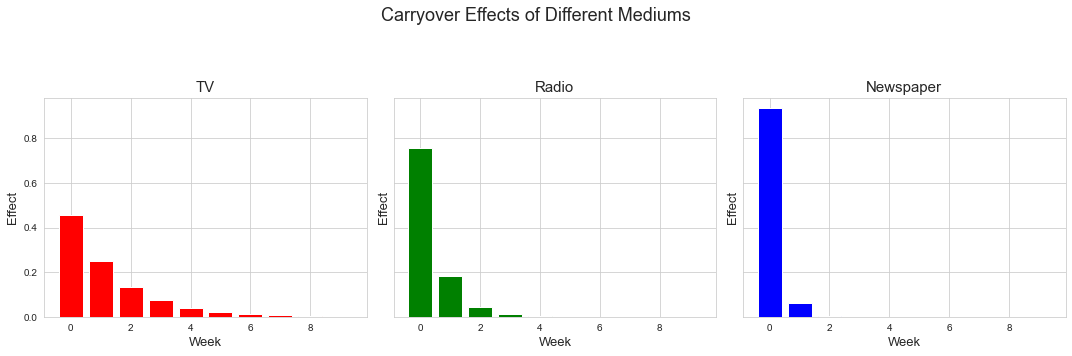

In [22]:
fig, axes = plt.subplots(1,3, figsize=(15,5), sharey = True)
colors = {0:'red', 1: 'green', 2: 'blue', 3: 'orange'}
fig.subplots_adjust(wspace=0.5, hspace=0.5)

for i in np.arange(3):
    ax = axes.flatten()[i]
    ax.bar(carryover["Weeks"], carryover.iloc[:,i+1], color = colors[i])
    ax.set_title(carryover.columns[i+1], fontsize=15)
    ax.set_xlabel("Week", fontsize=13)
    ax.set_ylabel("Effect", fontsize=13)

fig.suptitle("Carryover Effects of Different Mediums\n\n", fontsize=18)
plt.tight_layout()
plt.show()

**Observations on carryover effect**<br>

**TV**: TV carryover has a strength of **S = 0.54** and length of **L = 8**. We see from the red bars that about 50% of the effect is in the week of spend and it successively halves in each time period. By the 7th time period though, the effect is very small. <br>

**Radio**: Radio carryover has a strength of **S = 0.24** and length of **L = 7**. We see from the green bars that almost 80% of the radio effect is in the week of spend and it declines very fast. There is hardly any effect after the 4th time period.<br>

**Newspaper**: Newspaper carryover strength is quite low at **S = 0.065** and length of **L = 7**. We see from the blue bars that almost 95% of the newspaper effect is in the week of spend with the balance in the 2nd time period. <br>


In [15]:
tv_saturation_k = 4462
tv_saturation_s = 1.8626017655729163
radio_saturation_k =  5782
radio_saturation_s = 1.1562885946286745
newspaper_saturation_k = 40737
newspaper_saturation_s = 0.5796894819279327

saturation = pd.DataFrame({'Spend': [i*1000 for i in np.arange(60)]})
saturation["TV"] = [0 if i==0 else (1 / (1 + (i*1000/tv_saturation_k)**(-tv_saturation_s))) for i in range(60) ]
saturation["Radio"] = [0 if i==0 else (1 / (1 + (i*1000/radio_saturation_k)**(-radio_saturation_s))) for i in range(60) ]
saturation["Newspaper"] = [0 if i==0 else (1 / (1 + (i*1000/newspaper_saturation_k)**(-newspaper_saturation_s))) for i in range(60) ]



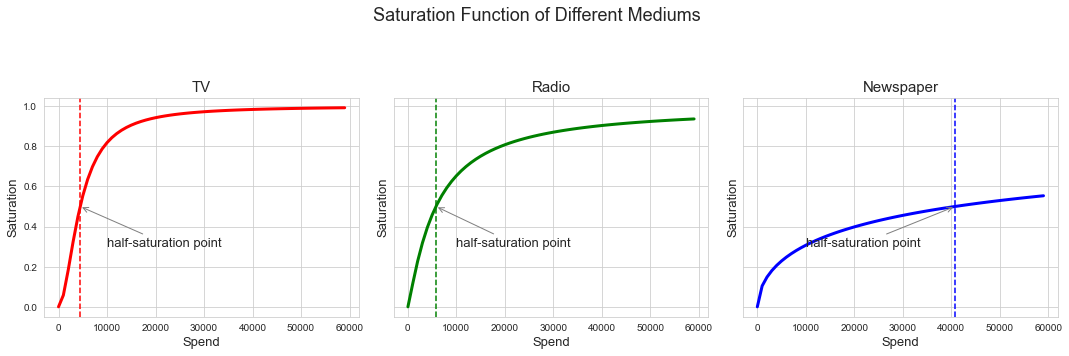

In [26]:
fig, axes = plt.subplots(1,3, figsize=(15,5), sharey = True)
colors = {0:'red', 1: 'green', 2: 'blue', 3: 'orange'}
half_saturation = {0: tv_saturation_k, 1: radio_saturation_k, 2: newspaper_saturation_k}
fig.subplots_adjust(wspace=0.5, hspace=0.5)

for i in np.arange(3):
    ax = axes.flatten()[i]
    ax.plot(saturation["Spend"], saturation.iloc[:,i+1], color = colors[i], linewidth=3)
    ax.set_title(saturation.columns[i+1], fontsize=15)
    ax.axvline(half_saturation[i], c = colors[i], linestyle="--")
    ax.annotate('half-saturation point', xy=(half_saturation[i], 0.5), xytext=(10000, 0.3), 
                arrowprops= {"arrowstyle": "->", "color":"gray"}, fontsize=13)
    ax.set_xlabel("Spend", fontsize=13)
    ax.set_ylabel("Saturation", fontsize=13)

fig.suptitle("Saturation Function of Different Mediums\n\n", fontsize=18)
plt.tight_layout()
plt.show()


**Observations on saturation effect**<br>

**TV**: TV saturates the fastest with a half-saturation point **K = 4462** and slope of **S = 1.86**. We see from the red line that TV's effect tapers sharply after a spend of 10,000 and saturates almost completely by 30,000.  <br>

**Radio**: The green line shows the radio saturation curve. Radio saturates slower than TV, with a half-saturation point **K = 5782** and a less steep slope of **S = 1.15**. Radio's effect tapers sharply after a spend of 15,000 and saturates almost completely by 60,000.<br>

**Newspaper**: Newspaper saturation is the slowest. As we see from the blue line, the newspaper saturation is very gradual with a half-saturation point **K = 40737** and a slope of **S = 0.58**. Newspaper is not saturated even at 60,000.<br>


# Visualizing Prediction vs Actual Sales

We saw earlier that our model has a good performance with a score of $r^{2}$  = **0.916**. Let's plot the predicted sales vs actual sales to see how closely the prediction tracks the actual sales.  

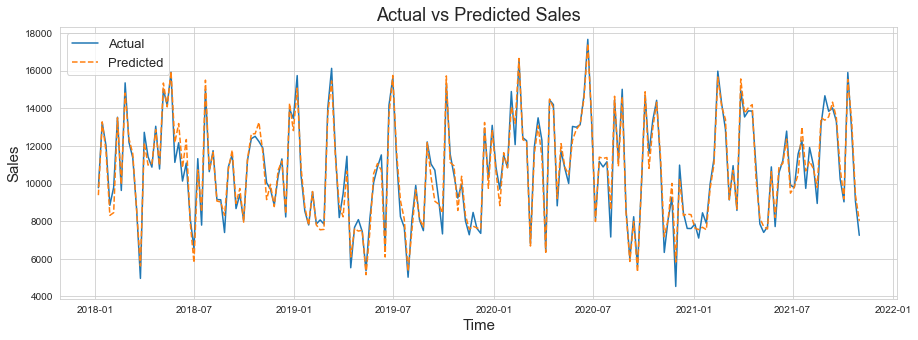

In [43]:
y_pred = tuned_model.predict(X)
fig, ax = plt.subplots(1,1, figsize = (15,5))
plt.plot(X.index, y, label="Actual")
plt.plot(X.index, y_pred, label="Predicted", linestyle="--")
plt.xlabel("Time", fontsize=15)
plt.ylabel("Sales", fontsize=15)
plt.title("Actual vs Predicted Sales", fontsize=18)
plt.legend(fontsize=13)
plt.show()


We see in the above chart that the predictions are pretty close to the actual sales. So the model works.

Let us now find out how well does each media contribute to overall sales. We are interested in calculating the return on Ad spend (**ROAS**) i.e. for every dollar spent on advertising in a particular media, how much does sales go up. 

As each media has carryover and saturation effects, we have to calculate ROAS by reducing the spend in a particular media to 0 for a given time-period and then calculating the change in sales. Both the original sales and the sales after reducing media spend are calculated using the prediction from our model. Also, to isolate the impact of a single media on sales, only spend on one particular media is made 0, keeping spends in other media the same. ROAS can be calculated as follows:

&emsp;&emsp;**ROAS[Media(m)]**&emsp; = &emsp; $\frac {Change in Total Sales} {Amount Spent on Media(m)}$

Given the carryover effect of media, we should expect to see a change not only in the *'change-period'*, but also a few periods after the change. On a similar note, the media spend before the start of change period is likely to have carryover effect during the *'change-period'*. It is therefore a good practice to have the time-periods that are pre and post the *change-period*, to be atleast equal to the carryover length L.


# Return on Ad Spend - TV


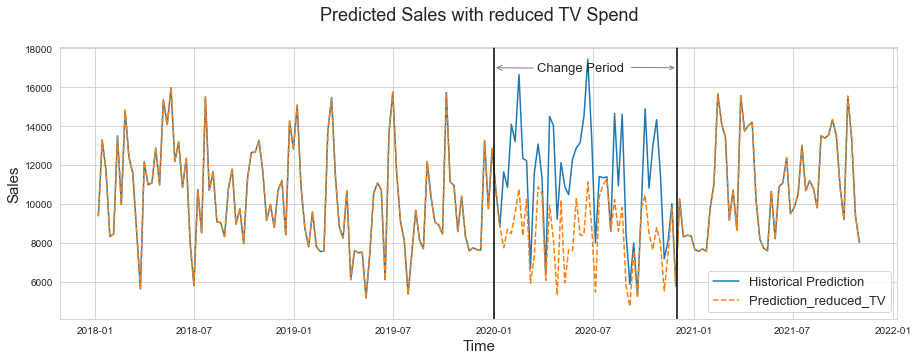

In [67]:
start_date = "2020-01"
end_date = "2020-12"
X_copy = X.copy()
X_copy.loc[start_date : end_date, "TV"] = 0
y_pred_lessTV = tuned_model.predict(X_copy)
fig, ax = plt.subplots(1,1, figsize = (15,5))
plt.plot(X_copy.index, y_pred, label="Historical Prediction")
plt.plot(X_copy.index, y_pred_lessTV, label="Prediction_reduced_TV", linestyle="--")
plt.xlabel("Time", fontsize=15)
plt.ylabel("Sales", fontsize=15)
plt.axvline(pd.Timestamp(start_date), color = 'black')
plt.axvline(pd.Timestamp(end_date), color = 'black')
plt.annotate("Change Period", xy = (pd.Timestamp(start_date), 17000), xytext=(0.57, 0.91), 
             textcoords = 'axes fraction', arrowprops={"arrowstyle": "->", "color":"gray"}, fontsize=13)
plt.annotate("", xy = (pd.Timestamp(end_date), 17000), xytext=(0.68, 0.925), 
             textcoords = 'axes fraction', arrowprops={"arrowstyle": "->", "color":"gray"})
plt.title("Predicted Sales with reduced TV Spend\n", fontsize=18)
plt.legend(fontsize=13)
plt.show()

In [59]:
sales_diff = np.sum(y_pred) - np.sum(y_pred_lessTV)
TV_spend_reduction = np.sum(X[start_date : end_date]["TV"])
roas_TV = sales_diff / TV_spend_reduction
print(f"The Return on Ad Spend for TV is {roas_TV:3.3}")

The Return on Ad Spend for TV is 0.758


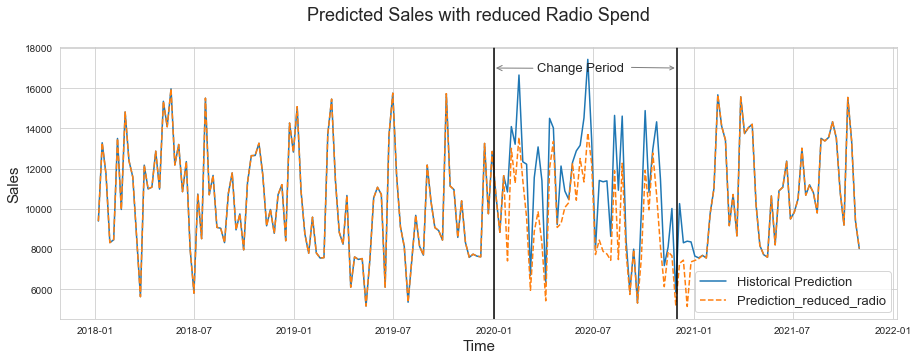

In [65]:
X_copy = X.copy()
X_copy.loc[start_date : end_date, "radio"] = 0
y_pred_less_radio = tuned_model.predict(X_copy)
fig, ax = plt.subplots(1,1, figsize = (15,5))
plt.plot(X_copy.index, y_pred, label="Historical Prediction")
plt.plot(X_copy.index, y_pred_less_radio, label="Prediction_reduced_radio", linestyle="--")
plt.xlabel("Time", fontsize=15)
plt.ylabel("Sales", fontsize=15)
plt.axvline(pd.Timestamp(start_date), color = 'black')
plt.axvline(pd.Timestamp(end_date), color = 'black')
plt.annotate("Change Period", xy = (pd.Timestamp(start_date), 17000), xytext=(0.57, 0.91), 
             textcoords = 'axes fraction', arrowprops={"arrowstyle": "->", "color":"gray"}, fontsize=13)
plt.annotate("", xy = (pd.Timestamp(end_date), 17000), xytext=(0.68, 0.925), 
             textcoords = 'axes fraction', arrowprops={"arrowstyle": "->", "color":"gray"})
plt.title("Predicted Sales with reduced Radio Spend\n", fontsize=18)
plt.legend(fontsize=13)
plt.show()

In [61]:
sales_diff = np.sum(y_pred) - np.sum(y_pred_less_radio)
radio_spend_reduction = np.sum(X[start_date : end_date]["radio"])
roas_radio = sales_diff / radio_spend_reduction

print(f"The Return on Ad Spend for Radio is {roas_radio:3.3}")


The Return on Ad Spend for Radio is 0.704


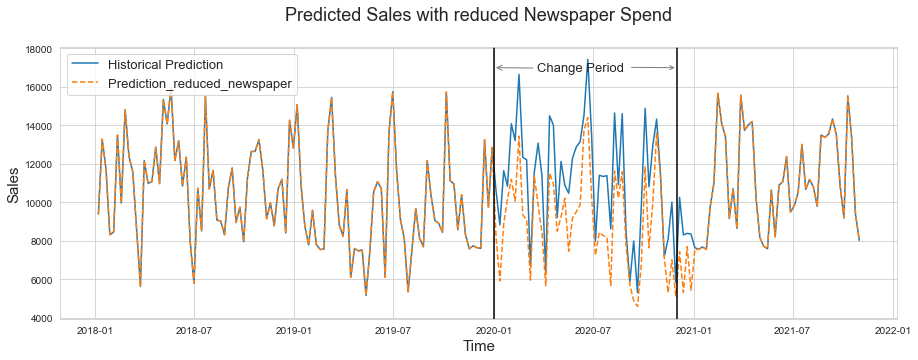

In [66]:
X_copy = X.copy()
X_copy.loc[start_date : end_date, "newspaper"] = 0
y_pred_less_newspaper = tuned_model.predict(X_copy)
fig, ax = plt.subplots(1,1, figsize = (15,5))
plt.plot(X_copy.index, y_pred, label="Historical Prediction")
plt.plot(X_copy.index, y_pred_less_newspaper, label="Prediction_reduced_newspaper", linestyle="--")
plt.xlabel("Time", fontsize=15)
plt.ylabel("Sales", fontsize=15)
plt.axvline(pd.Timestamp(start_date), color = 'black')
plt.axvline(pd.Timestamp(end_date), color = 'black')
plt.annotate("Change Period", xy = (pd.Timestamp(start_date), 17000), xytext=(0.57, 0.91), 
             textcoords = 'axes fraction', arrowprops={"arrowstyle": "->", "color":"gray"}, fontsize=13)
plt.annotate("", xy = (pd.Timestamp(end_date), 17000), xytext=(0.68, 0.925), 
             textcoords = 'axes fraction', arrowprops={"arrowstyle": "->", "color":"gray"})
plt.title("Predicted Sales with reduced Newspaper Spend\n", fontsize=18)
plt.legend(fontsize=13)
plt.show()

In [64]:
sales_diff = np.sum(y_pred) - np.sum(y_pred_less_newspaper)
newspaper_spend_reduction = np.sum(X[start_date : end_date]["newspaper"])
roas_newspaper = sales_diff / newspaper_spend_reduction

print(f"The Return on Ad Spend for Newspaper is {roas_newspaper:3.3}")


The Return on Ad Spend for Newspaper is 1.63


# Conclusion

1. A Linear Regression model based on carryover and saturation effects of advertising was built using the weekly sales data for 4 years.
2. Carryover was modeled by the Geometric Decay function and saturation by the Hill function.
3. The optimized model has good performance with $r^{2}$ = **0.916**. 
4. The optimized parameters for carryover and saturation helped in understanding these characteristics of each media.
5. The model was useful in understanding the Return on Ad Spend (ROAS) for each media as well.
    - Newspapers has the highest ROAS of **1.63**, followed by TV at **0.76** and finally radio at **0.70**.
